<a href="https://colab.research.google.com/github/abhikmr778/RFH/blob/main/March18Gamma0_6_30dbmAP32_train_DDPG_parameterNoise_Uplink_(1)_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# -*- coding: utf-8 -*-
"""cell_free_ul_reward_state_update_30dBm.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1589qShRSOT9j6evPI_C-XxGqxPkwZL2P
"""



# Commented out IPython magic to ensure Python compatibility.
%tensorflow_version 2.x
%load_ext tensorboard
import numpy as np
import pandas as pd
# import keras.backend.tensorflow_backend as backend
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import BatchNormalization, Dense, Activation, Dropout, Conv2D, LayerNormalization, MaxPooling2D, Activation, Flatten
from tensorflow.keras.layers import Input,Add, Lambda
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import TensorBoard
#from object_detection.utils.networks import tfSummary, OrnsteinUhlenbeckProcess
!rm -rf ./logs/ 
from collections import deque
import time
import random
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from pathlib import Path
from keras import losses
import h5py
from datetime import datetime  
import argparse
import pprint as pp

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'Abhinav-cell-free/'
path = Path(base_dir+str(datetime.now().strftime("%c"))+'/testlogs')
dest = path
dest.mkdir(parents=True, exist_ok=True)
path2 = Path(base_dir+str(datetime.now().strftime("%c"))+'/models')
dest2 = path2
model_path = Path(base_dir + 'test30th')
dest2.mkdir(parents=True, exist_ok=True)
path3 = Path(base_dir+'2020-01-30 19:42:04.279775'+'/models')
dest3 = path3
restore_path = base_dir+'Thu Jul 23 01:53:05 2020/models'

Mounted at /content/gdrive


In [3]:
# DISCOUNT = 0.7
REPLAY_MEMORY_SIZE = 20000
# MIN_REPLAY_MEMORY_SIZE = 512
MINIBATCH_SIZE = 32
#UPDATE_TARGET_EVERY = 100
MIN_REWARD = 30

EPISODES = 1000
UPDATES = 50
# EPOCH = 10
# START = 0
EPSILON = 0.6
MIN_EPSILON = 0.01
EPSILON_DECAY = np.power(MIN_EPSILON,(1/(EPISODES)))
# var = 10
# min_var = 1e-5
# var_decay = np.power(min_var,(1/(EPISODES)))
# MIN_EPSILON = 0

AGGREGATE_STATS_EVERY = 1
np.random.seed(2)
tf.compat.v1.set_random_seed(2)

In [4]:
# channelGains['channelGain'][0].shape
np.random.rand(10, 32).shape

(10, 32)

In [5]:
class wirelessEnv:
    def __init__(self, pu, nrx, gainspath, random_seed):
        print(pu)
        random.seed(random_seed)
        self.filename = base_dir+str(gainspath)
        self.channelGains = h5py.File(self.filename, 'r')
        self.B = 20000000
        self.N0 = 1

        self.T_c = 0.001
        
        self.Ptcm = 0.2
        self.Ptcl = 0.2
        self.Pom = 0.825
        self.pp = 0.2
        
        self.K = 10
        self.tauc = 200
        self.eff = 0.4 #amplifier efficiency
        self.M = 32
        self.pu = pu
        #self.ui = 4 # for all i
        #self.F = 3
        #self.Pfix =  # for all i
        self.Pft = 10
        self.C_fh = 100000000
        self.nu = 2
        self.a = 0.88115
        self.b = 0.88115
        self.taup = self.K
        self.tauf = 1 - (self.taup/self.tauc)
        #print(self.tauf)
        self.Nrx = nrx
        
        self.R_fh = 2*self.K*self.nu*self.tauf*self.tauc/self.T_c
        #print(self.R_fh)
        self.Pfix   = self.M*((self.Nrx*self.Ptcm)+self.Pom + self.Pft*self.R_fh/self.C_fh)/self.K
        #print(self.Pfix)
        self.theta_max = 1
        #self.sigma2 = self.F*self.N0*self.B
        self.alpha = deque(maxlen=2)
        self.beta = deque(maxlen=2)
        self.ch_gain = deque(maxlen=2)
        self.wi = [1/self.K for i in range(self.K)] # define equal weights which sum to 1
        self.pi = deque(maxlen=2)
        self.initialize_p()
        self.a_dim = 1 # we decide the cardinality as per the required resolution
        self.action_bound = np.asarray([0, 1])
        # initialize actions
        #self.actions = [0.00001]  
        #for x in range(self.action_space-1):
            #self.actions.append((x+1)*self.theta_max/(self.action_space-1))    
        # input/output for the neural net
        #self.s_dim = 8*self.K + 4*self.M + 2
        self.s_dim = self.K*self.M
        # self.s_dim = 4*self.M + 3*self.K - 1
        self.input = 100
        self.output = self.a_dim
        
    def initialize_matrix(self, episode):
        for t in range(2):
          # BETA = np.random.rand(self.M, self.K)
          BETA = self.channelGains['channelGain'][episode].transpose()
          gamma_num = np.zeros((self.M,self.K))
          gamma_den = np.zeros((self.M,self.K))

          Gamma = np.zeros((self.M,self.K))
          for m in range(self.M):
              for k in range(self.K):
                  gamma_num[m][k] = self.taup*self.pp*np.power(BETA[m][k],2)                                  
                  gamma_den[m][k] = self.taup*self.pp*BETA[m][k]+1                    
                  Gamma[m][k] = gamma_num[m][k]/gamma_den[m][k]
          self.ch_gain.append(Gamma)
          alpha1 = np.zeros((self.K,))
          for k in range(self.K):
              #alpha1[k] = self.Nrx*self.pu*np.sum(Gamma[:][k])*self.pi[t][k]
              alpha1[k] = self.pu*np.power(self.a*self.Nrx*np.sum(Gamma[:,k]),2)
          self.alpha.append(alpha1)
          beta1 = np.zeros((self.K,self.K))
          for k in range(self.K):
              for q in range(self.K):
                  beta1 [k][q] = self.a*self.a*self.pu*self.Nrx*(BETA[:,q].T@Gamma[:,k])         
          self.beta.append(beta1)
          # if episode >= 1999:
          #   print(f'Gamma:{Gamma}')
          #self.alpha_beta.append(np.array([[np.random.uniform(0,1) for e in range(K)] for e in range(K)]))        
        return

    def initialize_p(self):
        for t in range(2):
          self.pi.append(np.random.uniform(low=0, high=self.theta_max, size=(self.K,)))
        return
    
    def cal_alpha_p(self, i, t):
        val = self.alpha[t][i]*self.pi[t][i]
        # print(f'cal_alpha_p: {val}')
        return val
    
    def cal_beta_p(self, i, j, t):
        val = self.beta[t][i][j]*self.pi[t][j] # channel from UE j to BS i
        # print(f'cal_beta_p: {val}')
        return val
    
    def sum_beta_p(self, i, t):
        val = 0
        for j in range(self.K):
            val += self.cal_beta_p(i,j,t)  
        #val = val + (self.b-self.a*self.a)*self.Nrx*self.pu*np.sum(np.square(np.asarray(self.ch_gain)[t,:,i]))/(np.asarray(self.ch_gain)[t,:,i]))
        # print(f'sum_beta_p: {val}')
        return val 

    def cal_Ri(self,i, t):
        val = np.log2(1+(self.cal_alpha_p(i,t)/(self.b*self.Nrx*np.sum(np.asarray(self.ch_gain)[t,:,i]) + (self.b-self.a*self.a)*self.Nrx*self.Nrx*self.pu*self.pi[t][i]*np.linalg.norm(np.asarray(self.ch_gain)[t,:,i])**2 + self.b/(self.a*self.a)*self.sum_beta_p(i, t))))
        return val
        
    def cal_EEi(self,i,t):
        val = self.tauf*self.cal_Ri(i,t)/(self.pu*self.N0*self.pi[t][i]/self.eff + self.Pfix + self.Ptcl)
        return val

    def cal_total_WSEE(self,t):
        val = 0
        for x in range(self.K):
            val += self.wi[x]*self.cal_EEi(x,t)
        return val
    
    def cal_equal_p_WSEE(self, t):
        p = [self.theta_max for x in range(self.K)]
        temp = self.pi.copy()
        self.pi[t] = p
        val = self.cal_total_WSEE(t)
        self.pi = temp
        return val
  

    def cal_reward(self,i,t):
        #ri = self.wi[i]*self.cal_EEi(i,t) - self.sum_price(i,t)
        # ri = self.cal_total_WSEE(t)
        # ri = (np.log(self.cal_total_WSEE(t)) - np.log(self.cal_equal_p_WSEE(t)))
        ri = self.cal_total_WSEE(t) - self.cal_equal_p_WSEE(t) 
        return ri

  
    def cal_state(self,i):
        state = []
        indx = 0
        for t in reversed(range(1)): #for current timestep only
            # next two elements in states are alpha(t)*pi(t-1) and Σbeta(t)pi(t-1)
            #state.append(self.cal_alpha_p(i,t)) # 2
            #state.append(self.sum_beta_p(i,t)) # 2
          for m in range(self.M):
            for k in range(self.K):
              state.append(self.ch_gain[t][m][k]) #M
            # state.append(self.ch_gain[t][m][i]*self.pi[t][i]) #M
            # print(f'ch_gain: {self.ch_gain[t][m][i]}')
            # print(f'pi: {self.pi[t][i]}')
          #2*2*M

          # next elements in states are the interferences from other users to ith user at time step t
          #for x in range(self.K):                               
              #state.append(self.cal_interfering(i,x,t)) # K
              #state.append(self.cal_EEi(x,t)) # K
          # 2xK
          
          # next elements in states are the interfered users by the ith user at time step t
          # for x in range(self.K):
          #     if x!= i:                    
          #         if t==1:
          #           # print(f'cal_alpha_p: {self.cal_alpha_p(x,1)}')
          #           # print(f'cal_beta_p: {self.cal_beta_p(i,x,1)}')
          #           # print(f'sum_beta_p: {self.sum_beta_p(x,1)}')
          #           state.append(self.cal_alpha_p(x,1)) # K-1
          #           # state.append(self.cal_total_WSEE(t)) # K-1
          #           state.append(self.cal_beta_p(i,x,1)) # K-1
          #           state.append(self.sum_beta_p(x,1)) # K-1
                      
                  #state.append(self.cal_interfered(i,x,t)) # K-1
          # 4x(K-1)
        
        # pi(t-1) and WSEEi(t-1)
        # print(f'cal_total_WSEE: {self.cal_total_WSEE(1)}')
        # state.append(self.pi[1][i])
        # state.append(self.cal_total_WSEE(1))        # 1
        #return np.asarray(state)
        state = np.reshape(state, [1, self.s_dim])
        return np.asarray(-np.log10(state))

    def initialize_state(self):
        UE = random.randint(0,self.K-1)
        state = self.cal_state(UE)
        return state, UE

    def reset(self, episode):
        self.initialize_matrix(episode)
#         self.initialize_p()
        self.episode_step = 0
        state, agent_no = self.initialize_state()
        return state, agent_no

    def initialize_state_test(self, UE):
        state = self.cal_state(UE)
        return state

    def reset_test(self, episode):
        self.initialize_matrix(episode)
        self.episode_step = 0

    def agent_reset(self):
        state, agent_no = self.initialize_state()
        state = np.reshape(state, [1, self.s_dim])
        return state, agent_no

            
    def step(self, action, agent):
        self.episode_step += 1
        temp = self.pi[1].copy()
        temp[agent] = action #action generated from action network (+noise+bounding)
        self.pi.append(temp)
        next_state = self.cal_state(agent)
        reward = self.cal_reward(agent,1)
        next_state = np.reshape(next_state, [1, self.s_dim])
        done = False
        if self.episode_step >= UPDATES:
            done = True
        return next_state, reward, done


In [6]:
class ReplayBuffer():
    def __init__(self, random_seed=1337):
        self.buffer = deque(maxlen = REPLAY_MEMORY_SIZE)
        self.priorities = deque(maxlen = REPLAY_MEMORY_SIZE)
        random.seed(random_seed)

    def add(self, experience):
        self.buffer.append(experience)
        self.priorities.append(max(self.priorities, default=1))

    def get_probabilities(self, priority_scale):
        scaled_priorities = np.array(self.priorities)**priority_scale
        # print(f'shape {scaled_priorities}, sum {np.sum(scaled_priorities)}')
        sampled_probabilities = scaled_priorities/sum(scaled_priorities)
        return sampled_probabilities

    def get_importance(self, probabilities):
        importance = 1/len(self.buffer) * 1/probabilities
        importance_normalized = importance/max(importance)
        return importance_normalized

    def sample(self, priority_scale = 0.7):
        samples = random.sample(self.buffer, MINIBATCH_SIZE)
        sample_probs = self.get_probabilities(priority_scale)
        sample_indices = random.choices(range(len(self.buffer)), k = MINIBATCH_SIZE, weights= sample_probs)
        samples = np.array(self.buffer)[sample_indices]
        importance = self.get_importance(sample_probs[sample_indices])
        return samples, importance, sample_indices

    def set_priorities(self, indices, errors, offset=0.1):
        for i,e in zip(indices, errors):
            self.priorities[i] = abs(e) + offset


In [7]:
class AdaptiveParamNoise:
  def __init__(self, initial_stddev=0.25, desired_action_stddev=0.25, adoption_coefficient=1.01):
    self.initial_stddev = tf.Variable(initial_stddev)
    self.desired_action_stddev = tf.Variable(desired_action_stddev)
    self.adoption_coefficient = tf.Variable(adoption_coefficient)
    self.current_stddev = tf.Variable(initial_stddev)

  def adapt_stddev(self, distance):
    return tf.cond(distance > self.desired_action_stddev,
                    lambda: self.current_stddev.assign(tf.compat.v1.div(self.current_stddev, self.adoption_coefficient)),
                    lambda: self.current_stddev.assign(tf.compat.v1.multiply(self.current_stddev, self.adoption_coefficient)))
    
  def __repr__(self):
    _repr = 'AdaptiveParamNoise(initial_stddev={}, desired_action_stddev={}, adoption_coefficient={})'
    return _repr.format(self.initial_stddev, self.desired_action_stddev, self.adoption_coefficient)

In [8]:
class Stats:
  def __init__(self, sess, shape=()):
    self.sess = sess
    self.sum = tf.compat.v1.get_variable(
        dtype=tf.float32,
        shape=shape,
        initializer=tf.constant_initializer(0.0),
        name='runningsum', trainable=False)
    self.sqsum = tf.compat.v1.get_variable(
        dtype=tf.float32,
        shape=shape,
        initializer=tf.constant_initializer(1e-2),
        name='runningsqsum', trainable=False)
    self.count = tf.compat.v1.get_variable(
        dtype=tf.float32,
        shape=(),
        initializer=tf.constant_initializer(1e-2),
        name='count', trainable=False)
    
    self.mean = tf.compat.v1.div(self.sum, self.count)
    self.std = tf.clip_by_value(
        tf.sqrt(tf.compat.v1.squared_difference(tf.sqrt(tf.compat.v1.div(self.sqsum, self.count)),self.mean)),1e-2, 10)
    
    self.sum_next = tf.compat.v1.placeholder(tf.float32, shape=shape)
    self.sqsum_next = tf.compat.v1.placeholder(tf.float32, shape=shape)
    self.count_next = tf.compat.v1.placeholder(tf.float32, shape=())
    self.update_op = [self.sum.assign_add(self.sum_next), self.sqsum.assign_add(self.sqsum_next),
                      self.count.assign_add(self.count_next)]

  def update(self, state):
    self.sess.run(self.update_op, feed_dict={self.sum_next: state.sum(axis=0),
                                             self.sqsum_next: np.square(state).sum(axis=0),
                                             self.count_next: np.array(len(state), dtype='float32')})

In [9]:
def normalize(x, stats):
    if stats is None:
        return x
    return (x - stats.mean) / stats.std


In [10]:
class Actor:
    def __init__(self, sess, s_dim, a_dim, normalize_observations=True,
                 use_param_noise=False, tau=0.01, gamma=.99, delta=0.2, learning_rate=0.0001,
                 observation_range=(-5., 5.)):
        #main model #gets trained every step
        
        self.save_path = path2
        self.sess = sess
        self.s_dim = s_dim
        self.a_dim = a_dim
        self.tau = tau
        self.delta = delta
        self.lr = learning_rate
        self.observation_range = observation_range
        self.normalize_observations = normalize_observations

        self.state_ph = tf.compat.v1.placeholder(tf.float32, [None, self.s_dim], name='states_a')
        self.drop_prob_ph = tf.compat.v1.placeholder(tf.float32, name='drop_prob_a')
        self.critic_gradients = tf.compat.v1.placeholder(tf.float32, [None, self.a_dim], 'critic_grad_a')
        self.obs_rms = None


        #Observation normalization
        if self.normalize_observations:
          with tf.compat.v1.variable_scope('obs_rms', reuse=tf.compat.v1.AUTO_REUSE):
            self.obs_rms = Stats(self.sess, self.s_dim)

        with tf.compat.v1.variable_scope('actor'):
          self.actions = self.policy_network(self.state_ph, self.drop_prob_ph)
        self.policy_params = tf.compat.v1.trainable_variables(scope='actor')


        if use_param_noise: 
          with tf.compat.v1.variable_scope('perturbed_actor'):
            self.perturbed_actions = self.policy_network(self.state_ph, self.drop_prob_ph)
          self.perturbed_policy_params = tf.compat.v1.trainable_variables(scope='perturbed_actor')
        
          self.adapt_noise = AdaptiveParamNoise()
          self.stddev_ph = tf.compat.v1.placeholder(tf.float32)

          self.action_distance, self.stddev = self.adaptive_param_noise()

          self.updated_perturbed_policy_params = [self.perturbed_policy_params[i].assign(self.policy_params[i] + tf.random.normal(tf.shape(self.perturbed_policy_params[i]), 0.,self.stddev_ph, seed=1337)) for i in range(len(self.perturbed_policy_params)) if 'LayerNorm' not in self.perturbed_policy_params[i].name]


        with tf.compat.v1.variable_scope('target_actor'):
          self.target_actions = self.policy_network(self.state_ph, self.drop_prob_ph)
        self.target_policy_params = tf.compat.v1.trainable_variables(scope='target_actor')

        self.objective_gradient = \
            tf.gradients(self.actions, self.policy_params, -self.critic_gradients)

        self.update_policy_params = tf.compat.v1.train.AdamOptimizer(self.lr).apply_gradients(
            zip(self.objective_gradient, self.policy_params))

        # print(f'policy_params{np.array(self.policy_params).shape}, target_policy_params{np.array(self.target_policy_params).shape}')
        # print(f'policy_params{self.policy_params}')
        # print(f'target_policy_params{self.target_policy_params}')
        
        self.update_target_policy_params = [self.target_policy_params[i].assign(
                                                                  self.tau * self.policy_params[i]
                                                                  + (1 - self.tau) *
                                                                  self.target_policy_params[i]
                                                                  )
                                                        for i in range(len(self.target_policy_params))]

        # self.merge_op = tf.summary.merge_all(scope='Actor')
        self.saver = tf.compat.v1.train.Saver()




    def policy_network(self, state, drop_prob, seed=1337):
        # state = tf.clip_by_value(normalize(state, self.obs_rms),
        #                          self.observation_range[0], self.observation_range[1])

        # input = Input(shape = (self.s_dim,))
        h1 = Dense(128)(state)
        h1 = LayerNormalization(center=True , scale=True)(h1)
        h1 = Activation('relu')(h1)
        h1 = Dropout(drop_prob, seed=seed)(h1)

        # h1 = tf.layers.dense(state, 128)
        # h1 = tc.layers.layer_norm(h1, center=True, scale=True)
        # h1 = tf.nn.elu(h1)
        # h1 = tf.layers.dropout(h1, drop_prob, seed=seed)

        h2 = Dense(64)(h1)
        h2 = LayerNormalization(center=True , scale=True)(h2)
        h2 = Activation('tanh')(h2)
        h2 = Dropout(drop_prob, seed=seed)(h2)

        # h2 = tf.layers.dense(h1, 128)
        # h2 = tc.layers.layer_norm(h2, center=True, scale=True)
        # h2 = tf.nn.elu(h2)
        # h2 = tf.layers.dropout(h2, drop_prob, seed=seed)

        h3 = Dense(32)(h2)
        h3 = LayerNormalization(center=True , scale=True)(h3)
        h3 = Activation('relu')(h3)
        h3 = Dropout(drop_prob, seed=seed)(h3)

        # h3 = tf.layers.dense(h2, 64)
        # h3 = tc.layers.layer_norm(h3, center=True, scale=True)
        # h3 = tf.nn.elu(h3)
        # h3 = tf.layers.dropout(h3, drop_prob, seed=seed)

        h4 = Dense(16)(h3)
        h4 = LayerNormalization(center=True , scale=True)(h4)
        h4 = Activation('tanh')(h4)
        h4 = Dropout(drop_prob, seed=seed)(h4)

        h5 = Dense(8)(h4)
        h5 = LayerNormalization(center=True , scale=True)(h5)
        h5 = Activation('elu')(h5)
        h5 = Dropout(drop_prob, seed=seed)(h5)

        # h4 = tf.layers.dense(h3, 64)
        # h4 = tc.layers.layer_norm(h4, center=True, scale=True)
        # h4 = tf.nn.elu(h4)
        # h4 = tf.layers.dropout(h4, drop_prob, seed=seed)

        actions = Dense(self.a_dim, kernel_initializer=tf.random_uniform_initializer(-3e-3, 3e-3, seed=seed))(h5)
        actions = Activation('relu')(actions)

        # actions = tf.layers.dense(h4, self.action_dim, kernel_initializer=tf.random_uniform_initializer(-3e-3, 3e-3, seed=seed))
        # actions = tf.nn.tanh(actions)

        return actions

    def add_param_noise(self, state):
        adaptive_policy_distance, stddev = self.sess.run([self.action_distance, self.stddev],
                                                         feed_dict={self.state_ph: state, self.drop_prob_ph: 0.0})
        self.sess.run(self.updated_perturbed_policy_params, feed_dict={self.stddev_ph: stddev})

        return adaptive_policy_distance, stddev

    def adaptive_param_noise(self):
        adaptive_policy_distance = tf.sqrt(tf.reduce_mean(
            tf.compat.v1.squared_difference(self.actions, self.perturbed_actions)))
        
        std_dev = self.adapt_noise.adapt_stddev(adaptive_policy_distance)

        return adaptive_policy_distance, std_dev

    def train(self, state, drop_prob, critic_grads):
        self.sess.run(self.update_policy_params, feed_dict={self.state_ph: state,
                                                            self.drop_prob_ph: drop_prob,
                                                            self.critic_gradients: critic_grads})
        
    def predict(self, state, drop_prob):
        return self.sess.run(self.actions, feed_dict={self.state_ph: state,
                                                      self.drop_prob_ph: drop_prob})

    def perturbed_predict(self, state, drop_prob):
        return self.sess.run(self.perturbed_actions, feed_dict={self.state_ph: state,
                                                                self.drop_prob_ph: drop_prob})
        
    def target_predict(self, state, drop_prob):
        return self.sess.run(self.target_actions, feed_dict={self.state_ph: state,
                                                             self.drop_prob_ph: drop_prob})
        
    def restore_model(self,wsee,fpa):
        self.saver.restore(self.sess, str(self.save_path) + '/actor/model_actor_wsee_'+str(wsee)+'_'+str(fpa)+'.ckpt')

    def save_model(self,wsee,fpa):
        self.saver.save(self.sess, str(self.save_path) + '/actor/model_actor_wsee_'+str(wsee)+'_'+str(fpa)+'.ckpt')   

        

In [11]:
class Critic:
    def __init__(self, sess, s_dim ,a_dim, normalize_observations=True,
                 tau=0.01, gamma=.99, learning_rate=0.001, l2_reg=0.01, observation_range=(-5., 5.)):
        
        self.sess = sess
        self.save_path = path2
        self.s_dim = s_dim
        self.a_dim = a_dim
        self.tau = tau
        self.lr = learning_rate
        self.l2_reg = l2_reg
        self.gamma = gamma
        self.normalize_observations = normalize_observations
        self.observation_range = observation_range
        self.obs_rms = None

        self.state_ph = tf.compat.v1.placeholder(tf.float32, [None, self.s_dim])
        self.action_ph = tf.compat.v1.placeholder(tf.float32, [None, self.a_dim])
        self.future_reward_ph = tf.compat.v1.placeholder(tf.float32, [None, MINIBATCH_SIZE])
        self.importance_ph = tf.compat.v1.placeholder(tf.float32, [None, MINIBATCH_SIZE])
        self.drop_prob_ph = tf.compat.v1.placeholder(tf.float32)

        if self.normalize_observations:
          with tf.compat.v1.variable_scope('obs_rms', reuse=tf.compat.v1.AUTO_REUSE):
            self.obs_rms = Stats(self.sess, shape=self.s_dim)

        with tf.compat.v1.variable_scope('critic'):
          self.q_value = self.q_value_network(self.state_ph, self.action_ph, self.drop_prob_ph)
        self.q_params = tf.compat.v1.trainable_variables(scope='critic')

        with tf.compat.v1.variable_scope('target_critic'):
          self.target_q_value = self.q_value_network(self.state_ph, self.action_ph, self.drop_prob_ph)
        self.target_q_params = tf.compat.v1.trainable_variables(scope='target_critic')

        self.critic_gradients = tf.gradients(self.q_value, self.action_ph)

        self.loss = tf.reduce_mean((self.importance_ph**(1-EPSILON))*tf.compat.v1.squared_difference(self.q_value, self.future_reward_ph)) + \
                    self.l2_reg*tf.compat.v1.losses.get_regularization_loss(scope='critic')

        # self.loss = tf.compat.v1.losses.mean_squared_error(self.predict(self.state_ph, self.action_ph, self.drop_prob_ph), self.future_reward_ph, weights = self.importance_ph**(1-EPSILON), scope='critic')

        # mse = tf.keras.losses.MeanSquaredError()
        # self.loss = mse(self.future_reward_ph, self.q_value, sample_weight = self.importance_ph**(1-EPSILON))

        self.update_q_params = tf.compat.v1.train.AdamOptimizer(self.lr).minimize(self.loss)

        self.update_target_q_params = [self.target_q_params[i].assign(self.tau*self.q_params[i]+(1-self.tau)*self.target_q_params[i]) for i in range(len(self.target_q_params))]

        self.saver = tf.compat.v1.train.Saver()

        # self.merge_op = tf.summary.merge_all(scope='critic')

    def q_value_network(self, state, action, drop_prob, seed=1337):
        # state = tf.clip_by_value(normalize(state, self.obs_rms),
        #                          self.observation_range[0], self.observation_range[1])



        # Layer 1
        h1 = Dense(128, kernel_regularizer=tf.nn.l2_loss)(state)
        h1 = LayerNormalization(center=True , scale=True)(h1)
        h1 = Activation('tanh')(h1)
        h1 = Dropout(drop_prob, seed=seed)(h1)
        # h1 = tf.layers.dense(state, 128, kernel_regularizer=tf.nn.l2_loss)
        # h1 = tc.layers.layer_norm(h1, center=True, scale=True)
        # h1 = tf.nn.elu(h1)
        # h1 = tf.layers.dropout(h1, drop_prob, seed=seed)
        

        # Layer 2 + add actions
        h2 = tf.keras.layers.concatenate([h1, action], axis=-1)

        h2 = Dense(64, kernel_regularizer=tf.nn.l2_loss)(h2)
        h2 = LayerNormalization(center=True, scale=True)(h2)
        h2 = Activation('relu')(h2)
        h2 = Dropout(drop_prob, seed=seed)(h2)

        # h2 = tf.concat([h1, action], axis=-1)

        # h2 = tf.layers.dense(h2, 128, kernel_regularizer=tf.nn.l2_loss)
        # h2 = tc.layers.layer_norm(h2, center=True, scale=True)
        # h2 = tf.nn.elu(h2)
        # h2 = tf.layers.dropout(h2, drop_prob, seed=seed)

        # Layer 3
        h3 = Dense(32, kernel_regularizer=tf.nn.l2_loss)(h2)
        h3 = LayerNormalization(center=True, scale=True)(h3)
        h3 = Activation('tanh')(h3)
        h3 = Dropout(drop_prob, seed=seed)(h3)

        # h3 = tf.layers.dense(h2, 64, kernel_regularizer=tf.nn.l2_loss)
        # h3 = tc.layers.layer_norm(h3, center=True, scale=True)
        # h3 = tf.nn.elu(h3)
        # h3 = tf.layers.dropout(h3, drop_prob, seed=seed)

        # Layer 4
        h4 = Dense(16, kernel_regularizer=tf.nn.l2_loss)(h3)
        h4 = LayerNormalization(center=True, scale=True)(h4)
        h4 = Activation('relu')(h4)
        h4 = Dropout(drop_prob, seed=seed)(h4)

        # h4 = tf.layers.dense(h3, 64, kernel_regularizer=tf.nn.l2_loss)
        # h4 = tc.layers.layer_norm(h4, center=True, scale=True)
        # h4 = tf.nn.elu(h4)
        # h4 = tf.layers.dropout(h4, drop_prob, seed=seed)

        # Layer 5
        h5 = Dense(8, kernel_regularizer=tf.nn.l2_loss)(h4)
        h5 = LayerNormalization(center=True, scale=True)(h5)
        h5 = Activation('elu')(h5)
        h5 = Dropout(drop_prob, seed=seed)(h5)

        # h5 = tf.layers.dense(h4, 64, kernel_regularizer=tf.nn.l2_loss)
        # h5 = tc.layers.layer_norm(h5, center=True, scale=True)
        # h5 = tf.nn.elu(h5)
        # h5 = tf.layers.dropout(h5, drop_prob, seed=seed)

        # Output q_value
        q_value = Dense(1, kernel_regularizer=tf.random_uniform_initializer(-3e-4, 3e-4, seed=seed))(h5)
        # q_value = tf.layers.dense(h4, 1, kernel_initializer=tf.random_uniform_initializer(-3e-4, 3e-4, seed=seed))

        return q_value

    def compute_grads(self, state, action, drop_prob):
        return self.sess.run(self.critic_gradients, feed_dict={self.state_ph: state,
                                                               self.action_ph: action,
                                                               self.drop_prob_ph: drop_prob})

    def train(self, state, action, drop_prob, future_reward, importance):
        return self.sess.run([self.loss, self.update_q_params], feed_dict={self.state_ph: state,
                                                         self.action_ph: action,
                                                         self.drop_prob_ph: drop_prob,
                                                         self.future_reward_ph: future_reward,
                                                         self.importance_ph: importance})

    def predict(self, state, action, drop_prob):
        return self.sess.run(self.q_value, feed_dict={self.state_ph: state,
                                                      self.action_ph: action,
                                                      self.drop_prob_ph: drop_prob})

    def target_predict(self, state, action, drop_prob):
        return self.sess.run(self.target_q_value, feed_dict={self.state_ph: state,
                                                             self.action_ph: action,
                                                             self.drop_prob_ph: drop_prob})

    def restore_model(self,wsee,fpa):
        self.saver.restore(self.sess, str(self.save_path) + '/critic/model_critic_wsee_'+str(wsee)+'_'+str(fpa)+'.ckpt')

    def save_model(self,wsee,fpa):
        self.saver.save(self.sess, str(self.save_path) + '/critic/model_critic_wsee_'+str(wsee)+'_'+str(fpa)+'.ckpt')




In [12]:
def variable_summaries(var, name):
  with tf.name_scope(name):
    mean = tf.reduce_mean(var)
    tf.summary.scalar('mean', mean)
    with tf.name_scope('stddev'):
      stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
    tf.summary.scalar('stddev', stddev)
    tf.summary.scalar('max', tf.reduce_max(var))
    tf.summary.scalar('min', tf.reduce_min(var))
    tf.summary.histogram('histogram', var)

Namespace(actor_lr=0.005, buffer_size=10000, critic_lr=0.05, delta=0.2, drop_prob=0.4, gamma=0.6, l2_reg=0.0, max_episode_len=20000, max_episodes=1000, max_exploration_steps=1000000.0, minibatch_size=512, normalize_obs=True, random_seed=1337, restore=False, save=True, summary_dir='./results/tf_ddpg', tau=0.01, train=True, train_step=50, use_adaptive_parameter_noise=True)
1.0
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
Use `tf.global_variables_initializer` instead.


  0%|          | 0/1000 [00:00<?, ?episode/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:203: RuntimeWarning: Mean of empty slice.
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  0%|          | 1/1000 [00:00<08:59,  1.85episode/s]

Loss: None|| Global step: 50 || Episode: 1 || Reward: -0.92 || Distance: nan ||
wsee: 0.11052579306041635, eqwsee: 0.12405338095790251, reward: -0.9236488407708251
|| Test Run No: 1100 || WSEE: 0.019337751304110237 || eq_WSEE: 0.10417327110291066 || Reward: -0.49 ||
|| Test Run No: 1120 || WSEE: 0.03216795862372931 || eq_WSEE: 0.15875344714719553 || Reward: -1.04 ||
|| Test Run No: 1140 || WSEE: 0.07315888804497962 || eq_WSEE: 0.10557475616596732 || Reward: -0.29 ||
|| Test Run No: 1160 || WSEE: 0.04187665961724936 || eq_WSEE: 0.10639065246086721 || Reward: -0.75 ||
|| Test Run No: 1180 || WSEE: 0.10303209664392564 || eq_WSEE: 0.13084527637398705 || Reward: -0.32 ||
wsee:0.07761965002382906, fpa_wsee: 0.12424997011815597


  0%|          | 2/1000 [00:05<29:00,  1.74s/episode]

Loss: None|| Global step: 100 || Episode: 2 || Reward: -3.93 || Distance: nan ||
wsee: 0.11254812925705324, eqwsee: 0.13152993615391398, reward: -3.930645413635999


  0%|          | 3/1000 [00:05<22:29,  1.35s/episode]

Loss: None|| Global step: 150 || Episode: 3 || Reward: -3.19 || Distance: nan ||
wsee: 0.06052864185486667, eqwsee: 0.12667374975229123, reward: -3.1897221972016823
|| Test Run No: 1100 || WSEE: 0.01930711683246188 || eq_WSEE: 0.10417327110291066 || Reward: -0.51 ||
|| Test Run No: 1120 || WSEE: 0.03216795862372931 || eq_WSEE: 0.15875344714719553 || Reward: -1.04 ||
|| Test Run No: 1140 || WSEE: 0.07315888804497962 || eq_WSEE: 0.10557475616596732 || Reward: -0.29 ||
|| Test Run No: 1160 || WSEE: 0.04187665961724936 || eq_WSEE: 0.10639065246086721 || Reward: -0.75 ||
|| Test Run No: 1180 || WSEE: 0.10303209664392564 || eq_WSEE: 0.13084527637398705 || Reward: -0.32 ||
wsee:0.07761934367911257, fpa_wsee: 0.12424997011815597


  0%|          | 4/1000 [00:10<38:14,  2.30s/episode]

Loss: None|| Global step: 200 || Episode: 4 || Reward: -1.66 || Distance: nan ||
wsee: 0.11254812925705324, eqwsee: 0.13152993615391398, reward: -1.6625270630342754


  0%|          | 5/1000 [00:10<28:57,  1.75s/episode]

Loss: None|| Global step: 250 || Episode: 5 || Reward: -2.87 || Distance: nan ||
wsee: 0.07476066397188637, eqwsee: 0.13794311653266034, reward: -2.872596748329633
|| Test Run No: 1100 || WSEE: 0.019341942753895492 || eq_WSEE: 0.10417327110291066 || Reward: -0.49 ||
|| Test Run No: 1120 || WSEE: 0.03216795862372931 || eq_WSEE: 0.15875344714719553 || Reward: -1.04 ||
|| Test Run No: 1140 || WSEE: 0.07315888804497962 || eq_WSEE: 0.10557475616596732 || Reward: -0.29 ||
|| Test Run No: 1160 || WSEE: 0.04187665961724936 || eq_WSEE: 0.10639065246086721 || Reward: -0.75 ||
|| Test Run No: 1180 || WSEE: 0.10303209664392564 || eq_WSEE: 0.13084527637398705 || Reward: -0.32 ||
wsee:0.0776196919383269, fpa_wsee: 0.12424997011815597


  1%|          | 6/1000 [00:14<41:25,  2.50s/episode]

Loss: None|| Global step: 300 || Episode: 6 || Reward: -1.01 || Distance: nan ||
wsee: 0.11254812925705324, eqwsee: 0.13152993615391398, reward: -1.013255850605532


  1%|          | 7/1000 [00:15<31:14,  1.89s/episode]

Loss: None|| Global step: 350 || Episode: 7 || Reward: -1.16 || Distance: nan ||
wsee: 0.12553785136715712, eqwsee: 0.1493886152409169, reward: -1.1600672371915126
|| Test Run No: 1100 || WSEE: 0.018652430049464184 || eq_WSEE: 0.10417327110291066 || Reward: -0.63 ||
|| Test Run No: 1120 || WSEE: 0.03216795862372931 || eq_WSEE: 0.15875344714719553 || Reward: -1.04 ||
|| Test Run No: 1140 || WSEE: 0.07315888804497962 || eq_WSEE: 0.10557475616596732 || Reward: -0.29 ||
|| Test Run No: 1160 || WSEE: 0.04187665961724936 || eq_WSEE: 0.10639065246086721 || Reward: -0.75 ||
|| Test Run No: 1180 || WSEE: 0.10303209664392564 || eq_WSEE: 0.13084527637398705 || Reward: -0.32 ||
wsee:0.0776127968112826, fpa_wsee: 0.12424997011815597


  1%|          | 8/1000 [00:19<43:11,  2.61s/episode]

Loss: None|| Global step: 400 || Episode: 8 || Reward: -0.80 || Distance: nan ||
wsee: 0.11254812925705324, eqwsee: 0.13152993615391398, reward: -0.7964237637867293


  1%|          | 9/1000 [00:20<32:38,  1.98s/episode]

Loss: None|| Global step: 450 || Episode: 9 || Reward: -1.98 || Distance: nan ||
wsee: 0.031769090114377826, eqwsee: 0.08196776106857911, reward: -1.9826988785730615
|| Test Run No: 1100 || WSEE: 0.01941561463766322 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 0.03216795862372931 || eq_WSEE: 0.15875344714719553 || Reward: -1.04 ||
|| Test Run No: 1140 || WSEE: 0.07315888804497962 || eq_WSEE: 0.10557475616596732 || Reward: -0.29 ||
|| Test Run No: 1160 || WSEE: 0.04187665961724936 || eq_WSEE: 0.10639065246086721 || Reward: -0.75 ||
|| Test Run No: 1180 || WSEE: 0.10303209664392564 || eq_WSEE: 0.13084527637398705 || Reward: -0.32 ||
wsee:0.07762042865716459, fpa_wsee: 0.12424997011815597


  1%|1         | 10/1000 [00:24<45:21,  2.75s/episode]

Loss: None|| Global step: 500 || Episode: 10 || Reward: -2.30 || Distance: nan ||
wsee: 0.11254812925705324, eqwsee: 0.13152993615391398, reward: -2.2968688809802167


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creati

Loss: 0.010269847698509693|| Global step: 550 || Episode: 11 || Reward: 0.89 || Distance: 0.6200 ||
wsee: 0.1494716303445404, eqwsee: 0.1329870525598128, reward: 0.8887567886212321
|| Test Run No: 1100 || WSEE: 0.017603710685314217 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 0.006960177067137216 || eq_WSEE: 0.15875344714719553 || Reward: -1.36 ||
|| Test Run No: 1140 || WSEE: 0.04353284584303302 || eq_WSEE: 0.10557475616596732 || Reward: -0.59 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07596707887396287 || eq_WSEE: 0.13084527637398705 || Reward: -0.68 ||
wsee:0.03471710795146052, fpa_wsee: 0.12424997011815597


  1%|1         | 12/1000 [00:33<1:01:44,  3.75s/episode]

Loss: 0.004992867819964886|| Global step: 600 || Episode: 12 || Reward: 0.59 || Distance: 0.5707 ||
wsee: 0.08962126565043341, eqwsee: 0.13152993615391398, reward: 0.5863506523472282


  1%|1         | 13/1000 [00:35<51:30,  3.13s/episode]  

Loss: 0.008495401591062546|| Global step: 650 || Episode: 13 || Reward: -0.57 || Distance: 0.5181 ||
wsee: 0.13527790134051576, eqwsee: 0.13109976637185683, reward: -0.5734351187603566
|| Test Run No: 1100 || WSEE: 0.014842416863036672 || eq_WSEE: 0.10417327110291066 || Reward: -0.44 ||
|| Test Run No: 1120 || WSEE: 0.0039601117225310685 || eq_WSEE: 0.15875344714719553 || Reward: -1.40 ||
|| Test Run No: 1140 || WSEE: 0.030869016258175612 || eq_WSEE: 0.10557475616596732 || Reward: -0.71 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07210731426152947 || eq_WSEE: 0.13084527637398705 || Reward: -0.71 ||
wsee:0.030682638608958132, fpa_wsee: 0.12424997011815597


  1%|1         | 14/1000 [00:40<1:02:56,  3.83s/episode]

Loss: 0.0073195830918848515|| Global step: 700 || Episode: 14 || Reward: 0.24 || Distance: 0.9767 ||
wsee: 0.08699229522086221, eqwsee: 0.13152993615391398, reward: 0.23820527094779992


  2%|1         | 15/1000 [00:42<52:12,  3.18s/episode]  

Loss: 0.00451443949714303|| Global step: 750 || Episode: 15 || Reward: 0.24 || Distance: 0.7091 ||
wsee: 0.1137019575970717, eqwsee: 0.08896563362710563, reward: 0.23625081139498444
|| Test Run No: 1100 || WSEE: 0.015739570173827096 || eq_WSEE: 0.10417327110291066 || Reward: -0.40 ||
|| Test Run No: 1120 || WSEE: 0.0035971404970478287 || eq_WSEE: 0.15875344714719553 || Reward: -1.42 ||
|| Test Run No: 1140 || WSEE: 0.027104190637467846 || eq_WSEE: 0.10557475616596732 || Reward: -0.76 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06981299498476475 || eq_WSEE: 0.13084527637398705 || Reward: -0.74 ||
wsee:0.028933051384625128, fpa_wsee: 0.12424997011815597


  2%|1         | 16/1000 [00:48<1:05:06,  3.97s/episode]

Loss: 0.0039589242078363895|| Global step: 800 || Episode: 16 || Reward: 0.91 || Distance: 0.5023 ||
wsee: 0.08524205000860902, eqwsee: 0.13152993615391398, reward: 0.9074012576414552


  2%|1         | 17/1000 [00:50<54:06,  3.30s/episode]  

Loss: 0.0026746701914817095|| Global step: 850 || Episode: 17 || Reward: -0.54 || Distance: 0.8621 ||
wsee: 0.1498842137957764, eqwsee: 0.1498842137957764, reward: -0.5374498101528405
|| Test Run No: 1100 || WSEE: 0.014206801505947613 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 0.00438200652032898 || eq_WSEE: 0.15875344714719553 || Reward: -1.43 ||
|| Test Run No: 1140 || WSEE: 0.023263156732414098 || eq_WSEE: 0.10557475616596732 || Reward: -0.81 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06715288590209931 || eq_WSEE: 0.13084527637398705 || Reward: -0.78 ||
wsee:0.02762014435297003, fpa_wsee: 0.12424997011815597


  2%|1         | 18/1000 [00:55<1:05:39,  4.01s/episode]

Loss: 0.001709825824946165|| Global step: 900 || Episode: 18 || Reward: 0.00 || Distance: 0.6079 ||
wsee: 0.08305264840779027, eqwsee: 0.13152993615391398, reward: 0.0


  2%|1         | 19/1000 [00:57<54:47,  3.35s/episode]  

Loss: 0.001182558829896152|| Global step: 950 || Episode: 19 || Reward: -0.42 || Distance: 0.7422 ||
wsee: 0.10658873034354317, eqwsee: 0.10658873034354317, reward: -0.4182111068822762
|| Test Run No: 1100 || WSEE: 0.014206801505947613 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 0.006269163926753023 || eq_WSEE: 0.15875344714719553 || Reward: -1.43 ||
|| Test Run No: 1140 || WSEE: 0.019124685600007962 || eq_WSEE: 0.10557475616596732 || Reward: -0.87 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06548725788040675 || eq_WSEE: 0.13084527637398705 || Reward: -0.80 ||
wsee:0.02672813398797169, fpa_wsee: 0.12424997011815597


  2%|2         | 20/1000 [01:03<1:06:09,  4.05s/episode]

Loss: 0.001324414275586605|| Global step: 1000 || Episode: 20 || Reward: 0.00 || Distance: 0.6837 ||
wsee: 0.08131151576202487, eqwsee: 0.13152993615391398, reward: 0.0


  2%|2         | 21/1000 [01:04<54:51,  3.36s/episode]  

Loss: 0.001158509636297822|| Global step: 1050 || Episode: 21 || Reward: 1.01 || Distance: 0.2436 ||
wsee: 0.13478840647581186, eqwsee: 0.10375368536381287, reward: 1.0073541309802791
|| Test Run No: 1100 || WSEE: 0.01603018291436779 || eq_WSEE: 0.10417327110291066 || Reward: -0.39 ||
|| Test Run No: 1120 || WSEE: 0.008412016331623515 || eq_WSEE: 0.15875344714719553 || Reward: -1.42 ||
|| Test Run No: 1140 || WSEE: 0.014537217395369543 || eq_WSEE: 0.10557475616596732 || Reward: -0.97 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06380998659269385 || eq_WSEE: 0.13084527637398705 || Reward: -0.82 ||
wsee:0.02589775871042179, fpa_wsee: 0.12424997011815597


  2%|2         | 22/1000 [01:10<1:05:45,  4.03s/episode]

Loss: 0.001382540911436081|| Global step: 1100 || Episode: 22 || Reward: 1.46 || Distance: 1.0444 ||
wsee: 0.07921186825840598, eqwsee: 0.13152993615391398, reward: 1.4570097864884675


  2%|2         | 23/1000 [01:12<54:38,  3.36s/episode]  

Loss: 0.0011637855786830187|| Global step: 1150 || Episode: 23 || Reward: 1.05 || Distance: 0.6530 ||
wsee: 0.14697972682231697, eqwsee: 0.12460080593306919, reward: 1.0511976800044944
|| Test Run No: 1100 || WSEE: 0.014206801505947613 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 0.010715458460972242 || eq_WSEE: 0.15875344714719553 || Reward: -1.41 ||
|| Test Run No: 1140 || WSEE: 0.011054973562103415 || eq_WSEE: 0.10557475616596732 || Reward: -0.99 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.061508287809525976 || eq_WSEE: 0.13084527637398705 || Reward: -0.86 ||
wsee:0.025047797072223186, fpa_wsee: 0.12424997011815597


  2%|2         | 24/1000 [01:17<1:05:52,  4.05s/episode]

Loss: 0.0009905254701152444|| Global step: 1200 || Episode: 24 || Reward: 0.13 || Distance: 0.6624 ||
wsee: 0.0764869794331524, eqwsee: 0.13152993615391398, reward: 0.12531656355796889


  2%|2         | 25/1000 [01:19<54:57,  3.38s/episode]  

Loss: 0.0010637561790645123|| Global step: 1250 || Episode: 25 || Reward: -0.05 || Distance: 0.9456 ||
wsee: 0.10389808394317304, eqwsee: 0.09376202016680894, reward: -0.050758778831646145
|| Test Run No: 1100 || WSEE: 0.014206801505947613 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 0.010716935227365955 || eq_WSEE: 0.15875344714719553 || Reward: -1.41 ||
|| Test Run No: 1140 || WSEE: 0.01105321195736984 || eq_WSEE: 0.10557475616596732 || Reward: -0.99 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06150751151405751 || eq_WSEE: 0.13084527637398705 || Reward: -0.86 ||
wsee:0.02504760715124248, fpa_wsee: 0.12424997011815597


  3%|2         | 26/1000 [01:25<1:06:53,  4.12s/episode]

Loss: 0.0007584470440633595|| Global step: 1300 || Episode: 26 || Reward: 0.11 || Distance: 1.2107 ||
wsee: 0.07648606385568149, eqwsee: 0.13152993615391398, reward: 0.10825631561846599


  3%|2         | 27/1000 [01:27<55:35,  3.43s/episode]  

Loss: 0.0013280973071232438|| Global step: 1350 || Episode: 27 || Reward: -5.81 || Distance: 0.5886 ||
wsee: 0.00010754111152873204, eqwsee: 0.13133773297561768, reward: -5.806340191800216
|| Test Run No: 1100 || WSEE: 0.016526058791993946 || eq_WSEE: 0.10417327110291066 || Reward: -0.37 ||
|| Test Run No: 1120 || WSEE: 0.011122622465702482 || eq_WSEE: 0.15875344714719553 || Reward: -1.41 ||
|| Test Run No: 1140 || WSEE: 0.011781212640557393 || eq_WSEE: 0.10557475616596732 || Reward: -0.99 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.060830293395206944 || eq_WSEE: 0.13084527637398705 || Reward: -0.87 ||
wsee:0.024871976194257607, fpa_wsee: 0.12424997011815597


  3%|2         | 28/1000 [01:33<1:06:52,  4.13s/episode]

Loss: 0.0009876914555206895|| Global step: 1400 || Episode: 28 || Reward: 0.23 || Distance: 0.4803 ||
wsee: 0.07605210193841332, eqwsee: 0.13152993615391398, reward: 0.2255937164587033


  3%|2         | 29/1000 [01:35<55:42,  3.44s/episode]  

Loss: 0.0017548721516504884|| Global step: 1450 || Episode: 29 || Reward: -4.64 || Distance: 0.7806 ||
wsee: 0.001208914333768393, eqwsee: 0.11307266508670075, reward: -4.641422234081869
|| Test Run No: 1100 || WSEE: 0.01950605267493662 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 0.013610375962339992 || eq_WSEE: 0.15875344714719553 || Reward: -1.40 ||
|| Test Run No: 1140 || WSEE: 0.002537803136323275 || eq_WSEE: 0.10557475616596732 || Reward: -1.04 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.058755245177442246 || eq_WSEE: 0.13084527637398705 || Reward: -0.88 ||
wsee:0.02386851143001685, fpa_wsee: 0.12424997011815597


  3%|3         | 30/1000 [01:40<1:07:18,  4.16s/episode]

Loss: 0.001700595486909151|| Global step: 1500 || Episode: 30 || Reward: -0.58 || Distance: 0.2949 ||
wsee: 0.07327165606411246, eqwsee: 0.13152993615391398, reward: -0.5783526898814764


  3%|3         | 31/1000 [01:42<56:17,  3.49s/episode]  

Loss: 0.0010680712293833494|| Global step: 1550 || Episode: 31 || Reward: -0.09 || Distance: 0.7754 ||
wsee: 0.11408816315779949, eqwsee: 0.11408816315779949, reward: -0.08853247342546358
|| Test Run No: 1100 || WSEE: 0.017202687360555653 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 0.01577356923272663 || eq_WSEE: 0.15875344714719553 || Reward: -1.39 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.05680248510185593 || eq_WSEE: 0.13084527637398705 || Reward: -0.90 ||
wsee:0.022749660789032847, fpa_wsee: 0.12424997011815597


  3%|3         | 32/1000 [01:48<1:07:29,  4.18s/episode]

Loss: 0.0005845679552294314|| Global step: 1600 || Episode: 32 || Reward: 0.72 || Distance: 0.5939 ||
wsee: 0.07066235189969268, eqwsee: 0.13152993615391398, reward: 0.72452119800081


  3%|3         | 33/1000 [01:50<56:39,  3.52s/episode]  

Loss: 0.0008264477364718914|| Global step: 1650 || Episode: 33 || Reward: 0.28 || Distance: 0.4048 ||
wsee: 0.12747766087200432, eqwsee: 0.12747766087200432, reward: 0.28004277199489946
|| Test Run No: 1100 || WSEE: 0.017863731775245036 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 0.0169951364177233 || eq_WSEE: 0.15875344714719553 || Reward: -1.39 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.05416080152961829 || eq_WSEE: 0.13084527637398705 || Reward: -0.93 ||
wsee:0.02124070327970768, fpa_wsee: 0.12424997011815597


  3%|3         | 34/1000 [01:56<1:07:58,  4.22s/episode]

Loss: 0.001452994649298489|| Global step: 1700 || Episode: 34 || Reward: 1.07 || Distance: 0.5409 ||
wsee: 0.06632756570377119, eqwsee: 0.13152993615391398, reward: 1.0675833735424047


  4%|3         | 35/1000 [01:58<57:07,  3.55s/episode]  

Loss: 0.0013062285725027323|| Global step: 1750 || Episode: 35 || Reward: -0.00 || Distance: 0.4610 ||
wsee: 0.17886897798623466, eqwsee: 0.1546985766937026, reward: -0.001996237715931548
|| Test Run No: 1100 || WSEE: 0.01767151934518598 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 0.014711277166102137 || eq_WSEE: 0.15875344714719553 || Reward: -1.40 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.05301644300706398 || eq_WSEE: 0.13084527637398705 || Reward: -0.93 ||
wsee:0.02047319294992992, fpa_wsee: 0.12424997011815597


  4%|3         | 36/1000 [02:04<1:07:47,  4.22s/episode]

Loss: 0.001889968989416957|| Global step: 1800 || Episode: 36 || Reward: 1.58 || Distance: 0.6010 ||
wsee: 0.06645784166600632, eqwsee: 0.13152993615391398, reward: 1.580395221685164


  4%|3         | 37/1000 [02:06<56:50,  3.54s/episode]  

Loss: 0.0015429699560627341|| Global step: 1850 || Episode: 37 || Reward: -0.54 || Distance: 0.5788 ||
wsee: 0.12942636481142852, eqwsee: 0.12942636481142852, reward: -0.5394333384609704
|| Test Run No: 1100 || WSEE: 0.014206801505947613 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 0.01719270037453533 || eq_WSEE: 0.15875344714719553 || Reward: -1.39 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04653584174885763 || eq_WSEE: 0.13084527637398705 || Reward: -1.00 ||
wsee:0.01917309822774669, fpa_wsee: 0.12424997011815597


  4%|3         | 38/1000 [02:12<1:07:53,  4.23s/episode]

Loss: 0.0011121449060738087|| Global step: 1900 || Episode: 38 || Reward: 0.00 || Distance: 0.7632 ||
wsee: 0.06240636338046399, eqwsee: 0.13152993615391398, reward: 0.0


  4%|3         | 39/1000 [02:14<57:44,  3.60s/episode]  

Loss: 0.001427222741767764|| Global step: 1950 || Episode: 39 || Reward: 0.02 || Distance: 0.3537 ||
wsee: 0.15543734480196852, eqwsee: 0.13366216924837832, reward: 0.01739642934585961
|| Test Run No: 1100 || WSEE: 0.01823468470607164 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.018082755653032148 || eq_WSEE: 0.15875344714719553 || Reward: -1.39 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04463974680142046 || eq_WSEE: 0.13084527637398705 || Reward: -1.03 ||
wsee:0.01894405295839865, fpa_wsee: 0.12424997011815597


  4%|4         | 40/1000 [02:20<1:09:02,  4.31s/episode]

Loss: 0.0012602969072759151|| Global step: 2000 || Episode: 40 || Reward: 1.30 || Distance: 0.5406 ||
wsee: 0.06123376577287388, eqwsee: 0.13152993615391398, reward: 1.30291121914026


  4%|4         | 41/1000 [02:22<58:10,  3.64s/episode]  

Loss: 0.001320079667493701|| Global step: 2050 || Episode: 41 || Reward: -7.09 || Distance: 0.8245 ||
wsee: 3.881886799111797e-05, eqwsee: 0.14705632290708276, reward: -7.086938707180995
|| Test Run No: 1100 || WSEE: 0.014206801505947613 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 0.01808299839543935 || eq_WSEE: 0.15875344714719553 || Reward: -1.39 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.044639606376497276 || eq_WSEE: 0.13084527637398705 || Reward: -1.03 ||
wsee:0.01890376661029935, fpa_wsee: 0.12424997011815597


  4%|4         | 42/1000 [02:28<1:09:19,  4.34s/episode]

Loss: 0.0015975795686244965|| Global step: 2100 || Episode: 42 || Reward: -1.06 || Distance: 0.6586 ||
wsee: 0.06123362187229355, eqwsee: 0.13152993615391398, reward: -1.0598823581329695


  4%|4         | 43/1000 [02:30<58:23,  3.66s/episode]  

Loss: 0.002170153893530369|| Global step: 2150 || Episode: 43 || Reward: -0.68 || Distance: 0.2406 ||
wsee: 0.12237022651587526, eqwsee: 0.10543505078886685, reward: -0.6826436280638934
|| Test Run No: 1100 || WSEE: 0.01764149490792376 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 0.01808299839543935 || eq_WSEE: 0.15875344714719553 || Reward: -1.39 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.044639606376497276 || eq_WSEE: 0.13084527637398705 || Reward: -1.03 ||
wsee:0.018938113544319114, fpa_wsee: 0.12424997011815597


  4%|4         | 44/1000 [02:36<1:09:11,  4.34s/episode]

Loss: 0.001460664439946413|| Global step: 2200 || Episode: 44 || Reward: 1.15 || Distance: 0.4089 ||
wsee: 0.06123362187229355, eqwsee: 0.13152993615391398, reward: 1.1512158720293337


  4%|4         | 45/1000 [02:38<58:13,  3.66s/episode]  

Loss: 0.0021644579246640205|| Global step: 2250 || Episode: 45 || Reward: -0.43 || Distance: 0.7264 ||
wsee: 0.1004987456521583, eqwsee: 0.09938214209364687, reward: -0.4313223303493866
|| Test Run No: 1100 || WSEE: 0.018794783716887843 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.01808299839543935 || eq_WSEE: 0.15875344714719553 || Reward: -1.39 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.044639606376497276 || eq_WSEE: 0.13084527637398705 || Reward: -1.03 ||
wsee:0.01894964643240875, fpa_wsee: 0.12424997011815597


  5%|4         | 46/1000 [02:44<1:09:16,  4.36s/episode]

Loss: 0.0014675044221803546|| Global step: 2300 || Episode: 46 || Reward: 1.52 || Distance: 0.2994 ||
wsee: 0.06123362187229355, eqwsee: 0.13152993615391398, reward: 1.5167979847154316


  5%|4         | 47/1000 [02:46<58:21,  3.67s/episode]  

Loss: 0.0010187288280576468|| Global step: 2350 || Episode: 47 || Reward: 0.49 || Distance: 0.5648 ||
wsee: 0.15420271378381556, eqwsee: 0.12716993041365515, reward: 0.48855401949697186
|| Test Run No: 1100 || WSEE: 0.014206801505947613 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 0.017559333998566008 || eq_WSEE: 0.15875344714719553 || Reward: -1.39 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04465312566541945 || eq_WSEE: 0.13084527637398705 || Reward: -1.03 ||
wsee:0.01881841526808081, fpa_wsee: 0.12424997011815597


  5%|4         | 48/1000 [02:52<1:09:34,  4.38s/episode]

Loss: 0.0010977877536788583|| Global step: 2400 || Episode: 48 || Reward: 0.04 || Distance: 0.7646 ||
wsee: 0.06111664896740934, eqwsee: 0.13152993615391398, reward: 0.04336504288382413


  5%|4         | 49/1000 [02:54<58:48,  3.71s/episode]  

Loss: 0.001431439770385623|| Global step: 2450 || Episode: 49 || Reward: -5.15 || Distance: 0.2496 ||
wsee: 0.0006927298786958197, eqwsee: 0.11422182043007181, reward: -5.152666973989435
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.017054991173688965 || eq_WSEE: 0.15875344714719553 || Reward: -1.39 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04449966487189512 || eq_WSEE: 0.13084527637398705 || Reward: -1.03 ||
wsee:0.018569666385689153, fpa_wsee: 0.12424997011815597


  5%|5         | 50/1000 [03:00<1:08:33,  4.33s/episode]

Loss: 0.0015751770697534084|| Global step: 2500 || Episode: 50 || Reward: -8.44 || Distance: 0.3736 ||
wsee: 0.060867455419281215, eqwsee: 0.13152993615391398, reward: -8.44035476926447


  5%|5         | 51/1000 [03:02<57:53,  3.66s/episode]  

Loss: 0.001526686130091548|| Global step: 2550 || Episode: 51 || Reward: -0.21 || Distance: 0.7174 ||
wsee: 0.10821150925762162, eqwsee: 0.09371570435552588, reward: -0.21492378689370684
|| Test Run No: 1100 || WSEE: 0.015211569734242697 || eq_WSEE: 0.10417327110291066 || Reward: -0.42 ||
|| Test Run No: 1120 || WSEE: 0.01685312088071982 || eq_WSEE: 0.15875344714719553 || Reward: -1.40 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04428117755221715 || eq_WSEE: 0.13084527637398705 || Reward: -1.03 ||
wsee:0.018612028076046, fpa_wsee: 0.12424997011815597


  5%|5         | 52/1000 [03:08<1:08:43,  4.35s/episode]

Loss: 0.00229157623834908|| Global step: 2600 || Episode: 52 || Reward: 0.57 || Distance: 0.2976 ||
wsee: 0.06063842986125504, eqwsee: 0.13152993615391398, reward: 0.5722526612734989


  5%|5         | 53/1000 [03:10<58:26,  3.70s/episode]  

Loss: 0.0031600603833794594|| Global step: 2650 || Episode: 53 || Reward: -4.41 || Distance: 0.2205 ||
wsee: 0.00011947517101353308, eqwsee: 0.10080306344627107, reward: -4.411626973630435
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.016523347985511475 || eq_WSEE: 0.15875344714719553 || Reward: -1.40 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04361649211942178 || eq_WSEE: 0.13084527637398705 || Reward: -1.04 ||
wsee:0.018257604034019357, fpa_wsee: 0.12424997011815597


  5%|5         | 54/1000 [03:16<1:09:48,  4.43s/episode]

Loss: 0.003023546189069748|| Global step: 2700 || Episode: 54 || Reward: -5.17 || Distance: 0.1690 ||
wsee: 0.060147994170121954, eqwsee: 0.13152993615391398, reward: -5.173886807693772


  6%|5         | 55/1000 [03:18<59:50,  3.80s/episode]  

Loss: 0.001816572155803442|| Global step: 2750 || Episode: 55 || Reward: 0.33 || Distance: 0.0905 ||
wsee: 0.1477823545010888, eqwsee: 0.1195833502440462, reward: 0.3315710570828488
|| Test Run No: 1100 || WSEE: 0.019455983072640844 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.016221800217464645 || eq_WSEE: 0.15875344714719553 || Reward: -1.40 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04276745187906169 || eq_WSEE: 0.13084527637398705 || Reward: -1.05 ||
wsee:0.018215292451319188, fpa_wsee: 0.12424997011815597


  6%|5         | 56/1000 [03:25<1:10:58,  4.51s/episode]

Loss: 0.002683399012312293|| Global step: 2800 || Episode: 56 || Reward: 1.37 || Distance: 0.3386 ||
wsee: 0.05957700324840809, eqwsee: 0.13152993615391398, reward: 1.367218214211622


  6%|5         | 57/1000 [03:27<1:00:10,  3.83s/episode]

Loss: 0.002102277474477887|| Global step: 2850 || Episode: 57 || Reward: -4.57 || Distance: 0.1744 ||
wsee: 7.309871567986143e-05, eqwsee: 0.09568350753601491, reward: -4.5659254068226245
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.016065337280606766 || eq_WSEE: 0.15875344714719553 || Reward: -1.40 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04237615331673502 || eq_WSEE: 0.13084527637398705 || Reward: -1.06 ||
wsee:0.0179085883045157, fpa_wsee: 0.12424997011815597


  6%|5         | 58/1000 [03:33<1:10:48,  4.51s/episode]

Loss: 0.002125030616298318|| Global step: 2900 || Episode: 58 || Reward: -3.83 || Distance: 0.3715 ||
wsee: 0.059308210440469196, eqwsee: 0.13152993615391398, reward: -3.833091611355211


  6%|5         | 59/1000 [03:35<1:00:06,  3.83s/episode]

Loss: 0.002068338915705681|| Global step: 2950 || Episode: 59 || Reward: 0.37 || Distance: 0.8408 ||
wsee: 0.1739260985725779, eqwsee: 0.14337031954840265, reward: 0.3687693724109137
|| Test Run No: 1100 || WSEE: 0.015243619781176316 || eq_WSEE: 0.10417327110291066 || Reward: -0.42 ||
|| Test Run No: 1120 || WSEE: 0.015967914087936165 || eq_WSEE: 0.15875344714719553 || Reward: -1.40 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04199211672184771 || eq_WSEE: 0.13084527637398705 || Reward: -1.06 ||
wsee:0.017948786886917468, fpa_wsee: 0.12424997011815597


  6%|6         | 60/1000 [03:41<1:10:51,  4.52s/episode]

Loss: 0.0021756431087851524|| Global step: 3000 || Episode: 60 || Reward: 0.59 || Distance: 0.5418 ||
wsee: 0.05903657440547869, eqwsee: 0.13152993615391398, reward: 0.589421957121379


  6%|6         | 61/1000 [03:44<1:00:55,  3.89s/episode]

Loss: 0.0031336150132119656|| Global step: 3050 || Episode: 61 || Reward: 1.11 || Distance: 0.4813 ||
wsee: 0.1813713818884393, eqwsee: 0.14523213734839777, reward: 1.110061738177652
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.01594762452807825 || eq_WSEE: 0.15875344714719553 || Reward: -1.40 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.041824056987392805 || eq_WSEE: 0.13084527637398705 || Reward: -1.06 ||
wsee:0.017764686616118838, fpa_wsee: 0.12424997011815597


  6%|6         | 62/1000 [03:50<1:12:11,  4.62s/episode]

Loss: 0.003240959718823433|| Global step: 3100 || Episode: 62 || Reward: -4.29 || Distance: 0.2539 ||
wsee: 0.05890148293767685, eqwsee: 0.13152993615391398, reward: -4.287840295930663


  6%|6         | 63/1000 [03:52<1:01:22,  3.93s/episode]

Loss: 0.0018038110574707389|| Global step: 3150 || Episode: 63 || Reward: -6.10 || Distance: 0.1877 ||
wsee: 0.00018690031799214527, eqwsee: 0.13208198076632058, reward: -6.0971401462578
|| Test Run No: 1100 || WSEE: 0.015325064838481 || eq_WSEE: 0.10417327110291066 || Reward: -0.42 ||
|| Test Run No: 1120 || WSEE: 0.015930283080340037 || eq_WSEE: 0.15875344714719553 || Reward: -1.41 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04171219241564366 || eq_WSEE: 0.13084527637398705 || Reward: -1.06 ||
wsee:0.01789646947312421, fpa_wsee: 0.12424997011815597


  6%|6         | 64/1000 [03:59<1:11:59,  4.62s/episode]

Loss: 0.0028158898930996656|| Global step: 3200 || Episode: 64 || Reward: -0.34 || Distance: 0.4707 ||
wsee: 0.05881108633659048, eqwsee: 0.13152993615391398, reward: -0.3445538527891314


  6%|6         | 65/1000 [04:01<1:02:00,  3.98s/episode]

Loss: 0.0013770193327218294|| Global step: 3250 || Episode: 65 || Reward: 0.40 || Distance: 0.2984 ||
wsee: 0.15622182432983084, eqwsee: 0.12165755228267655, reward: 0.4039438632110529
|| Test Run No: 1100 || WSEE: 0.017088075741855918 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 0.01592709429072962 || eq_WSEE: 0.15875344714719553 || Reward: -1.41 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04164998480673317 || eq_WSEE: 0.13084527637398705 || Reward: -1.07 ||
wsee:0.017905382078696182, fpa_wsee: 0.12424997011815597


  7%|6         | 66/1000 [04:07<1:12:22,  4.65s/episode]

Loss: 0.0019182092510163784|| Global step: 3300 || Episode: 66 || Reward: 0.88 || Distance: 0.4112 ||
wsee: 0.05876305609651698, eqwsee: 0.13152993615391398, reward: 0.8770324677680608


  7%|6         | 67/1000 [04:10<1:01:44,  3.97s/episode]

Loss: 0.0025176377967000008|| Global step: 3350 || Episode: 67 || Reward: 0.99 || Distance: 0.3876 ||
wsee: 0.16243265874318727, eqwsee: 0.12686051062707315, reward: 0.9907331141325355
|| Test Run No: 1100 || WSEE: 0.018793350357299825 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.015927225628654465 || eq_WSEE: 0.15875344714719553 || Reward: -1.41 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04164611289415635 || eq_WSEE: 0.13084527637398705 || Reward: -1.07 ||
wsee:0.01792198643027494, fpa_wsee: 0.12424997011815597


  7%|6         | 68/1000 [04:16<1:13:20,  4.72s/episode]

Loss: 0.002479041926562786|| Global step: 3400 || Episode: 68 || Reward: 1.96 || Distance: 0.2639 ||
wsee: 0.05876147733682507, eqwsee: 0.13152993615391398, reward: 1.9639166998452806


  7%|6         | 69/1000 [04:19<1:03:39,  4.10s/episode]

Loss: 0.0018821004778146744|| Global step: 3450 || Episode: 69 || Reward: 0.21 || Distance: 0.2987 ||
wsee: 0.15710364645852098, eqwsee: 0.13495539352471292, reward: 0.21284209544976396
|| Test Run No: 1100 || WSEE: 0.015677263554514206 || eq_WSEE: 0.10417327110291066 || Reward: -0.40 ||
|| Test Run No: 1120 || WSEE: 0.015927015938306328 || eq_WSEE: 0.15875344714719553 || Reward: -1.41 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04164336950838859 || eq_WSEE: 0.13084527637398705 || Reward: -1.07 ||
wsee:0.017890470040103003, fpa_wsee: 0.12424997011815597


  7%|7         | 70/1000 [04:25<1:15:16,  4.86s/episode]

Loss: 0.0029162694700062275|| Global step: 3500 || Episode: 70 || Reward: 0.80 || Distance: 0.5717 ||
wsee: 0.05876002040736753, eqwsee: 0.13152993615391398, reward: 0.8005881579772679


  7%|7         | 71/1000 [04:28<1:03:56,  4.13s/episode]

Loss: 0.0013692387146875262|| Global step: 3550 || Episode: 71 || Reward: 0.02 || Distance: 0.4336 ||
wsee: 0.13927687229947722, eqwsee: 0.1217394096666866, reward: 0.018099257102659597
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.01592680394877752 || eq_WSEE: 0.15875344714719553 || Reward: -1.41 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04163174313425485 || eq_WSEE: 0.13084527637398705 || Reward: -1.07 ||
wsee:0.01773713697359238, fpa_wsee: 0.12424997011815597


  7%|7         | 72/1000 [04:34<1:14:27,  4.81s/episode]

Loss: 0.002287727314978838|| Global step: 3600 || Episode: 72 || Reward: -5.74 || Distance: 0.2316 ||
wsee: 0.05874778227477955, eqwsee: 0.13152993615391398, reward: -5.740249555005269


  7%|7         | 73/1000 [04:37<1:03:27,  4.11s/episode]

Loss: 0.00250541465356946|| Global step: 3650 || Episode: 73 || Reward: -1.12 || Distance: 0.5615 ||
wsee: 0.15503082519052974, eqwsee: 0.15288602961823075, reward: -1.1177970648624458
|| Test Run No: 1100 || WSEE: 0.019152343147939968 || eq_WSEE: 0.10417327110291066 || Reward: -0.28 ||
|| Test Run No: 1120 || WSEE: 0.01592715848053312 || eq_WSEE: 0.15875344714719553 || Reward: -1.41 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04163064794929544 || eq_WSEE: 0.13084527637398705 || Reward: -1.07 ||
wsee:0.01792328836849598, fpa_wsee: 0.12424997011815597


  7%|7         | 74/1000 [04:43<1:13:14,  4.75s/episode]

Loss: 0.0037117586471140385|| Global step: 3700 || Episode: 74 || Reward: 0.80 || Distance: 0.2853 ||
wsee: 0.0587471203258005, eqwsee: 0.13152993615391398, reward: 0.7980570167863035


  8%|7         | 75/1000 [04:45<1:02:27,  4.05s/episode]

Loss: 0.002348674926906824|| Global step: 3750 || Episode: 75 || Reward: 0.26 || Distance: 0.6473 ||
wsee: 0.11101424900367102, eqwsee: 0.09627257334639852, reward: 0.25762714307892887
|| Test Run No: 1100 || WSEE: 0.019459281608122252 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.015926698696145596 || eq_WSEE: 0.15875344714719553 || Reward: -1.41 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.041627378312482116 || eq_WSEE: 0.13084527637398705 || Reward: -1.07 ||
wsee:0.017925871458435595, fpa_wsee: 0.12424997011815597


  8%|7         | 76/1000 [04:52<1:12:37,  4.72s/episode]

Loss: 0.002277201972901821|| Global step: 3800 || Episode: 76 || Reward: 1.68 || Distance: 0.1442 ||
wsee: 0.0587444491842389, eqwsee: 0.13152993615391398, reward: 1.6762127791087793


  8%|7         | 77/1000 [04:54<1:02:28,  4.06s/episode]

Loss: 0.0025874958373606205|| Global step: 3850 || Episode: 77 || Reward: 1.80 || Distance: 0.1069 ||
wsee: 0.19821253623413937, eqwsee: 0.15128695705743034, reward: 1.804859815489213
|| Test Run No: 1100 || WSEE: 0.017098335920082485 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 0.01592792158590882 || eq_WSEE: 0.15875344714719553 || Reward: -1.41 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04161404401145889 || eq_WSEE: 0.13084527637398705 || Reward: -1.07 ||
wsee:0.017900222099788636, fpa_wsee: 0.12424997011815597


  8%|7         | 78/1000 [05:01<1:12:39,  4.73s/episode]

Loss: 0.002666100859642029|| Global step: 3900 || Episode: 78 || Reward: 1.22 || Distance: 0.2797 ||
wsee: 0.058730498071148336, eqwsee: 0.13152993615391398, reward: 1.2173082908120403


  8%|7         | 79/1000 [05:03<1:02:43,  4.09s/episode]

Loss: 0.00305282324552536|| Global step: 3950 || Episode: 79 || Reward: 0.31 || Distance: 0.1063 ||
wsee: 0.1420234313736476, eqwsee: 0.11141469645881293, reward: 0.30546861089941246
|| Test Run No: 1100 || WSEE: 0.017180916372882223 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 0.015928203966865624 || eq_WSEE: 0.15875344714719553 || Reward: -1.41 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.041611921010792086 || eq_WSEE: 0.13084527637398705 || Reward: -1.07 ||
wsee:0.01790074470575088, fpa_wsee: 0.12424997011815597


  8%|8         | 80/1000 [05:09<1:13:06,  4.77s/episode]

Loss: 0.0014716058503836393|| Global step: 4000 || Episode: 80 || Reward: 1.26 || Distance: 0.2704 ||
wsee: 0.058728938265599294, eqwsee: 0.13152993615391398, reward: 1.2638883645237133


  8%|8         | 81/1000 [05:12<1:03:05,  4.12s/episode]

Loss: 0.002997606061398983|| Global step: 4050 || Episode: 81 || Reward: -1.11 || Distance: 0.2471 ||
wsee: 0.11746997249770934, eqwsee: 0.11480777355807266, reward: -1.1133033106726344
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.015929997820818918 || eq_WSEE: 0.15875344714719553 || Reward: -1.41 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04159790636638513 || eq_WSEE: 0.13084527637398705 || Reward: -1.07 ||
wsee:0.01773203392105225, fpa_wsee: 0.12424997011815597


  8%|8         | 82/1000 [05:19<1:14:30,  4.87s/episode]

Loss: 0.002179590752348304|| Global step: 4100 || Episode: 82 || Reward: -6.56 || Distance: 0.1848 ||
wsee: 0.058714818622085115, eqwsee: 0.13152993615391398, reward: -6.563773679404855


  8%|8         | 83/1000 [05:21<1:03:48,  4.17s/episode]

Loss: 0.0035322546027600765|| Global step: 4150 || Episode: 83 || Reward: -5.35 || Distance: 0.3087 ||
wsee: 0.0003022442369315932, eqwsee: 0.12013979620869529, reward: -5.351115222900067
|| Test Run No: 1100 || WSEE: 0.01628013341087491 || eq_WSEE: 0.10417327110291066 || Reward: -0.38 ||
|| Test Run No: 1120 || WSEE: 0.015929341585479827 || eq_WSEE: 0.15875344714719553 || Reward: -1.41 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.041590865138580846 || eq_WSEE: 0.13084527637398705 || Reward: -1.07 ||
wsee:0.017888487624810486, fpa_wsee: 0.12424997011815597


  8%|8         | 84/1000 [05:28<1:13:49,  4.84s/episode]

Loss: 0.002288906369358301|| Global step: 4200 || Episode: 84 || Reward: 0.25 || Distance: 0.2861 ||
wsee: 0.058707832361051177, eqwsee: 0.13152993615391398, reward: 0.24709324144277872


  8%|8         | 85/1000 [05:30<1:03:10,  4.14s/episode]

Loss: 0.003104950301349163|| Global step: 4250 || Episode: 85 || Reward: 1.21 || Distance: 0.1918 ||
wsee: 0.11336488646354308, eqwsee: 0.09230989531623571, reward: 1.2137194699875942
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.01593082213196172 || eq_WSEE: 0.15875344714719553 || Reward: -1.41 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04158444411137629 || eq_WSEE: 0.13084527637398705 || Reward: -1.07 ||
wsee:0.01772994985430401, fpa_wsee: 0.12424997011815597


  9%|8         | 86/1000 [05:36<1:12:54,  4.79s/episode]

Loss: 0.001606714096851647|| Global step: 4300 || Episode: 86 || Reward: -5.52 || Distance: 0.2229 ||
wsee: 0.05870072851440542, eqwsee: 0.13152993615391398, reward: -5.5214193979811395


  9%|8         | 87/1000 [05:39<1:02:12,  4.09s/episode]

Loss: 0.002557295374572277|| Global step: 4350 || Episode: 87 || Reward: -5.05 || Distance: 0.1032 ||
wsee: 0.0001784653816908092, eqwsee: 0.11331474216233171, reward: -5.0499657178581545
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.01593078226562966 || eq_WSEE: 0.15875344714719553 || Reward: -1.41 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04158100525363081 || eq_WSEE: 0.13084527637398705 || Reward: -1.07 ||
wsee:0.017729419072143527, fpa_wsee: 0.12424997011815597


  9%|8         | 88/1000 [05:45<1:12:53,  4.80s/episode]

Loss: 0.002647392451763153|| Global step: 4400 || Episode: 88 || Reward: -5.77 || Distance: 0.3196 ||
wsee: 0.058697577275271896, eqwsee: 0.13152993615391398, reward: -5.769590399537971


  9%|8         | 89/1000 [05:48<1:03:25,  4.18s/episode]

Loss: 0.0026496481150388718|| Global step: 4450 || Episode: 89 || Reward: 0.79 || Distance: 0.4126 ||
wsee: 0.13911366990387894, eqwsee: 0.13078292750269094, reward: 0.7873282722041859
|| Test Run No: 1100 || WSEE: 0.018018830815204296 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.015925217321669096 || eq_WSEE: 0.15875344714719553 || Reward: -1.41 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04156912317818308 || eq_WSEE: 0.13084527637398705 || Reward: -1.07 ||
wsee:0.01790198694719009, fpa_wsee: 0.12424997011815597


  9%|9         | 90/1000 [05:55<1:14:07,  4.89s/episode]

Loss: 0.002793242922052741|| Global step: 4500 || Episode: 90 || Reward: 1.54 || Distance: 0.2501 ||
wsee: 0.05868308803353289, eqwsee: 0.13152993615391398, reward: 1.5431794225855122


  9%|9         | 91/1000 [05:57<1:03:50,  4.21s/episode]

Loss: 0.0033131784293800592|| Global step: 4550 || Episode: 91 || Reward: 0.86 || Distance: 0.2115 ||
wsee: 0.2151949823882917, eqwsee: 0.1731245319010966, reward: 0.8574680889093649
|| Test Run No: 1100 || WSEE: 0.015933989847974114 || eq_WSEE: 0.10417327110291066 || Reward: -0.39 ||
|| Test Run No: 1120 || WSEE: 0.01592558846628074 || eq_WSEE: 0.15875344714719553 || Reward: -1.41 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04157214585991599 || eq_WSEE: 0.13084527637398705 || Reward: -1.07 ||
wsee:0.017881744590296587, fpa_wsee: 0.12424997011815597


  9%|9         | 92/1000 [06:04<1:14:15,  4.91s/episode]

Loss: 0.0028267758898437023|| Global step: 4600 || Episode: 92 || Reward: 0.92 || Distance: 0.6418 ||
wsee: 0.05868711871879786, eqwsee: 0.13152993615391398, reward: 0.9218535731937635


  9%|9         | 93/1000 [06:06<1:03:56,  4.23s/episode]

Loss: 0.002081663580611348|| Global step: 4650 || Episode: 93 || Reward: -7.58 || Distance: 0.2990 ||
wsee: 0.00020050932690897746, eqwsee: 0.16126954815004813, reward: -7.5840372030661936
|| Test Run No: 1100 || WSEE: 0.016272832750809547 || eq_WSEE: 0.10417327110291066 || Reward: -0.38 ||
|| Test Run No: 1120 || WSEE: 0.01591855190613852 || eq_WSEE: 0.15875344714719553 || Reward: -1.41 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.041563574280893016 || eq_WSEE: 0.13084527637398705 || Reward: -1.07 ||
wsee:0.017883385448811857, fpa_wsee: 0.12424997011815597


  9%|9         | 94/1000 [06:13<1:14:13,  4.92s/episode]

Loss: 0.004228929523378611|| Global step: 4700 || Episode: 94 || Reward: -0.89 || Distance: 0.2339 ||
wsee: 0.058678341386839694, eqwsee: 0.13152993615391398, reward: -0.885632544556874


 10%|9         | 95/1000 [06:16<1:04:11,  4.26s/episode]

Loss: 0.005893934052437544|| Global step: 4750 || Episode: 95 || Reward: 0.16 || Distance: 0.1567 ||
wsee: 0.13302405028958564, eqwsee: 0.11205650903237177, reward: 0.1612001260725141
|| Test Run No: 1100 || WSEE: 0.01766855642962532 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 0.015893515976813453 || eq_WSEE: 0.15875344714719553 || Reward: -1.41 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04158180997637411 || eq_WSEE: 0.13084527637398705 || Reward: -1.07 ||
wsee:0.01789846437676218, fpa_wsee: 0.12424997011815597


 10%|9         | 96/1000 [06:22<1:15:02,  4.98s/episode]

Loss: 0.0031700157560408115|| Global step: 4800 || Episode: 96 || Reward: 1.24 || Distance: 0.3917 ||
wsee: 0.058680598446124874, eqwsee: 0.13152993615391398, reward: 1.241904841567623


 10%|9         | 97/1000 [06:25<1:05:01,  4.32s/episode]

Loss: 0.005146935116499662|| Global step: 4850 || Episode: 97 || Reward: -6.87 || Distance: 0.3303 ||
wsee: 0.00010570803075102371, eqwsee: 0.1438770677374375, reward: -6.872406229980556
|| Test Run No: 1100 || WSEE: 0.014753026912835568 || eq_WSEE: 0.10417327110291066 || Reward: -0.44 ||
|| Test Run No: 1120 || WSEE: 0.015881082611940038 || eq_WSEE: 0.15875344714719553 || Reward: -1.41 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.041649686758453666 || eq_WSEE: 0.13084527637398705 || Reward: -1.06 ||
wsee:0.01788076147166538, fpa_wsee: 0.12424997011815597


 10%|9         | 98/1000 [06:32<1:14:36,  4.96s/episode]

Loss: 0.002323199762031436|| Global step: 4900 || Episode: 98 || Reward: -0.51 || Distance: 0.5204 ||
wsee: 0.05875077541492464, eqwsee: 0.13152993615391398, reward: -0.5083228352496774


 10%|9         | 99/1000 [06:34<1:04:51,  4.32s/episode]

Loss: 0.0038311548996716738|| Global step: 4950 || Episode: 99 || Reward: 0.19 || Distance: 0.3474 ||
wsee: 0.11742057795725093, eqwsee: 0.10245243408924709, reward: 0.19241485235745875
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.01669930830062394 || eq_WSEE: 0.15875344714719553 || Reward: -1.40 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.042121454922573055 || eq_WSEE: 0.13084527637398705 || Reward: -1.06 ||
wsee:0.017917326863831882, fpa_wsee: 0.12424997011815597


 10%|#         | 100/1000 [06:41<1:15:25,  5.03s/episode]

Loss: 0.003766340669244528|| Global step: 5000 || Episode: 100 || Reward: -6.84 || Distance: 0.1798 ||
wsee: 0.05933143421222879, eqwsee: 0.13152993615391398, reward: -6.842177525134019


 10%|#         | 101/1000 [06:44<1:05:12,  4.35s/episode]

Loss: 0.0040093655698001385|| Global step: 5050 || Episode: 101 || Reward: -0.14 || Distance: 0.5520 ||
wsee: 0.09581525068225977, eqwsee: 0.0903939833962715, reward: -0.13542983165744543
|| Test Run No: 1100 || WSEE: 0.017110515601055434 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 0.01705315936947761 || eq_WSEE: 0.15875344714719553 || Reward: -1.40 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.042468192443980604 || eq_WSEE: 0.13084527637398705 || Reward: -1.06 ||
wsee:0.018249521898123542, fpa_wsee: 0.12424997011815597


 10%|#         | 102/1000 [06:50<1:15:22,  5.04s/episode]

Loss: 0.0027204297948628664|| Global step: 5100 || Episode: 102 || Reward: 1.55 || Distance: 0.3072 ||
wsee: 0.05979288356898582, eqwsee: 0.13152993615391398, reward: 1.5534768213327084


 10%|#         | 103/1000 [06:53<1:04:58,  4.35s/episode]

Loss: 0.002672388684004545|| Global step: 5150 || Episode: 103 || Reward: -6.18 || Distance: 0.2983 ||
wsee: 0.00033249118809100493, eqwsee: 0.13455395481375648, reward: -6.176797166123782
|| Test Run No: 1100 || WSEE: 0.018399407310892044 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.01705015126404747 || eq_WSEE: 0.15875344714719553 || Reward: -1.40 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.042497057770917106 || eq_WSEE: 0.13084527637398705 || Reward: -1.05 ||
wsee:0.01827468212160344, fpa_wsee: 0.12424997011815597


 10%|#         | 104/1000 [07:00<1:14:39,  5.00s/episode]

Loss: 0.004269569180905819|| Global step: 5200 || Episode: 104 || Reward: 0.21 || Distance: 0.2730 ||
wsee: 0.05983229514493281, eqwsee: 0.13152993615391398, reward: 0.20889196968843682


 10%|#         | 105/1000 [07:03<1:04:47,  4.34s/episode]

Loss: 0.0037087774835526943|| Global step: 5250 || Episode: 105 || Reward: -5.51 || Distance: 0.1705 ||
wsee: 4.052837981750504e-05, eqwsee: 0.11843456618775551, reward: -5.512137525297648
|| Test Run No: 1100 || WSEE: 0.016012326327464296 || eq_WSEE: 0.10417327110291066 || Reward: -0.39 ||
|| Test Run No: 1120 || WSEE: 0.016920620856155567 || eq_WSEE: 0.15875344714719553 || Reward: -1.40 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04252125462695859 || eq_WSEE: 0.13084527637398705 || Reward: -1.05 ||
wsee:0.018241018776556206, fpa_wsee: 0.12424997011815597


 11%|#         | 106/1000 [07:09<1:14:56,  5.03s/episode]

Loss: 0.0035239383578300476|| Global step: 5300 || Episode: 106 || Reward: -0.16 || Distance: 0.1461 ||
wsee: 0.059818647319803006, eqwsee: 0.13152993615391398, reward: -0.16440405270509523


 11%|#         | 107/1000 [07:12<1:05:01,  4.37s/episode]

Loss: 0.0035347663797438145|| Global step: 5350 || Episode: 107 || Reward: -7.02 || Distance: 0.1575 ||
wsee: 8.438424982380197e-05, eqwsee: 0.15563911557671967, reward: -7.016640939034448
|| Test Run No: 1100 || WSEE: 0.01629476615976903 || eq_WSEE: 0.10417327110291066 || Reward: -0.38 ||
|| Test Run No: 1120 || WSEE: 0.017040093050278853 || eq_WSEE: 0.15875344714719553 || Reward: -1.40 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04250797218713733 || eq_WSEE: 0.13084527637398705 || Reward: -1.05 ||
wsee:0.01824786274737021, fpa_wsee: 0.12424997011815597


 11%|#         | 108/1000 [07:19<1:16:20,  5.14s/episode]

Loss: 0.004419717937707901|| Global step: 5400 || Episode: 108 || Reward: -0.14 || Distance: 0.4119 ||
wsee: 0.05976362724140503, eqwsee: 0.13152993615391398, reward: -0.13570271439977977


 11%|#         | 109/1000 [07:22<1:06:27,  4.47s/episode]

Loss: 0.0038091386668384075|| Global step: 5450 || Episode: 109 || Reward: 1.10 || Distance: 0.2134 ||
wsee: 0.11988492923036312, eqwsee: 0.09374848365668549, reward: 1.1009406783640154
|| Test Run No: 1100 || WSEE: 0.018208370342526196 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.016307127910224085 || eq_WSEE: 0.15875344714719553 || Reward: -1.40 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.042248723343600775 || eq_WSEE: 0.13084527637398705 || Reward: -1.06 ||
wsee:0.01811719787578521, fpa_wsee: 0.12424997011815597


 11%|#1        | 110/1000 [07:29<1:17:49,  5.25s/episode]

Loss: 0.00381432194262743|| Global step: 5500 || Episode: 110 || Reward: 1.20 || Distance: 0.3020 ||
wsee: 0.05938250807413769, eqwsee: 0.13152993615391398, reward: 1.1961511721442308


 11%|#1        | 111/1000 [07:32<1:07:26,  4.55s/episode]

Loss: 0.004569739568978548|| Global step: 5550 || Episode: 111 || Reward: 0.59 || Distance: 0.4859 ||
wsee: 0.13286554114546514, eqwsee: 0.1133930359662023, reward: 0.593732491632379
|| Test Run No: 1100 || WSEE: 0.014605382942066045 || eq_WSEE: 0.10417327110291066 || Reward: -0.45 ||
|| Test Run No: 1120 || WSEE: 0.01737487643682903 || eq_WSEE: 0.15875344714719553 || Reward: -1.39 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0426195132919678 || eq_WSEE: 0.13084527637398705 || Reward: -1.05 ||
wsee:0.018297844928129525, fpa_wsee: 0.12424997011815597


 11%|#1        | 112/1000 [07:39<1:17:14,  5.22s/episode]

Loss: 0.0019508807454258204|| Global step: 5600 || Episode: 112 || Reward: 0.25 || Distance: 0.7326 ||
wsee: 0.059731243331369074, eqwsee: 0.13152993615391398, reward: 0.2466937403431567


 11%|#1        | 113/1000 [07:41<1:06:36,  4.51s/episode]

Loss: 0.004371723625808954|| Global step: 5650 || Episode: 113 || Reward: 1.07 || Distance: 0.2403 ||
wsee: 0.10618239769237509, eqwsee: 0.08060645463185492, reward: 1.0662170029647429
|| Test Run No: 1100 || WSEE: 0.017719386067094906 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 0.018572496834427032 || eq_WSEE: 0.15875344714719553 || Reward: -1.39 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.043111781427994 || eq_WSEE: 0.13084527637398705 || Reward: -1.05 ||
wsee:0.01860619752248696, fpa_wsee: 0.12424997011815597


 11%|#1        | 114/1000 [07:48<1:16:05,  5.15s/episode]

Loss: 0.002638809848576784|| Global step: 5700 || Episode: 114 || Reward: 1.01 || Distance: 0.1271 ||
wsee: 0.06018769806149893, eqwsee: 0.13152993615391398, reward: 1.014547705201789


 12%|#1        | 115/1000 [07:51<1:06:20,  4.50s/episode]

Loss: 0.004869814962148666|| Global step: 5750 || Episode: 115 || Reward: 0.21 || Distance: 0.6847 ||
wsee: 0.15667397612278194, eqwsee: 0.13499431860432443, reward: 0.2138632240067163
|| Test Run No: 1100 || WSEE: 0.014206801505947613 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 0.017421418344902982 || eq_WSEE: 0.15875344714719553 || Reward: -1.40 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04211139171158781 || eq_WSEE: 0.13084527637398705 || Reward: -1.06 ||
wsee:0.018087233139264334, fpa_wsee: 0.12424997011815597


 12%|#1        | 116/1000 [07:58<1:16:11,  5.17s/episode]

Loss: 0.0033390941098332405|| Global step: 5800 || Episode: 116 || Reward: 0.23 || Distance: 0.3966 ||
wsee: 0.05869666150548853, eqwsee: 0.13152993615391398, reward: 0.2259855204211695


 12%|#1        | 117/1000 [08:01<1:06:33,  4.52s/episode]

Loss: 0.0032558804377913475|| Global step: 5850 || Episode: 117 || Reward: 0.05 || Distance: 0.3015 ||
wsee: 0.09767445893316277, eqwsee: 0.08652146543575229, reward: 0.0508066325684875
|| Test Run No: 1100 || WSEE: 0.019478410054330944 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.016422731037590045 || eq_WSEE: 0.15875344714719553 || Reward: -1.40 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04097692946606925 || eq_WSEE: 0.13084527637398705 || Reward: -1.07 ||
wsee:0.01780580744802406, fpa_wsee: 0.12424997011815597


 12%|#1        | 118/1000 [08:08<1:16:13,  5.19s/episode]

Loss: 0.0031502703204751015|| Global step: 5900 || Episode: 118 || Reward: 0.91 || Distance: 0.3210 ||
wsee: 0.05722809166830876, eqwsee: 0.13152993615391398, reward: 0.9057852889593399


 12%|#1        | 119/1000 [08:11<1:06:35,  4.53s/episode]

Loss: 0.0027328687720000744|| Global step: 5950 || Episode: 119 || Reward: -5.97 || Distance: 0.2348 ||
wsee: 0.00010949786149624875, eqwsee: 0.13222857554697048, reward: -5.970828367676468
|| Test Run No: 1100 || WSEE: 0.015992221683658377 || eq_WSEE: 0.10417327110291066 || Reward: -0.39 ||
|| Test Run No: 1120 || WSEE: 0.015213234217853106 || eq_WSEE: 0.15875344714719553 || Reward: -1.42 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03923252044458397 || eq_WSEE: 0.13084527637398705 || Reward: -1.09 ||
wsee:0.0174304043515963, fpa_wsee: 0.12424997011815597


 12%|#2        | 120/1000 [08:17<1:16:28,  5.21s/episode]

Loss: 0.002575448015704751|| Global step: 6000 || Episode: 120 || Reward: 0.38 || Distance: 0.3666 ||
wsee: 0.05513158558329851, eqwsee: 0.13152993615391398, reward: 0.37730287509485083


 12%|#2        | 121/1000 [08:21<1:07:15,  4.59s/episode]

Loss: 0.002865313086658716|| Global step: 6050 || Episode: 121 || Reward: 0.34 || Distance: 0.3800 ||
wsee: 0.11181429527259522, eqwsee: 0.1068064543895102, reward: 0.3423244695435992
|| Test Run No: 1100 || WSEE: 0.01621488728842936 || eq_WSEE: 0.10417327110291066 || Reward: -0.38 ||
|| Test Run No: 1120 || WSEE: 0.015203687502558915 || eq_WSEE: 0.15875344714719553 || Reward: -1.42 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03918279038065849 || eq_WSEE: 0.13084527637398705 || Reward: -1.10 ||
wsee:0.017423033860845795, fpa_wsee: 0.12424997011815597


 12%|#2        | 122/1000 [08:27<1:17:04,  5.27s/episode]

Loss: 0.0037415064871311188|| Global step: 6100 || Episode: 122 || Reward: 0.90 || Distance: 0.3707 ||
wsee: 0.055039257704128895, eqwsee: 0.13152993615391398, reward: 0.8951769849093053


 12%|#2        | 123/1000 [08:30<1:07:17,  4.60s/episode]

Loss: 0.003048449754714966|| Global step: 6150 || Episode: 123 || Reward: -0.20 || Distance: 0.1988 ||
wsee: 0.15668012379240231, eqwsee: 0.14704602472359213, reward: -0.19935227082087603
|| Test Run No: 1100 || WSEE: 0.017893124776209243 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 0.015080689160337567 || eq_WSEE: 0.15875344714719553 || Reward: -1.42 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03918530484139215 || eq_WSEE: 0.13084527637398705 || Reward: -1.09 ||
wsee:0.017434683236177032, fpa_wsee: 0.12424997011815597


 12%|#2        | 124/1000 [08:37<1:17:14,  5.29s/episode]

Loss: 0.0034743999131023884|| Global step: 6200 || Episode: 124 || Reward: 0.91 || Distance: 0.2729 ||
wsee: 0.055028899292089616, eqwsee: 0.13152993615391398, reward: 0.9135915289635781


 12%|#2        | 125/1000 [08:40<1:07:23,  4.62s/episode]

Loss: 0.0026742485351860523|| Global step: 6250 || Episode: 125 || Reward: -0.80 || Distance: 0.3329 ||
wsee: 0.1285311292007736, eqwsee: 0.1266206041293283, reward: -0.8038517832853809
|| Test Run No: 1100 || WSEE: 0.016377078736233237 || eq_WSEE: 0.10417327110291066 || Reward: -0.38 ||
|| Test Run No: 1120 || WSEE: 0.01520866095089684 || eq_WSEE: 0.15875344714719553 || Reward: -1.42 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.039012703996730305 || eq_WSEE: 0.13084527637398705 || Reward: -1.10 ||
wsee:0.0173984397459298, fpa_wsee: 0.12424997011815597


 13%|#2        | 126/1000 [08:47<1:17:41,  5.33s/episode]

Loss: 0.0020107803866267204|| Global step: 6300 || Episode: 126 || Reward: 0.82 || Distance: 0.0936 ||
wsee: 0.05486099744258633, eqwsee: 0.13152993615391398, reward: 0.819145550480348


 13%|#2        | 127/1000 [08:51<1:08:13,  4.69s/episode]

Loss: 0.0028819586150348186|| Global step: 6350 || Episode: 127 || Reward: 0.10 || Distance: 0.4001 ||
wsee: 0.14885382051902707, eqwsee: 0.12531465515260803, reward: 0.10348986787731279
|| Test Run No: 1100 || WSEE: 0.017932091603485377 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 0.015857930664456742 || eq_WSEE: 0.15875344714719553 || Reward: -1.41 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.039211047489794336 || eq_WSEE: 0.13084527637398705 || Reward: -1.10 ||
wsee:0.017475787077021198, fpa_wsee: 0.12424997011815597


 13%|#2        | 128/1000 [08:58<1:18:13,  5.38s/episode]

Loss: 0.0031362108420580626|| Global step: 6400 || Episode: 128 || Reward: 2.05 || Distance: 0.4138 ||
wsee: 0.0551868864353126, eqwsee: 0.13152993615391398, reward: 2.053142493009142


 13%|#2        | 129/1000 [09:01<1:08:27,  4.72s/episode]

Loss: 0.003630854422226548|| Global step: 6450 || Episode: 129 || Reward: 1.43 || Distance: 0.2970 ||
wsee: 0.1642122675795907, eqwsee: 0.12772584936887826, reward: 1.4269163082150116
|| Test Run No: 1100 || WSEE: 0.01737304901934795 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 0.01772634722369331 || eq_WSEE: 0.15875344714719553 || Reward: -1.40 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03996230105480193 || eq_WSEE: 0.13084527637398705 || Reward: -1.09 ||
wsee:0.01770112157676383, fpa_wsee: 0.12424997011815597


 13%|#3        | 130/1000 [09:08<1:18:40,  5.43s/episode]

Loss: 0.0029602833092212677|| Global step: 6500 || Episode: 130 || Reward: 1.43 || Distance: 0.4631 ||
wsee: 0.05645980758977518, eqwsee: 0.13152993615391398, reward: 1.4318184187576244


 13%|#3        | 131/1000 [09:11<1:09:03,  4.77s/episode]

Loss: 0.002484165597707033|| Global step: 6550 || Episode: 131 || Reward: 1.07 || Distance: 0.2185 ||
wsee: 0.1535348540399305, eqwsee: 0.12009873610401972, reward: 1.0683083919371335
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.017624383046123793 || eq_WSEE: 0.15875344714719553 || Reward: -1.40 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04002520628474555 || eq_WSEE: 0.13084527637398705 || Reward: -1.09 ||
wsee:0.01753958752666799, fpa_wsee: 0.12424997011815597


 13%|#3        | 132/1000 [09:18<1:19:33,  5.50s/episode]

Loss: 0.005863839760422707|| Global step: 6600 || Episode: 132 || Reward: -5.41 || Distance: 0.2684 ||
wsee: 0.05652393459276378, eqwsee: 0.13152993615391398, reward: -5.407106202510776


 13%|#3        | 133/1000 [09:22<1:09:51,  4.83s/episode]

Loss: 0.003342071082442999|| Global step: 6650 || Episode: 133 || Reward: -5.32 || Distance: 0.1729 ||
wsee: 0.0002080596487712113, eqwsee: 0.12691388386149793, reward: -5.324021636653564
|| Test Run No: 1100 || WSEE: 0.015613286353320384 || eq_WSEE: 0.10417327110291066 || Reward: -0.41 ||
|| Test Run No: 1120 || WSEE: 0.020469701478081484 || eq_WSEE: 0.15875344714719553 || Reward: -1.38 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03878048587912001 || eq_WSEE: 0.13084527637398705 || Reward: -1.11 ||
wsee:0.01778160170921576, fpa_wsee: 0.12424997011815597


 13%|#3        | 134/1000 [09:29<1:20:06,  5.55s/episode]

Loss: 0.0038504430558532476|| Global step: 6700 || Episode: 134 || Reward: 0.39 || Distance: 0.2671 ||
wsee: 0.055373198592738725, eqwsee: 0.13152993615391398, reward: 0.3937042573631827


 14%|#3        | 135/1000 [09:32<1:09:49,  4.84s/episode]

Loss: 0.0027659893967211246|| Global step: 6750 || Episode: 135 || Reward: 0.77 || Distance: 0.3723 ||
wsee: 0.13184257707077518, eqwsee: 0.10596101217868595, reward: 0.7721507542446258
|| Test Run No: 1100 || WSEE: 0.017207357206908268 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 0.018501300064303422 || eq_WSEE: 0.15875344714719553 || Reward: -1.40 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.038783422707357115 || eq_WSEE: 0.13084527637398705 || Reward: -1.11 ||
wsee:0.017603532649206825, fpa_wsee: 0.12424997011815597


 14%|#3        | 136/1000 [09:39<1:19:38,  5.53s/episode]

Loss: 0.003531930036842823|| Global step: 6800 || Episode: 136 || Reward: 1.08 || Distance: 0.3024 ||
wsee: 0.05542347190111997, eqwsee: 0.13152993615391398, reward: 1.081182956872375


 14%|#3        | 137/1000 [09:42<1:10:08,  4.88s/episode]

Loss: 0.002732683904469013|| Global step: 6850 || Episode: 137 || Reward: -4.59 || Distance: 0.3784 ||
wsee: 0.0014709188320600258, eqwsee: 0.11645374864848552, reward: -4.587671511543907
|| Test Run No: 1100 || WSEE: 0.01727124014087757 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 0.023567063059464734 || eq_WSEE: 0.15875344714719553 || Reward: -1.36 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03933535683715626 || eq_WSEE: 0.13084527637398705 || Reward: -1.11 ||
wsee:0.01848001530586751, fpa_wsee: 0.12424997011815597


 14%|#3        | 138/1000 [09:50<1:20:37,  5.61s/episode]

Loss: 0.00443669268861413|| Global step: 6900 || Episode: 138 || Reward: 0.52 || Distance: 0.2847 ||
wsee: 0.057054144299130735, eqwsee: 0.13152993615391398, reward: 0.517564196722383


 14%|#3        | 139/1000 [09:53<1:10:54,  4.94s/episode]

Loss: 0.003960880450904369|| Global step: 6950 || Episode: 139 || Reward: 0.35 || Distance: 0.2187 ||
wsee: 0.09202808566692444, eqwsee: 0.07967767598104078, reward: 0.34804388910562856
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.024325136531340018 || eq_WSEE: 0.15875344714719553 || Reward: -1.36 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.040268163893100097 || eq_WSEE: 0.13084527637398705 || Reward: -1.11 ||
wsee:0.018671247160706436, fpa_wsee: 0.12424997011815597


 14%|#4        | 140/1000 [10:00<1:20:29,  5.62s/episode]

Loss: 0.003252319758757949|| Global step: 7000 || Episode: 140 || Reward: -5.23 || Distance: 0.2927 ||
wsee: 0.05887530445947877, eqwsee: 0.13152993615391398, reward: -5.232227841356534


 14%|#4        | 141/1000 [10:04<1:10:14,  4.91s/episode]

Loss: 0.0028320131823420525|| Global step: 7050 || Episode: 141 || Reward: 0.02 || Distance: 0.2756 ||
wsee: 0.06689607017234436, eqwsee: 0.0596140608006554, reward: 0.020902307216028426
|| Test Run No: 1100 || WSEE: 0.01924010469819629 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.027590551901489093 || eq_WSEE: 0.15875344714719553 || Reward: -1.32 ||
|| Test Run No: 1140 || WSEE: 0.0247948405101439 || eq_WSEE: 0.10557475616596732 || Reward: -0.90 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04704033335694156 || eq_WSEE: 0.13084527637398705 || Reward: -1.02 ||
wsee:0.021914991355055143, fpa_wsee: 0.12424997011815597


 14%|#4        | 142/1000 [10:11<1:19:43,  5.58s/episode]

Loss: 0.0024844263680279255|| Global step: 7100 || Episode: 142 || Reward: 0.51 || Distance: 0.1524 ||
wsee: 0.06894401062220776, eqwsee: 0.13152993615391398, reward: 0.5073034678881777


 14%|#4        | 143/1000 [10:14<1:10:01,  4.90s/episode]

Loss: 0.002770070219412446|| Global step: 7150 || Episode: 143 || Reward: -0.10 || Distance: 0.3835 ||
wsee: 0.13226419796158229, eqwsee: 0.12082249036212048, reward: -0.10262830005298354
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.02577782005509208 || eq_WSEE: 0.15875344714719553 || Reward: -1.33 ||
|| Test Run No: 1140 || WSEE: 0.021310973677456026 || eq_WSEE: 0.10557475616596732 || Reward: -0.93 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04608683749422494 || eq_WSEE: 0.13084527637398705 || Reward: -1.03 ||
wsee:0.020989837754301615, fpa_wsee: 0.12424997011815597


 14%|#4        | 144/1000 [10:21<1:19:41,  5.59s/episode]

Loss: 0.0034997565671801567|| Global step: 7200 || Episode: 144 || Reward: -3.74 || Distance: 0.1673 ||
wsee: 0.06753823041391, eqwsee: 0.13152993615391398, reward: -3.7433462686353445


 14%|#4        | 145/1000 [10:25<1:10:15,  4.93s/episode]

Loss: 0.0022505708038806915|| Global step: 7250 || Episode: 145 || Reward: 1.40 || Distance: 0.2292 ||
wsee: 0.13665443316021136, eqwsee: 0.10804323163315988, reward: 1.4030647624617092
|| Test Run No: 1100 || WSEE: 0.018111843461773646 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.02626959660555409 || eq_WSEE: 0.15875344714719553 || Reward: -1.33 ||
|| Test Run No: 1140 || WSEE: 0.022490161648451402 || eq_WSEE: 0.10557475616596732 || Reward: -0.92 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.046112257769051174 || eq_WSEE: 0.13084527637398705 || Reward: -1.03 ||
wsee:0.021309496559228758, fpa_wsee: 0.12424997011815597


 15%|#4        | 146/1000 [10:32<1:19:33,  5.59s/episode]

Loss: 0.0018419025000184774|| Global step: 7300 || Episode: 146 || Reward: 1.38 || Distance: 0.2658 ||
wsee: 0.06768195910888584, eqwsee: 0.13152993615391398, reward: 1.380398226661738


 15%|#4        | 147/1000 [10:35<1:10:28,  4.96s/episode]

Loss: 0.003813348012045026|| Global step: 7350 || Episode: 147 || Reward: 0.91 || Distance: 0.0930 ||
wsee: 0.14059177727285244, eqwsee: 0.10928827558944719, reward: 0.9097152795523427
|| Test Run No: 1100 || WSEE: 0.01862728921144336 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.02454159656020758 || eq_WSEE: 0.15875344714719553 || Reward: -1.35 ||
|| Test Run No: 1140 || WSEE: 0.01498092984519251 || eq_WSEE: 0.10557475616596732 || Reward: -0.97 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04360978787658664 || eq_WSEE: 0.13084527637398705 || Reward: -1.05 ||
wsee:0.019871875197612406, fpa_wsee: 0.12424997011815597


 15%|#4        | 148/1000 [10:42<1:19:43,  5.61s/episode]

Loss: 0.003770332783460617|| Global step: 7400 || Episode: 148 || Reward: 1.88 || Distance: 0.3165 ||
wsee: 0.06379109911759862, eqwsee: 0.13152993615391398, reward: 1.8779011610623013


 15%|#4        | 149/1000 [10:46<1:10:20,  4.96s/episode]

Loss: 0.003999778069555759|| Global step: 7450 || Episode: 149 || Reward: -0.01 || Distance: 0.3035 ||
wsee: 0.2387617436328539, eqwsee: 0.18824242066067803, reward: -0.005539433835661189
|| Test Run No: 1100 || WSEE: 0.017704033874971426 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 0.02101871715529892 || eq_WSEE: 0.15875344714719553 || Reward: -1.35 ||
|| Test Run No: 1140 || WSEE: 0.023584142512208455 || eq_WSEE: 0.10557475616596732 || Reward: -0.91 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.050618760400847417 || eq_WSEE: 0.13084527637398705 || Reward: -0.97 ||
wsee:0.02312574321383075, fpa_wsee: 0.12424997011815597


 15%|#5        | 150/1000 [10:53<1:20:00,  5.65s/episode]

Loss: 0.0033294521272182465|| Global step: 7500 || Episode: 150 || Reward: 1.46 || Distance: 0.2402 ||
wsee: 0.0729656499316768, eqwsee: 0.13152993615391398, reward: 1.4567755041747683


 15%|#5        | 151/1000 [10:56<1:10:22,  4.97s/episode]

Loss: 0.002713811118155718|| Global step: 7550 || Episode: 151 || Reward: 0.97 || Distance: 0.3786 ||
wsee: 0.1235887861718872, eqwsee: 0.09488279119230687, reward: 0.9739561344349408
|| Test Run No: 1100 || WSEE: 0.017455722244524303 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 0.020886012554104803 || eq_WSEE: 0.15875344714719553 || Reward: -1.36 ||
|| Test Run No: 1140 || WSEE: 0.022422908065948082 || eq_WSEE: 0.10557475616596732 || Reward: -0.92 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04936518874140384 || eq_WSEE: 0.13084527637398705 || Reward: -0.99 ||
wsee:0.022781396221717293, fpa_wsee: 0.12424997011815597


 15%|#5        | 152/1000 [11:04<1:19:46,  5.64s/episode]

Loss: 0.004637943115085363|| Global step: 7600 || Episode: 152 || Reward: 1.35 || Distance: 0.1603 ||
wsee: 0.0719711448924781, eqwsee: 0.13152993615391398, reward: 1.3523840748686853


 15%|#5        | 153/1000 [11:07<1:10:06,  4.97s/episode]

Loss: 0.003828527173027396|| Global step: 7650 || Episode: 153 || Reward: -5.51 || Distance: 0.0503 ||
wsee: 1.1766260179963381e-05, eqwsee: 0.11317976166347088, reward: -5.5067199527638415
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.023652136247420713 || eq_WSEE: 0.15875344714719553 || Reward: -1.32 ||
|| Test Run No: 1140 || WSEE: 0.03099538632232748 || eq_WSEE: 0.10557475616596732 || Reward: -0.81 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0563883767655434 || eq_WSEE: 0.13084527637398705 || Reward: -0.91 ||
wsee:0.026391053324446752, fpa_wsee: 0.12424997011815597


 15%|#5        | 154/1000 [11:14<1:19:07,  5.61s/episode]

Loss: 0.0025948919355869293|| Global step: 7700 || Episode: 154 || Reward: -6.25 || Distance: 0.4316 ||
wsee: 0.07964534246667787, eqwsee: 0.13152993615391398, reward: -6.248060379462139


 16%|#5        | 155/1000 [11:18<1:09:53,  4.96s/episode]

Loss: 0.005134706385433674|| Global step: 7750 || Episode: 155 || Reward: 0.26 || Distance: 0.3085 ||
wsee: 0.14789217137436628, eqwsee: 0.12108352547142147, reward: 0.2595445382231966
|| Test Run No: 1100 || WSEE: 0.015628437600824562 || eq_WSEE: 0.10417327110291066 || Reward: -0.41 ||
|| Test Run No: 1120 || WSEE: 0.02273172687949837 || eq_WSEE: 0.15875344714719553 || Reward: -1.33 ||
|| Test Run No: 1140 || WSEE: 0.02892243553325208 || eq_WSEE: 0.10557475616596732 || Reward: -0.84 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.056431370247744236 || eq_WSEE: 0.13084527637398705 || Reward: -0.91 ||
wsee:0.026339604560860187, fpa_wsee: 0.12424997011815597


 16%|#5        | 156/1000 [11:25<1:20:11,  5.70s/episode]

Loss: 0.004702890757471323|| Global step: 7800 || Episode: 156 || Reward: 0.94 || Distance: 0.4060 ||
wsee: 0.07936851586952094, eqwsee: 0.13152993615391398, reward: 0.9358731363541501


 16%|#5        | 157/1000 [11:29<1:10:40,  5.03s/episode]

Loss: 0.003001119941473007|| Global step: 7850 || Episode: 157 || Reward: -5.81 || Distance: 0.1263 ||
wsee: 0.00012898846274289724, eqwsee: 0.13331824740891934, reward: -5.812278466327509
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.025988671333466003 || eq_WSEE: 0.15875344714719553 || Reward: -1.32 ||
|| Test Run No: 1140 || WSEE: 0.026542615862244986 || eq_WSEE: 0.10557475616596732 || Reward: -0.89 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.051698341211235316 || eq_WSEE: 0.13084527637398705 || Reward: -0.96 ||
wsee:0.024099922197310022, fpa_wsee: 0.12424997011815597


 16%|#5        | 158/1000 [11:36<1:19:53,  5.69s/episode]

Loss: 0.0026296107098460197|| Global step: 7900 || Episode: 158 || Reward: -5.84 || Distance: 0.0997 ||
wsee: 0.07420341188164771, eqwsee: 0.13152993615391398, reward: -5.837491019444696


 16%|#5        | 159/1000 [11:39<1:10:41,  5.04s/episode]

Loss: 0.004097010008990765|| Global step: 7950 || Episode: 159 || Reward: -5.52 || Distance: 0.1525 ||
wsee: 6.850969973958537e-05, eqwsee: 0.12025972556187904, reward: -5.52260476482291
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.022847524966387145 || eq_WSEE: 0.15875344714719553 || Reward: -1.34 ||
|| Test Run No: 1140 || WSEE: 0.0245732441143785 || eq_WSEE: 0.10557475616596732 || Reward: -0.90 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0520843484685892 || eq_WSEE: 0.13084527637398705 || Reward: -0.95 ||
wsee:0.023886683634578434, fpa_wsee: 0.12424997011815597


 16%|#6        | 160/1000 [11:47<1:20:53,  5.78s/episode]

Loss: 0.0033414261415600777|| Global step: 8000 || Episode: 160 || Reward: -5.72 || Distance: 0.1430 ||
wsee: 0.07468786437775261, eqwsee: 0.13152993615391398, reward: -5.72111885142816


 16%|#6        | 161/1000 [11:50<1:11:59,  5.15s/episode]

Loss: 0.0020703147165477276|| Global step: 8050 || Episode: 161 || Reward: 1.06 || Distance: 0.2186 ||
wsee: 0.1296180174182832, eqwsee: 0.10194385547852836, reward: 1.0579258740395718
|| Test Run No: 1100 || WSEE: 0.01949361222951492 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 0.0205930013742776 || eq_WSEE: 0.15875344714719553 || Reward: -1.35 ||
|| Test Run No: 1140 || WSEE: 0.019937691611185433 || eq_WSEE: 0.10557475616596732 || Reward: -0.93 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.05181825564638409 || eq_WSEE: 0.13084527637398705 || Reward: -0.94 ||
wsee:0.023373241405713587, fpa_wsee: 0.12424997011815597


 16%|#6        | 162/1000 [11:58<1:22:21,  5.90s/episode]

Loss: 0.004104579798877239|| Global step: 8100 || Episode: 162 || Reward: 0.70 || Distance: 0.2190 ||
wsee: 0.0740832505783896, eqwsee: 0.13152993615391398, reward: 0.6995537012600035


 16%|#6        | 163/1000 [12:02<1:12:44,  5.21s/episode]

Loss: 0.00339716300368309|| Global step: 8150 || Episode: 163 || Reward: 1.55 || Distance: 0.3631 ||
wsee: 0.15532211281477132, eqwsee: 0.1193921110252658, reward: 1.5519780298272063
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.02820726022585803 || eq_WSEE: 0.15875344714719553 || Reward: -1.28 ||
|| Test Run No: 1140 || WSEE: 0.03807597320766698 || eq_WSEE: 0.10557475616596732 || Reward: -0.70 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.059661834867680875 || eq_WSEE: 0.13084527637398705 || Reward: -0.86 ||
wsee:0.028345231419138285, fpa_wsee: 0.12424997011815597


 16%|#6        | 164/1000 [12:09<1:21:53,  5.88s/episode]

Loss: 0.003545172978192568|| Global step: 8200 || Episode: 164 || Reward: -4.90 || Distance: 0.2659 ||
wsee: 0.08261648698603359, eqwsee: 0.13152993615391398, reward: -4.896148260609497


 16%|#6        | 165/1000 [12:13<1:12:11,  5.19s/episode]

Loss: 0.003050803206861019|| Global step: 8250 || Episode: 165 || Reward: -4.32 || Distance: 0.1967 ||
wsee: 0.0008119396253826323, eqwsee: 0.10457568363236475, reward: -4.31746580835315
|| Test Run No: 1100 || WSEE: 0.018279364511775798 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.05786474384619836 || eq_WSEE: 0.15875344714719553 || Reward: -1.04 ||
|| Test Run No: 1140 || WSEE: 0.07612822642197861 || eq_WSEE: 0.10557475616596732 || Reward: -0.28 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.09086226612245989 || eq_WSEE: 0.13084527637398705 || Reward: -0.55 ||
wsee:0.05368112023021629, fpa_wsee: 0.12424997011815597


 17%|#6        | 166/1000 [12:20<1:22:04,  5.91s/episode]

Loss: 0.004816633649170399|| Global step: 8300 || Episode: 166 || Reward: 1.88 || Distance: 0.2575 ||
wsee: 0.10851772432142316, eqwsee: 0.13152993615391398, reward: 1.8798604451269496


 17%|#6        | 167/1000 [12:24<1:12:33,  5.23s/episode]

Loss: 0.0027886228635907173|| Global step: 8350 || Episode: 167 || Reward: 0.41 || Distance: 0.5119 ||
wsee: 0.09985866173175413, eqwsee: 0.08603068002953343, reward: 0.4129231712959797
|| Test Run No: 1100 || WSEE: 0.01798898694222196 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.06969159108852753 || eq_WSEE: 0.15875344714719553 || Reward: -0.94 ||
|| Test Run No: 1140 || WSEE: 0.08622175138044719 || eq_WSEE: 0.10557475616596732 || Reward: -0.18 ||
|| Test Run No: 1160 || WSEE: 0.023901183448352733 || eq_WSEE: 0.10639065246086721 || Reward: -0.73 ||
|| Test Run No: 1180 || WSEE: 0.10154353681929086 || eq_WSEE: 0.13084527637398705 || Reward: -0.44 ||
wsee:0.06421704976265849, fpa_wsee: 0.12424997011815597


 17%|#6        | 168/1000 [12:31<1:21:48,  5.90s/episode]

Loss: 0.0038687167689204216|| Global step: 8400 || Episode: 168 || Reward: 1.31 || Distance: 0.3578 ||
wsee: 0.11785975536442596, eqwsee: 0.13152993615391398, reward: 1.3131920548706244


 17%|#6        | 169/1000 [12:35<1:13:04,  5.28s/episode]

Loss: 0.004088203888386488|| Global step: 8450 || Episode: 169 || Reward: -5.07 || Distance: 0.1465 ||
wsee: 0.00045704274745657207, eqwsee: 0.1333014236989324, reward: -5.072366937877813
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.05416082604699199 || eq_WSEE: 0.15875344714719553 || Reward: -1.05 ||
|| Test Run No: 1140 || WSEE: 0.07545769389232669 || eq_WSEE: 0.10557475616596732 || Reward: -0.28 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.09237708437573008 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.05383101224488193, fpa_wsee: 0.12424997011815597


 17%|#7        | 170/1000 [12:43<1:23:19,  6.02s/episode]

Loss: 0.004674808122217655|| Global step: 8500 || Episode: 170 || Reward: -5.22 || Distance: 0.1151 ||
wsee: 0.10947324555779797, eqwsee: 0.13152993615391398, reward: -5.224130811224845


 17%|#7        | 171/1000 [12:47<1:14:08,  5.37s/episode]

Loss: 0.002601037034764886|| Global step: 8550 || Episode: 171 || Reward: -5.32 || Distance: 0.1166 ||
wsee: 0.0002583806497865868, eqwsee: 0.12863849488214546, reward: -5.316761799177047
|| Test Run No: 1100 || WSEE: 0.018260709135585827 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.034102211817170734 || eq_WSEE: 0.15875344714719553 || Reward: -1.20 ||
|| Test Run No: 1140 || WSEE: 0.059414655344050465 || eq_WSEE: 0.10557475616596732 || Reward: -0.44 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07739744908503557 || eq_WSEE: 0.13084527637398705 || Reward: -0.68 ||
wsee:0.041987097315270346, fpa_wsee: 0.12424997011815597


 17%|#7        | 172/1000 [12:54<1:23:09,  6.03s/episode]

Loss: 0.0031242091208696365|| Global step: 8600 || Episode: 172 || Reward: 0.61 || Distance: 0.2825 ||
wsee: 0.09800295380822388, eqwsee: 0.13152993615391398, reward: 0.6090736300369909


 17%|#7        | 173/1000 [12:58<1:13:28,  5.33s/episode]

Loss: 0.001942396629601717|| Global step: 8650 || Episode: 173 || Reward: -0.58 || Distance: 0.3310 ||
wsee: 0.15299313127238479, eqwsee: 0.1438335862080987, reward: -0.5820504628446782
|| Test Run No: 1100 || WSEE: 0.014824813882836999 || eq_WSEE: 0.10417327110291066 || Reward: -0.44 ||
|| Test Run No: 1120 || WSEE: 0.03193867746467067 || eq_WSEE: 0.15875344714719553 || Reward: -1.22 ||
|| Test Run No: 1140 || WSEE: 0.056555890959568825 || eq_WSEE: 0.10557475616596732 || Reward: -0.47 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07419335079237042 || eq_WSEE: 0.13084527637398705 || Reward: -0.71 ||
wsee:0.040149760246017234, fpa_wsee: 0.12424997011815597


 17%|#7        | 174/1000 [13:06<1:22:14,  5.97s/episode]

Loss: 0.0034596933983266354|| Global step: 8700 || Episode: 174 || Reward: 0.38 || Distance: 0.4192 ||
wsee: 0.09618106412355082, eqwsee: 0.13152993615391398, reward: 0.3796039329020169


 18%|#7        | 175/1000 [13:09<1:12:48,  5.30s/episode]

Loss: 0.002218026900663972|| Global step: 8750 || Episode: 175 || Reward: 1.43 || Distance: 0.4169 ||
wsee: 0.09591263446696821, eqwsee: 0.07271622855893983, reward: 1.4282034745120056
|| Test Run No: 1100 || WSEE: 0.017612841049988365 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 0.031103328419609565 || eq_WSEE: 0.15875344714719553 || Reward: -1.23 ||
|| Test Run No: 1140 || WSEE: 0.05556282770732335 || eq_WSEE: 0.10557475616596732 || Reward: -0.48 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07373050865009731 || eq_WSEE: 0.13084527637398705 || Reward: -0.72 ||
wsee:0.03979226967579566, fpa_wsee: 0.12424997011815597


 18%|#7        | 176/1000 [13:17<1:22:18,  5.99s/episode]

Loss: 0.002229653298854828|| Global step: 8800 || Episode: 176 || Reward: 2.11 || Distance: 0.1908 ||
wsee: 0.09593901039119795, eqwsee: 0.13152993615391398, reward: 2.1144570398795537


 18%|#7        | 177/1000 [13:21<1:13:22,  5.35s/episode]

Loss: 0.003220180980861187|| Global step: 8850 || Episode: 177 || Reward: 0.81 || Distance: 0.3888 ||
wsee: 0.07858479809664858, eqwsee: 0.0656670224731152, reward: 0.8098829116772579
|| Test Run No: 1100 || WSEE: 0.018330429875306774 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.03144755095533003 || eq_WSEE: 0.15875344714719553 || Reward: -1.22 ||
|| Test Run No: 1140 || WSEE: 0.056238287450388696 || eq_WSEE: 0.10557475616596732 || Reward: -0.48 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07406335125224756 || eq_WSEE: 0.13084527637398705 || Reward: -0.71 ||
wsee:0.040058048960426224, fpa_wsee: 0.12424997011815597


 18%|#7        | 178/1000 [13:28<1:22:51,  6.05s/episode]

Loss: 0.004366555251181126|| Global step: 8900 || Episode: 178 || Reward: 1.13 || Distance: 0.3053 ||
wsee: 0.09623103204841944, eqwsee: 0.13152993615391398, reward: 1.1310619746424646


 18%|#7        | 179/1000 [13:32<1:13:10,  5.35s/episode]

Loss: 0.004958795383572578|| Global step: 8950 || Episode: 179 || Reward: -5.82 || Distance: 0.0950 ||
wsee: 0.00014286822740903826, eqwsee: 0.12673587548098364, reward: -5.816325061657066
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.03356268586455265 || eq_WSEE: 0.15875344714719553 || Reward: -1.21 ||
|| Test Run No: 1140 || WSEE: 0.05890669982700475 || eq_WSEE: 0.10557475616596732 || Reward: -0.45 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07643975739037548 || eq_WSEE: 0.13084527637398705 || Reward: -0.69 ||
wsee:0.04138996006629959, fpa_wsee: 0.12424997011815597


 18%|#8        | 180/1000 [13:40<1:22:17,  6.02s/episode]

Loss: 0.0029920588713139296|| Global step: 9000 || Episode: 180 || Reward: -4.19 || Distance: 0.1890 ||
wsee: 0.09781883017133575, eqwsee: 0.13152993615391398, reward: -4.1947921533964445


 18%|#8        | 181/1000 [13:44<1:13:02,  5.35s/episode]

Loss: 0.002314044628292322|| Global step: 9050 || Episode: 181 || Reward: 0.79 || Distance: 0.3466 ||
wsee: 0.10441370612671058, eqwsee: 0.08837355831320659, reward: 0.7941666151602487
|| Test Run No: 1100 || WSEE: 0.01768527096690768 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 0.0372122974317482 || eq_WSEE: 0.15875344714719553 || Reward: -1.18 ||
|| Test Run No: 1140 || WSEE: 0.06327712841644094 || eq_WSEE: 0.10557475616596732 || Reward: -0.41 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07982914472815082 || eq_WSEE: 0.13084527637398705 || Reward: -0.66 ||
wsee:0.043653420517075776, fpa_wsee: 0.12424997011815597


 18%|#8        | 182/1000 [13:51<1:22:43,  6.07s/episode]

Loss: 0.003043282777070999|| Global step: 9100 || Episode: 182 || Reward: 0.84 || Distance: 0.1440 ||
wsee: 0.10004504584563575, eqwsee: 0.13152993615391398, reward: 0.8435062083749674


 18%|#8        | 183/1000 [13:55<1:13:50,  5.42s/episode]

Loss: 0.00531865144148469|| Global step: 9150 || Episode: 183 || Reward: -4.11 || Distance: 0.2795 ||
wsee: 0.0014488418593345204, eqwsee: 0.11178924987925727, reward: -4.105624117588919
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.0362786168380798 || eq_WSEE: 0.15875344714719553 || Reward: -1.19 ||
|| Test Run No: 1140 || WSEE: 0.06208826542243139 || eq_WSEE: 0.10557475616596732 || Reward: -0.42 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07849844395455025 || eq_WSEE: 0.13084527637398705 || Reward: -0.67 ||
wsee:0.04276828029328674, fpa_wsee: 0.12424997011815597


 18%|#8        | 184/1000 [14:03<1:23:08,  6.11s/episode]

Loss: 0.004413459915667772|| Global step: 9200 || Episode: 184 || Reward: -6.58 || Distance: 0.2367 ||
wsee: 0.09911551495708891, eqwsee: 0.13152993615391398, reward: -6.580682982033006


 18%|#8        | 185/1000 [14:07<1:13:53,  5.44s/episode]

Loss: 0.0032130111940205097|| Global step: 9250 || Episode: 185 || Reward: 0.59 || Distance: 0.2996 ||
wsee: 0.13616662410679162, eqwsee: 0.1093679537656583, reward: 0.5871968452104095
|| Test Run No: 1100 || WSEE: 0.01495264319211105 || eq_WSEE: 0.10417327110291066 || Reward: -0.43 ||
|| Test Run No: 1120 || WSEE: 0.016523198321814956 || eq_WSEE: 0.15875344714719553 || Reward: -1.37 ||
|| Test Run No: 1140 || WSEE: 0.018501386222719043 || eq_WSEE: 0.10557475616596732 || Reward: -0.91 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.05246369349173539 || eq_WSEE: 0.13084527637398705 || Reward: -0.92 ||
wsee:0.024983210305718193, fpa_wsee: 0.12424997011815597


 19%|#8        | 186/1000 [14:15<1:23:54,  6.19s/episode]

Loss: 0.0026640251744538546|| Global step: 9300 || Episode: 186 || Reward: 0.51 || Distance: 0.4545 ||
wsee: 0.07912434097915592, eqwsee: 0.13152993615391398, reward: 0.5144059335704979


 19%|#8        | 187/1000 [14:19<1:14:51,  5.52s/episode]

Loss: 0.00289535871706903|| Global step: 9350 || Episode: 187 || Reward: -0.22 || Distance: 0.3509 ||
wsee: 0.1342514924433981, eqwsee: 0.11472161726222613, reward: -0.21739337174622714
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.016113833122091185 || eq_WSEE: 0.15875344714719553 || Reward: -1.36 ||
|| Test Run No: 1140 || WSEE: 0.025325046932982518 || eq_WSEE: 0.10557475616596732 || Reward: -0.80 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.05606506059834306 || eq_WSEE: 0.13084527637398705 || Reward: -0.88 ||
wsee:0.026970472921812583, fpa_wsee: 0.12424997011815597


 19%|#8        | 188/1000 [14:27<1:25:09,  6.29s/episode]

Loss: 0.0022844457998871803|| Global step: 9400 || Episode: 188 || Reward: -5.58 || Distance: 0.0996 ||
wsee: 0.08258914485851712, eqwsee: 0.13152993615391398, reward: -5.576592478699628


 19%|#8        | 189/1000 [14:31<1:16:04,  5.63s/episode]

Loss: 0.0034922482445836067|| Global step: 9450 || Episode: 189 || Reward: 0.64 || Distance: 0.2443 ||
wsee: 0.10194225574427876, eqwsee: 0.0854466930093406, reward: 0.6353696735260114
|| Test Run No: 1100 || WSEE: 0.016766506091788525 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 0.01699296365733147 || eq_WSEE: 0.15875344714719553 || Reward: -1.35 ||
|| Test Run No: 1140 || WSEE: 0.031348577040289274 || eq_WSEE: 0.10557475616596732 || Reward: -0.73 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.05988078417151801 || eq_WSEE: 0.13084527637398705 || Reward: -0.84 ||
wsee:0.02927394787961443, fpa_wsee: 0.12424997011815597


 19%|#9        | 190/1000 [14:39<1:25:09,  6.31s/episode]

Loss: 0.0035341456532478333|| Global step: 9500 || Episode: 190 || Reward: 0.87 || Distance: 0.2645 ||
wsee: 0.08594229320969647, eqwsee: 0.13152993615391398, reward: 0.8708049068957348


 19%|#9        | 191/1000 [14:43<1:15:40,  5.61s/episode]

Loss: 0.00357432896271348|| Global step: 9550 || Episode: 191 || Reward: -4.41 || Distance: 0.3525 ||
wsee: 0.00021967044838513736, eqwsee: 0.1064416978716864, reward: -4.414083763106726
|| Test Run No: 1100 || WSEE: 0.01838983595985268 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.015896822070523252 || eq_WSEE: 0.15875344714719553 || Reward: -1.36 ||
|| Test Run No: 1140 || WSEE: 0.0304370138469906 || eq_WSEE: 0.10557475616596732 || Reward: -0.74 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06004120207582176 || eq_WSEE: 0.13084527637398705 || Reward: -0.83 ||
wsee:0.029240450034152238, fpa_wsee: 0.12424997011815597


 19%|#9        | 192/1000 [14:51<1:24:43,  6.29s/episode]

Loss: 0.0029360828921198845|| Global step: 9600 || Episode: 192 || Reward: 0.51 || Distance: 0.1722 ||
wsee: 0.0860141337590507, eqwsee: 0.13152993615391398, reward: 0.5104028737819167


 19%|#9        | 193/1000 [14:55<1:15:52,  5.64s/episode]

Loss: 0.002258113119751215|| Global step: 9650 || Episode: 193 || Reward: 1.11 || Distance: 0.2403 ||
wsee: 0.1586407459221828, eqwsee: 0.12244205211833531, reward: 1.1063845555584984
|| Test Run No: 1100 || WSEE: 0.018384460210458028 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.01678683579844075 || eq_WSEE: 0.15875344714719553 || Reward: -1.35 ||
|| Test Run No: 1140 || WSEE: 0.03087858599222694 || eq_WSEE: 0.10557475616596732 || Reward: -0.73 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.059737748911824685 || eq_WSEE: 0.13084527637398705 || Reward: -0.84 ||
wsee:0.029268726183635456, fpa_wsee: 0.12424997011815597


 19%|#9        | 194/1000 [15:03<1:25:49,  6.39s/episode]

Loss: 0.0034033542033284903|| Global step: 9700 || Episode: 194 || Reward: 2.16 || Distance: 0.2460 ||
wsee: 0.08583903372293825, eqwsee: 0.13152993615391398, reward: 2.1601929010884757


 20%|#9        | 195/1000 [15:07<1:16:14,  5.68s/episode]

Loss: 0.004096360877156258|| Global step: 9750 || Episode: 195 || Reward: 0.75 || Distance: 0.3038 ||
wsee: 0.13233187783435751, eqwsee: 0.11290926101019262, reward: 0.7519769113260073
|| Test Run No: 1100 || WSEE: 0.017147420476204777 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 0.016962912258659188 || eq_WSEE: 0.15875344714719553 || Reward: -1.35 ||
|| Test Run No: 1140 || WSEE: 0.0316274957776761 || eq_WSEE: 0.10557475616596732 || Reward: -0.72 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.060913844377659065 || eq_WSEE: 0.13084527637398705 || Reward: -0.83 ||
wsee:0.029697491526974346, fpa_wsee: 0.12424997011815597


 20%|#9        | 196/1000 [15:15<1:25:20,  6.37s/episode]

Loss: 0.0028234985657036304|| Global step: 9800 || Episode: 196 || Reward: 1.10 || Distance: 0.2375 ||
wsee: 0.08677789132596299, eqwsee: 0.13152993615391398, reward: 1.101061196701452


 20%|#9        | 197/1000 [15:19<1:16:20,  5.70s/episode]

Loss: 0.0018710268195718527|| Global step: 9850 || Episode: 197 || Reward: -4.91 || Distance: 0.2887 ||
wsee: 0.00010921124243192068, eqwsee: 0.10909326771655171, reward: -4.905507839175952
|| Test Run No: 1100 || WSEE: 0.017973767215506555 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 0.020482903332952624 || eq_WSEE: 0.15875344714719553 || Reward: -1.31 ||
|| Test Run No: 1140 || WSEE: 0.03845373625778596 || eq_WSEE: 0.10557475616596732 || Reward: -0.65 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0652153339979206 || eq_WSEE: 0.13084527637398705 || Reward: -0.78 ||
wsee:0.031834515858981456, fpa_wsee: 0.12424997011815597


 20%|#9        | 198/1000 [15:27<1:26:27,  6.47s/episode]

Loss: 0.0024585742503404617|| Global step: 9900 || Episode: 198 || Reward: 0.60 || Distance: 0.2695 ||
wsee: 0.09012322341258167, eqwsee: 0.13152993615391398, reward: 0.6010684194736458


 20%|#9        | 199/1000 [15:32<1:17:58,  5.84s/episode]

Loss: 0.004010298289358616|| Global step: 9950 || Episode: 199 || Reward: 0.81 || Distance: 0.2895 ||
wsee: 0.21409185584395518, eqwsee: 0.1759747793818985, reward: 0.8136349895042907
|| Test Run No: 1100 || WSEE: 0.015493758318605154 || eq_WSEE: 0.10417327110291066 || Reward: -0.41 ||
|| Test Run No: 1120 || WSEE: 0.010672151787350571 || eq_WSEE: 0.15875344714719553 || Reward: -1.41 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.05073743725049704 || eq_WSEE: 0.13084527637398705 || Reward: -0.93 ||
wsee:0.023362841448723658, fpa_wsee: 0.12424997011815597


 20%|##        | 200/1000 [15:40<1:28:10,  6.61s/episode]

Loss: 0.002135729882866144|| Global step: 10000 || Episode: 200 || Reward: 0.41 || Distance: 0.2832 ||
wsee: 0.07718398331169406, eqwsee: 0.13152993615391398, reward: 0.4082973820691842


 20%|##        | 201/1000 [15:44<1:18:44,  5.91s/episode]

Loss: 0.003641303163021803|| Global step: 10050 || Episode: 201 || Reward: -4.15 || Distance: 0.2197 ||
wsee: 0.00023144564183113914, eqwsee: 0.09174166323888716, reward: -4.14636299461818
|| Test Run No: 1100 || WSEE: 0.01881689221496058 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.011210195631402494 || eq_WSEE: 0.15875344714719553 || Reward: -1.41 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.05095331273364588 || eq_WSEE: 0.13084527637398705 || Reward: -0.93 ||
wsee:0.023591748229124767, fpa_wsee: 0.12424997011815597


 20%|##        | 202/1000 [15:52<1:27:22,  6.57s/episode]

Loss: 0.003265144070610404|| Global step: 10100 || Episode: 202 || Reward: 0.73 || Distance: 0.1806 ||
wsee: 0.07744091967479601, eqwsee: 0.13152993615391398, reward: 0.7313553423605184


 20%|##        | 203/1000 [15:57<1:18:00,  5.87s/episode]

Loss: 0.00432094931602478|| Global step: 10150 || Episode: 203 || Reward: -4.09 || Distance: 0.2011 ||
wsee: 0.00046488560668385713, eqwsee: 0.09774888453443875, reward: -4.092337507889154
|| Test Run No: 1100 || WSEE: 0.01716348485874354 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 0.011122404204579144 || eq_WSEE: 0.15875344714719553 || Reward: -1.41 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.051682846994227705 || eq_WSEE: 0.13084527637398705 || Reward: -0.92 ||
wsee:0.023919421763734496, fpa_wsee: 0.12424997011815597


 20%|##        | 204/1000 [16:05<1:26:32,  6.52s/episode]

Loss: 0.002869411837309599|| Global step: 10200 || Episode: 204 || Reward: -0.24 || Distance: 0.1166 ||
wsee: 0.07816386817800211, eqwsee: 0.13152993615391398, reward: -0.23884772884616468


 20%|##        | 205/1000 [16:09<1:17:10,  5.82s/episode]

Loss: 0.0033716491889208555|| Global step: 10250 || Episode: 205 || Reward: 0.91 || Distance: 0.2060 ||
wsee: 0.19539587088036617, eqwsee: 0.1624468121755209, reward: 0.9106805433475003
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.01151464429516099 || eq_WSEE: 0.15875344714719553 || Reward: -1.41 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.05007282567023821 || eq_WSEE: 0.13084527637398705 || Reward: -0.94 ||
wsee:0.02306746236885111, fpa_wsee: 0.12424997011815597


 21%|##        | 206/1000 [16:17<1:26:24,  6.53s/episode]

Loss: 0.0029680291190743446|| Global step: 10300 || Episode: 206 || Reward: -2.75 || Distance: 0.2857 ||
wsee: 0.07670803536876881, eqwsee: 0.13152993615391398, reward: -2.7462485840033786


 21%|##        | 207/1000 [16:21<1:17:25,  5.86s/episode]

Loss: 0.004622379317879677|| Global step: 10350 || Episode: 207 || Reward: -7.15 || Distance: 0.3361 ||
wsee: 0.00010234863850193056, eqwsee: 0.1559885536480079, reward: -7.1497401668212275
|| Test Run No: 1100 || WSEE: 0.017815221361616056 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 0.013547766123837946 || eq_WSEE: 0.15875344714719553 || Reward: -1.41 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04496031369806895 || eq_WSEE: 0.13084527637398705 || Reward: -1.00 ||
wsee:0.020819423192468652, fpa_wsee: 0.12424997011815597


 21%|##        | 208/1000 [16:30<1:26:53,  6.58s/episode]

Loss: 0.003579233307391405|| Global step: 10400 || Episode: 208 || Reward: 0.51 || Distance: 0.1672 ||
wsee: 0.07152706863863338, eqwsee: 0.13152993615391398, reward: 0.5111674844195825


 21%|##        | 209/1000 [16:34<1:17:36,  5.89s/episode]

Loss: 0.003643495962023735|| Global step: 10450 || Episode: 209 || Reward: 0.73 || Distance: 0.2500 ||
wsee: 0.1523212596967435, eqwsee: 0.12071660613719319, reward: 0.725785045611293
|| Test Run No: 1100 || WSEE: 0.01836535845826258 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.01298355171713252 || eq_WSEE: 0.15875344714719553 || Reward: -1.41 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.045729777790306465 || eq_WSEE: 0.13084527637398705 || Reward: -0.99 ||
wsee:0.021106405739817147, fpa_wsee: 0.12424997011815597


 21%|##1       | 210/1000 [16:42<1:27:12,  6.62s/episode]

Loss: 0.0034122655633836985|| Global step: 10500 || Episode: 210 || Reward: 1.90 || Distance: 0.2125 ||
wsee: 0.07230250348816579, eqwsee: 0.13152993615391398, reward: 1.8972010184028312


 21%|##1       | 211/1000 [16:47<1:18:04,  5.94s/episode]

Loss: 0.0038040406070649624|| Global step: 10550 || Episode: 211 || Reward: -6.91 || Distance: 0.1610 ||
wsee: 4.5387588631070614e-05, eqwsee: 0.14518714254961243, reward: -6.909359983225651
|| Test Run No: 1100 || WSEE: 0.018039392773852525 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.01327131787834064 || eq_WSEE: 0.15875344714719553 || Reward: -1.41 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.045989640105724636 || eq_WSEE: 0.13084527637398705 || Reward: -0.99 ||
wsee:0.021242286453427912, fpa_wsee: 0.12424997011815597


 21%|##1       | 212/1000 [16:55<1:27:05,  6.63s/episode]

Loss: 0.002856627106666565|| Global step: 10600 || Episode: 212 || Reward: 1.01 || Distance: 0.5478 ||
wsee: 0.07262951412092056, eqwsee: 0.13152993615391398, reward: 1.0090128865012835


 21%|##1       | 213/1000 [16:59<1:18:01,  5.95s/episode]

Loss: 0.005244922824203968|| Global step: 10650 || Episode: 213 || Reward: 0.59 || Distance: 0.2349 ||
wsee: 0.12843188089886606, eqwsee: 0.11240789577447549, reward: 0.5942049357517731
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.013696737435565758 || eq_WSEE: 0.15875344714719553 || Reward: -1.40 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04695912205142424 || eq_WSEE: 0.13084527637398705 || Reward: -0.98 ||
wsee:0.021661651038182964, fpa_wsee: 0.12424997011815597


 21%|##1       | 214/1000 [17:07<1:26:39,  6.62s/episode]

Loss: 0.003950531594455242|| Global step: 10700 || Episode: 214 || Reward: -4.23 || Distance: 0.3533 ||
wsee: 0.0736164574976981, eqwsee: 0.13152993615391398, reward: -4.229206213507639


 22%|##1       | 215/1000 [17:12<1:17:41,  5.94s/episode]

Loss: 0.0035274517722427845|| Global step: 10750 || Episode: 215 || Reward: 1.91 || Distance: 0.4132 ||
wsee: 0.1610472490029386, eqwsee: 0.12440176567673004, reward: 1.9099887897805568
|| Test Run No: 1100 || WSEE: 0.019138891693834537 || eq_WSEE: 0.10417327110291066 || Reward: -0.28 ||
|| Test Run No: 1120 || WSEE: 0.015012594589816308 || eq_WSEE: 0.15875344714719553 || Reward: -1.39 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.048335875860679674 || eq_WSEE: 0.13084527637398705 || Reward: -0.96 ||
wsee:0.022801558907240716, fpa_wsee: 0.12424997011815597


 22%|##1       | 216/1000 [17:20<1:26:55,  6.65s/episode]

Loss: 0.003263140795752406|| Global step: 10800 || Episode: 216 || Reward: 1.41 || Distance: 0.2826 ||
wsee: 0.07500593436891931, eqwsee: 0.13152993615391398, reward: 1.4129173848691028


 22%|##1       | 217/1000 [17:25<1:18:03,  5.98s/episode]

Loss: 0.003052184823900461|| Global step: 10850 || Episode: 217 || Reward: 1.11 || Distance: 0.2728 ||
wsee: 0.12366540572477992, eqwsee: 0.0947835325971672, reward: 1.1092922965356868
|| Test Run No: 1100 || WSEE: 0.015461613410289706 || eq_WSEE: 0.10417327110291066 || Reward: -0.41 ||
|| Test Run No: 1120 || WSEE: 0.015004923545619456 || eq_WSEE: 0.15875344714719553 || Reward: -1.39 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04861562004533821 || eq_WSEE: 0.13084527637398705 || Reward: -0.96 ||
wsee:0.022933548449140667, fpa_wsee: 0.12424997011815597


 22%|##1       | 218/1000 [17:33<1:26:32,  6.64s/episode]

Loss: 0.0018853363581001759|| Global step: 10900 || Episode: 218 || Reward: 0.69 || Distance: 0.7504 ||
wsee: 0.07529925913022821, eqwsee: 0.13152993615391398, reward: 0.6919026056045863


 22%|##1       | 219/1000 [17:37<1:17:52,  5.98s/episode]

Loss: 0.00322966231033206|| Global step: 10950 || Episode: 219 || Reward: -0.51 || Distance: 0.2779 ||
wsee: 0.10989424615001216, eqwsee: 0.11916338826684061, reward: -0.505107322544438
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.01469764015404336 || eq_WSEE: 0.15875344714719553 || Reward: -1.39 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.048817057506033705 || eq_WSEE: 0.13084527637398705 || Reward: -0.96 ||
wsee:0.02284695907819225, fpa_wsee: 0.12424997011815597


 22%|##2       | 220/1000 [17:45<1:26:38,  6.66s/episode]

Loss: 0.002995953895151615|| Global step: 11000 || Episode: 220 || Reward: -4.49 || Distance: 0.2141 ||
wsee: 0.07546057781457566, eqwsee: 0.13152993615391398, reward: -4.494278936184465


 22%|##2       | 221/1000 [17:50<1:18:08,  6.02s/episode]

Loss: 0.0024786293506622314|| Global step: 11050 || Episode: 221 || Reward: -6.46 || Distance: 0.3522 ||
wsee: 0.00017435527667955452, eqwsee: 0.15508714737980372, reward: -6.460129516254877
|| Test Run No: 1100 || WSEE: 0.016012966348835398 || eq_WSEE: 0.10417327110291066 || Reward: -0.39 ||
|| Test Run No: 1120 || WSEE: 0.014957330231457141 || eq_WSEE: 0.15875344714719553 || Reward: -1.39 ||
|| Test Run No: 1140 || WSEE: 0.0046162785054111545 || eq_WSEE: 0.10557475616596732 || Reward: -1.03 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04974430186685021 || eq_WSEE: 0.13084527637398705 || Reward: -0.95 ||
wsee:0.02355807048298613, fpa_wsee: 0.12424997011815597


 22%|##2       | 222/1000 [17:58<1:26:50,  6.70s/episode]

Loss: 0.0056718336418271065|| Global step: 11100 || Episode: 222 || Reward: -0.35 || Distance: 0.3339 ||
wsee: 0.07622232091634625, eqwsee: 0.13152993615391398, reward: -0.3540320989376231


 22%|##2       | 223/1000 [18:03<1:17:57,  6.02s/episode]

Loss: 0.002884071320295334|| Global step: 11150 || Episode: 223 || Reward: 1.14 || Distance: 0.2332 ||
wsee: 0.148012412198076, eqwsee: 0.1152582368708269, reward: 1.1409676447727266
|| Test Run No: 1100 || WSEE: 0.01551619570275511 || eq_WSEE: 0.10417327110291066 || Reward: -0.41 ||
|| Test Run No: 1120 || WSEE: 0.018609288089634565 || eq_WSEE: 0.15875344714719553 || Reward: -1.36 ||
|| Test Run No: 1140 || WSEE: 0.020788062241610582 || eq_WSEE: 0.10557475616596732 || Reward: -0.87 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.05304282561120056 || eq_WSEE: 0.13084527637398705 || Reward: -0.92 ||
wsee:0.02604925003673686, fpa_wsee: 0.12424997011815597


 22%|##2       | 224/1000 [18:11<1:26:50,  6.72s/episode]

Loss: 0.003178478218615055|| Global step: 11200 || Episode: 224 || Reward: 1.12 || Distance: 0.4736 ||
wsee: 0.07914769244055107, eqwsee: 0.13152993615391398, reward: 1.1211017303186284


 22%|##2       | 225/1000 [18:15<1:18:04,  6.04s/episode]

Loss: 0.0023279583547264338|| Global step: 11250 || Episode: 225 || Reward: 0.87 || Distance: 0.1866 ||
wsee: 0.09458160951949737, eqwsee: 0.07366986585324131, reward: 0.872416319907675
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.01658243475991647 || eq_WSEE: 0.15875344714719553 || Reward: -1.37 ||
|| Test Run No: 1140 || WSEE: 0.017288952747186788 || eq_WSEE: 0.10557475616596732 || Reward: -0.91 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.05239686599608538 || eq_WSEE: 0.13084527637398705 || Reward: -0.93 ||
wsee:0.025211087689266984, fpa_wsee: 0.12424997011815597


 23%|##2       | 226/1000 [18:24<1:26:58,  6.74s/episode]

Loss: 0.004340811632573605|| Global step: 11300 || Episode: 226 || Reward: -5.41 || Distance: 0.5125 ||
wsee: 0.07864344815579322, eqwsee: 0.13152993615391398, reward: -5.413704594130889


 23%|##2       | 227/1000 [18:28<1:18:12,  6.07s/episode]

Loss: 0.0034072273410856724|| Global step: 11350 || Episode: 227 || Reward: 1.40 || Distance: 0.2710 ||
wsee: 0.15511785964243363, eqwsee: 0.12167494506024959, reward: 1.4014502923781722
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.017139549340535947 || eq_WSEE: 0.15875344714719553 || Reward: -1.36 ||
|| Test Run No: 1140 || WSEE: 0.02129075573031798 || eq_WSEE: 0.10557475616596732 || Reward: -0.85 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.054285400456295464 || eq_WSEE: 0.13084527637398705 || Reward: -0.91 ||
wsee:0.026491918780306024, fpa_wsee: 0.12424997011815597


 23%|##2       | 228/1000 [18:37<1:26:23,  6.71s/episode]

Loss: 0.0035479958169162273|| Global step: 11400 || Episode: 228 || Reward: -5.85 || Distance: 0.0919 ||
wsee: 0.0801946705910509, eqwsee: 0.13152993615391398, reward: -5.853092765557319


 23%|##2       | 229/1000 [18:41<1:17:52,  6.06s/episode]

Loss: 0.004383623134344816|| Global step: 11450 || Episode: 229 || Reward: 1.07 || Distance: 0.3042 ||
wsee: 0.1552282775726275, eqwsee: 0.1260310188067621, reward: 1.0704697137132133
|| Test Run No: 1100 || WSEE: 0.016026553002872472 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 0.01682940331478631 || eq_WSEE: 0.15875344714719553 || Reward: -1.36 ||
|| Test Run No: 1140 || WSEE: 0.022445234723717553 || eq_WSEE: 0.10557475616596732 || Reward: -0.83 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.05496717301741494 || eq_WSEE: 0.13084527637398705 || Reward: -0.90 ||
wsee:0.027009968751191472, fpa_wsee: 0.12424997011815597


 23%|##3       | 230/1000 [18:50<1:27:23,  6.81s/episode]

Loss: 0.0029874027241021395|| Global step: 11500 || Episode: 230 || Reward: 1.03 || Distance: 0.3190 ||
wsee: 0.08079335377598314, eqwsee: 0.13152993615391398, reward: 1.027580618016889


 23%|##3       | 231/1000 [18:54<1:18:51,  6.15s/episode]

Loss: 0.003977014683187008|| Global step: 11550 || Episode: 231 || Reward: 1.04 || Distance: 0.3121 ||
wsee: 0.11910194332517712, eqwsee: 0.09891900639191681, reward: 1.0382712706528612
|| Test Run No: 1100 || WSEE: 0.0173279088944972 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 0.02971828369026071 || eq_WSEE: 0.15875344714719553 || Reward: -1.25 ||
|| Test Run No: 1140 || WSEE: 0.0427977419854529 || eq_WSEE: 0.10557475616596732 || Reward: -0.62 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06356344440757793 || eq_WSEE: 0.13084527637398705 || Reward: -0.81 ||
wsee:0.03256135595663601, fpa_wsee: 0.12424997011815597


 23%|##3       | 232/1000 [19:03<1:27:46,  6.86s/episode]

Loss: 0.004317444749176502|| Global step: 11600 || Episode: 232 || Reward: 1.10 || Distance: 0.4427 ||
wsee: 0.08761216777978223, eqwsee: 0.13152993615391398, reward: 1.0951861915194696


 23%|##3       | 233/1000 [19:07<1:19:04,  6.19s/episode]

Loss: 0.0032944283448159695|| Global step: 11650 || Episode: 233 || Reward: -0.25 || Distance: 0.4320 ||
wsee: 0.09242953494892885, eqwsee: 0.09232353005939588, reward: -0.25185212376624644
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.028459809584049034 || eq_WSEE: 0.15875344714719553 || Reward: -1.26 ||
|| Test Run No: 1140 || WSEE: 0.040918047033742105 || eq_WSEE: 0.10557475616596732 || Reward: -0.64 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06276255668890918 || eq_WSEE: 0.13084527637398705 || Reward: -0.82 ||
wsee:0.03176044242512395, fpa_wsee: 0.12424997011815597


 23%|##3       | 234/1000 [19:16<1:27:18,  6.84s/episode]

Loss: 0.002511457772925496|| Global step: 11700 || Episode: 234 || Reward: -6.31 || Distance: 0.3351 ||
wsee: 0.08696986663389543, eqwsee: 0.13152993615391398, reward: -6.3093046019692


 24%|##3       | 235/1000 [19:20<1:18:31,  6.16s/episode]

Loss: 0.0030772588215768337|| Global step: 11750 || Episode: 235 || Reward: 0.58 || Distance: 0.1791 ||
wsee: 0.09849049441925817, eqwsee: 0.07763278502225465, reward: 0.5787765115212946
|| Test Run No: 1100 || WSEE: 0.015615047565358486 || eq_WSEE: 0.10417327110291066 || Reward: -0.41 ||
|| Test Run No: 1120 || WSEE: 0.02651366048377251 || eq_WSEE: 0.15875344714719553 || Reward: -1.28 ||
|| Test Run No: 1140 || WSEE: 0.03763674825220879 || eq_WSEE: 0.10557475616596732 || Reward: -0.67 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06169446520652685 || eq_WSEE: 0.13084527637398705 || Reward: -0.83 ||
wsee:0.031181833587844546, fpa_wsee: 0.12424997011815597


 24%|##3       | 236/1000 [19:29<1:27:32,  6.88s/episode]

Loss: 0.00449115876108408|| Global step: 11800 || Episode: 236 || Reward: 0.78 || Distance: 0.6949 ||
wsee: 0.08588220134762714, eqwsee: 0.13152993615391398, reward: 0.7765638397402469


 24%|##3       | 237/1000 [19:34<1:19:04,  6.22s/episode]

Loss: 0.0046121301129460335|| Global step: 11850 || Episode: 237 || Reward: 1.60 || Distance: 0.1948 ||
wsee: 0.12023202851734266, eqwsee: 0.09822328217820347, reward: 1.5973231261656338
|| Test Run No: 1100 || WSEE: 0.017590010241587555 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 0.03253912627165295 || eq_WSEE: 0.15875344714719553 || Reward: -1.23 ||
|| Test Run No: 1140 || WSEE: 0.047108161035823645 || eq_WSEE: 0.10557475616596732 || Reward: -0.58 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06507915460238778 || eq_WSEE: 0.13084527637398705 || Reward: -0.80 ||
wsee:0.03389502146534557, fpa_wsee: 0.12424997011815597


 24%|##3       | 238/1000 [19:42<1:27:19,  6.88s/episode]

Loss: 0.0033420221880078316|| Global step: 11900 || Episode: 238 || Reward: 1.01 || Distance: 0.4253 ||
wsee: 0.0891413775808039, eqwsee: 0.13152993615391398, reward: 1.0097775327914174


 24%|##3       | 239/1000 [19:47<1:18:37,  6.20s/episode]

Loss: 0.002578242914751172|| Global step: 11950 || Episode: 239 || Reward: 0.26 || Distance: 0.3716 ||
wsee: 0.13349927659316507, eqwsee: 0.11435105846603218, reward: 0.2636214147088301
|| Test Run No: 1100 || WSEE: 0.019470688181586586 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.04079350910478233 || eq_WSEE: 0.15875344714719553 || Reward: -1.17 ||
|| Test Run No: 1140 || WSEE: 0.060453725668313286 || eq_WSEE: 0.10557475616596732 || Reward: -0.44 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07169392885339125 || eq_WSEE: 0.13084527637398705 || Reward: -0.75 ||
wsee:0.04089879459995453, fpa_wsee: 0.12424997011815597


 24%|##4       | 240/1000 [19:55<1:27:20,  6.90s/episode]

Loss: 0.0028889253735542297|| Global step: 12000 || Episode: 240 || Reward: 0.46 || Distance: 0.4326 ||
wsee: 0.09476203026698199, eqwsee: 0.13152993615391398, reward: 0.45743676150845447


 24%|##4       | 241/1000 [20:00<1:19:11,  6.26s/episode]

Loss: 0.003672964870929718|| Global step: 12050 || Episode: 241 || Reward: 0.41 || Distance: 0.3268 ||
wsee: 0.13247719184367007, eqwsee: 0.12055256678864162, reward: 0.4107579726587359
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.04456340621555512 || eq_WSEE: 0.15875344714719553 || Reward: -1.14 ||
|| Test Run No: 1140 || WSEE: 0.06505617499114726 || eq_WSEE: 0.10557475616596732 || Reward: -0.40 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07375644974217162 || eq_WSEE: 0.13084527637398705 || Reward: -0.73 ||
wsee:0.04251558766516909, fpa_wsee: 0.12424997011815597


 24%|##4       | 242/1000 [20:09<1:28:22,  7.00s/episode]

Loss: 0.0038309707306325436|| Global step: 12100 || Episode: 242 || Reward: -5.70 || Distance: 0.5256 ||
wsee: 0.09638008116444036, eqwsee: 0.13152993615391398, reward: -5.703882961986749


 24%|##4       | 243/1000 [20:13<1:19:43,  6.32s/episode]

Loss: 0.002859765663743019|| Global step: 12150 || Episode: 243 || Reward: 1.29 || Distance: 0.2778 ||
wsee: 0.16655367586235084, eqwsee: 0.13842951438353351, reward: 1.2907098853105308
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.044823719335301215 || eq_WSEE: 0.15875344714719553 || Reward: -1.13 ||
|| Test Run No: 1140 || WSEE: 0.06607027725722178 || eq_WSEE: 0.10557475616596732 || Reward: -0.39 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07482380379104327 || eq_WSEE: 0.13084527637398705 || Reward: -0.72 ||
wsee:0.04331732695570405, fpa_wsee: 0.12424997011815597


 24%|##4       | 244/1000 [20:22<1:28:04,  6.99s/episode]

Loss: 0.003676584456115961|| Global step: 12200 || Episode: 244 || Reward: -4.95 || Distance: 0.2211 ||
wsee: 0.0971109270704025, eqwsee: 0.13152993615391398, reward: -4.947961629157173


 24%|##4       | 245/1000 [20:27<1:19:49,  6.34s/episode]

Loss: 0.002404984552413225|| Global step: 12250 || Episode: 245 || Reward: 0.98 || Distance: 0.2539 ||
wsee: 0.18513145825477828, eqwsee: 0.1454410834312328, reward: 0.9757861960822409
|| Test Run No: 1100 || WSEE: 0.01909632473737799 || eq_WSEE: 0.10417327110291066 || Reward: -0.28 ||
|| Test Run No: 1120 || WSEE: 0.04850290626582748 || eq_WSEE: 0.15875344714719553 || Reward: -1.10 ||
|| Test Run No: 1140 || WSEE: 0.07109659848892688 || eq_WSEE: 0.10557475616596732 || Reward: -0.34 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07782808060748973 || eq_WSEE: 0.13084527637398705 || Reward: -0.70 ||
wsee:0.04651870084948534, fpa_wsee: 0.12424997011815597


 25%|##4       | 246/1000 [20:35<1:27:59,  7.00s/episode]

Loss: 0.0036607026122510433|| Global step: 12300 || Episode: 246 || Reward: 1.13 || Distance: 0.2436 ||
wsee: 0.09954994696975872, eqwsee: 0.13152993615391398, reward: 1.132808762766631


 25%|##4       | 247/1000 [20:40<1:19:52,  6.36s/episode]

Loss: 0.0034826775081455708|| Global step: 12350 || Episode: 247 || Reward: 0.10 || Distance: 0.4942 ||
wsee: 0.140442850395707, eqwsee: 0.12767306731308792, reward: 0.09544052959882732
|| Test Run No: 1100 || WSEE: 0.019194384094147313 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.04704194604975531 || eq_WSEE: 0.15875344714719553 || Reward: -1.12 ||
|| Test Run No: 1140 || WSEE: 0.06900980441942087 || eq_WSEE: 0.10557475616596732 || Reward: -0.36 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07648446411643095 || eq_WSEE: 0.13084527637398705 || Reward: -0.71 ||
wsee:0.045111194481532495, fpa_wsee: 0.12424997011815597


 25%|##4       | 248/1000 [20:49<1:29:01,  7.10s/episode]

Loss: 0.0024971270468086004|| Global step: 12400 || Episode: 248 || Reward: 1.74 || Distance: 0.1990 ||
wsee: 0.09834100906072774, eqwsee: 0.13152993615391398, reward: 1.7375732192695001


 25%|##4       | 249/1000 [20:54<1:20:12,  6.41s/episode]

Loss: 0.002936483360826969|| Global step: 12450 || Episode: 249 || Reward: 0.75 || Distance: 0.1972 ||
wsee: 0.12720621238451302, eqwsee: 0.10580049850597681, reward: 0.7500879284823213
|| Test Run No: 1100 || WSEE: 0.016001909943842388 || eq_WSEE: 0.10417327110291066 || Reward: -0.39 ||
|| Test Run No: 1120 || WSEE: 0.05026983316770205 || eq_WSEE: 0.15875344714719553 || Reward: -1.09 ||
|| Test Run No: 1140 || WSEE: 0.07333158184047223 || eq_WSEE: 0.10557475616596732 || Reward: -0.31 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07975721567544744 || eq_WSEE: 0.13084527637398705 || Reward: -0.68 ||
wsee:0.04811574148642289, fpa_wsee: 0.12424997011815597


 25%|##5       | 250/1000 [21:02<1:27:58,  7.04s/episode]

Loss: 0.004670809954404831|| Global step: 12500 || Episode: 250 || Reward: 0.68 || Distance: 0.2677 ||
wsee: 0.10145988565821011, eqwsee: 0.13152993615391398, reward: 0.680328656985541


 25%|##5       | 251/1000 [21:07<1:19:45,  6.39s/episode]

Loss: 0.003297345247119665|| Global step: 12550 || Episode: 251 || Reward: 1.46 || Distance: 0.1803 ||
wsee: 0.22225599156212844, eqwsee: 0.1777707255764258, reward: 1.4590901921336348
|| Test Run No: 1100 || WSEE: 0.01658111191145963 || eq_WSEE: 0.10417327110291066 || Reward: -0.37 ||
|| Test Run No: 1120 || WSEE: 0.06354929349952246 || eq_WSEE: 0.15875344714719553 || Reward: -1.00 ||
|| Test Run No: 1140 || WSEE: 0.08377132417998756 || eq_WSEE: 0.10557475616596732 || Reward: -0.21 ||
|| Test Run No: 1160 || WSEE: 0.010880743054763109 || eq_WSEE: 0.10639065246086721 || Reward: -0.91 ||
|| Test Run No: 1180 || WSEE: 0.08444991322904163 || eq_WSEE: 0.13084527637398705 || Reward: -0.65 ||
wsee:0.057972052091098465, fpa_wsee: 0.12424997011815597


 25%|##5       | 252/1000 [21:16<1:27:51,  7.05s/episode]

Loss: 0.003529453184455633|| Global step: 12600 || Episode: 252 || Reward: 1.07 || Distance: 0.1615 ||
wsee: 0.10660601959313397, eqwsee: 0.13152993615391398, reward: 1.0729990577815076


 25%|##5       | 253/1000 [21:21<1:19:24,  6.38s/episode]

Loss: 0.004013449419289827|| Global step: 12650 || Episode: 253 || Reward: -0.01 || Distance: 0.2482 ||
wsee: 0.15070842372911464, eqwsee: 0.14039495709082161, reward: -0.014910156163125077
|| Test Run No: 1100 || WSEE: 0.017449868608842057 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 0.06770130426669899 || eq_WSEE: 0.15875344714719553 || Reward: -0.97 ||
|| Test Run No: 1140 || WSEE: 0.0872749416575391 || eq_WSEE: 0.10557475616596732 || Reward: -0.18 ||
|| Test Run No: 1160 || WSEE: 0.014636862450975003 || eq_WSEE: 0.10639065246086721 || Reward: -0.81 ||
|| Test Run No: 1180 || WSEE: 0.08656782505409708 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.061733478601911876, fpa_wsee: 0.12424997011815597


 25%|##5       | 254/1000 [21:29<1:27:58,  7.08s/episode]

Loss: 0.002832466270774603|| Global step: 12700 || Episode: 254 || Reward: 1.32 || Distance: 0.2332 ||
wsee: 0.1091896048269607, eqwsee: 0.13152993615391398, reward: 1.319869109714295


 26%|##5       | 255/1000 [21:34<1:19:39,  6.42s/episode]

Loss: 0.003493592841550708|| Global step: 12750 || Episode: 255 || Reward: 1.94 || Distance: 0.2089 ||
wsee: 0.17326774516336949, eqwsee: 0.13581260768450565, reward: 1.9391661094588146
|| Test Run No: 1100 || WSEE: 0.01775208311481719 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 0.07689768245257608 || eq_WSEE: 0.15875344714719553 || Reward: -0.91 ||
|| Test Run No: 1140 || WSEE: 0.09317242002877398 || eq_WSEE: 0.10557475616596732 || Reward: -0.12 ||
|| Test Run No: 1160 || WSEE: 0.05038798109301726 || eq_WSEE: 0.10639065246086721 || Reward: -0.51 ||
|| Test Run No: 1180 || WSEE: 0.08984034860497427 || eq_WSEE: 0.13084527637398705 || Reward: -0.63 ||
wsee:0.06868161881414515, fpa_wsee: 0.12424997011815597


 26%|##5       | 256/1000 [21:43<1:28:24,  7.13s/episode]

Loss: 0.005542634986341|| Global step: 12800 || Episode: 256 || Reward: 1.53 || Distance: 0.2619 ||
wsee: 0.11323313714300051, eqwsee: 0.13152993615391398, reward: 1.5285371240705035


 26%|##5       | 257/1000 [21:48<1:19:42,  6.44s/episode]

Loss: 0.0023384778760373592|| Global step: 12850 || Episode: 257 || Reward: 0.40 || Distance: 0.1879 ||
wsee: 0.1281141102032236, eqwsee: 0.10588461111176428, reward: 0.3993589172033234
|| Test Run No: 1100 || WSEE: 0.0411363543193085 || eq_WSEE: 0.10417327110291066 || Reward: -0.77 ||
|| Test Run No: 1120 || WSEE: 0.09836181420861086 || eq_WSEE: 0.15875344714719553 || Reward: -0.76 ||
|| Test Run No: 1140 || WSEE: 0.10529122539366814 || eq_WSEE: 0.10557475616596732 || Reward: -0.00 ||
|| Test Run No: 1160 || WSEE: 0.0879845408237131 || eq_WSEE: 0.10639065246086721 || Reward: -0.16 ||
|| Test Run No: 1180 || WSEE: 0.09930002964802778 || eq_WSEE: 0.13084527637398705 || Reward: -0.58 ||
wsee:0.08565450882525315, fpa_wsee: 0.12424997011815597


 26%|##5       | 258/1000 [21:56<1:27:33,  7.08s/episode]

Loss: 0.002919334452599287|| Global step: 12900 || Episode: 258 || Reward: -4.55 || Distance: 0.1807 ||
wsee: 0.12379820837023198, eqwsee: 0.13152993615391398, reward: -4.548100601557857


 26%|##5       | 259/1000 [22:01<1:19:31,  6.44s/episode]

Loss: 0.0026557757519185543|| Global step: 12950 || Episode: 259 || Reward: 1.08 || Distance: 0.5493 ||
wsee: 0.15078090970994742, eqwsee: 0.12354971535589435, reward: 1.0838256459891984
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.09021706859029581 || eq_WSEE: 0.15875344714719553 || Reward: -0.82 ||
|| Test Run No: 1140 || WSEE: 0.10009616833305249 || eq_WSEE: 0.10557475616596732 || Reward: -0.05 ||
|| Test Run No: 1160 || WSEE: 0.07381245199346062 || eq_WSEE: 0.10639065246086721 || Reward: -0.29 ||
|| Test Run No: 1180 || WSEE: 0.09508895456393475 || eq_WSEE: 0.13084527637398705 || Reward: -0.61 ||
wsee:0.07635484051832359, fpa_wsee: 0.12424997011815597


 26%|##6       | 260/1000 [22:10<1:28:54,  7.21s/episode]

Loss: 0.003575595561414957|| Global step: 13000 || Episode: 260 || Reward: -4.46 || Distance: 0.4766 ||
wsee: 0.1188799765581262, eqwsee: 0.13152993615391398, reward: -4.458234996401222


 26%|##6       | 261/1000 [22:15<1:20:57,  6.57s/episode]

Loss: 0.003951102029532194|| Global step: 13050 || Episode: 261 || Reward: 0.60 || Distance: 0.2237 ||
wsee: 0.18741749982248568, eqwsee: 0.15395853065847603, reward: 0.5953847395441239
|| Test Run No: 1100 || WSEE: 0.017436551737635284 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.00315671764390383, fpa_wsee: 0.12424997011815597


 26%|##6       | 262/1000 [22:24<1:29:22,  7.27s/episode]

Loss: 0.0028465241193771362|| Global step: 13100 || Episode: 262 || Reward: 1.10 || Distance: 0.2097 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.096226621474498


 26%|##6       | 263/1000 [22:29<1:21:04,  6.60s/episode]

Loss: 0.005531812086701393|| Global step: 13150 || Episode: 263 || Reward: -0.51 || Distance: 0.2914 ||
wsee: 0.1457063823818678, eqwsee: 0.12484488918664194, reward: -0.511927970629333
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0038827118902005093, fpa_wsee: 0.12424997011815597


 26%|##6       | 264/1000 [22:38<1:29:16,  7.28s/episode]

Loss: 0.0015366883017122746|| Global step: 13200 || Episode: 264 || Reward: -4.55 || Distance: 0.1219 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.554828360228913


 26%|##6       | 265/1000 [22:43<1:20:41,  6.59s/episode]

Loss: 0.0028735888190567493|| Global step: 13250 || Episode: 265 || Reward: -0.15 || Distance: 0.4801 ||
wsee: 0.1412250802997157, eqwsee: 0.12695472560923804, reward: -0.14513074515577606
|| Test Run No: 1100 || WSEE: 0.015409047563745075 || eq_WSEE: 0.10417327110291066 || Reward: -0.41 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.004111804522243506, fpa_wsee: 0.12424997011815597


 27%|##6       | 266/1000 [22:52<1:29:30,  7.32s/episode]

Loss: 0.003688983153551817|| Global step: 13300 || Episode: 266 || Reward: 0.64 || Distance: 0.3077 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.6376174709867163


 27%|##6       | 267/1000 [22:57<1:21:08,  6.64s/episode]

Loss: 0.002779151778668165|| Global step: 13350 || Episode: 267 || Reward: 0.29 || Distance: 0.2725 ||
wsee: 0.16867912177206731, eqwsee: 0.14426185472255149, reward: 0.2896784235547849
|| Test Run No: 1100 || WSEE: 0.019135037507950755 || eq_WSEE: 0.10417327110291066 || Reward: -0.28 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.004149105676509307, fpa_wsee: 0.12424997011815597


 27%|##6       | 268/1000 [23:06<1:29:49,  7.36s/episode]

Loss: 0.004280623979866505|| Global step: 13400 || Episode: 268 || Reward: 0.82 || Distance: 0.0543 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.8174840343838172


 27%|##6       | 269/1000 [23:11<1:21:28,  6.69s/episode]

Loss: 0.005554439499974251|| Global step: 13450 || Episode: 269 || Reward: -1.28 || Distance: 0.3889 ||
wsee: 0.1306681083802558, eqwsee: 0.12984638770387963, reward: -1.2804840935832842
|| Test Run No: 1100 || WSEE: 0.017163836021149025 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.004128190845665646, fpa_wsee: 0.12424997011815597


 27%|##7       | 270/1000 [23:20<1:29:48,  7.38s/episode]

Loss: 0.003750077448785305|| Global step: 13500 || Episode: 270 || Reward: 1.20 || Distance: 0.3230 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.1954419569621768


 27%|##7       | 271/1000 [23:25<1:21:29,  6.71s/episode]

Loss: 0.0034048757515847683|| Global step: 13550 || Episode: 271 || Reward: 0.07 || Distance: 0.3911 ||
wsee: 0.08580892516693303, eqwsee: 0.07284470389984232, reward: 0.07317509242417983
|| Test Run No: 1100 || WSEE: 0.01714733573492762 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.004129653004939667, fpa_wsee: 0.12424997011815597


 27%|##7       | 272/1000 [23:34<1:29:45,  7.40s/episode]

Loss: 0.0031639784574508667|| Global step: 13600 || Episode: 272 || Reward: 1.37 || Distance: 0.2553 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.3715753918856073


 27%|##7       | 273/1000 [23:40<1:21:24,  6.72s/episode]

Loss: 0.004372509196400642|| Global step: 13650 || Episode: 273 || Reward: -0.27 || Distance: 0.3672 ||
wsee: 0.16507799456102198, eqwsee: 0.15503860439130218, reward: -0.2731725246472858
|| Test Run No: 1100 || WSEE: 0.017330164578537626 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.004132483643271737, fpa_wsee: 0.12424997011815597


 27%|##7       | 274/1000 [23:49<1:29:50,  7.42s/episode]

Loss: 0.0032887400593608618|| Global step: 13700 || Episode: 274 || Reward: 1.11 || Distance: 0.2280 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.1103800074580723


 28%|##7       | 275/1000 [23:54<1:21:21,  6.73s/episode]

Loss: 0.003429173491895199|| Global step: 13750 || Episode: 275 || Reward: -0.47 || Distance: 0.4314 ||
wsee: 0.11181958220768758, eqwsee: 0.1087807154838924, reward: -0.47290340964920363
|| Test Run No: 1100 || WSEE: 0.01738663075867717 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0040924964982996135, fpa_wsee: 0.12424997011815597


 28%|##7       | 276/1000 [24:03<1:29:52,  7.45s/episode]

Loss: 0.0031009167432785034|| Global step: 13800 || Episode: 276 || Reward: 0.96 || Distance: 0.2164 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.9631612018524919


 28%|##7       | 277/1000 [24:08<1:21:11,  6.74s/episode]

Loss: 0.005536366254091263|| Global step: 13850 || Episode: 277 || Reward: 0.11 || Distance: 0.1959 ||
wsee: 0.16820088393632315, eqwsee: 0.1372067195771099, reward: 0.10920063405358382
|| Test Run No: 1100 || WSEE: 0.017995141806119216 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.003941734099730594, fpa_wsee: 0.12424997011815597


 28%|##7       | 278/1000 [24:17<1:30:15,  7.50s/episode]

Loss: 0.0043311938643455505|| Global step: 13900 || Episode: 278 || Reward: 1.73 || Distance: 0.2949 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.731838962249755


 28%|##7       | 279/1000 [24:23<1:22:04,  6.83s/episode]

Loss: 0.003509963396936655|| Global step: 13950 || Episode: 279 || Reward: -0.67 || Distance: 0.3791 ||
wsee: 0.18556477108204616, eqwsee: 0.168965200940453, reward: -0.6738694553540574
|| Test Run No: 1100 || WSEE: 0.016399809981716976 || eq_WSEE: 0.10417327110291066 || Reward: -0.37 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0036582281222464074, fpa_wsee: 0.12424997011815597


 28%|##8       | 280/1000 [24:32<1:30:13,  7.52s/episode]

Loss: 0.003239642595872283|| Global step: 14000 || Episode: 280 || Reward: 0.49 || Distance: 0.3368 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.48566069006531026


 28%|##8       | 281/1000 [24:37<1:21:40,  6.82s/episode]

Loss: 0.0037573447916656733|| Global step: 14050 || Episode: 281 || Reward: 0.31 || Distance: 0.2821 ||
wsee: 0.16060961664136597, eqwsee: 0.14015771308982583, reward: 0.30529729386259663
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.003490948046712649, fpa_wsee: 0.12424997011815597


 28%|##8       | 282/1000 [24:46<1:29:55,  7.51s/episode]

Loss: 0.004837578162550926|| Global step: 14100 || Episode: 282 || Reward: -3.62 || Distance: 0.4944 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -3.61525913540058


 28%|##8       | 283/1000 [24:51<1:22:19,  6.89s/episode]

Loss: 0.003820293117314577|| Global step: 14150 || Episode: 283 || Reward: 0.70 || Distance: 0.1433 ||
wsee: 0.14945071681769204, eqwsee: 0.11892559072304831, reward: 0.6990918792345373
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.003534949255530915, fpa_wsee: 0.12424997011815597


 28%|##8       | 284/1000 [25:01<1:30:15,  7.56s/episode]

Loss: 0.0033813314512372017|| Global step: 14200 || Episode: 284 || Reward: -4.84 || Distance: 0.3984 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.840731086106656


 28%|##8       | 285/1000 [25:06<1:22:18,  6.91s/episode]

Loss: 0.002837897278368473|| Global step: 14250 || Episode: 285 || Reward: -5.51 || Distance: 0.3105 ||
wsee: 0.00020461493849562165, eqwsee: 0.11049674426779822, reward: -5.514606466465127
|| Test Run No: 1100 || WSEE: 0.014981869662602582 || eq_WSEE: 0.10417327110291066 || Reward: -0.43 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.003549607017202668, fpa_wsee: 0.12424997011815597


 29%|##8       | 286/1000 [25:15<1:30:53,  7.64s/episode]

Loss: 0.004016591235995293|| Global step: 14300 || Episode: 286 || Reward: -0.48 || Distance: 0.3591 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.4789265613280471


 29%|##8       | 287/1000 [25:21<1:23:22,  7.02s/episode]

Loss: 0.002714683534577489|| Global step: 14350 || Episode: 287 || Reward: -1.06 || Distance: 0.4292 ||
wsee: 0.13142733226984962, eqwsee: 0.13142733226984962, reward: -1.0613442627341307
|| Test Run No: 1100 || WSEE: 0.016392193268423883 || eq_WSEE: 0.10417327110291066 || Reward: -0.38 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.003987494594569635, fpa_wsee: 0.12424997011815597


 29%|##8       | 288/1000 [25:30<1:31:51,  7.74s/episode]

Loss: 0.004332237411290407|| Global step: 14400 || Episode: 288 || Reward: 0.86 || Distance: 0.1720 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.8632365400701929


 29%|##8       | 289/1000 [25:36<1:23:25,  7.04s/episode]

Loss: 0.00242766086012125|| Global step: 14450 || Episode: 289 || Reward: 0.78 || Distance: 0.2375 ||
wsee: 0.08759268753790829, eqwsee: 0.07067148582198653, reward: 0.7826081259942319
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.004010047776732267, fpa_wsee: 0.12424997011815597


 29%|##9       | 290/1000 [25:45<1:30:44,  7.67s/episode]

Loss: 0.00750061497092247|| Global step: 14500 || Episode: 290 || Reward: -6.14 || Distance: 0.1154 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -6.138640804334795


 29%|##9       | 291/1000 [25:50<1:22:40,  7.00s/episode]

Loss: 0.003032365581020713|| Global step: 14550 || Episode: 291 || Reward: -5.94 || Distance: 0.2465 ||
wsee: 0.0001495944775580048, eqwsee: 0.11890037742396263, reward: -5.9375391473202335
|| Test Run No: 1100 || WSEE: 0.019454300375088048 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03323206082518555 || eq_WSEE: 0.13084527637398705 || Reward: -0.91 ||
wsee:0.010297191739640327, fpa_wsee: 0.12424997011815597


 29%|##9       | 292/1000 [25:59<1:30:28,  7.67s/episode]

Loss: 0.002273647580295801|| Global step: 14600 || Episode: 292 || Reward: -0.11 || Distance: 0.2570 ||
wsee: 0.045230109017632115, eqwsee: 0.13152993615391398, reward: -0.10919491921858616


 29%|##9       | 293/1000 [26:05<1:22:35,  7.01s/episode]

Loss: 0.002271162113174796|| Global step: 14650 || Episode: 293 || Reward: -0.15 || Distance: 0.8175 ||
wsee: 0.19787160920533148, eqwsee: 0.17226948734384567, reward: -0.14803660367485594
|| Test Run No: 1100 || WSEE: 0.019029680956269463 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03645272464862226 || eq_WSEE: 0.13084527637398705 || Reward: -0.89 ||
wsee:0.0108253582275492, fpa_wsee: 0.12424997011815597


 29%|##9       | 294/1000 [26:14<1:30:20,  7.68s/episode]

Loss: 0.00517705362290144|| Global step: 14700 || Episode: 294 || Reward: 1.73 || Distance: 0.4631 ||
wsee: 0.04900575327984954, eqwsee: 0.13152993615391398, reward: 1.7335504424315051


 30%|##9       | 295/1000 [26:20<1:22:30,  7.02s/episode]

Loss: 0.003569851629436016|| Global step: 14750 || Episode: 295 || Reward: -6.25 || Distance: 0.3111 ||
wsee: 0.008713576415687473, eqwsee: 0.14251139203897542, reward: -6.254837729299845
|| Test Run No: 1100 || WSEE: 0.014206801505947613 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03239456090838798 || eq_WSEE: 0.13084527637398705 || Reward: -0.92 ||
wsee:0.010092445707485463, fpa_wsee: 0.12424997011815597


 30%|##9       | 296/1000 [26:29<1:31:32,  7.80s/episode]

Loss: 0.0047484696842730045|| Global step: 14800 || Episode: 296 || Reward: -0.41 || Distance: 0.4430 ||
wsee: 0.044231774818203236, eqwsee: 0.13152993615391398, reward: -0.414942465934321


 30%|##9       | 297/1000 [26:35<1:23:15,  7.11s/episode]

Loss: 0.003871951252222061|| Global step: 14850 || Episode: 297 || Reward: 1.01 || Distance: 0.0593 ||
wsee: 0.16465403899875206, eqwsee: 0.12878647169149535, reward: 1.0094810017320095
|| Test Run No: 1100 || WSEE: 0.0192358260929782 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0013271723977980677 || eq_WSEE: 0.13084527637398705 || Reward: -1.23 ||
wsee:0.0061406227580783216, fpa_wsee: 0.12424997011815597


 30%|##9       | 298/1000 [26:44<1:31:36,  7.83s/episode]

Loss: 0.0033524157479405403|| Global step: 14900 || Episode: 298 || Reward: 2.42 || Distance: 0.1893 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 2.415727215375374


 30%|##9       | 299/1000 [26:50<1:23:46,  7.17s/episode]

Loss: 0.0029079378582537174|| Global step: 14950 || Episode: 299 || Reward: -0.56 || Distance: 0.3965 ||
wsee: 0.18158561619036245, eqwsee: 0.15245544412380457, reward: -0.5647745805687778
|| Test Run No: 1100 || WSEE: 0.019069351136022723 || eq_WSEE: 0.10417327110291066 || Reward: -0.28 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.001284170126317861 || eq_WSEE: 0.13084527637398705 || Reward: -1.24 ||
wsee:0.006155821117315337, fpa_wsee: 0.12424997011815597


 30%|###       | 300/1000 [27:00<1:32:55,  7.97s/episode]

Loss: 0.0035955915227532387|| Global step: 15000 || Episode: 300 || Reward: 1.02 || Distance: 0.2787 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.0161063004866082


 30%|###       | 301/1000 [27:05<1:24:52,  7.29s/episode]

Loss: 0.0030234793666750193|| Global step: 15050 || Episode: 301 || Reward: 1.04 || Distance: 0.3187 ||
wsee: 0.188311404485796, eqwsee: 0.14842995815682827, reward: 1.0404291335438436
|| Test Run No: 1100 || WSEE: 0.01831009445575827 || eq_WSEE: 0.10417327110291066 || Reward: -0.88 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0012229640929502339 || eq_WSEE: 0.13084527637398705 || Reward: -1.24 ||
wsee:0.0061616769760964914, fpa_wsee: 0.12424997011815597


 30%|###       | 302/1000 [27:15<1:33:42,  8.06s/episode]

Loss: 0.00386236235499382|| Global step: 15100 || Episode: 302 || Reward: -4.07 || Distance: 0.2288 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.072260925755734


 30%|###       | 303/1000 [27:21<1:24:59,  7.32s/episode]

Loss: 0.003568302607163787|| Global step: 15150 || Episode: 303 || Reward: -0.26 || Distance: 0.2271 ||
wsee: 0.16129976389370052, eqwsee: 0.146481306186028, reward: -0.25790754372372693
|| Test Run No: 1100 || WSEE: 0.0174240568547318 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.03905864715041427 || eq_WSEE: 0.13084527637398705 || Reward: -0.85 ||
wsee:0.011076770796930225, fpa_wsee: 0.12424997011815597


 30%|###       | 304/1000 [27:30<1:32:26,  7.97s/episode]

Loss: 0.0033462941646575928|| Global step: 15200 || Episode: 304 || Reward: 1.30 || Distance: 0.2803 ||
wsee: 0.04900630113465673, eqwsee: 0.13152993615391398, reward: 1.29555701372731


 30%|###       | 305/1000 [27:36<1:23:54,  7.24s/episode]

Loss: 0.0033987113274633884|| Global step: 15250 || Episode: 305 || Reward: -0.08 || Distance: 0.3414 ||
wsee: 0.1656243985198943, eqwsee: 0.13987816186276575, reward: -0.08389571142871294
|| Test Run No: 1100 || WSEE: 0.01864892953908039 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.0003806778325646994 || eq_WSEE: 0.15875344714719553 || Reward: -1.57 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.04431260056583938 || eq_WSEE: 0.13084527637398705 || Reward: -0.80 ||
wsee:0.012245193342125493, fpa_wsee: 0.12424997011815597


 31%|###       | 306/1000 [27:45<1:31:35,  7.92s/episode]

Loss: 0.0020921758841723204|| Global step: 15300 || Episode: 306 || Reward: 1.95 || Distance: 0.4839 ||
wsee: 0.05531329630223519, eqwsee: 0.13152993615391398, reward: 1.9549460404179781


 31%|###       | 307/1000 [27:51<1:23:42,  7.25s/episode]

Loss: 0.0031765832100063562|| Global step: 15350 || Episode: 307 || Reward: -6.05 || Distance: 0.2645 ||
wsee: 0.0005577209779277536, eqwsee: 0.13185509954926658, reward: -6.053047427774901
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.0011432349175139354 || eq_WSEE: 0.15875344714719553 || Reward: -1.53 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.05189484838454257 || eq_WSEE: 0.13084527637398705 || Reward: -0.73 ||
wsee:0.014467459260909237, fpa_wsee: 0.12424997011815597


 31%|###       | 308/1000 [28:01<1:31:11,  7.91s/episode]

Loss: 0.0038255334366112947|| Global step: 15400 || Episode: 308 || Reward: -5.29 || Distance: 0.1471 ||
wsee: 0.06370191500487568, eqwsee: 0.13152993615391398, reward: -5.288895829490872


 31%|###       | 309/1000 [28:06<1:23:16,  7.23s/episode]

Loss: 0.004038609564304352|| Global step: 15450 || Episode: 309 || Reward: 0.62 || Distance: 0.3635 ||
wsee: 0.18907103742697984, eqwsee: 0.15684970358649933, reward: 0.6234581595943767
|| Test Run No: 1100 || WSEE: 0.016424685358685583 || eq_WSEE: 0.10417327110291066 || Reward: -0.37 ||
|| Test Run No: 1120 || WSEE: 0.0016559009660445942 || eq_WSEE: 0.15875344714719553 || Reward: -1.51 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.05643738316539025 || eq_WSEE: 0.13084527637398705 || Reward: -0.69 ||
wsee:0.01618007256475472, fpa_wsee: 0.12424997011815597


 31%|###1      | 310/1000 [28:16<1:31:47,  7.98s/episode]

Loss: 0.0029318234883248806|| Global step: 15500 || Episode: 310 || Reward: 0.97 || Distance: 0.3609 ||
wsee: 0.06915996383782015, eqwsee: 0.13152993615391398, reward: 0.9677981974103282


 31%|###1      | 311/1000 [28:22<1:23:40,  7.29s/episode]

Loss: 0.003264340106397867|| Global step: 15550 || Episode: 311 || Reward: -4.21 || Distance: 0.2105 ||
wsee: 0.00010749691387966105, eqwsee: 0.09552650900226609, reward: -4.212532534608378
|| Test Run No: 1100 || WSEE: 0.01602917135824612 || eq_WSEE: 0.10417327110291066 || Reward: -0.39 ||
|| Test Run No: 1120 || WSEE: 0.0016087707110599555 || eq_WSEE: 0.15875344714719553 || Reward: -1.51 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.056174593128699636 || eq_WSEE: 0.13084527637398705 || Reward: -0.70 ||
wsee:0.0159135291030903, fpa_wsee: 0.12424997011815597


 31%|###1      | 312/1000 [28:31<1:31:08,  7.95s/episode]

Loss: 0.002018359489738941|| Global step: 15600 || Episode: 312 || Reward: -0.26 || Distance: 0.2085 ||
wsee: 0.06927707369072449, eqwsee: 0.13152993615391398, reward: -0.26407840287312134


 31%|###1      | 313/1000 [28:37<1:23:33,  7.30s/episode]

Loss: 0.005742584355175495|| Global step: 15650 || Episode: 313 || Reward: -7.55 || Distance: 0.1821 ||
wsee: 0.0001274255337798909, eqwsee: 0.16569532740425252, reward: -7.548269170017785
|| Test Run No: 1100 || WSEE: 0.018901685663398872 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.0015607279768256952 || eq_WSEE: 0.15875344714719553 || Reward: -1.51 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.05573445511818581 || eq_WSEE: 0.13084527637398705 || Reward: -0.70 ||
wsee:0.01581221129210961, fpa_wsee: 0.12424997011815597


 31%|###1      | 314/1000 [28:47<1:31:28,  8.00s/episode]

Loss: 0.003544864244759083|| Global step: 15700 || Episode: 314 || Reward: 1.03 || Distance: 0.1083 ||
wsee: 0.0688019141098481, eqwsee: 0.13152993615391398, reward: 1.0260183761044601


 32%|###1      | 315/1000 [28:52<1:23:54,  7.35s/episode]

Loss: 0.0035626657772809267|| Global step: 15750 || Episode: 315 || Reward: 0.71 || Distance: 0.1777 ||
wsee: 0.18577060592084238, eqwsee: 0.15306058512443263, reward: 0.7141408832759049
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.0018010403549736857 || eq_WSEE: 0.15875344714719553 || Reward: -1.50 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.05773782444000758 || eq_WSEE: 0.13084527637398705 || Reward: -0.68 ||
wsee:0.016321024961155815, fpa_wsee: 0.12424997011815597


 32%|###1      | 316/1000 [29:02<1:31:20,  8.01s/episode]

Loss: 0.0027459494303911924|| Global step: 15800 || Episode: 316 || Reward: -4.16 || Distance: 0.2092 ||
wsee: 0.07068377370019537, eqwsee: 0.13152993615391398, reward: -4.157647705047474


 32%|###1      | 317/1000 [29:08<1:23:23,  7.33s/episode]

Loss: 0.003574045840650797|| Global step: 15850 || Episode: 317 || Reward: -5.74 || Distance: 0.2556 ||
wsee: 0.00016820239568525884, eqwsee: 0.12473562336840471, reward: -5.74224811970504
|| Test Run No: 1100 || WSEE: 0.01914848260573161 || eq_WSEE: 0.10417327110291066 || Reward: -0.55 ||
|| Test Run No: 1120 || WSEE: 0.0015016522257791348 || eq_WSEE: 0.15875344714719553 || Reward: -1.52 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.055071103459506554 || eq_WSEE: 0.13084527637398705 || Reward: -0.71 ||
wsee:0.015748287276374045, fpa_wsee: 0.12424997011815597


 32%|###1      | 318/1000 [29:17<1:30:55,  8.00s/episode]

Loss: 0.0030983202159404755|| Global step: 15900 || Episode: 318 || Reward: -1.69 || Distance: 0.3436 ||
wsee: 0.06775113851577626, eqwsee: 0.13152993615391398, reward: -1.6939502765006398


 32%|###1      | 319/1000 [29:23<1:23:28,  7.35s/episode]

Loss: 0.0031396085396409035|| Global step: 15950 || Episode: 319 || Reward: -6.86 || Distance: 0.2915 ||
wsee: 0.00013861147989028687, eqwsee: 0.14599958795243084, reward: -6.862418970241625
|| Test Run No: 1100 || WSEE: 0.017856640415855475 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 0.0015987911197839337 || eq_WSEE: 0.15875344714719553 || Reward: -1.51 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.055918136563350145 || eq_WSEE: 0.13084527637398705 || Reward: -0.70 ||
wsee:0.01597050369789832, fpa_wsee: 0.12424997011815597


 32%|###2      | 320/1000 [29:33<1:31:27,  8.07s/episode]

Loss: 0.002499764785170555|| Global step: 16000 || Episode: 320 || Reward: 0.57 || Distance: 0.3621 ||
wsee: 0.06867541616831496, eqwsee: 0.13152993615391398, reward: 0.5694487888275661


 32%|###2      | 321/1000 [29:39<1:23:35,  7.39s/episode]

Loss: 0.0033910656347870827|| Global step: 16050 || Episode: 321 || Reward: 0.62 || Distance: 0.4185 ||
wsee: 0.1264637168165316, eqwsee: 0.10197329345565556, reward: 0.6205190104396329
|| Test Run No: 1100 || WSEE: 0.01760031031184768 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 0.0016623047442518642 || eq_WSEE: 0.15875344714719553 || Reward: -1.51 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.056499910413016316 || eq_WSEE: 0.13084527637398705 || Reward: -0.69 ||
wsee:0.016152796718280748, fpa_wsee: 0.12424997011815597


 32%|###2      | 322/1000 [29:49<1:32:41,  8.20s/episode]

Loss: 0.00413420470431447|| Global step: 16100 || Episode: 322 || Reward: 1.61 || Distance: 0.6213 ||
wsee: 0.06929452606078054, eqwsee: 0.13152993615391398, reward: 1.605634181716246


 32%|###2      | 323/1000 [29:55<1:24:32,  7.49s/episode]

Loss: 0.0026442785747349262|| Global step: 16150 || Episode: 323 || Reward: -6.22 || Distance: 0.2947 ||
wsee: 8.531000199429815e-05, eqwsee: 0.1337456704964399, reward: -6.221270210892652
|| Test Run No: 1100 || WSEE: 0.01620117783858881 || eq_WSEE: 0.10417327110291066 || Reward: -0.38 ||
|| Test Run No: 1120 || WSEE: 0.0015859625115722024 || eq_WSEE: 0.15875344714719553 || Reward: -1.51 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.05583169766385702 || eq_WSEE: 0.13084527637398705 || Reward: -0.70 ||
wsee:0.015932008932161023, fpa_wsee: 0.12424997011815597


 32%|###2      | 324/1000 [30:04<1:31:45,  8.14s/episode]

Loss: 0.003911160863935947|| Global step: 16200 || Episode: 324 || Reward: 0.35 || Distance: 0.3743 ||
wsee: 0.06858315404134976, eqwsee: 0.13152993615391398, reward: 0.3527164004340029


 32%|###2      | 325/1000 [30:10<1:23:28,  7.42s/episode]

Loss: 0.004445437807589769|| Global step: 16250 || Episode: 325 || Reward: 0.64 || Distance: 0.1527 ||
wsee: 0.13966631627730125, eqwsee: 0.10804555317034047, reward: 0.6377696775382637
|| Test Run No: 1100 || WSEE: 0.01627254475604496 || eq_WSEE: 0.10417327110291066 || Reward: -0.38 ||
|| Test Run No: 1120 || WSEE: 0.001486794869929895 || eq_WSEE: 0.15875344714719553 || Reward: -1.52 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.05504162608817931 || eq_WSEE: 0.13084527637398705 || Reward: -0.71 ||
wsee:0.015567961043379848, fpa_wsee: 0.12424997011815597


 33%|###2      | 326/1000 [30:20<1:31:15,  8.12s/episode]

Loss: 0.005417975597083569|| Global step: 16300 || Episode: 326 || Reward: 0.73 || Distance: 0.2265 ||
wsee: 0.06797670555965173, eqwsee: 0.13152993615391398, reward: 0.7278020022402386


 33%|###2      | 327/1000 [30:26<1:24:05,  7.50s/episode]

Loss: 0.003646239172667265|| Global step: 16350 || Episode: 327 || Reward: -5.73 || Distance: 0.1890 ||
wsee: 6.89325819333808e-05, eqwsee: 0.12558831519361005, reward: -5.7259096340600895
|| Test Run No: 1100 || WSEE: 0.018879549998991114 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.0019838170478598724 || eq_WSEE: 0.15875344714719553 || Reward: -1.49 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.05948176277249734 || eq_WSEE: 0.13084527637398705 || Reward: -0.67 ||
wsee:0.017033420232283186, fpa_wsee: 0.12424997011815597


 33%|###2      | 328/1000 [30:35<1:31:21,  8.16s/episode]

Loss: 0.0037143693771213293|| Global step: 16400 || Episode: 328 || Reward: 1.20 || Distance: 0.3012 ||
wsee: 0.072886879802678, eqwsee: 0.13152993615391398, reward: 1.200608570751554


 33%|###2      | 329/1000 [30:41<1:23:44,  7.49s/episode]

Loss: 0.0032219099812209606|| Global step: 16450 || Episode: 329 || Reward: 1.08 || Distance: 0.3447 ||
wsee: 0.17168280516213466, eqwsee: 0.13272760372369863, reward: 1.0751319818149545
|| Test Run No: 1100 || WSEE: 0.018177946482557956 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.002301801220829759 || eq_WSEE: 0.15875344714719553 || Reward: -1.48 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0620693217943132 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.01808777111307197, fpa_wsee: 0.12424997011815597


 33%|###3      | 330/1000 [30:51<1:31:33,  8.20s/episode]

Loss: 0.003389479825273156|| Global step: 16500 || Episode: 330 || Reward: 1.57 || Distance: 0.2033 ||
wsee: 0.07542880864162112, eqwsee: 0.13152993615391398, reward: 1.5701447015285774


 33%|###3      | 331/1000 [30:57<1:24:03,  7.54s/episode]

Loss: 0.004894559271633625|| Global step: 16550 || Episode: 331 || Reward: 0.40 || Distance: 0.1788 ||
wsee: 0.11718408543360509, eqwsee: 0.10342804688440324, reward: 0.40065414277123246
|| Test Run No: 1100 || WSEE: 0.01691200558438453 || eq_WSEE: 0.10417327110291066 || Reward: -0.37 ||
|| Test Run No: 1120 || WSEE: 0.002374305097185717 || eq_WSEE: 0.15875344714719553 || Reward: -1.48 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06264144150349707 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.018291409520022416, fpa_wsee: 0.12424997011815597


 33%|###3      | 332/1000 [31:07<1:31:25,  8.21s/episode]

Loss: 0.003959225490689278|| Global step: 16600 || Episode: 332 || Reward: 1.51 || Distance: 0.4094 ||
wsee: 0.07598126605579933, eqwsee: 0.13152993615391398, reward: 1.5105250911669978


 33%|###3      | 333/1000 [31:13<1:23:52,  7.54s/episode]

Loss: 0.002089972607791424|| Global step: 16650 || Episode: 333 || Reward: 1.43 || Distance: 0.3232 ||
wsee: 0.20909213041041153, eqwsee: 0.16324142847770337, reward: 1.4303031814362797
|| Test Run No: 1100 || WSEE: 0.014382450837379985 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 0.002407408318970963 || eq_WSEE: 0.15875344714719553 || Reward: -1.47 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0628788032019016 || eq_WSEE: 0.13084527637398705 || Reward: -0.64 ||
wsee:0.018392857169947773, fpa_wsee: 0.12424997011815597


 33%|###3      | 334/1000 [31:23<1:31:55,  8.28s/episode]

Loss: 0.003054712899029255|| Global step: 16700 || Episode: 334 || Reward: 0.01 || Distance: 0.5789 ||
wsee: 0.07619024637601261, eqwsee: 0.13152993615391398, reward: 0.011331381635372062


 34%|###3      | 335/1000 [31:29<1:24:20,  7.61s/episode]

Loss: 0.0037843824829906225|| Global step: 16750 || Episode: 335 || Reward: -0.19 || Distance: 0.5714 ||
wsee: 0.12371920367668351, eqwsee: 0.12084423517745674, reward: -0.188799814010362
|| Test Run No: 1100 || WSEE: 0.018964070143824712 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.002251972288647601 || eq_WSEE: 0.15875344714719553 || Reward: -1.48 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06163768912477387 || eq_WSEE: 0.13084527637398705 || Reward: -0.65 ||
wsee:0.017988469409638434, fpa_wsee: 0.12424997011815597


 34%|###3      | 336/1000 [31:39<1:31:18,  8.25s/episode]

Loss: 0.002964874031022191|| Global step: 16800 || Episode: 336 || Reward: 0.61 || Distance: 0.1988 ||
wsee: 0.07499215162404657, eqwsee: 0.13152993615391398, reward: 0.6127677080953684


 34%|###3      | 337/1000 [31:45<1:24:00,  7.60s/episode]

Loss: 0.003292468376457691|| Global step: 16850 || Episode: 337 || Reward: 0.61 || Distance: 0.3458 ||
wsee: 0.191822292829574, eqwsee: 0.1582581783843741, reward: 0.606755912169761
|| Test Run No: 1100 || WSEE: 0.015940989964941168 || eq_WSEE: 0.10417327110291066 || Reward: -0.39 ||
|| Test Run No: 1120 || WSEE: 0.002264021351919832 || eq_WSEE: 0.15875344714719553 || Reward: -1.48 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06172564558798237 || eq_WSEE: 0.13084527637398705 || Reward: -0.65 ||
wsee:0.017991066156491174, fpa_wsee: 0.12424997011815597


 34%|###3      | 338/1000 [31:55<1:32:48,  8.41s/episode]

Loss: 0.0031675961799919605|| Global step: 16900 || Episode: 338 || Reward: 1.09 || Distance: 0.5053 ||
wsee: 0.07506202731663121, eqwsee: 0.13152993615391398, reward: 1.0851200143703674


 34%|###3      | 339/1000 [32:01<1:25:45,  7.78s/episode]

Loss: 0.0035724302288144827|| Global step: 16950 || Episode: 339 || Reward: -3.71 || Distance: 0.1599 ||
wsee: 0.0007330458733361639, eqwsee: 0.09972996174543007, reward: -3.7055308327919496
|| Test Run No: 1100 || WSEE: 0.01696759054527712 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 0.0020288598985742866 || eq_WSEE: 0.15875344714719553 || Reward: -1.49 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.05991001657063486 || eq_WSEE: 0.13084527637398705 || Reward: -0.66 ||
wsee:0.017266755142750258, fpa_wsee: 0.12424997011815597


 34%|###4      | 340/1000 [32:12<1:33:15,  8.48s/episode]

Loss: 0.003196544013917446|| Global step: 17000 || Episode: 340 || Reward: -0.32 || Distance: 0.3256 ||
wsee: 0.07342123785322782, eqwsee: 0.13152993615391398, reward: -0.32180918177084983


 34%|###4      | 341/1000 [32:18<1:25:27,  7.78s/episode]

Loss: 0.0038754730485379696|| Global step: 17050 || Episode: 341 || Reward: 1.08 || Distance: 0.1945 ||
wsee: 0.16225455967215396, eqwsee: 0.13056349940672268, reward: 1.0759663160621242
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.0018975570672665728 || eq_WSEE: 0.15875344714719553 || Reward: -1.50 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.058808771566220754 || eq_WSEE: 0.13084527637398705 || Reward: -0.67 ||
wsee:0.016521054279432443, fpa_wsee: 0.12424997011815597


 34%|###4      | 342/1000 [32:28<1:33:03,  8.49s/episode]

Loss: 0.002324766246601939|| Global step: 17100 || Episode: 342 || Reward: -4.78 || Distance: 0.2251 ||
wsee: 0.07233121458509051, eqwsee: 0.13152993615391398, reward: -4.776088288194566


 34%|###4      | 343/1000 [32:34<1:25:19,  7.79s/episode]

Loss: 0.0037489421665668488|| Global step: 17150 || Episode: 343 || Reward: -7.67 || Distance: 0.2181 ||
wsee: 0.00010816584571211474, eqwsee: 0.16881396148644967, reward: -7.670850586599423
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.002083207381461169 || eq_WSEE: 0.15875344714719553 || Reward: -1.49 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06042464786576021 || eq_WSEE: 0.13084527637398705 || Reward: -0.66 ||
wsee:0.017306104570504424, fpa_wsee: 0.12424997011815597


 34%|###4      | 344/1000 [32:44<1:31:49,  8.40s/episode]

Loss: 0.003357785986736417|| Global step: 17200 || Episode: 344 || Reward: -2.91 || Distance: 0.4941 ||
wsee: 0.0739309196333325, eqwsee: 0.13152993615391398, reward: -2.913967206878924


 34%|###4      | 345/1000 [32:50<1:24:05,  7.70s/episode]

Loss: 0.0036166287027299404|| Global step: 17250 || Episode: 345 || Reward: -0.04 || Distance: 0.2810 ||
wsee: 0.12761715432979664, eqwsee: 0.11596668052121505, reward: -0.037422905437787535
|| Test Run No: 1100 || WSEE: 0.018402010667771366 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 0.0021205116224362083 || eq_WSEE: 0.15875344714719553 || Reward: -1.49 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06073500515291497 || eq_WSEE: 0.13084527637398705 || Reward: -0.66 ||
wsee:0.01760963518628988, fpa_wsee: 0.12424997011815597


 35%|###4      | 346/1000 [33:00<1:31:10,  8.36s/episode]

Loss: 0.002892667893320322|| Global step: 17300 || Episode: 346 || Reward: 0.86 || Distance: 0.3983 ||
wsee: 0.07422068614001025, eqwsee: 0.13152993615391398, reward: 0.862465279194769


 35%|###4      | 347/1000 [33:06<1:23:41,  7.69s/episode]

Loss: 0.003353542648255825|| Global step: 17350 || Episode: 347 || Reward: 0.13 || Distance: 0.2150 ||
wsee: 0.17129794816240237, eqwsee: 0.14172496958837455, reward: 0.1302606319246534
|| Test Run No: 1100 || WSEE: 0.017009784593150338 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 0.0022520457986761337 || eq_WSEE: 0.15875344714719553 || Reward: -1.48 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06183471325379663 || eq_WSEE: 0.13084527637398705 || Reward: -0.65 ||
wsee:0.018017088510842466, fpa_wsee: 0.12424997011815597


 35%|###4      | 348/1000 [33:16<1:31:06,  8.38s/episode]

Loss: 0.003764788620173931|| Global step: 17400 || Episode: 348 || Reward: 1.37 || Distance: 0.4532 ||
wsee: 0.07528311474383133, eqwsee: 0.13152993615391398, reward: 1.367191973110972


 35%|###4      | 349/1000 [33:22<1:24:07,  7.75s/episode]

Loss: 0.004459341987967491|| Global step: 17450 || Episode: 349 || Reward: 0.99 || Distance: 0.1612 ||
wsee: 0.14786260971183515, eqwsee: 0.12202070486546901, reward: 0.9941664166739729
|| Test Run No: 1100 || WSEE: 0.015479100342445654 || eq_WSEE: 0.10417327110291066 || Reward: -0.41 ||
|| Test Run No: 1120 || WSEE: 0.0025242443568251087 || eq_WSEE: 0.15875344714719553 || Reward: -1.47 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06397925146107397 || eq_WSEE: 0.13084527637398705 || Reward: -0.63 ||
wsee:0.018847462865738008, fpa_wsee: 0.12424997011815597


 35%|###5      | 350/1000 [33:32<1:31:16,  8.43s/episode]

Loss: 0.0035105347633361816|| Global step: 17500 || Episode: 350 || Reward: -0.04 || Distance: 0.3080 ||
wsee: 0.07723232310787853, eqwsee: 0.13152993615391398, reward: -0.03946055000746296


 35%|###5      | 351/1000 [33:38<1:23:49,  7.75s/episode]

Loss: 0.0029561901465058327|| Global step: 17550 || Episode: 351 || Reward: 1.07 || Distance: 0.3525 ||
wsee: 0.15929030624612003, eqwsee: 0.1330342522363284, reward: 1.0653933784106455
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.002475526490362001 || eq_WSEE: 0.15875344714719553 || Reward: -1.47 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06361759461004848 || eq_WSEE: 0.13084527637398705 || Reward: -0.63 ||
wsee:0.018564814686962885, fpa_wsee: 0.12424997011815597


 35%|###5      | 352/1000 [33:49<1:32:31,  8.57s/episode]

Loss: 0.003158208914101124|| Global step: 17600 || Episode: 352 || Reward: -5.57 || Distance: 0.1023 ||
wsee: 0.07687145380705641, eqwsee: 0.13152993615391398, reward: -5.5695233087843325


 35%|###5      | 353/1000 [33:55<1:25:05,  7.89s/episode]

Loss: 0.0032740598544478416|| Global step: 17650 || Episode: 353 || Reward: -4.20 || Distance: 0.2095 ||
wsee: 0.0003541973090538825, eqwsee: 0.10014120861230018, reward: -4.197378752184854
|| Test Run No: 1100 || WSEE: 0.018806548962996678 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.00247382322342817 || eq_WSEE: 0.15875344714719553 || Reward: -1.47 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06360956299661583 || eq_WSEE: 0.13084527637398705 || Reward: -0.63 ||
wsee:0.0187425211900986, fpa_wsee: 0.12424997011815597


 35%|###5      | 354/1000 [34:05<1:32:35,  8.60s/episode]

Loss: 0.003235368523746729|| Global step: 17700 || Episode: 354 || Reward: 0.63 || Distance: 0.2623 ||
wsee: 0.07685735098391565, eqwsee: 0.13152993615391398, reward: 0.6299882727086729


 36%|###5      | 355/1000 [34:12<1:24:46,  7.89s/episode]

Loss: 0.003931078594177961|| Global step: 17750 || Episode: 355 || Reward: 0.49 || Distance: 0.2201 ||
wsee: 0.1776713802605784, eqwsee: 0.13925313882136758, reward: 0.4895731290991703
|| Test Run No: 1100 || WSEE: 0.017120449691811746 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 0.002158320984125134 || eq_WSEE: 0.15875344714719553 || Reward: -1.49 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.061031433220015065 || eq_WSEE: 0.13084527637398705 || Reward: -0.65 ||
wsee:0.017742008813788148, fpa_wsee: 0.12424997011815597


 36%|###5      | 356/1000 [34:22<1:32:26,  8.61s/episode]

Loss: 0.005844556260854006|| Global step: 17800 || Episode: 356 || Reward: 0.60 || Distance: 0.3585 ||
wsee: 0.07431645366389053, eqwsee: 0.13152993615391398, reward: 0.6046355684710859


 36%|###5      | 357/1000 [34:28<1:25:17,  7.96s/episode]

Loss: 0.002627159468829632|| Global step: 17850 || Episode: 357 || Reward: 1.74 || Distance: 0.2415 ||
wsee: 0.13653438481530714, eqwsee: 0.10645401897853049, reward: 1.7388322103115006
|| Test Run No: 1100 || WSEE: 0.018185354503649637 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 0.0014402089626824011 || eq_WSEE: 0.15875344714719553 || Reward: -1.52 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.05495381555062172 || eq_WSEE: 0.13084527637398705 || Reward: -0.71 ||
wsee:0.015484872831624781, fpa_wsee: 0.12424997011815597


 36%|###5      | 358/1000 [34:39<1:32:14,  8.62s/episode]

Loss: 0.003515128046274185|| Global step: 17900 || Episode: 358 || Reward: 1.75 || Distance: 0.2763 ||
wsee: 0.0684421344681121, eqwsee: 0.13152993615391398, reward: 1.746511767650301


 36%|###5      | 359/1000 [34:45<1:24:57,  7.95s/episode]

Loss: 0.003571038134396076|| Global step: 17950 || Episode: 359 || Reward: 0.71 || Distance: 0.1499 ||
wsee: 0.15624908628394607, eqwsee: 0.12391964756782252, reward: 0.7093293674513427
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.0016514904812453136 || eq_WSEE: 0.15875344714719553 || Reward: -1.51 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.05677936470661731 || eq_WSEE: 0.13084527637398705 || Reward: -0.69 ||
wsee:0.015871480670984244, fpa_wsee: 0.12424997011815597


 36%|###6      | 360/1000 [34:56<1:33:12,  8.74s/episode]

Loss: 0.003476405516266823|| Global step: 18000 || Episode: 360 || Reward: -5.49 || Distance: 0.1054 ||
wsee: 0.07020220555609427, eqwsee: 0.13152993615391398, reward: -5.485428204558435


 36%|###6      | 361/1000 [35:02<1:26:02,  8.08s/episode]

Loss: 0.003903564065694809|| Global step: 18050 || Episode: 361 || Reward: 1.05 || Distance: 0.4773 ||
wsee: 0.11744469890786087, eqwsee: 0.09642657198939968, reward: 1.0468139374431913
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.0021163694852095257 || eq_WSEE: 0.15875344714719553 || Reward: -1.49 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.06042473098060091 || eq_WSEE: 0.13084527637398705 || Reward: -0.66 ||
wsee:0.017214292448526763, fpa_wsee: 0.12424997011815597


 36%|###6      | 362/1000 [35:13<1:33:57,  8.84s/episode]

Loss: 0.0026614442467689514|| Global step: 18100 || Episode: 362 || Reward: -3.83 || Distance: 0.0549 ||
wsee: 0.07357992553728258, eqwsee: 0.13152993615391398, reward: -3.8261118203728124


 36%|###6      | 363/1000 [35:19<1:26:42,  8.17s/episode]

Loss: 0.0030601450707763433|| Global step: 18150 || Episode: 363 || Reward: -4.06 || Distance: 0.2021 ||
wsee: 0.00024686927370234593, eqwsee: 0.09323161825549492, reward: -4.062963433161594
|| Test Run No: 1100 || WSEE: 0.01711680561799557 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 0.003831591062177844 || eq_WSEE: 0.15875344714719553 || Reward: -1.41 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0736465374147752 || eq_WSEE: 0.13084527637398705 || Reward: -0.53 ||
wsee:0.02291310846599177, fpa_wsee: 0.12424997011815597


 36%|###6      | 364/1000 [35:29<1:33:00,  8.78s/episode]

Loss: 0.0046352967619895935|| Global step: 18200 || Episode: 364 || Reward: -0.06 || Distance: 0.3280 ||
wsee: 0.08627140449400476, eqwsee: 0.13152993615391398, reward: -0.06337317563585515


 36%|###6      | 365/1000 [35:36<1:25:15,  8.06s/episode]

Loss: 0.003880638862028718|| Global step: 18250 || Episode: 365 || Reward: -1.97 || Distance: 0.3635 ||
wsee: 0.00530830411138492, eqwsee: 0.07498927861100133, reward: -1.9702618206061264
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.0037953407015019333 || eq_WSEE: 0.15875344714719553 || Reward: -1.41 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07305176775062709 || eq_WSEE: 0.13084527637398705 || Reward: -0.54 ||
wsee:0.022763366645355294, fpa_wsee: 0.12424997011815597


 37%|###6      | 366/1000 [35:46<1:32:12,  8.73s/episode]

Loss: 0.0019502351060509682|| Global step: 18300 || Episode: 366 || Reward: -6.52 || Distance: 0.2592 ||
wsee: 0.0856663485822183, eqwsee: 0.13152993615391398, reward: -6.523441666363747


 37%|###6      | 367/1000 [35:53<1:25:02,  8.06s/episode]

Loss: 0.00364581192843616|| Global step: 18350 || Episode: 367 || Reward: 0.69 || Distance: 0.3796 ||
wsee: 0.09511947078069365, eqwsee: 0.0777948330943821, reward: 0.6943258117448531
|| Test Run No: 1100 || WSEE: 0.018650226093340078 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 0.005083109730566456 || eq_WSEE: 0.15875344714719553 || Reward: -1.36 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.08197841943907218 || eq_WSEE: 0.13084527637398705 || Reward: -0.45 ||
wsee:0.02856474167086929, fpa_wsee: 0.12424997011815597


 37%|###6      | 368/1000 [36:03<1:31:16,  8.67s/episode]

Loss: 0.003342454321682453|| Global step: 18400 || Episode: 368 || Reward: 1.35 || Distance: 0.2210 ||
wsee: 0.09380384676717946, eqwsee: 0.13152993615391398, reward: 1.3525196874989818


 37%|###6      | 369/1000 [36:09<1:24:01,  7.99s/episode]

Loss: 0.0033625811338424683|| Global step: 18450 || Episode: 369 || Reward: -0.68 || Distance: 0.3320 ||
wsee: 0.1446945717292054, eqwsee: 0.14252969993646555, reward: -0.6759232777641577
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 0.004517095010709729 || eq_WSEE: 0.15875344714719553 || Reward: -1.38 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.07824561596351608 || eq_WSEE: 0.13084527637398705 || Reward: -0.49 ||
wsee:0.02598338566878457, fpa_wsee: 0.12424997011815597


 37%|###7      | 370/1000 [36:20<1:31:40,  8.73s/episode]

Loss: 0.0035926559939980507|| Global step: 18500 || Episode: 370 || Reward: -4.20 || Distance: 0.3432 ||
wsee: 0.0904167271015371, eqwsee: 0.13152993615391398, reward: -4.195638918489517


 37%|###7      | 371/1000 [36:26<1:24:29,  8.06s/episode]

Loss: 0.0027613292913883924|| Global step: 18550 || Episode: 371 || Reward: 0.74 || Distance: 0.3303 ||
wsee: 0.19600036099602514, eqwsee: 0.16750340669481822, reward: 0.7407486517205473
|| Test Run No: 1100 || WSEE: 0.016782768966479795 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.030051778636303112 || eq_WSEE: 0.13084527637398705 || Reward: -0.94 ||
wsee:0.010395052252396033, fpa_wsee: 0.12424997011815597


 37%|###7      | 372/1000 [36:36<1:30:58,  8.69s/episode]

Loss: 0.0033141523599624634|| Global step: 18600 || Episode: 372 || Reward: 1.13 || Distance: 0.3433 ||
wsee: 0.04502552952279486, eqwsee: 0.13152993615391398, reward: 1.1255725381504182


 37%|###7      | 373/1000 [36:43<1:24:03,  8.04s/episode]

Loss: 0.003069216851145029|| Global step: 18650 || Episode: 373 || Reward: 0.48 || Distance: 0.4022 ||
wsee: 0.2008760039497441, eqwsee: 0.16718088435029227, reward: 0.47564994287513895
|| Test Run No: 1100 || WSEE: 0.01750662227942443 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.004750865833577796, fpa_wsee: 0.12424997011815597


 37%|###7      | 374/1000 [36:53<1:31:39,  8.78s/episode]

Loss: 0.0040877945721149445|| Global step: 18700 || Episode: 374 || Reward: 1.31 || Distance: 0.3083 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.3099927680654464


 38%|###7      | 375/1000 [37:00<1:24:09,  8.08s/episode]

Loss: 0.003103611059486866|| Global step: 18750 || Episode: 375 || Reward: 0.42 || Distance: 0.3454 ||
wsee: 0.19817665124671394, eqwsee: 0.1593133116508774, reward: 0.4183833370906957
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.004662998522828551, fpa_wsee: 0.12424997011815597


 38%|###7      | 376/1000 [37:10<1:31:15,  8.77s/episode]

Loss: 0.004192335531115532|| Global step: 18800 || Episode: 376 || Reward: -5.03 || Distance: 0.2418 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.027277264569174


 38%|###7      | 377/1000 [37:17<1:24:49,  8.17s/episode]

Loss: 0.0035022995434701443|| Global step: 18850 || Episode: 377 || Reward: 0.78 || Distance: 0.1582 ||
wsee: 0.16032341472292255, eqwsee: 0.12334699196177243, reward: 0.7813030591005453
|| Test Run No: 1100 || WSEE: 0.015048033594460814 || eq_WSEE: 0.10417327110291066 || Reward: -0.43 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0045003778787346856, fpa_wsee: 0.12424997011815597


 38%|###7      | 378/1000 [37:28<1:32:31,  8.92s/episode]

Loss: 0.0036120745353400707|| Global step: 18900 || Episode: 378 || Reward: 0.15 || Distance: 0.5933 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.14850637944847994


 38%|###7      | 379/1000 [37:34<1:25:16,  8.24s/episode]

Loss: 0.0025629319716244936|| Global step: 18950 || Episode: 379 || Reward: -6.99 || Distance: 0.3851 ||
wsee: 0.00011550583295599494, eqwsee: 0.1398930440274911, reward: -6.988876909726749
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.004342826105261632, fpa_wsee: 0.12424997011815597


 38%|###8      | 380/1000 [37:45<1:32:39,  8.97s/episode]

Loss: 0.004735913127660751|| Global step: 19000 || Episode: 380 || Reward: -6.06 || Distance: 0.3432 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -6.05956723010338


 38%|###8      | 381/1000 [37:52<1:25:18,  8.27s/episode]

Loss: 0.0035606189630925655|| Global step: 19050 || Episode: 381 || Reward: -7.26 || Distance: 0.4073 ||
wsee: 0.000346162565570448, eqwsee: 0.14548990440548254, reward: -7.2571870919956085
|| Test Run No: 1100 || WSEE: 0.018985252995628702 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.00584888534116909, fpa_wsee: 0.12424997011815597


 38%|###8      | 382/1000 [38:02<1:31:56,  8.93s/episode]

Loss: 0.005189360119402409|| Global step: 19100 || Episode: 382 || Reward: -0.08 || Distance: 0.2087 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.08334364456117749


 38%|###8      | 383/1000 [38:09<1:24:41,  8.24s/episode]

Loss: 0.004170806147158146|| Global step: 19150 || Episode: 383 || Reward: -0.22 || Distance: 0.1489 ||
wsee: 0.12671374633445887, eqwsee: 0.10818925366770366, reward: -0.22335169678713968
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0011329694033136275 || eq_WSEE: 0.13084527637398705 || Reward: -1.24 ||
wsee:0.006446752822366061, fpa_wsee: 0.12424997011815597


 38%|###8      | 384/1000 [38:19<1:31:14,  8.89s/episode]

Loss: 0.0031987763941287994|| Global step: 19200 || Episode: 384 || Reward: -6.18 || Distance: 0.2484 ||
wsee: 0.004552749195084067, eqwsee: 0.13152993615391398, reward: -6.1756512077614945


 38%|###8      | 385/1000 [38:26<1:24:30,  8.24s/episode]

Loss: 0.002681225771084428|| Global step: 19250 || Episode: 385 || Reward: 0.64 || Distance: 0.1958 ||
wsee: 0.1819218486865257, eqwsee: 0.14163731413951222, reward: 0.644778274384282
|| Test Run No: 1100 || WSEE: 0.01869861063822325 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.0007180596545649859 || eq_WSEE: 0.13084527637398705 || Reward: -1.27 ||
wsee:0.006337151946788885, fpa_wsee: 0.12424997011815597


 39%|###8      | 386/1000 [38:36<1:31:17,  8.92s/episode]

Loss: 0.003901301883161068|| Global step: 19300 || Episode: 386 || Reward: 1.50 || Distance: 0.2896 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.5014803369138676


 39%|###8      | 387/1000 [38:43<1:24:37,  8.28s/episode]

Loss: 0.0032069068402051926|| Global step: 19350 || Episode: 387 || Reward: -7.14 || Distance: 0.2023 ||
wsee: 9.244406369487369e-05, eqwsee: 0.1429431295774163, reward: -7.1425342756860735
|| Test Run No: 1100 || WSEE: 0.015687513526346786 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 0.00027729767217511757 || eq_WSEE: 0.13084527637398705 || Reward: -1.29 ||
wsee:0.006064561114478253, fpa_wsee: 0.12424997011815597


 39%|###8      | 388/1000 [38:54<1:32:05,  9.03s/episode]

Loss: 0.004494820721447468|| Global step: 19400 || Episode: 388 || Reward: -0.50 || Distance: 0.4048 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.5004997104148927


 39%|###8      | 389/1000 [39:01<1:25:00,  8.35s/episode]

Loss: 0.004132070112973452|| Global step: 19450 || Episode: 389 || Reward: 0.76 || Distance: 0.4276 ||
wsee: 0.09328965750668416, eqwsee: 0.07076031717146083, reward: 0.7567729589174587
|| Test Run No: 1100 || WSEE: 0.01923409661041808 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.004538463867132245, fpa_wsee: 0.12424997011815597


 39%|###9      | 390/1000 [39:11<1:31:40,  9.02s/episode]

Loss: 0.0029850017745047808|| Global step: 19500 || Episode: 390 || Reward: 1.53 || Distance: 0.1948 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.5326268046560585


 39%|###9      | 391/1000 [39:18<1:24:52,  8.36s/episode]

Loss: 0.0043709431774914265|| Global step: 19550 || Episode: 391 || Reward: -6.60 || Distance: 0.3813 ||
wsee: 6.983334476315145e-05, eqwsee: 0.13201893055203429, reward: -6.59745486036356
|| Test Run No: 1100 || WSEE: 0.018722806372682487 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.004356824026708358, fpa_wsee: 0.12424997011815597


 39%|###9      | 392/1000 [39:29<1:32:01,  9.08s/episode]

Loss: 0.004669246729463339|| Global step: 19600 || Episode: 392 || Reward: 1.20 || Distance: 0.3208 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.201149320913264


 39%|###9      | 393/1000 [39:35<1:24:42,  8.37s/episode]

Loss: 0.0030362512916326523|| Global step: 19650 || Episode: 393 || Reward: -6.45 || Distance: 0.4397 ||
wsee: 0.0004753800707971565, eqwsee: 0.1294172963732943, reward: -6.447095815124858
|| Test Run No: 1100 || WSEE: 0.018422837921831452 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.004373713724650846, fpa_wsee: 0.12424997011815597


 39%|###9      | 394/1000 [39:46<1:30:49,  8.99s/episode]

Loss: 0.005009660497307777|| Global step: 19700 || Episode: 394 || Reward: -0.20 || Distance: 0.0966 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.19667017368991285


 40%|###9      | 395/1000 [39:53<1:24:29,  8.38s/episode]

Loss: 0.003520629135891795|| Global step: 19750 || Episode: 395 || Reward: -0.71 || Distance: 0.2485 ||
wsee: 0.1646725905035415, eqwsee: 0.13683130646590777, reward: -0.7137287398725426
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.004226279920672534, fpa_wsee: 0.12424997011815597


 40%|###9      | 396/1000 [40:04<1:31:56,  9.13s/episode]

Loss: 0.0043975794687867165|| Global step: 19800 || Episode: 396 || Reward: -3.11 || Distance: 0.1646 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -3.1097331540513293


 40%|###9      | 397/1000 [40:11<1:24:55,  8.45s/episode]

Loss: 0.0036047594621777534|| Global step: 19850 || Episode: 397 || Reward: 0.56 || Distance: 0.2725 ||
wsee: 0.09868633120060781, eqwsee: 0.07846748700443817, reward: 0.5647362357699126
|| Test Run No: 1100 || WSEE: 0.019363156710333652 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.004530795022891999, fpa_wsee: 0.12424997011815597


 40%|###9      | 398/1000 [40:21<1:31:18,  9.10s/episode]

Loss: 0.003361180890351534|| Global step: 19900 || Episode: 398 || Reward: 1.97 || Distance: 0.3126 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.9672804232500856


 40%|###9      | 399/1000 [40:28<1:24:49,  8.47s/episode]

Loss: 0.003701296169310808|| Global step: 19950 || Episode: 399 || Reward: -0.20 || Distance: 0.4442 ||
wsee: 0.0984214482252274, eqwsee: 0.09066094192120373, reward: -0.19891110226417127
|| Test Run No: 1100 || WSEE: 0.016661287513517444 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.005626866181910444, fpa_wsee: 0.12424997011815597


 40%|####      | 400/1000 [40:39<1:31:18,  9.13s/episode]

Loss: 0.0028736977837979794|| Global step: 20000 || Episode: 400 || Reward: 0.75 || Distance: 0.1825 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.7481520091427968


 40%|####      | 401/1000 [40:46<1:24:00,  8.41s/episode]

Loss: 0.0037574484013020992|| Global step: 20050 || Episode: 401 || Reward: -0.31 || Distance: 0.3816 ||
wsee: 0.18565072927022774, eqwsee: 0.16595860597219106, reward: -0.3114642968360004
|| Test Run No: 1100 || WSEE: 0.01664771985240436 || eq_WSEE: 0.10417327110291066 || Reward: -0.37 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.005611156877838679, fpa_wsee: 0.12424997011815597


 40%|####      | 402/1000 [40:56<1:30:51,  9.12s/episode]

Loss: 0.0035941347014158964|| Global step: 20100 || Episode: 402 || Reward: 1.28 || Distance: 0.3619 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.2786561286626998


 40%|####      | 403/1000 [41:03<1:24:04,  8.45s/episode]

Loss: 0.0030581317842006683|| Global step: 20150 || Episode: 403 || Reward: -7.41 || Distance: 0.3032 ||
wsee: 5.517159318991332e-05, eqwsee: 0.148164174494866, reward: -7.405450145083804
|| Test Run No: 1100 || WSEE: 0.016962158226982087 || eq_WSEE: 0.10417327110291066 || Reward: -0.37 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.004391505039312116, fpa_wsee: 0.12424997011815597


 40%|####      | 404/1000 [41:14<1:30:28,  9.11s/episode]

Loss: 0.003188743954524398|| Global step: 20200 || Episode: 404 || Reward: -0.89 || Distance: 0.3400 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.8913060088026121


 40%|####      | 405/1000 [41:21<1:23:58,  8.47s/episode]

Loss: 0.0037107032258063555|| Global step: 20250 || Episode: 405 || Reward: -5.76 || Distance: 0.2498 ||
wsee: 0.00022745137411958212, eqwsee: 0.11535639752611902, reward: -5.756447307599975
|| Test Run No: 1100 || WSEE: 0.018899597103437357 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.004466910211332022, fpa_wsee: 0.12424997011815597


 41%|####      | 406/1000 [41:32<1:31:44,  9.27s/episode]

Loss: 0.0033102277666330338|| Global step: 20300 || Episode: 406 || Reward: 0.81 || Distance: 0.3201 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.8102539106734961


 41%|####      | 407/1000 [41:39<1:24:31,  8.55s/episode]

Loss: 0.0028790999203920364|| Global step: 20350 || Episode: 407 || Reward: -0.04 || Distance: 0.3433 ||
wsee: 0.1546218660119932, eqwsee: 0.1379271282896849, reward: -0.03892258062740264
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.004332609928103654, fpa_wsee: 0.12424997011815597


 41%|####      | 408/1000 [41:50<1:31:34,  9.28s/episode]

Loss: 0.004032237455248833|| Global step: 20400 || Episode: 408 || Reward: -6.94 || Distance: 0.1879 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -6.9398829376405144


 41%|####      | 409/1000 [41:57<1:25:15,  8.66s/episode]

Loss: 0.0039630429819226265|| Global step: 20450 || Episode: 409 || Reward: -5.91 || Distance: 0.1469 ||
wsee: 0.0005277502000654177, eqwsee: 0.11868739040808492, reward: -5.90798201040097
|| Test Run No: 1100 || WSEE: 0.017616030590488004 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.004494811608595984, fpa_wsee: 0.12424997011815597


 41%|####1     | 410/1000 [42:08<1:31:13,  9.28s/episode]

Loss: 0.003378310240805149|| Global step: 20500 || Episode: 410 || Reward: 0.84 || Distance: 0.2262 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.8434656103381413


 41%|####1     | 411/1000 [42:15<1:24:06,  8.57s/episode]

Loss: 0.0051249489188194275|| Global step: 20550 || Episode: 411 || Reward: 0.81 || Distance: 0.2617 ||
wsee: 0.15612267731712545, eqwsee: 0.12636265501480015, reward: 0.8084093402224006
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.004354469581384069, fpa_wsee: 0.12424997011815597


 41%|####1     | 412/1000 [42:26<1:31:42,  9.36s/episode]

Loss: 0.0024465899914503098|| Global step: 20600 || Episode: 412 || Reward: -4.86 || Distance: 0.1760 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.86069574520976


 41%|####1     | 413/1000 [42:33<1:24:42,  8.66s/episode]

Loss: 0.00351741723716259|| Global step: 20650 || Episode: 413 || Reward: -0.60 || Distance: 0.4458 ||
wsee: 0.122619076848119, eqwsee: 0.1011991718870916, reward: -0.595940896040439
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -0.93 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.005074157627408418, fpa_wsee: 0.12424997011815597


 41%|####1     | 414/1000 [42:44<1:30:53,  9.31s/episode]

Loss: 0.004163163714110851|| Global step: 20700 || Episode: 414 || Reward: -4.16 || Distance: 0.2745 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.160335610859408


 42%|####1     | 415/1000 [42:51<1:24:04,  8.62s/episode]

Loss: 0.004372084513306618|| Global step: 20750 || Episode: 415 || Reward: 0.99 || Distance: 0.2896 ||
wsee: 0.11976344141487388, eqwsee: 0.09757300072048439, reward: 0.992606309369642
|| Test Run No: 1100 || WSEE: 0.019236961544121498 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.004685388620821567, fpa_wsee: 0.12424997011815597


 42%|####1     | 416/1000 [43:02<1:30:47,  9.33s/episode]

Loss: 0.0037781372666358948|| Global step: 20800 || Episode: 416 || Reward: 1.33 || Distance: 0.1385 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.3330138573935446


 42%|####1     | 417/1000 [43:09<1:23:31,  8.60s/episode]

Loss: 0.0034978364128619432|| Global step: 20850 || Episode: 417 || Reward: 0.45 || Distance: 0.3040 ||
wsee: 0.13325198808052724, eqwsee: 0.11138147671585223, reward: 0.45417157480636067
|| Test Run No: 1100 || WSEE: 0.017640187436973882 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.004752984263608249, fpa_wsee: 0.12424997011815597


 42%|####1     | 418/1000 [43:19<1:29:47,  9.26s/episode]

Loss: 0.004035416059195995|| Global step: 20900 || Episode: 418 || Reward: 1.99 || Distance: 0.1738 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.9886033661649727


 42%|####1     | 419/1000 [43:26<1:23:06,  8.58s/episode]

Loss: 0.0038926880806684494|| Global step: 20950 || Episode: 419 || Reward: -6.33 || Distance: 0.1434 ||
wsee: 0.0005017164691910976, eqwsee: 0.12702362671835485, reward: -6.326095512458185
|| Test Run No: 1100 || WSEE: 0.014206801505947613 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.004459021447651857, fpa_wsee: 0.12424997011815597


 42%|####2     | 420/1000 [43:37<1:29:15,  9.23s/episode]

Loss: 0.004292692057788372|| Global step: 21000 || Episode: 420 || Reward: -0.99 || Distance: 0.5603 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.9907205163258397


 42%|####2     | 421/1000 [43:44<1:22:41,  8.57s/episode]

Loss: 0.0038805054500699043|| Global step: 21050 || Episode: 421 || Reward: 0.67 || Distance: 0.1205 ||
wsee: 0.11645288464591262, eqwsee: 0.09195879225575405, reward: 0.6738698609970899
|| Test Run No: 1100 || WSEE: 0.019148419522597587 || eq_WSEE: 0.10417327110291066 || Reward: -0.28 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.004584745445467279, fpa_wsee: 0.12424997011815597


 42%|####2     | 422/1000 [43:55<1:29:32,  9.30s/episode]

Loss: 0.004949761554598808|| Global step: 21100 || Episode: 422 || Reward: 1.71 || Distance: 0.1690 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.707129033780254


 42%|####2     | 423/1000 [44:02<1:22:22,  8.57s/episode]

Loss: 0.003827411215752363|| Global step: 21150 || Episode: 423 || Reward: -7.77 || Distance: 0.2123 ||
wsee: 0.00013538949958680422, eqwsee: 0.15560516555741552, reward: -7.773488802891436
|| Test Run No: 1100 || WSEE: 0.018628595670612178 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.005248792204206112, fpa_wsee: 0.12424997011815597


 42%|####2     | 424/1000 [44:13<1:28:20,  9.20s/episode]

Loss: 0.003172663738951087|| Global step: 21200 || Episode: 424 || Reward: 0.57 || Distance: 0.1297 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.5664160117736107


 42%|####2     | 425/1000 [44:20<1:22:12,  8.58s/episode]

Loss: 0.0031066862866282463|| Global step: 21250 || Episode: 425 || Reward: 0.81 || Distance: 0.3382 ||
wsee: 0.08535378455653786, eqwsee: 0.06515589978636617, reward: 0.8093678652118597
|| Test Run No: 1100 || WSEE: 0.019034290650530316 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.004633923777902802, fpa_wsee: 0.12424997011815597


 43%|####2     | 426/1000 [44:31<1:29:17,  9.33s/episode]

Loss: 0.0038094306364655495|| Global step: 21300 || Episode: 426 || Reward: 2.64 || Distance: 0.4308 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 2.6425293564605


 43%|####2     | 427/1000 [44:38<1:22:24,  8.63s/episode]

Loss: 0.003651645500212908|| Global step: 21350 || Episode: 427 || Reward: -5.99 || Distance: 0.3621 ||
wsee: 0.00038680056231445327, eqwsee: 0.12010258686463408, reward: -5.985789315115977
|| Test Run No: 1100 || WSEE: 0.01887627358764375 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0046271744133043, fpa_wsee: 0.12424997011815597


 43%|####2     | 428/1000 [44:49<1:28:32,  9.29s/episode]

Loss: 0.003715889761224389|| Global step: 21400 || Episode: 428 || Reward: 1.08 || Distance: 0.1966 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.0839631828590972


 43%|####2     | 429/1000 [44:56<1:21:42,  8.59s/episode]

Loss: 0.003970307298004627|| Global step: 21450 || Episode: 429 || Reward: -0.25 || Distance: 0.3500 ||
wsee: 0.17386839531349804, eqwsee: 0.13717578996562185, reward: -0.24751175295405362
|| Test Run No: 1100 || WSEE: 0.01890119196286773 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.004605846815937707, fpa_wsee: 0.12424997011815597


 43%|####3     | 430/1000 [45:06<1:27:34,  9.22s/episode]

Loss: 0.004556477069854736|| Global step: 21500 || Episode: 430 || Reward: 1.66 || Distance: 0.3707 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.6590193160683369


 43%|####3     | 431/1000 [45:13<1:20:49,  8.52s/episode]

Loss: 0.0037810991052538157|| Global step: 21550 || Episode: 431 || Reward: -0.09 || Distance: 0.4172 ||
wsee: 0.12421609238984894, eqwsee: 0.10620728886993407, reward: -0.0891142883070935
|| Test Run No: 1100 || WSEE: 0.01854220798422801 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.004022909325257803, fpa_wsee: 0.12424997011815597


 43%|####3     | 432/1000 [45:25<1:28:14,  9.32s/episode]

Loss: 0.0024713780730962753|| Global step: 21600 || Episode: 432 || Reward: 1.78 || Distance: 0.2275 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.7842871993105542


 43%|####3     | 433/1000 [45:32<1:22:22,  8.72s/episode]

Loss: 0.002164666075259447|| Global step: 21650 || Episode: 433 || Reward: 0.44 || Distance: 0.2261 ||
wsee: 0.1520397545490848, eqwsee: 0.1261239482253695, reward: 0.43838871737786805
|| Test Run No: 1100 || WSEE: 0.016271694119471974 || eq_WSEE: 0.10417327110291066 || Reward: -0.38 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.003644207442223926, fpa_wsee: 0.12424997011815597


 43%|####3     | 434/1000 [45:43<1:29:44,  9.51s/episode]

Loss: 0.0028703780844807625|| Global step: 21700 || Episode: 434 || Reward: 0.54 || Distance: 0.1706 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.5401882634185622


 44%|####3     | 435/1000 [45:50<1:22:31,  8.76s/episode]

Loss: 0.0061264364048838615|| Global step: 21750 || Episode: 435 || Reward: -7.22 || Distance: 0.1467 ||
wsee: 0.00037626060479102597, eqwsee: 0.1448004852147029, reward: -7.221211230495594
|| Test Run No: 1100 || WSEE: 0.01951446650659393 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0037526685629415894, fpa_wsee: 0.12424997011815597


 44%|####3     | 436/1000 [46:01<1:28:28,  9.41s/episode]

Loss: 0.004814795218408108|| Global step: 21800 || Episode: 436 || Reward: -0.27 || Distance: 0.2515 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.26956337701838196


 44%|####3     | 437/1000 [46:08<1:21:21,  8.67s/episode]

Loss: 0.005132708698511124|| Global step: 21850 || Episode: 437 || Reward: 0.12 || Distance: 0.4379 ||
wsee: 0.1716039325818245, eqwsee: 0.1502347935190261, reward: 0.11627873290432605
|| Test Run No: 1100 || WSEE: 0.0187340516342435 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002356918586373097, fpa_wsee: 0.12424997011815597


 44%|####3     | 438/1000 [46:19<1:27:08,  9.30s/episode]

Loss: 0.0036454331129789352|| Global step: 21900 || Episode: 438 || Reward: 1.88 || Distance: 0.3552 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.875278281356449


 44%|####3     | 439/1000 [46:26<1:20:33,  8.62s/episode]

Loss: 0.004204366356134415|| Global step: 21950 || Episode: 439 || Reward: 0.69 || Distance: 0.1477 ||
wsee: 0.10968901737679934, eqwsee: 0.08764643715630718, reward: 0.6859641689119771
|| Test Run No: 1100 || WSEE: 0.019270769422388735 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0023647467570238976, fpa_wsee: 0.12424997011815597


 44%|####4     | 440/1000 [46:37<1:27:00,  9.32s/episode]

Loss: 0.0055123912170529366|| Global step: 22000 || Episode: 440 || Reward: 1.47 || Distance: 0.2284 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.4696614604013831


 44%|####4     | 441/1000 [46:44<1:20:12,  8.61s/episode]

Loss: 0.0028580864891409874|| Global step: 22050 || Episode: 441 || Reward: 0.32 || Distance: 0.4055 ||
wsee: 0.19772524131484118, eqwsee: 0.16717572189233082, reward: 0.32073453488207226
|| Test Run No: 1100 || WSEE: 0.017007277302230204 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0023152789210663955, fpa_wsee: 0.12424997011815597


 44%|####4     | 442/1000 [46:55<1:26:15,  9.28s/episode]

Loss: 0.004597321152687073|| Global step: 22100 || Episode: 442 || Reward: 1.08 || Distance: 0.1922 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.0777924071199783


 44%|####4     | 443/1000 [47:02<1:19:42,  8.59s/episode]

Loss: 0.0035861902870237827|| Global step: 22150 || Episode: 443 || Reward: -0.02 || Distance: 0.3001 ||
wsee: 0.11384757831211062, eqwsee: 0.10402237377460039, reward: -0.024503114906707757
|| Test Run No: 1100 || WSEE: 0.019482532422536496 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002339682405864037, fpa_wsee: 0.12424997011815597


 44%|####4     | 444/1000 [47:12<1:25:37,  9.24s/episode]

Loss: 0.004345327615737915|| Global step: 22200 || Episode: 444 || Reward: 1.57 || Distance: 0.2466 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.5721613668773393


 44%|####4     | 445/1000 [47:19<1:19:00,  8.54s/episode]

Loss: 0.004749128129333258|| Global step: 22250 || Episode: 445 || Reward: -8.24 || Distance: 0.0989 ||
wsee: 2.555231079292157e-05, eqwsee: 0.16478037695934752, reward: -8.23774123242772
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0021471848179495175, fpa_wsee: 0.12424997011815597


 45%|####4     | 446/1000 [47:30<1:25:23,  9.25s/episode]

Loss: 0.004192127380520105|| Global step: 22300 || Episode: 446 || Reward: -6.22 || Distance: 0.5562 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -6.218165826429567


 45%|####4     | 447/1000 [47:37<1:19:01,  8.57s/episode]

Loss: 0.0021006267052143812|| Global step: 22350 || Episode: 447 || Reward: 0.25 || Distance: 0.2884 ||
wsee: 0.10196617682108057, eqwsee: 0.08432502034163945, reward: 0.24871215624840518
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002144057875376238, fpa_wsee: 0.12424997011815597


 45%|####4     | 448/1000 [47:48<1:25:19,  9.27s/episode]

Loss: 0.0035159564577043056|| Global step: 22400 || Episode: 448 || Reward: -4.71 || Distance: 0.1956 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.706268394399554


 45%|####4     | 449/1000 [47:55<1:19:17,  8.63s/episode]

Loss: 0.0031661801040172577|| Global step: 22450 || Episode: 449 || Reward: 0.45 || Distance: 0.4113 ||
wsee: 0.16094381134185984, eqwsee: 0.1385031597933069, reward: 0.4475775648686363
|| Test Run No: 1100 || WSEE: 0.017308686320784125 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002305925963388588, fpa_wsee: 0.12424997011815597


 45%|####5     | 450/1000 [48:06<1:25:30,  9.33s/episode]

Loss: 0.0036983038298785686|| Global step: 22500 || Episode: 450 || Reward: 0.86 || Distance: 0.3391 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.8610824129381393


 45%|####5     | 451/1000 [48:13<1:19:08,  8.65s/episode]

Loss: 0.003189955372363329|| Global step: 22550 || Episode: 451 || Reward: 0.90 || Distance: 0.1443 ||
wsee: 0.2265534277065426, eqwsee: 0.1843892115710513, reward: 0.902251014080869
|| Test Run No: 1100 || WSEE: 0.01829048547821063 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002288663194188079, fpa_wsee: 0.12424997011815597


 45%|####5     | 452/1000 [48:24<1:25:28,  9.36s/episode]

Loss: 0.00437132315710187|| Global step: 22600 || Episode: 452 || Reward: 1.58 || Distance: 0.3358 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.5790729273855286


 45%|####5     | 453/1000 [48:31<1:19:22,  8.71s/episode]

Loss: 0.003006625920534134|| Global step: 22650 || Episode: 453 || Reward: -0.44 || Distance: 0.2663 ||
wsee: 0.1867481771102339, eqwsee: 0.16356237955464067, reward: -0.44389132386143115
|| Test Run No: 1100 || WSEE: 0.018831432525556788 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002293664448135225, fpa_wsee: 0.12424997011815597


 45%|####5     | 454/1000 [48:42<1:25:14,  9.37s/episode]

Loss: 0.0036530117504298687|| Global step: 22700 || Episode: 454 || Reward: 0.52 || Distance: 0.3085 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.5207872382609785


 46%|####5     | 455/1000 [48:49<1:18:55,  8.69s/episode]

Loss: 0.0037824073806405067|| Global step: 22750 || Episode: 455 || Reward: 0.28 || Distance: 0.2655 ||
wsee: 0.15370527729406966, eqwsee: 0.12332303338061744, reward: 0.28374951853039687
|| Test Run No: 1100 || WSEE: 0.018879482258624833 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0022956673547543196, fpa_wsee: 0.12424997011815597


 46%|####5     | 456/1000 [49:01<1:25:14,  9.40s/episode]

Loss: 0.0019909716211259365|| Global step: 22800 || Episode: 456 || Reward: 2.00 || Distance: 0.1049 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 2.0015163546523524


 46%|####5     | 457/1000 [49:08<1:19:18,  8.76s/episode]

Loss: 0.004251586738973856|| Global step: 22850 || Episode: 457 || Reward: 0.90 || Distance: 0.4498 ||
wsee: 0.220966652105865, eqwsee: 0.17974055312586273, reward: 0.9044286740725437
|| Test Run No: 1100 || WSEE: 0.017848462385514872 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002286781012197188, fpa_wsee: 0.12424997011815597


 46%|####5     | 458/1000 [49:19<1:26:15,  9.55s/episode]

Loss: 0.0038674138486385345|| Global step: 22900 || Episode: 458 || Reward: 1.04 || Distance: 0.2269 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.0407466795299236


 46%|####5     | 459/1000 [49:26<1:19:45,  8.85s/episode]

Loss: 0.0031474754214286804|| Global step: 22950 || Episode: 459 || Reward: 0.27 || Distance: 0.1052 ||
wsee: 0.12097648909137658, eqwsee: 0.09633106148855397, reward: 0.26660822956707103
|| Test Run No: 1100 || WSEE: 0.01541012459514516 || eq_WSEE: 0.10417327110291066 || Reward: -0.41 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0022623919319390215, fpa_wsee: 0.12424997011815597


 46%|####6     | 460/1000 [49:37<1:25:35,  9.51s/episode]

Loss: 0.0028801304288208485|| Global step: 23000 || Episode: 460 || Reward: 0.16 || Distance: 0.4654 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.16319463602935802


 46%|####6     | 461/1000 [49:44<1:18:21,  8.72s/episode]

Loss: 0.003152396995574236|| Global step: 23050 || Episode: 461 || Reward: -6.79 || Distance: 0.1421 ||
wsee: 0.00032906043405263275, eqwsee: 0.13615837994584973, reward: -6.791465975589851
|| Test Run No: 1100 || WSEE: 0.016387161033219945 || eq_WSEE: 0.10417327110291066 || Reward: -0.38 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0022721607846482796, fpa_wsee: 0.12424997011815597


 46%|####6     | 462/1000 [49:55<1:23:27,  9.31s/episode]

Loss: 0.0031280755065381527|| Global step: 23100 || Episode: 462 || Reward: 0.22 || Distance: 0.3966 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.22064720024769158


 46%|####6     | 463/1000 [50:02<1:17:04,  8.61s/episode]

Loss: 0.002933704759925604|| Global step: 23150 || Episode: 463 || Reward: 0.20 || Distance: 0.3362 ||
wsee: 0.178619044245941, eqwsee: 0.14063484557224631, reward: 0.2012764993279783
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002113661813150519, fpa_wsee: 0.12424997011815597


 46%|####6     | 464/1000 [50:13<1:22:38,  9.25s/episode]

Loss: 0.004015452694147825|| Global step: 23200 || Episode: 464 || Reward: -4.58 || Distance: 0.3099 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.5817235627458235


 46%|####6     | 465/1000 [50:20<1:16:42,  8.60s/episode]

Loss: 0.004328696522861719|| Global step: 23250 || Episode: 465 || Reward: 0.34 || Distance: 0.4426 ||
wsee: 0.17135837536489942, eqwsee: 0.13742149497220768, reward: 0.33916411147378045
|| Test Run No: 1100 || WSEE: 0.019523889405483028 || eq_WSEE: 0.10417327110291066 || Reward: -0.38 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002303491569797072, fpa_wsee: 0.12424997011815597


 47%|####6     | 466/1000 [50:31<1:22:14,  9.24s/episode]

Loss: 0.002395054092630744|| Global step: 23300 || Episode: 466 || Reward: 0.10 || Distance: 0.2273 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.096156537764889


 47%|####6     | 467/1000 [50:38<1:16:03,  8.56s/episode]

Loss: 0.0034709335304796696|| Global step: 23350 || Episode: 467 || Reward: -5.14 || Distance: 0.2350 ||
wsee: 0.0008972686436949655, eqwsee: 0.10367418051034569, reward: -5.138845593332537
|| Test Run No: 1100 || WSEE: 0.017943749103020136 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0022826744474182393, fpa_wsee: 0.12424997011815597


 47%|####6     | 468/1000 [50:48<1:21:41,  9.21s/episode]

Loss: 0.0039034804794937372|| Global step: 23400 || Episode: 468 || Reward: 0.54 || Distance: 0.1824 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.5389481475911648


 47%|####6     | 469/1000 [50:55<1:15:14,  8.50s/episode]

Loss: 0.00438469834625721|| Global step: 23450 || Episode: 469 || Reward: 0.51 || Distance: 0.2226 ||
wsee: 0.19607319528124986, eqwsee: 0.15522937396277822, reward: 0.5129606133618343
|| Test Run No: 1100 || WSEE: 0.01928539398327663 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0022875653162801432, fpa_wsee: 0.12424997011815597


 47%|####6     | 470/1000 [51:06<1:21:05,  9.18s/episode]

Loss: 0.003182586980983615|| Global step: 23500 || Episode: 470 || Reward: 2.25 || Distance: 0.2368 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 2.2493550741475072


 47%|####7     | 471/1000 [51:13<1:15:08,  8.52s/episode]

Loss: 0.005057801958173513|| Global step: 23550 || Episode: 471 || Reward: 0.66 || Distance: 0.4070 ||
wsee: 0.14512265689099985, eqwsee: 0.11616538539567278, reward: 0.6594223286556422
|| Test Run No: 1100 || WSEE: 0.018058731707920668 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0022657452275476123, fpa_wsee: 0.12424997011815597


 47%|####7     | 472/1000 [51:24<1:20:57,  9.20s/episode]

Loss: 0.0032457010820508003|| Global step: 23600 || Episode: 472 || Reward: 1.33 || Distance: 0.2015 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.3300697283964733


 47%|####7     | 473/1000 [51:31<1:14:55,  8.53s/episode]

Loss: 0.00448562391102314|| Global step: 23650 || Episode: 473 || Reward: 0.27 || Distance: 0.2724 ||
wsee: 0.1565076450962373, eqwsee: 0.13487374083507978, reward: 0.266906120682041
|| Test Run No: 1100 || WSEE: 0.01843848424029893 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0022409575374913735, fpa_wsee: 0.12424997011815597


 47%|####7     | 474/1000 [51:42<1:21:13,  9.26s/episode]

Loss: 0.004795272834599018|| Global step: 23700 || Episode: 474 || Reward: 1.76 || Distance: 0.4253 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.7591498474983462


 48%|####7     | 475/1000 [51:49<1:14:58,  8.57s/episode]

Loss: 0.0063902465626597404|| Global step: 23750 || Episode: 475 || Reward: -6.52 || Distance: 0.2116 ||
wsee: 4.2321838886943137e-05, eqwsee: 0.13042484342449776, reward: -6.519126079280545
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0020631002102353972, fpa_wsee: 0.12424997011815597


 48%|####7     | 476/1000 [51:59<1:20:43,  9.24s/episode]

Loss: 0.004306739661842585|| Global step: 23800 || Episode: 476 || Reward: -7.10 || Distance: 0.1286 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -7.098293090504616


 48%|####7     | 477/1000 [52:06<1:14:37,  8.56s/episode]

Loss: 0.0042723738588392735|| Global step: 23850 || Episode: 477 || Reward: -0.05 || Distance: 0.5734 ||
wsee: 0.17117812063479695, eqwsee: 0.14807505335980295, reward: -0.04748749212510506
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002048027215815115, fpa_wsee: 0.12424997011815597


 48%|####7     | 478/1000 [52:17<1:20:28,  9.25s/episode]

Loss: 0.003390978556126356|| Global step: 23900 || Episode: 478 || Reward: -4.60 || Distance: 0.2729 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.601557229644354


 48%|####7     | 479/1000 [52:24<1:14:27,  8.58s/episode]

Loss: 0.004471729975193739|| Global step: 23950 || Episode: 479 || Reward: -0.73 || Distance: 0.0696 ||
wsee: 0.10430943581156789, eqwsee: 0.10072338797964131, reward: -0.7338995833275949
|| Test Run No: 1100 || WSEE: 0.01761028711202374 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002223592264769303, fpa_wsee: 0.12424997011815597


 48%|####8     | 480/1000 [52:35<1:20:03,  9.24s/episode]

Loss: 0.003916433546692133|| Global step: 24000 || Episode: 480 || Reward: 0.83 || Distance: 0.3981 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.8301893234933566


 48%|####8     | 481/1000 [52:42<1:14:05,  8.57s/episode]

Loss: 0.0046343011781573296|| Global step: 24050 || Episode: 481 || Reward: 0.70 || Distance: 0.5672 ||
wsee: 0.16554621716677734, eqwsee: 0.13472601010546462, reward: 0.6957850516131832
|| Test Run No: 1100 || WSEE: 0.01864964968951509 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0022343299336500594, fpa_wsee: 0.12424997011815597


 48%|####8     | 482/1000 [52:53<1:19:52,  9.25s/episode]

Loss: 0.0025629582814872265|| Global step: 24100 || Episode: 482 || Reward: 1.70 || Distance: 0.2345 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.6981274374445772


 48%|####8     | 483/1000 [53:00<1:13:51,  8.57s/episode]

Loss: 0.004496035166084766|| Global step: 24150 || Episode: 483 || Reward: -0.20 || Distance: 0.2152 ||
wsee: 0.12571893385961086, eqwsee: 0.11795950842165587, reward: -0.19640547330428432
|| Test Run No: 1100 || WSEE: 0.018988635087049205 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0022359307336287716, fpa_wsee: 0.12424997011815597


 48%|####8     | 484/1000 [53:11<1:19:40,  9.27s/episode]

Loss: 0.001973424106836319|| Global step: 24200 || Episode: 484 || Reward: 1.05 || Distance: 0.2938 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.0517307828604205


 48%|####8     | 485/1000 [53:18<1:13:43,  8.59s/episode]

Loss: 0.0049110036343336105|| Global step: 24250 || Episode: 485 || Reward: 0.53 || Distance: 0.2497 ||
wsee: 0.12874688651757074, eqwsee: 0.1074972753336427, reward: 0.533899236734743
|| Test Run No: 1100 || WSEE: 0.01836294771645637 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002228842159495386, fpa_wsee: 0.12424997011815597


 49%|####8     | 486/1000 [53:29<1:19:20,  9.26s/episode]

Loss: 0.002993430243805051|| Global step: 24300 || Episode: 486 || Reward: 2.01 || Distance: 0.3094 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 2.0067199048197937


 49%|####8     | 487/1000 [53:35<1:13:17,  8.57s/episode]

Loss: 0.004236701410263777|| Global step: 24350 || Episode: 487 || Reward: -6.41 || Distance: 0.1371 ||
wsee: 0.00026040992455422156, eqwsee: 0.12842402062999075, reward: -6.408180535271823
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.00205038193647773, fpa_wsee: 0.12424997011815597


 49%|####8     | 488/1000 [53:46<1:19:01,  9.26s/episode]

Loss: 0.0032827481627464294|| Global step: 24400 || Episode: 488 || Reward: -4.76 || Distance: 0.1835 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.763477239031437


 49%|####8     | 489/1000 [53:53<1:12:45,  8.54s/episode]

Loss: 0.004100446589291096|| Global step: 24450 || Episode: 489 || Reward: -7.79 || Distance: 0.3493 ||
wsee: 0.00010396902591446931, eqwsee: 0.1558486995897364, reward: -7.787236528191102
|| Test Run No: 1100 || WSEE: 0.0178705430586352 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002232858280663447, fpa_wsee: 0.12424997011815597


 49%|####9     | 490/1000 [54:04<1:18:56,  9.29s/episode]

Loss: 0.004502624738961458|| Global step: 24500 || Episode: 490 || Reward: 0.66 || Distance: 0.3039 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.6641069552564668


 49%|####9     | 491/1000 [54:11<1:13:08,  8.62s/episode]

Loss: 0.0037430422380566597|| Global step: 24550 || Episode: 491 || Reward: 0.21 || Distance: 0.1777 ||
wsee: 0.1379162315512701, eqwsee: 0.1162265810960651, reward: 0.2055109301994033
|| Test Run No: 1100 || WSEE: 0.01687172405027939 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0022240294337780085, fpa_wsee: 0.12424997011815597


 49%|####9     | 492/1000 [54:22<1:18:46,  9.30s/episode]

Loss: 0.004666921682655811|| Global step: 24600 || Episode: 492 || Reward: 0.85 || Distance: 0.2546 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.8506719474854447


 49%|####9     | 493/1000 [54:29<1:13:01,  8.64s/episode]

Loss: 0.003474996890872717|| Global step: 24650 || Episode: 493 || Reward: -0.84 || Distance: 0.5446 ||
wsee: 0.1634434882618724, eqwsee: 0.15930401364478294, reward: -0.8384089173061637
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002061983790803157, fpa_wsee: 0.12424997011815597


 49%|####9     | 494/1000 [54:40<1:18:27,  9.30s/episode]

Loss: 0.0034999200142920017|| Global step: 24700 || Episode: 494 || Reward: -5.45 || Distance: 0.2770 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.451375016595333


 50%|####9     | 495/1000 [54:47<1:12:21,  8.60s/episode]

Loss: 0.003549342043697834|| Global step: 24750 || Episode: 495 || Reward: 0.70 || Distance: 0.2152 ||
wsee: 0.1538515797560156, eqwsee: 0.12095842044559056, reward: 0.703838820670706
|| Test Run No: 1100 || WSEE: 0.01652997661610946 || eq_WSEE: 0.10417327110291066 || Reward: -0.37 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0022247727539569735, fpa_wsee: 0.12424997011815597


 50%|####9     | 496/1000 [54:58<1:17:45,  9.26s/episode]

Loss: 0.003925283905118704|| Global step: 24800 || Episode: 496 || Reward: 0.80 || Distance: 0.1811 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.7998839963959127


 50%|####9     | 497/1000 [55:05<1:12:04,  8.60s/episode]

Loss: 0.0042404853738844395|| Global step: 24850 || Episode: 497 || Reward: 0.41 || Distance: 0.1483 ||
wsee: 0.09568117498064531, eqwsee: 0.07454283941322655, reward: 0.4064109941118278
|| Test Run No: 1100 || WSEE: 0.018168538655706317 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0022450624207502596, fpa_wsee: 0.12424997011815597


 50%|####9     | 498/1000 [55:16<1:17:27,  9.26s/episode]

Loss: 0.0036235502921044827|| Global step: 24900 || Episode: 498 || Reward: 1.87 || Distance: 0.3684 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.8732913107338338


 50%|####9     | 499/1000 [55:23<1:11:39,  8.58s/episode]

Loss: 0.0028003475163131952|| Global step: 24950 || Episode: 499 || Reward: 0.65 || Distance: 0.2210 ||
wsee: 0.15926621544188033, eqwsee: 0.1281592905628322, reward: 0.6519348809968063
|| Test Run No: 1100 || WSEE: 0.01552389728692279 || eq_WSEE: 0.10417327110291066 || Reward: -0.41 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0022212967162487693, fpa_wsee: 0.12424997011815597


 50%|#####     | 500/1000 [55:34<1:17:15,  9.27s/episode]

Loss: 0.0029270313680171967|| Global step: 25000 || Episode: 500 || Reward: 0.32 || Distance: 0.6249 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.3195152570424994


 50%|#####     | 501/1000 [55:41<1:11:32,  8.60s/episode]

Loss: 0.0037279243115335703|| Global step: 25050 || Episode: 501 || Reward: -6.25 || Distance: 0.2041 ||
wsee: 6.492231284500369e-05, eqwsee: 0.1251408695091011, reward: -6.253797359812808
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.00208875194273309, fpa_wsee: 0.12424997011815597


 50%|#####     | 502/1000 [55:51<1:16:45,  9.25s/episode]

Loss: 0.004348830319941044|| Global step: 25100 || Episode: 502 || Reward: -7.45 || Distance: 0.2317 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -7.448541058140903


 50%|#####     | 503/1000 [55:58<1:11:07,  8.59s/episode]

Loss: 0.0034614040050655603|| Global step: 25150 || Episode: 503 || Reward: -0.66 || Distance: 0.4844 ||
wsee: 0.19079499412196768, eqwsee: 0.17154847604416565, reward: -0.6558565570921329
|| Test Run No: 1100 || WSEE: 0.014206801505947613 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0022389252934315843, fpa_wsee: 0.12424997011815597


 50%|#####     | 504/1000 [56:09<1:16:11,  9.22s/episode]

Loss: 0.005238598212599754|| Global step: 25200 || Episode: 504 || Reward: 0.17 || Distance: 0.7821 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.1746916463692202


 50%|#####     | 505/1000 [56:16<1:10:49,  8.58s/episode]

Loss: 0.0017786991083994508|| Global step: 25250 || Episode: 505 || Reward: 0.88 || Distance: 0.1834 ||
wsee: 0.18214995692306457, eqwsee: 0.1427801917471584, reward: 0.8761910857220722
|| Test Run No: 1100 || WSEE: 0.015656358107183677 || eq_WSEE: 0.10417327110291066 || Reward: -0.42 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0022573508909753404, fpa_wsee: 0.12424997011815597


 51%|#####     | 506/1000 [56:27<1:16:09,  9.25s/episode]

Loss: 0.004073220770806074|| Global step: 25300 || Episode: 506 || Reward: 0.93 || Distance: 0.3588 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.9349210355265712


 51%|#####     | 507/1000 [56:34<1:10:40,  8.60s/episode]

Loss: 0.004285910166800022|| Global step: 25350 || Episode: 507 || Reward: 0.49 || Distance: 0.2213 ||
wsee: 0.10372197533395631, eqwsee: 0.08678608878455545, reward: 0.4948334367485956
|| Test Run No: 1100 || WSEE: 0.01592808088739007 || eq_WSEE: 0.10417327110291066 || Reward: -0.39 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0022609688909329888, fpa_wsee: 0.12424997011815597


 51%|#####     | 508/1000 [56:45<1:16:04,  9.28s/episode]

Loss: 0.004939286969602108|| Global step: 25400 || Episode: 508 || Reward: 1.02 || Distance: 0.2333 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.0190951401059638


 51%|#####     | 509/1000 [56:52<1:10:27,  8.61s/episode]

Loss: 0.0036337985657155514|| Global step: 25450 || Episode: 509 || Reward: 0.51 || Distance: 0.3447 ||
wsee: 0.14421331060658676, eqwsee: 0.11317168719988961, reward: 0.5096964118261165
|| Test Run No: 1100 || WSEE: 0.01495200414602795 || eq_WSEE: 0.10417327110291066 || Reward: -0.43 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0022488334063295854, fpa_wsee: 0.12424997011815597


 51%|#####1    | 510/1000 [57:03<1:15:59,  9.31s/episode]

Loss: 0.003963828552514315|| Global step: 25500 || Episode: 510 || Reward: 0.19 || Distance: 0.5242 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.18999795312487772


 51%|#####1    | 511/1000 [57:10<1:10:22,  8.64s/episode]

Loss: 0.004112711176276207|| Global step: 25550 || Episode: 511 || Reward: 0.59 || Distance: 0.2284 ||
wsee: 0.07426839604469491, eqwsee: 0.056177140919504556, reward: 0.594734527119312
|| Test Run No: 1100 || WSEE: 0.0188446159828575 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0022870098978464825, fpa_wsee: 0.12424997011815597


 51%|#####1    | 512/1000 [57:21<1:15:53,  9.33s/episode]

Loss: 0.0037085209041833878|| Global step: 25600 || Episode: 512 || Reward: 1.26 || Distance: 0.1123 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.260115098313379


 51%|#####1    | 513/1000 [57:28<1:10:17,  8.66s/episode]

Loss: 0.002621101913973689|| Global step: 25650 || Episode: 513 || Reward: 1.34 || Distance: 0.1871 ||
wsee: 0.13728919224337194, eqwsee: 0.10524001418560977, reward: 1.335957844429674
|| Test Run No: 1100 || WSEE: 0.018370048560936124 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0022871946086684995, fpa_wsee: 0.12424997011815597


 51%|#####1    | 514/1000 [57:39<1:15:36,  9.33s/episode]

Loss: 0.0035927467979490757|| Global step: 25700 || Episode: 514 || Reward: 1.25 || Distance: 0.2368 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.2463082055716184


 52%|#####1    | 515/1000 [57:46<1:10:06,  8.67s/episode]

Loss: 0.005195188336074352|| Global step: 25750 || Episode: 515 || Reward: 0.04 || Distance: 0.2531 ||
wsee: 0.14733623524112602, eqwsee: 0.12032630903229555, reward: 0.03585957840320908
|| Test Run No: 1100 || WSEE: 0.01836783880061268 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002287127344954042, fpa_wsee: 0.12424997011815597


 52%|#####1    | 516/1000 [57:57<1:15:03,  9.31s/episode]

Loss: 0.003678831271827221|| Global step: 25800 || Episode: 516 || Reward: 1.44 || Distance: 0.4617 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.4441766380281371


 52%|#####1    | 517/1000 [58:04<1:09:18,  8.61s/episode]

Loss: 0.00384521740488708|| Global step: 25850 || Episode: 517 || Reward: -0.18 || Distance: 0.2675 ||
wsee: 0.12865333914893956, eqwsee: 0.11175651354754572, reward: -0.17747377466340986
|| Test Run No: 1100 || WSEE: 0.016653347220709408 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002266361942196524, fpa_wsee: 0.12424997011815597


 52%|#####1    | 518/1000 [58:15<1:14:29,  9.27s/episode]

Loss: 0.003881346434354782|| Global step: 25900 || Episode: 518 || Reward: 1.19 || Distance: 0.2654 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.1907600965484586


 52%|#####1    | 519/1000 [58:22<1:09:27,  8.66s/episode]

Loss: 0.003645082237198949|| Global step: 25950 || Episode: 519 || Reward: -0.11 || Distance: 0.4071 ||
wsee: 0.1967135766866618, eqwsee: 0.16938058697006803, reward: -0.10609400148335385
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002104612600133338, fpa_wsee: 0.12424997011815597


 52%|#####2    | 520/1000 [58:33<1:14:40,  9.33s/episode]

Loss: 0.005670920014381409|| Global step: 26000 || Episode: 520 || Reward: -4.02 || Distance: 0.3072 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.0191502659496425


 52%|#####2    | 521/1000 [58:40<1:09:03,  8.65s/episode]

Loss: 0.0030495543032884598|| Global step: 26050 || Episode: 521 || Reward: 1.19 || Distance: 0.2061 ||
wsee: 0.1628812899719666, eqwsee: 0.12960795678411063, reward: 1.1893979286083223
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0021060081554356816, fpa_wsee: 0.12424997011815597


 52%|#####2    | 522/1000 [58:51<1:15:18,  9.45s/episode]

Loss: 0.003975255414843559|| Global step: 26100 || Episode: 522 || Reward: -4.74 || Distance: 0.1863 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.73611479024527


 52%|#####2    | 523/1000 [58:58<1:09:38,  8.76s/episode]

Loss: 0.00404213834553957|| Global step: 26150 || Episode: 523 || Reward: -7.00 || Distance: 0.2208 ||
wsee: 9.823130653460751e-05, eqwsee: 0.14005126870542825, reward: -6.997651869944687
|| Test Run No: 1100 || WSEE: 0.016865408274800823 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002263663215431457, fpa_wsee: 0.12424997011815597


 52%|#####2    | 524/1000 [59:10<1:15:01,  9.46s/episode]

Loss: 0.003332235384732485|| Global step: 26200 || Episode: 524 || Reward: -0.03 || Distance: 0.3735 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.03401658872000718


 52%|#####2    | 525/1000 [59:17<1:09:44,  8.81s/episode]

Loss: 0.002462724456563592|| Global step: 26250 || Episode: 525 || Reward: 0.67 || Distance: 0.5053 ||
wsee: 0.1706199609917169, eqwsee: 0.1371462510790451, reward: 0.6700934320577672
|| Test Run No: 1100 || WSEE: 0.01633939710406734 || eq_WSEE: 0.10417327110291066 || Reward: -0.38 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0022563116693061318, fpa_wsee: 0.12424997011815597


 53%|#####2    | 526/1000 [59:28<1:15:24,  9.55s/episode]

Loss: 0.003493701806291938|| Global step: 26300 || Episode: 526 || Reward: 1.15 || Distance: 0.3760 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.1548561785793288


 53%|#####2    | 527/1000 [59:35<1:09:37,  8.83s/episode]

Loss: 0.0032318495213985443|| Global step: 26350 || Episode: 527 || Reward: 0.33 || Distance: 0.3985 ||
wsee: 0.19120250120504598, eqwsee: 0.1540919757155601, reward: 0.3252148091937751
|| Test Run No: 1100 || WSEE: 0.019390648670535526 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0022823881794428293, fpa_wsee: 0.12424997011815597


 53%|#####2    | 528/1000 [59:46<1:14:34,  9.48s/episode]

Loss: 0.002952487673610449|| Global step: 26400 || Episode: 528 || Reward: 1.67 || Distance: 0.0974 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.6732129388528783


 53%|#####2    | 529/1000 [59:53<1:09:10,  8.81s/episode]

Loss: 0.0043555377051234245|| Global step: 26450 || Episode: 529 || Reward: -7.41 || Distance: 0.1756 ||
wsee: 0.0006399279059800282, eqwsee: 0.1488362470659458, reward: -7.409815957998282
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0020924139572648234, fpa_wsee: 0.12424997011815597


 53%|#####3    | 530/1000 [1:00:05<1:14:33,  9.52s/episode]

Loss: 0.0038592214696109295|| Global step: 26500 || Episode: 530 || Reward: -6.25 || Distance: 0.2193 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -6.24720469301208


 53%|#####3    | 531/1000 [1:00:12<1:08:42,  8.79s/episode]

Loss: 0.003136763582006097|| Global step: 26550 || Episode: 531 || Reward: -0.65 || Distance: 0.3988 ||
wsee: 0.12783327829380398, eqwsee: 0.1213714572706546, reward: -0.6542302402689872
|| Test Run No: 1100 || WSEE: 0.01684316414841934 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002251979996932701, fpa_wsee: 0.12424997011815597


 53%|#####3    | 532/1000 [1:00:23<1:13:56,  9.48s/episode]

Loss: 0.005119196604937315|| Global step: 26600 || Episode: 532 || Reward: 0.86 || Distance: 0.3288 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.8564856574068361


 53%|#####3    | 533/1000 [1:00:30<1:08:33,  8.81s/episode]

Loss: 0.00459449365735054|| Global step: 26650 || Episode: 533 || Reward: -0.16 || Distance: 0.2319 ||
wsee: 0.1326357251856816, eqwsee: 0.11470194579958493, reward: -0.16453966450100407
|| Test Run No: 1100 || WSEE: 0.016463280695569082 || eq_WSEE: 0.10417327110291066 || Reward: -0.44 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0022702673124460333, fpa_wsee: 0.12424997011815597


 53%|#####3    | 534/1000 [1:00:41<1:13:00,  9.40s/episode]

Loss: 0.0034770637284964323|| Global step: 26700 || Episode: 534 || Reward: 1.68 || Distance: 0.3255 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.676431953935855


 54%|#####3    | 535/1000 [1:00:48<1:07:37,  8.73s/episode]

Loss: 0.004792425315827131|| Global step: 26750 || Episode: 535 || Reward: -6.03 || Distance: 0.0853 ||
wsee: 0.0005287761540954762, eqwsee: 0.12120938441951647, reward: -6.034030413271052
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0020929331998490756, fpa_wsee: 0.12424997011815597


 54%|#####3    | 536/1000 [1:00:59<1:13:15,  9.47s/episode]

Loss: 0.004356488585472107|| Global step: 26800 || Episode: 536 || Reward: -4.55 || Distance: 0.2351 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.546082798924782


 54%|#####3    | 537/1000 [1:01:06<1:07:40,  8.77s/episode]

Loss: 0.003371679922565818|| Global step: 26850 || Episode: 537 || Reward: 0.06 || Distance: 0.3522 ||
wsee: 0.16942743434080118, eqwsee: 0.13901795103800327, reward: 0.05513657041835218
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0020938877673465912, fpa_wsee: 0.12424997011815597


 54%|#####3    | 538/1000 [1:01:17<1:12:08,  9.37s/episode]

Loss: 0.004577896557748318|| Global step: 26900 || Episode: 538 || Reward: -4.73 || Distance: 0.1758 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.726115581636582


 54%|#####3    | 539/1000 [1:01:25<1:07:30,  8.79s/episode]

Loss: 0.00583821814507246|| Global step: 26950 || Episode: 539 || Reward: 0.02 || Distance: 0.2351 ||
wsee: 0.14381785187995674, eqwsee: 0.11906115387714553, reward: 0.02274174243120064
|| Test Run No: 1100 || WSEE: 0.01628710917325259 || eq_WSEE: 0.10417327110291066 || Reward: -0.38 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002251108114114517, fpa_wsee: 0.12424997011815597


 54%|#####4    | 540/1000 [1:01:36<1:13:19,  9.56s/episode]

Loss: 0.004606867674738169|| Global step: 27000 || Episode: 540 || Reward: 1.05 || Distance: 0.1269 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.0506766963132392


 54%|#####4    | 541/1000 [1:01:43<1:07:52,  8.87s/episode]

Loss: 0.003992260899394751|| Global step: 27050 || Episode: 541 || Reward: 0.26 || Distance: 0.3417 ||
wsee: 0.13643664697134614, eqwsee: 0.10526667307960791, reward: 0.2607790964555794
|| Test Run No: 1100 || WSEE: 0.017862233832420648 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002265690650832672, fpa_wsee: 0.12424997011815597


 54%|#####4    | 542/1000 [1:01:55<1:14:00,  9.70s/episode]

Loss: 0.004029868636280298|| Global step: 27100 || Episode: 542 || Reward: 1.04 || Distance: 0.3824 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.038666049526836


 54%|#####4    | 543/1000 [1:02:02<1:08:03,  8.94s/episode]

Loss: 0.0040159765630960464|| Global step: 27150 || Episode: 543 || Reward: -0.64 || Distance: 0.2489 ||
wsee: 0.10537289851716092, eqwsee: 0.1038072877764848, reward: -0.6371794011831399
|| Test Run No: 1100 || WSEE: 0.018378438413914625 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0022702023278905205, fpa_wsee: 0.12424997011815597


 54%|#####4    | 544/1000 [1:02:13<1:11:54,  9.46s/episode]

Loss: 0.0042792437598109245|| Global step: 27200 || Episode: 544 || Reward: 0.98 || Distance: 0.1291 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.9824615798597981


 55%|#####4    | 545/1000 [1:02:20<1:06:29,  8.77s/episode]

Loss: 0.003948623314499855|| Global step: 27250 || Episode: 545 || Reward: -5.97 || Distance: 0.2282 ||
wsee: 7.546867935780169e-05, eqwsee: 0.11954370941529363, reward: -5.9734120367967884
|| Test Run No: 1100 || WSEE: 0.018724983664922295 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002270548824245966, fpa_wsee: 0.12424997011815597


 55%|#####4    | 546/1000 [1:02:31<1:11:42,  9.48s/episode]

Loss: 0.0035942113026976585|| Global step: 27300 || Episode: 546 || Reward: 0.73 || Distance: 0.3331 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.73362944338827


 55%|#####4    | 547/1000 [1:02:38<1:05:55,  8.73s/episode]

Loss: 0.004575925879180431|| Global step: 27350 || Episode: 547 || Reward: 0.10 || Distance: 0.4613 ||
wsee: 0.16353664376079435, eqwsee: 0.1405445828469824, reward: 0.10162944274603375
|| Test Run No: 1100 || WSEE: 0.014206801505947613 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002231092418465085, fpa_wsee: 0.12424997011815597


 55%|#####4    | 548/1000 [1:02:49<1:11:07,  9.44s/episode]

Loss: 0.004173796158283949|| Global step: 27400 || Episode: 548 || Reward: 0.34 || Distance: 0.4435 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.33501750190787755


 55%|#####4    | 549/1000 [1:02:56<1:05:58,  8.78s/episode]

Loss: 0.0024991678074002266|| Global step: 27450 || Episode: 549 || Reward: -3.77 || Distance: 0.2108 ||
wsee: 0.0009418625925528979, eqwsee: 0.07627706909498665, reward: -3.7667603251216875
|| Test Run No: 1100 || WSEE: 0.01951277935013153 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002284797814060232, fpa_wsee: 0.12424997011815597


 55%|#####5    | 550/1000 [1:03:07<1:10:29,  9.40s/episode]

Loss: 0.004165745805948973|| Global step: 27500 || Episode: 550 || Reward: -0.00 || Distance: 0.2529 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.003092296866652966


 55%|#####5    | 551/1000 [1:03:14<1:04:48,  8.66s/episode]

Loss: 0.0034976571332663298|| Global step: 27550 || Episode: 551 || Reward: -0.46 || Distance: 0.3849 ||
wsee: 0.19230218342636074, eqwsee: 0.15708891837023017, reward: -0.4642057345494768
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0020903149480117193, fpa_wsee: 0.12424997011815597


 55%|#####5    | 552/1000 [1:03:25<1:10:00,  9.38s/episode]

Loss: 0.0035860580392181873|| Global step: 27600 || Episode: 552 || Reward: -4.17 || Distance: 0.1829 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.172521775846461


 55%|#####5    | 553/1000 [1:03:32<1:05:02,  8.73s/episode]

Loss: 0.002876631449908018|| Global step: 27650 || Episode: 553 || Reward: 0.90 || Distance: 0.1645 ||
wsee: 0.20702934365872022, eqwsee: 0.16183763178373017, reward: 0.9008403677133549
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -0.93 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002090386349456548, fpa_wsee: 0.12424997011815597


 55%|#####5    | 554/1000 [1:03:43<1:10:08,  9.44s/episode]

Loss: 0.004606597125530243|| Global step: 27700 || Episode: 554 || Reward: -3.21 || Distance: 0.2711 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -3.2146057246791093


 56%|#####5    | 555/1000 [1:03:51<1:05:24,  8.82s/episode]

Loss: 0.004659938160330057|| Global step: 27750 || Episode: 555 || Reward: -0.68 || Distance: 0.4374 ||
wsee: 0.09614990868993652, eqwsee: 0.08869789151377093, reward: -0.6809987300457463
|| Test Run No: 1100 || WSEE: 0.017771587636994247 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0022655022675647247, fpa_wsee: 0.12424997011815597


 56%|#####5    | 556/1000 [1:04:02<1:10:02,  9.46s/episode]

Loss: 0.0039694663137197495|| Global step: 27800 || Episode: 556 || Reward: 0.95 || Distance: 0.2576 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.9515868113267815


 56%|#####5    | 557/1000 [1:04:09<1:04:44,  8.77s/episode]

Loss: 0.004279124550521374|| Global step: 27850 || Episode: 557 || Reward: -0.07 || Distance: 0.3470 ||
wsee: 0.16464903820973326, eqwsee: 0.13818152769910005, reward: -0.06698405771591151
|| Test Run No: 1100 || WSEE: 0.01671852472399681 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002256771030310311, fpa_wsee: 0.12424997011815597


 56%|#####5    | 558/1000 [1:04:20<1:09:56,  9.49s/episode]

Loss: 0.003895656205713749|| Global step: 27900 || Episode: 558 || Reward: 1.31 || Distance: 0.4075 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.3062882166900982


 56%|#####5    | 559/1000 [1:04:28<1:05:22,  8.90s/episode]

Loss: 0.0037812201771885157|| Global step: 27950 || Episode: 559 || Reward: -0.65 || Distance: 0.1615 ||
wsee: 0.11624304979210578, eqwsee: 0.11430031859559298, reward: -0.6509537576352863
|| Test Run No: 1100 || WSEE: 0.016167194717383575 || eq_WSEE: 0.10417327110291066 || Reward: -0.38 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002252844720165984, fpa_wsee: 0.12424997011815597


 56%|#####6    | 560/1000 [1:04:39<1:09:57,  9.54s/episode]

Loss: 0.002807154320180416|| Global step: 28000 || Episode: 560 || Reward: 0.91 || Distance: 0.4307 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.912679011481859


 56%|#####6    | 561/1000 [1:04:46<1:04:29,  8.82s/episode]

Loss: 0.003969471901655197|| Global step: 28050 || Episode: 561 || Reward: -0.31 || Distance: 0.5192 ||
wsee: 0.14100639003491414, eqwsee: 0.12927577817954616, reward: -0.3057670639553004
|| Test Run No: 1100 || WSEE: 0.016162180070242605 || eq_WSEE: 0.10417327110291066 || Reward: -0.38 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.00225436750399475, fpa_wsee: 0.12424997011815597


 56%|#####6    | 562/1000 [1:04:57<1:09:28,  9.52s/episode]

Loss: 0.003841099329292774|| Global step: 28100 || Episode: 562 || Reward: 0.68 || Distance: 0.3771 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.6802573709666363


 56%|#####6    | 563/1000 [1:05:04<1:04:17,  8.83s/episode]

Loss: 0.0026190360076725483|| Global step: 28150 || Episode: 563 || Reward: 0.76 || Distance: 0.1662 ||
wsee: 0.19283270997375523, eqwsee: 0.1555456188703135, reward: 0.7590048941533992
|| Test Run No: 1100 || WSEE: 0.01807551117930138 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002273874328925183, fpa_wsee: 0.12424997011815597


 56%|#####6    | 564/1000 [1:05:15<1:08:49,  9.47s/episode]

Loss: 0.005289647728204727|| Global step: 28200 || Episode: 564 || Reward: 2.02 || Distance: 0.1800 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 2.018918273142021


 56%|#####6    | 565/1000 [1:05:22<1:03:47,  8.80s/episode]

Loss: 0.004047704394906759|| Global step: 28250 || Episode: 565 || Reward: 0.53 || Distance: 0.1626 ||
wsee: 0.12923408612393283, eqwsee: 0.10319859330665067, reward: 0.5275658794665723
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0020975466197111358, fpa_wsee: 0.12424997011815597


 57%|#####6    | 566/1000 [1:05:34<1:09:05,  9.55s/episode]

Loss: 0.003547972533851862|| Global step: 28300 || Episode: 566 || Reward: -5.85 || Distance: 0.3673 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.852142765912396


 57%|#####6    | 567/1000 [1:05:41<1:03:56,  8.86s/episode]

Loss: 0.00545801967382431|| Global step: 28350 || Episode: 567 || Reward: -7.42 || Distance: 0.2861 ||
wsee: 9.967038256029728e-05, eqwsee: 0.1484238104933123, reward: -7.416207005537601
|| Test Run No: 1100 || WSEE: 0.017828835730805112 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0022395797566085616, fpa_wsee: 0.12424997011815597


 57%|#####6    | 568/1000 [1:05:52<1:08:53,  9.57s/episode]

Loss: 0.0031865050550550222|| Global step: 28400 || Episode: 568 || Reward: -0.27 || Distance: 0.4057 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.271833625493868


 57%|#####6    | 569/1000 [1:05:59<1:03:35,  8.85s/episode]

Loss: 0.005201618652790785|| Global step: 28450 || Episode: 569 || Reward: 0.49 || Distance: 0.1720 ||
wsee: 0.18579192515331497, eqwsee: 0.15313293410568513, reward: 0.49471160593556573
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0020356930500429553, fpa_wsee: 0.12424997011815597


 57%|#####6    | 570/1000 [1:06:10<1:07:39,  9.44s/episode]

Loss: 0.004214569926261902|| Global step: 28500 || Episode: 570 || Reward: -4.83 || Distance: 0.3222 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.832585125398093


 57%|#####7    | 571/1000 [1:06:17<1:02:33,  8.75s/episode]

Loss: 0.0022280190605670214|| Global step: 28550 || Episode: 571 || Reward: 0.40 || Distance: 0.4673 ||
wsee: 0.11035639752325432, eqwsee: 0.09835134824941415, reward: 0.3959585349665868
|| Test Run No: 1100 || WSEE: 0.019178506930527944 || eq_WSEE: 0.10417327110291066 || Reward: -0.28 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0022199767149607623, fpa_wsee: 0.12424997011815597


 57%|#####7    | 572/1000 [1:06:28<1:07:22,  9.44s/episode]

Loss: 0.004879795480519533|| Global step: 28600 || Episode: 572 || Reward: 0.71 || Distance: 0.2019 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.7136513260622478


 57%|#####7    | 573/1000 [1:06:35<1:02:04,  8.72s/episode]

Loss: 0.002278675325214863|| Global step: 28650 || Episode: 573 || Reward: 0.71 || Distance: 0.2352 ||
wsee: 0.18204334206107203, eqwsee: 0.14593546322169407, reward: 0.7078947993376931
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0020322273989670995, fpa_wsee: 0.12424997011815597


 57%|#####7    | 574/1000 [1:06:46<1:06:48,  9.41s/episode]

Loss: 0.0038969884626567364|| Global step: 28700 || Episode: 574 || Reward: -4.58 || Distance: 0.3978 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.579909344624007


 57%|#####7    | 575/1000 [1:06:53<1:01:51,  8.73s/episode]

Loss: 0.003959391266107559|| Global step: 28750 || Episode: 575 || Reward: -6.14 || Distance: 0.1631 ||
wsee: 0.00011401620496637275, eqwsee: 0.12288967827688582, reward: -6.138783103595977
|| Test Run No: 1100 || WSEE: 0.015797471831626088 || eq_WSEE: 0.10417327110291066 || Reward: -0.40 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0021866712759571246, fpa_wsee: 0.12424997011815597


 58%|#####7    | 576/1000 [1:07:05<1:06:40,  9.43s/episode]

Loss: 0.004125979728996754|| Global step: 28800 || Episode: 576 || Reward: -0.41 || Distance: 0.3037 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.40916086635518506


 58%|#####7    | 577/1000 [1:07:12<1:01:45,  8.76s/episode]

Loss: 0.004893884994089603|| Global step: 28850 || Episode: 577 || Reward: 0.17 || Distance: 0.3323 ||
wsee: 0.12419212041290703, eqwsee: 0.0960185564556954, reward: 0.17209305545626782
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -0.92 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002034193335921018, fpa_wsee: 0.12424997011815597


 58%|#####7    | 578/1000 [1:07:23<1:06:37,  9.47s/episode]

Loss: 0.00417649932205677|| Global step: 28900 || Episode: 578 || Reward: -3.90 || Distance: 0.2835 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -3.8984200354275105


 58%|#####7    | 579/1000 [1:07:30<1:01:32,  8.77s/episode]

Loss: 0.0032097806688398123|| Global step: 28950 || Episode: 579 || Reward: -4.07 || Distance: 0.4132 ||
wsee: 0.0004850629758376612, eqwsee: 0.08183497564678084, reward: -4.067495633547159
|| Test Run No: 1100 || WSEE: 0.015603712299551181 || eq_WSEE: 0.10417327110291066 || Reward: -0.41 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002184866966955467, fpa_wsee: 0.12424997011815597


 58%|#####8    | 580/1000 [1:07:41<1:06:24,  9.49s/episode]

Loss: 0.0035579362884163857|| Global step: 29000 || Episode: 580 || Reward: -0.07 || Distance: 0.5083 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.06626249759676285


 58%|#####8    | 581/1000 [1:07:48<1:01:22,  8.79s/episode]

Loss: 0.004525319207459688|| Global step: 29050 || Episode: 581 || Reward: -0.53 || Distance: 0.4994 ||
wsee: 0.09754851655707432, eqwsee: 0.09754851655707432, reward: -0.5311052168378851
|| Test Run No: 1100 || WSEE: 0.016137440878087838 || eq_WSEE: 0.10417327110291066 || Reward: -0.39 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0021897775406093402, fpa_wsee: 0.12424997011815597


 58%|#####8    | 582/1000 [1:07:59<1:05:50,  9.45s/episode]

Loss: 0.0033105986658483744|| Global step: 29100 || Episode: 582 || Reward: 0.71 || Distance: 0.5218 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.7065930246504775


 58%|#####8    | 583/1000 [1:08:06<1:00:48,  8.75s/episode]

Loss: 0.006076307035982609|| Global step: 29150 || Episode: 583 || Reward: 0.57 || Distance: 0.2907 ||
wsee: 0.14976157573936313, eqwsee: 0.1209161101253803, reward: 0.5745178400100687
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002033882397040128, fpa_wsee: 0.12424997011815597


 58%|#####8    | 584/1000 [1:08:17<1:05:24,  9.43s/episode]

Loss: 0.0033219086471945047|| Global step: 29200 || Episode: 584 || Reward: -4.55 || Distance: 0.2633 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.553507316613943


 58%|#####8    | 585/1000 [1:08:25<1:00:36,  8.76s/episode]

Loss: 0.003226957283914089|| Global step: 29250 || Episode: 585 || Reward: 0.20 || Distance: 0.2217 ||
wsee: 0.14401347802477707, eqwsee: 0.11439660656243059, reward: 0.19545972490428565
|| Test Run No: 1100 || WSEE: 0.017083291007299165 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002194516225317157, fpa_wsee: 0.12424997011815597


 59%|#####8    | 586/1000 [1:08:36<1:05:06,  9.44s/episode]

Loss: 0.003805122571066022|| Global step: 29300 || Episode: 586 || Reward: 0.80 || Distance: 0.3771 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.8038492441177649


 59%|#####8    | 587/1000 [1:08:43<1:00:03,  8.73s/episode]

Loss: 0.0027440611738711596|| Global step: 29350 || Episode: 587 || Reward: -0.05 || Distance: 0.4822 ||
wsee: 0.13378409196645719, eqwsee: 0.1228758464327363, reward: -0.050092716592827935
|| Test Run No: 1100 || WSEE: 0.017225458425840664 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002195968457615203, fpa_wsee: 0.12424997011815597


 59%|#####8    | 588/1000 [1:08:54<1:04:33,  9.40s/episode]

Loss: 0.0038227213080972433|| Global step: 29400 || Episode: 588 || Reward: 1.07 || Distance: 0.2996 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.065055497879665


 59%|#####8    | 589/1000 [1:09:01<59:51,  8.74s/episode]  

Loss: 0.002463931916281581|| Global step: 29450 || Episode: 589 || Reward: 0.43 || Distance: 0.1502 ||
wsee: 0.19916880564193684, eqwsee: 0.17041539077364123, reward: 0.4255830046309699
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0020289107775192244, fpa_wsee: 0.12424997011815597


 59%|#####8    | 590/1000 [1:09:12<1:04:29,  9.44s/episode]

Loss: 0.002813569037243724|| Global step: 29500 || Episode: 590 || Reward: -4.15 || Distance: 0.0993 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.150019489557771


 59%|#####9    | 591/1000 [1:09:19<59:50,  8.78s/episode]  

Loss: 0.002893963363021612|| Global step: 29550 || Episode: 591 || Reward: -7.74 || Distance: 0.2594 ||
wsee: 9.538713612487561e-05, eqwsee: 0.15496387283725319, reward: -7.743424285056422
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002028447714019316, fpa_wsee: 0.12424997011815597


 59%|#####9    | 592/1000 [1:09:30<1:04:26,  9.48s/episode]

Loss: 0.003299904055893421|| Global step: 29600 || Episode: 592 || Reward: -5.82 || Distance: 0.2174 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.818612798538015


 59%|#####9    | 593/1000 [1:09:38<1:00:04,  8.86s/episode]

Loss: 0.004718920215964317|| Global step: 29650 || Episode: 593 || Reward: 0.79 || Distance: 0.2538 ||
wsee: 0.17016753126622772, eqwsee: 0.13023024240619668, reward: 0.7865179171068519
|| Test Run No: 1100 || WSEE: 0.01784509091963418 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0022016528711651094, fpa_wsee: 0.12424997011815597


 59%|#####9    | 594/1000 [1:09:49<1:04:25,  9.52s/episode]

Loss: 0.004654122516512871|| Global step: 29700 || Episode: 594 || Reward: 1.62 || Distance: 0.2106 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.6235972778002365


 60%|#####9    | 595/1000 [1:09:56<59:30,  8.82s/episode]  

Loss: 0.004176402930170298|| Global step: 29750 || Episode: 595 || Reward: 0.13 || Distance: 0.3824 ||
wsee: 0.1804822757520117, eqwsee: 0.14885296757123784, reward: 0.13398070643395815
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002008086754323997, fpa_wsee: 0.12424997011815597


 60%|#####9    | 596/1000 [1:10:07<1:03:57,  9.50s/episode]

Loss: 0.003725964343175292|| Global step: 29800 || Episode: 596 || Reward: -4.60 || Distance: 0.3860 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.598570788046214


 60%|#####9    | 597/1000 [1:10:14<58:54,  8.77s/episode]  

Loss: 0.004581823013722897|| Global step: 29850 || Episode: 597 || Reward: -8.59 || Distance: 0.0637 ||
wsee: 2.870344614908442e-05, eqwsee: 0.17179358693314564, reward: -8.588244174349835
|| Test Run No: 1100 || WSEE: 0.01750203680909638 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0021771761086705633, fpa_wsee: 0.12424997011815597


 60%|#####9    | 598/1000 [1:10:25<1:03:07,  9.42s/episode]

Loss: 0.004525432363152504|| Global step: 29900 || Episode: 598 || Reward: -0.54 || Distance: 0.6692 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.5435649800910229


 60%|#####9    | 599/1000 [1:10:32<58:24,  8.74s/episode]  

Loss: 0.0065584490075707436|| Global step: 29950 || Episode: 599 || Reward: -0.48 || Distance: 0.1844 ||
wsee: 0.18753660836949915, eqwsee: 0.16325667951424744, reward: -0.4801997780570178
|| Test Run No: 1100 || WSEE: 0.016044339979010867 || eq_WSEE: 0.10417327110291066 || Reward: -0.39 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0021625462295570283, fpa_wsee: 0.12424997011815597


 60%|######    | 600/1000 [1:10:43<1:02:38,  9.40s/episode]

Loss: 0.004545010160654783|| Global step: 30000 || Episode: 600 || Reward: 0.65 || Distance: 0.2542 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.6457698801626333


 60%|######    | 601/1000 [1:10:50<57:59,  8.72s/episode]  

Loss: 0.00411038426682353|| Global step: 30050 || Episode: 601 || Reward: 0.52 || Distance: 0.3203 ||
wsee: 0.19560023962673645, eqwsee: 0.16446265996050924, reward: 0.5247515329224285
|| Test Run No: 1100 || WSEE: 0.01569090927661304 || eq_WSEE: 0.10417327110291066 || Reward: -0.40 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0020917941894211395, fpa_wsee: 0.12424997011815597


 60%|######    | 602/1000 [1:11:01<1:02:22,  9.40s/episode]

Loss: 0.0054798549972474575|| Global step: 30100 || Episode: 602 || Reward: 0.61 || Distance: 0.2147 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.6066360273164951


 60%|######    | 603/1000 [1:11:09<58:17,  8.81s/episode]  

Loss: 0.0031326892785727978|| Global step: 30150 || Episode: 603 || Reward: -5.52 || Distance: 0.1808 ||
wsee: 0.0002566955028512419, eqwsee: 0.11069738580360372, reward: -5.522034515037623
|| Test Run No: 1100 || WSEE: 0.019423267275248228 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002147256449433385, fpa_wsee: 0.12424997011815597


 60%|######    | 604/1000 [1:11:20<1:02:34,  9.48s/episode]

Loss: 0.004503611475229263|| Global step: 30200 || Episode: 604 || Reward: 0.73 || Distance: 0.1059 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.7315498952674515


 60%|######    | 605/1000 [1:11:27<58:05,  8.82s/episode]  

Loss: 0.0043187993578612804|| Global step: 30250 || Episode: 605 || Reward: 0.34 || Distance: 0.4256 ||
wsee: 0.14925024182544278, eqwsee: 0.12008640756414252, reward: 0.3370176034176026
|| Test Run No: 1100 || WSEE: 0.016957267268349997 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002122003804815522, fpa_wsee: 0.12424997011815597


 61%|######    | 606/1000 [1:11:38<1:02:23,  9.50s/episode]

Loss: 0.004093943163752556|| Global step: 30300 || Episode: 606 || Reward: 1.31 || Distance: 0.4094 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.307722720444844


 61%|######    | 607/1000 [1:11:45<57:39,  8.80s/episode]  

Loss: 0.004097353667020798|| Global step: 30350 || Episode: 607 || Reward: -3.89 || Distance: 0.1776 ||
wsee: 0.00013014672816729505, eqwsee: 0.07793276692522683, reward: -3.8901310098529804
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0019620179896905556, fpa_wsee: 0.12424997011815597


 61%|######    | 608/1000 [1:11:56<1:01:43,  9.45s/episode]

Loss: 0.0029038870707154274|| Global step: 30400 || Episode: 608 || Reward: -6.92 || Distance: 0.1654 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -6.915314876218478


 61%|######    | 609/1000 [1:12:03<57:01,  8.75s/episode]  

Loss: 0.003645843593403697|| Global step: 30450 || Episode: 609 || Reward: 0.52 || Distance: 0.3165 ||
wsee: 0.15267556154809828, eqwsee: 0.129461991178109, reward: 0.5190441219971985
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.001983912057926187, fpa_wsee: 0.12424997011815597


 61%|######1   | 610/1000 [1:12:14<1:01:18,  9.43s/episode]

Loss: 0.003965235780924559|| Global step: 30500 || Episode: 610 || Reward: -5.30 || Distance: 0.3465 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.301237829317812


 61%|######1   | 611/1000 [1:12:22<56:56,  8.78s/episode]  

Loss: 0.004285555798560381|| Global step: 30550 || Episode: 611 || Reward: 1.43 || Distance: 0.3458 ||
wsee: 0.11535579918208326, eqwsee: 0.0882121542763379, reward: 1.4343149692808352
|| Test Run No: 1100 || WSEE: 0.016178267434833943 || eq_WSEE: 0.10417327110291066 || Reward: -0.38 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0021478556621965772, fpa_wsee: 0.12424997011815597


 61%|######1   | 612/1000 [1:12:33<1:01:04,  9.45s/episode]

Loss: 0.003413097932934761|| Global step: 30600 || Episode: 612 || Reward: 0.67 || Distance: 0.4526 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.67059089268327


 61%|######1   | 613/1000 [1:12:40<56:38,  8.78s/episode]  

Loss: 0.005842993967235088|| Global step: 30650 || Episode: 613 || Reward: -0.89 || Distance: 0.2450 ||
wsee: 0.12342045114182035, eqwsee: 0.1162510995189271, reward: -0.8850066073556362
|| Test Run No: 1100 || WSEE: 0.015096103426464535 || eq_WSEE: 0.10417327110291066 || Reward: -0.43 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002148933492596329, fpa_wsee: 0.12424997011815597


 61%|######1   | 614/1000 [1:12:51<1:00:22,  9.39s/episode]

Loss: 0.0038049654103815556|| Global step: 30700 || Episode: 614 || Reward: 0.35 || Distance: 0.4560 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.35219063422289504


 62%|######1   | 615/1000 [1:12:58<56:20,  8.78s/episode]  

Loss: 0.003041620133444667|| Global step: 30750 || Episode: 615 || Reward: 0.41 || Distance: 0.5002 ||
wsee: 0.1404277630304531, eqwsee: 0.10704174912531923, reward: 0.4074892278028625
|| Test Run No: 1100 || WSEE: 0.018486597798732275 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0021921354831087904, fpa_wsee: 0.12424997011815597


 62%|######1   | 616/1000 [1:13:09<1:01:11,  9.56s/episode]

Loss: 0.004704175982624292|| Global step: 30800 || Episode: 616 || Reward: 1.76 || Distance: 0.4796 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.756713605132016


 62%|######1   | 617/1000 [1:13:17<56:45,  8.89s/episode]  

Loss: 0.00353389885276556|| Global step: 30850 || Episode: 617 || Reward: 1.02 || Distance: 0.1175 ||
wsee: 0.18989748731507702, eqwsee: 0.15002069732286513, reward: 1.015512271547399
|| Test Run No: 1100 || WSEE: 0.018427961553909487 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0021915270672305228, fpa_wsee: 0.12424997011815597


 62%|######1   | 618/1000 [1:13:28<1:00:38,  9.53s/episode]

Loss: 0.00477477815002203|| Global step: 30900 || Episode: 618 || Reward: 1.77 || Distance: 0.5823 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.7654797732057295


 62%|######1   | 619/1000 [1:13:35<56:01,  8.82s/episode]  

Loss: 0.004303116351366043|| Global step: 30950 || Episode: 619 || Reward: -0.36 || Distance: 0.1962 ||
wsee: 0.16504680410058056, eqwsee: 0.15102874547839448, reward: -0.36438208515521886
|| Test Run No: 1100 || WSEE: 0.01681896181431028 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0021768541999771652, fpa_wsee: 0.12424997011815597


 62%|######2   | 620/1000 [1:13:46<1:00:21,  9.53s/episode]

Loss: 0.0042878082022070885|| Global step: 31000 || Episode: 620 || Reward: 1.14 || Distance: 0.3132 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.1439085854932611


 62%|######2   | 621/1000 [1:13:53<55:53,  8.85s/episode]  

Loss: 0.0038998150266706944|| Global step: 31050 || Episode: 621 || Reward: 0.76 || Distance: 0.1663 ||
wsee: 0.1431002234580983, eqwsee: 0.11123602150899582, reward: 0.7611404902134485
|| Test Run No: 1100 || WSEE: 0.017992110452774542 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0021886528725542746, fpa_wsee: 0.12424997011815597


 62%|######2   | 622/1000 [1:14:05<1:00:01,  9.53s/episode]

Loss: 0.004239661153405905|| Global step: 31100 || Episode: 622 || Reward: 1.47 || Distance: 0.2094 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.4745112909458429


 62%|######2   | 623/1000 [1:14:12<55:21,  8.81s/episode]  

Loss: 0.004517138935625553|| Global step: 31150 || Episode: 623 || Reward: -4.78 || Distance: 0.2540 ||
wsee: 0.002608310331811014, eqwsee: 0.09825187326695473, reward: -4.782178146757187
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002013989112514036, fpa_wsee: 0.12424997011815597


 62%|######2   | 624/1000 [1:14:23<59:26,  9.49s/episode]

Loss: 0.0030450725462287664|| Global step: 31200 || Episode: 624 || Reward: -7.02 || Distance: 0.0862 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -7.016745473422493


 62%|######2   | 625/1000 [1:14:30<55:21,  8.86s/episode]

Loss: 0.0038625290617346764|| Global step: 31250 || Episode: 625 || Reward: -6.10 || Distance: 0.4306 ||
wsee: 0.00019370106573296116, eqwsee: 0.1221159355644926, reward: -6.096111724937981
|| Test Run No: 1100 || WSEE: 0.017757039830400764 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0021862138185375344, fpa_wsee: 0.12424997011815597


 63%|######2   | 626/1000 [1:14:41<59:20,  9.52s/episode]

Loss: 0.003380732610821724|| Global step: 31300 || Episode: 626 || Reward: 0.26 || Distance: 0.3986 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.25865406860703555


 63%|######2   | 627/1000 [1:14:48<55:03,  8.86s/episode]

Loss: 0.0039739953354001045|| Global step: 31350 || Episode: 627 || Reward: 0.33 || Distance: 0.1272 ||
wsee: 0.14874133517056157, eqwsee: 0.11828254416625733, reward: 0.3250368621521923
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002013760236693041, fpa_wsee: 0.12424997011815597


 63%|######2   | 628/1000 [1:15:00<59:15,  9.56s/episode]

Loss: 0.004670734982937574|| Global step: 31400 || Episode: 628 || Reward: -5.17 || Distance: 0.2105 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.169035920371646


 63%|######2   | 629/1000 [1:15:07<54:51,  8.87s/episode]

Loss: 0.0033982943277806044|| Global step: 31450 || Episode: 629 || Reward: -0.72 || Distance: 0.7583 ||
wsee: 0.10227444184892552, eqwsee: 0.10185053395993642, reward: -0.7223527700470851
|| Test Run No: 1100 || WSEE: 0.016151059362721192 || eq_WSEE: 0.10417327110291066 || Reward: -0.38 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.00217639921146267, fpa_wsee: 0.12424997011815597


 63%|######3   | 630/1000 [1:15:18<58:56,  9.56s/episode]

Loss: 0.0027477284893393517|| Global step: 31500 || Episode: 630 || Reward: 0.64 || Distance: 0.4117 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.6445759722584183


 63%|######3   | 631/1000 [1:15:26<54:52,  8.92s/episode]

Loss: 0.003851743647828698|| Global step: 31550 || Episode: 631 || Reward: -0.45 || Distance: 0.4005 ||
wsee: 0.2041707184321081, eqwsee: 0.19145260111912593, reward: -0.45108343180307275
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -0.79 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002023630093749527, fpa_wsee: 0.12424997011815597


 63%|######3   | 632/1000 [1:15:37<58:45,  9.58s/episode]

Loss: 0.0043160151690244675|| Global step: 31600 || Episode: 632 || Reward: -4.16 || Distance: 0.3006 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.162998507167266


 63%|######3   | 633/1000 [1:15:44<54:11,  8.86s/episode]

Loss: 0.0026800695341080427|| Global step: 31650 || Episode: 633 || Reward: 0.49 || Distance: 0.3638 ||
wsee: 0.09800339119052656, eqwsee: 0.07622021572313133, reward: 0.48658581961203673
|| Test Run No: 1100 || WSEE: 0.017284603786710626 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0021895844364998125, fpa_wsee: 0.12424997011815597


 63%|######3   | 634/1000 [1:15:55<58:08,  9.53s/episode]

Loss: 0.0030972971580922604|| Global step: 31700 || Episode: 634 || Reward: 1.23 || Distance: 0.3102 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.2331356668503246


 64%|######3   | 635/1000 [1:16:02<53:53,  8.86s/episode]

Loss: 0.003667729441076517|| Global step: 31750 || Episode: 635 || Reward: -7.06 || Distance: 0.1155 ||
wsee: 0.00028893456431582776, eqwsee: 0.14149150298244262, reward: -7.060128420906334
|| Test Run No: 1100 || WSEE: 0.01941986333434492 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0022114302901179474, fpa_wsee: 0.12424997011815597


 64%|######3   | 636/1000 [1:16:13<57:48,  9.53s/episode]

Loss: 0.004063512198626995|| Global step: 31800 || Episode: 636 || Reward: 0.61 || Distance: 0.0715 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.6103821603480732


 64%|######3   | 637/1000 [1:16:21<53:24,  8.83s/episode]

Loss: 0.0029063248075544834|| Global step: 31850 || Episode: 637 || Reward: 0.91 || Distance: 0.4309 ||
wsee: 0.1412360788972202, eqwsee: 0.11067656580618809, reward: 0.905324959417891
|| Test Run No: 1100 || WSEE: 0.017937356045886216 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0021968912250515493, fpa_wsee: 0.12424997011815597


 64%|######3   | 638/1000 [1:16:32<57:20,  9.51s/episode]

Loss: 0.003172367811203003|| Global step: 31900 || Episode: 638 || Reward: 1.49 || Distance: 0.2707 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.493399857792035


 64%|######3   | 639/1000 [1:16:39<53:14,  8.85s/episode]

Loss: 0.005916535388678312|| Global step: 31950 || Episode: 639 || Reward: -6.12 || Distance: 0.2351 ||
wsee: 0.00037311500782698085, eqwsee: 0.12274307296928257, reward: -6.118497898072783
|| Test Run No: 1100 || WSEE: 0.01740846300892641 || eq_WSEE: 0.10417327110291066 || Reward: -0.40 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002194629957670864, fpa_wsee: 0.12424997011815597


 64%|######4   | 640/1000 [1:16:50<57:06,  9.52s/episode]

Loss: 0.002981817116960883|| Global step: 32000 || Episode: 640 || Reward: 0.11 || Distance: 0.3615 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.1145262155566172


 64%|######4   | 641/1000 [1:16:57<52:52,  8.84s/episode]

Loss: 0.003914050757884979|| Global step: 32050 || Episode: 641 || Reward: -7.52 || Distance: 0.1305 ||
wsee: 0.00017508035874901144, eqwsee: 0.1506084112269192, reward: -7.521666543408501
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0020238127158591136, fpa_wsee: 0.12424997011815597


 64%|######4   | 642/1000 [1:17:08<57:01,  9.56s/episode]

Loss: 0.0034930601250380278|| Global step: 32100 || Episode: 642 || Reward: -6.94 || Distance: 0.2467 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -6.939204678039748


 64%|######4   | 643/1000 [1:17:16<52:38,  8.85s/episode]

Loss: 0.0055978912860155106|| Global step: 32150 || Episode: 643 || Reward: 0.12 || Distance: 0.1798 ||
wsee: 0.13272411713126733, eqwsee: 0.1041656216103437, reward: 0.12311155249704558
|| Test Run No: 1100 || WSEE: 0.018402994989491123 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.00220259386346085, fpa_wsee: 0.12424997011815597


 64%|######4   | 644/1000 [1:17:27<56:24,  9.51s/episode]

Loss: 0.00421551801264286|| Global step: 32200 || Episode: 644 || Reward: 1.43 || Distance: 0.3179 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.4261235918565416


 64%|######4   | 645/1000 [1:17:34<52:36,  8.89s/episode]

Loss: 0.0052099814638495445|| Global step: 32250 || Episode: 645 || Reward: 0.57 || Distance: 0.2938 ||
wsee: 0.14028422267797402, eqwsee: 0.11707447234548438, reward: 0.574211396456908
|| Test Run No: 1100 || WSEE: 0.01679568158538161 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002186521883739477, fpa_wsee: 0.12424997011815597


 65%|######4   | 646/1000 [1:17:45<56:31,  9.58s/episode]

Loss: 0.004400021396577358|| Global step: 32300 || Episode: 646 || Reward: 1.26 || Distance: 0.3137 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.2635941849040981


 65%|######4   | 647/1000 [1:17:53<52:02,  8.85s/episode]

Loss: 0.0038941283710300922|| Global step: 32350 || Episode: 647 || Reward: 0.47 || Distance: 0.4384 ||
wsee: 0.10976681844383816, eqwsee: 0.09485442459122706, reward: 0.471465169053938
|| Test Run No: 1100 || WSEE: 0.019039614525411704 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0022089598461233193, fpa_wsee: 0.12424997011815597


 65%|######4   | 648/1000 [1:18:04<55:52,  9.52s/episode]

Loss: 0.002967814216390252|| Global step: 32400 || Episode: 648 || Reward: 1.25 || Distance: 0.3305 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.2472064789046964


 65%|######4   | 649/1000 [1:18:11<51:45,  8.85s/episode]

Loss: 0.0036560059525072575|| Global step: 32450 || Episode: 649 || Reward: -0.12 || Distance: 0.2569 ||
wsee: 0.16963777513869355, eqwsee: 0.1398504200540317, reward: -0.12433300701969646
|| Test Run No: 1100 || WSEE: 0.018282415525183116 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002201387856121034, fpa_wsee: 0.12424997011815597


 65%|######5   | 650/1000 [1:18:22<55:44,  9.56s/episode]

Loss: 0.005322640761733055|| Global step: 32500 || Episode: 650 || Reward: 1.83 || Distance: 0.2787 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.8281412718212944


 65%|######5   | 651/1000 [1:18:29<51:29,  8.85s/episode]

Loss: 0.004214251879602671|| Global step: 32550 || Episode: 651 || Reward: 0.03 || Distance: 0.2505 ||
wsee: 0.11690349897590123, eqwsee: 0.10270972447533794, reward: 0.032276878869611614
|| Test Run No: 1100 || WSEE: 0.01944598880371592 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0022130235889063618, fpa_wsee: 0.12424997011815597


 65%|######5   | 652/1000 [1:18:40<54:57,  9.48s/episode]

Loss: 0.0032731876708567142|| Global step: 32600 || Episode: 652 || Reward: -0.23 || Distance: 0.2218 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.23098784474429818


 65%|######5   | 653/1000 [1:18:48<51:11,  8.85s/episode]

Loss: 0.0034853301476687193|| Global step: 32650 || Episode: 653 || Reward: 0.64 || Distance: 0.1952 ||
wsee: 0.15988614408181334, eqwsee: 0.12901515754373338, reward: 0.6441915241863929
|| Test Run No: 1100 || WSEE: 0.017576059539295655 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002194324028051038, fpa_wsee: 0.12424997011815597


 65%|######5   | 654/1000 [1:18:59<54:57,  9.53s/episode]

Loss: 0.0023505075369030237|| Global step: 32700 || Episode: 654 || Reward: 1.57 || Distance: 0.1981 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.573753996300736


 66%|######5   | 655/1000 [1:19:06<50:54,  8.85s/episode]

Loss: 0.004466216079890728|| Global step: 32750 || Episode: 655 || Reward: -5.71 || Distance: 0.1029 ||
wsee: 0.0002710835157653481, eqwsee: 0.11454423007778317, reward: -5.713657328100889
|| Test Run No: 1100 || WSEE: 0.01630323317813212 || eq_WSEE: 0.10417327110291066 || Reward: -0.38 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0021816178823317765, fpa_wsee: 0.12424997011815597


 66%|######5   | 656/1000 [1:19:18<55:30,  9.68s/episode]

Loss: 0.003873865818604827|| Global step: 32800 || Episode: 656 || Reward: -0.35 || Distance: 0.3461 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.3471803099786963


 66%|######5   | 657/1000 [1:19:25<52:00,  9.10s/episode]

Loss: 0.004140271805226803|| Global step: 32850 || Episode: 657 || Reward: -4.86 || Distance: 0.2308 ||
wsee: 0.00045865653054623167, eqwsee: 0.0975657124129497, reward: -4.855352794120176
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002023828695789414, fpa_wsee: 0.12424997011815597


 66%|######5   | 658/1000 [1:19:37<55:44,  9.78s/episode]

Loss: 0.004522292874753475|| Global step: 32900 || Episode: 658 || Reward: -6.75 || Distance: 0.2750 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -6.747607044061309


 66%|######5   | 659/1000 [1:19:44<51:45,  9.11s/episode]

Loss: 0.004028146620839834|| Global step: 32950 || Episode: 659 || Reward: 0.34 || Distance: 0.1668 ||
wsee: 0.13595954070110217, eqwsee: 0.112452894877603, reward: 0.335916551371517
|| Test Run No: 1100 || WSEE: 0.019367477955409433 || eq_WSEE: 0.10417327110291066 || Reward: -0.27 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002212259231315133, fpa_wsee: 0.12424997011815597


 66%|######6   | 660/1000 [1:19:55<54:55,  9.69s/episode]

Loss: 0.004028268624097109|| Global step: 33000 || Episode: 660 || Reward: 2.17 || Distance: 0.1496 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 2.171963533940996


 66%|######6   | 661/1000 [1:20:03<50:52,  9.00s/episode]

Loss: 0.004477738868445158|| Global step: 33050 || Episode: 661 || Reward: 0.87 || Distance: 0.2895 ||
wsee: 0.12825516096217826, eqwsee: 0.11033264129479255, reward: 0.8653562990660982
|| Test Run No: 1100 || WSEE: 0.01786021199993924 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0021971865717604314, fpa_wsee: 0.12424997011815597


 66%|######6   | 662/1000 [1:20:14<54:03,  9.60s/episode]

Loss: 0.0031411072704941034|| Global step: 33100 || Episode: 662 || Reward: 1.54 || Distance: 0.1614 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.535622485446547


 66%|######6   | 663/1000 [1:20:21<49:55,  8.89s/episode]

Loss: 0.0036093133967369795|| Global step: 33150 || Episode: 663 || Reward: 0.90 || Distance: 0.1527 ||
wsee: 0.10232200756044887, eqwsee: 0.07727044835713673, reward: 0.8987298071186349
|| Test Run No: 1100 || WSEE: 0.01844409371305323 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002203025388891571, fpa_wsee: 0.12424997011815597


 66%|######6   | 664/1000 [1:20:32<53:46,  9.60s/episode]

Loss: 0.003182092448696494|| Global step: 33200 || Episode: 664 || Reward: 1.13 || Distance: 0.0638 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.1296850557609872


 66%|######6   | 665/1000 [1:20:39<49:40,  8.90s/episode]

Loss: 0.0030488185584545135|| Global step: 33250 || Episode: 665 || Reward: 0.05 || Distance: 0.3577 ||
wsee: 0.13102542208036028, eqwsee: 0.10381491621000948, reward: 0.05384058399386159
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -0.82 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0020238275969999974, fpa_wsee: 0.12424997011815597


 67%|######6   | 666/1000 [1:20:51<53:34,  9.62s/episode]

Loss: 0.0029347497038543224|| Global step: 33300 || Episode: 666 || Reward: -3.68 || Distance: 0.3062 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -3.676456987657845


 67%|######6   | 667/1000 [1:20:58<49:37,  8.94s/episode]

Loss: 0.0037428955547511578|| Global step: 33350 || Episode: 667 || Reward: 0.62 || Distance: 0.3962 ||
wsee: 0.15620973443374964, eqwsee: 0.12837764516038186, reward: 0.6230137325951469
|| Test Run No: 1100 || WSEE: 0.016413980913341515 || eq_WSEE: 0.10417327110291066 || Reward: -0.37 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002182724260894454, fpa_wsee: 0.12424997011815597


 67%|######6   | 668/1000 [1:21:09<53:00,  9.58s/episode]

Loss: 0.003655982669442892|| Global step: 33400 || Episode: 668 || Reward: 1.21 || Distance: 0.3097 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.2081130285505295


 67%|######6   | 669/1000 [1:21:16<49:02,  8.89s/episode]

Loss: 0.005733110010623932|| Global step: 33450 || Episode: 669 || Reward: -4.45 || Distance: 0.3413 ||
wsee: 0.0002952140294369908, eqwsee: 0.08926482790144943, reward: -4.448480693600621
|| Test Run No: 1100 || WSEE: 0.01909870211104325 || eq_WSEE: 0.10417327110291066 || Reward: -0.28 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002209570521164242, fpa_wsee: 0.12424997011815597


 67%|######7   | 670/1000 [1:21:28<52:46,  9.60s/episode]

Loss: 0.002301174681633711|| Global step: 33500 || Episode: 670 || Reward: 1.21 || Distance: 0.1333 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.2069550429153701


 67%|######7   | 671/1000 [1:21:35<48:33,  8.86s/episode]

Loss: 0.004141820594668388|| Global step: 33550 || Episode: 671 || Reward: 0.41 || Distance: 0.3129 ||
wsee: 0.12511928792396362, eqwsee: 0.10023487643139661, reward: 0.4114327812956381
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0020238266452927683, fpa_wsee: 0.12424997011815597


 67%|######7   | 672/1000 [1:21:46<52:07,  9.53s/episode]

Loss: 0.004148129373788834|| Global step: 33600 || Episode: 672 || Reward: -2.71 || Distance: 0.3204 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -2.712773148724168


 67%|######7   | 673/1000 [1:21:53<48:22,  8.88s/episode]

Loss: 0.00344619108363986|| Global step: 33650 || Episode: 673 || Reward: 0.86 || Distance: 0.4427 ||
wsee: 0.15230609974525777, eqwsee: 0.11733179603950664, reward: 0.8553639685529383
|| Test Run No: 1100 || WSEE: 0.017329921119083273 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002191882711244642, fpa_wsee: 0.12424997011815597


 67%|######7   | 674/1000 [1:22:05<52:05,  9.59s/episode]

Loss: 0.0042167603969573975|| Global step: 33700 || Episode: 674 || Reward: 1.65 || Distance: 0.3407 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.6545470096494959


 68%|######7   | 675/1000 [1:22:12<48:04,  8.88s/episode]

Loss: 0.002662778366357088|| Global step: 33750 || Episode: 675 || Reward: -5.28 || Distance: 0.0531 ||
wsee: 0.000795466853038893, eqwsee: 0.10646081658428427, reward: -5.283267486562265
|| Test Run No: 1100 || WSEE: 0.018762703390853855 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002206210533962348, fpa_wsee: 0.12424997011815597


 68%|######7   | 676/1000 [1:22:23<51:47,  9.59s/episode]

Loss: 0.004283130168914795|| Global step: 33800 || Episode: 676 || Reward: 0.60 || Distance: 0.1795 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.6032600354109983


 68%|######7   | 677/1000 [1:22:30<47:44,  8.87s/episode]

Loss: 0.0035276063717901707|| Global step: 33850 || Episode: 677 || Reward: -4.93 || Distance: 0.0935 ||
wsee: 0.002943453951747887, eqwsee: 0.10155545471221182, reward: -4.930600038023194
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0020238263770850384, fpa_wsee: 0.12424997011815597


 68%|######7   | 678/1000 [1:22:41<51:00,  9.50s/episode]

Loss: 0.004401647951453924|| Global step: 33900 || Episode: 678 || Reward: -6.25 || Distance: 0.0819 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -6.249946299055564


 68%|######7   | 679/1000 [1:22:49<47:25,  8.87s/episode]

Loss: 0.004803841467946768|| Global step: 33950 || Episode: 679 || Reward: 0.38 || Distance: 0.3269 ||
wsee: 0.11497480979246644, eqwsee: 0.09458783243506866, reward: 0.38213777412347727
|| Test Run No: 1100 || WSEE: 0.0170357654041636 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002188939974909575, fpa_wsee: 0.12424997011815597


 68%|######8   | 680/1000 [1:23:00<50:55,  9.55s/episode]

Loss: 0.00517240958288312|| Global step: 34000 || Episode: 680 || Reward: 1.61 || Distance: 0.2169 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.6094690230623465


 68%|######8   | 681/1000 [1:23:07<46:57,  8.83s/episode]

Loss: 0.004550504498183727|| Global step: 34050 || Episode: 681 || Reward: -0.46 || Distance: 0.3432 ||
wsee: 0.1716384571612613, eqwsee: 0.16043843206357827, reward: -0.46415753306710594
|| Test Run No: 1100 || WSEE: 0.018352696171111137 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0022021087461617603, fpa_wsee: 0.12424997011815597


 68%|######8   | 682/1000 [1:23:18<50:31,  9.53s/episode]

Loss: 0.0035435352474451065|| Global step: 34100 || Episode: 682 || Reward: 1.46 || Distance: 0.2620 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.4634380796163995


 68%|######8   | 683/1000 [1:23:25<46:47,  8.86s/episode]

Loss: 0.004176977556198835|| Global step: 34150 || Episode: 683 || Reward: -7.11 || Distance: 0.3763 ||
wsee: 0.0004087342560626519, eqwsee: 0.1425153224536042, reward: -7.105329409877073
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0020238254661068974, fpa_wsee: 0.12424997011815597


 68%|######8   | 684/1000 [1:23:36<49:43,  9.44s/episode]

Loss: 0.005124925635755062|| Global step: 34200 || Episode: 684 || Reward: -6.57 || Distance: 0.3031 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -6.572283858171653


 68%|######8   | 685/1000 [1:23:43<46:09,  8.79s/episode]

Loss: 0.00416256720200181|| Global step: 34250 || Episode: 685 || Reward: 1.06 || Distance: 0.3229 ||
wsee: 0.14848474280479917, eqwsee: 0.11561208458209148, reward: 1.0616128934662612
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002023825613192966, fpa_wsee: 0.12424997011815597


 69%|######8   | 686/1000 [1:23:55<49:39,  9.49s/episode]

Loss: 0.0039129494689404964|| Global step: 34300 || Episode: 686 || Reward: -4.91 || Distance: 0.2374 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.907617307554851


 69%|######8   | 687/1000 [1:24:02<45:51,  8.79s/episode]

Loss: 0.0031934776343405247|| Global step: 34350 || Episode: 687 || Reward: -0.62 || Distance: 0.3845 ||
wsee: 0.14316193215036027, eqwsee: 0.1340924717368567, reward: -0.6160019912383172
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002023825613192966, fpa_wsee: 0.12424997011815597


 69%|######8   | 688/1000 [1:24:13<49:17,  9.48s/episode]

Loss: 0.004637766629457474|| Global step: 34400 || Episode: 688 || Reward: -4.86 || Distance: 0.1593 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.8630559353576785


 69%|######8   | 689/1000 [1:24:20<45:46,  8.83s/episode]

Loss: 0.0046864585019648075|| Global step: 34450 || Episode: 689 || Reward: 0.53 || Distance: 0.2971 ||
wsee: 0.11921406088121463, eqwsee: 0.10056053001995145, reward: 0.5263121917702038
|| Test Run No: 1100 || WSEE: 0.01778341338608326 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0021964176734550374, fpa_wsee: 0.12424997011815597


 69%|######9   | 690/1000 [1:24:31<49:22,  9.56s/episode]

Loss: 0.0054319677874445915|| Global step: 34500 || Episode: 690 || Reward: 1.16 || Distance: 0.2690 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.1569327478863554


 69%|######9   | 691/1000 [1:24:39<45:55,  8.92s/episode]

Loss: 0.0043684206902980804|| Global step: 34550 || Episode: 691 || Reward: -7.10 || Distance: 0.0792 ||
wsee: 0.0002591942322756999, eqwsee: 0.14228823624231055, reward: -7.101452100501738
|| Test Run No: 1100 || WSEE: 0.018354973476914054 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002202133421448235, fpa_wsee: 0.12424997011815597


 69%|######9   | 692/1000 [1:24:50<49:20,  9.61s/episode]

Loss: 0.003756703343242407|| Global step: 34600 || Episode: 692 || Reward: 0.77 || Distance: 0.5223 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.7713404038617518


 69%|######9   | 693/1000 [1:24:57<45:35,  8.91s/episode]

Loss: 0.003129161661490798|| Global step: 34650 || Episode: 693 || Reward: -0.52 || Distance: 0.5696 ||
wsee: 0.13984148741855645, eqwsee: 0.13475747869412727, reward: -0.5214164349090482
|| Test Run No: 1100 || WSEE: 0.01952548487761423 || eq_WSEE: 0.10417327110291066 || Reward: -0.37 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0022138341463926975, fpa_wsee: 0.12424997011815597


 69%|######9   | 694/1000 [1:25:09<49:09,  9.64s/episode]

Loss: 0.006335435900837183|| Global step: 34700 || Episode: 694 || Reward: -1.04 || Distance: 0.2279 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -1.040727710034764


 70%|######9   | 695/1000 [1:25:16<45:44,  9.00s/episode]

Loss: 0.004760547075420618|| Global step: 34750 || Episode: 695 || Reward: 0.00 || Distance: 0.3256 ||
wsee: 0.1557060383055008, eqwsee: 0.12006341737835438, reward: 0.0006149066259060199
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -0.93 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002023820807627592, fpa_wsee: 0.12424997011815597


 70%|######9   | 696/1000 [1:25:28<49:57,  9.86s/episode]

Loss: 0.003802875056862831|| Global step: 34800 || Episode: 696 || Reward: -4.40 || Distance: 0.2361 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.398602635612111


 70%|######9   | 697/1000 [1:25:36<46:37,  9.23s/episode]

Loss: 0.004331572912633419|| Global step: 34850 || Episode: 697 || Reward: -7.45 || Distance: 0.1322 ||
wsee: 0.00019689747450704043, eqwsee: 0.14921200410823748, reward: -7.450755331686529
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002023821591238933, fpa_wsee: 0.12424997011815597


 70%|######9   | 698/1000 [1:25:48<50:33, 10.04s/episode]

Loss: 0.0028038197197020054|| Global step: 34900 || Episode: 698 || Reward: -7.39 || Distance: 0.2022 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -7.3943495451583745


 70%|######9   | 699/1000 [1:25:55<46:19,  9.23s/episode]

Loss: 0.004421585239470005|| Global step: 34950 || Episode: 699 || Reward: 0.30 || Distance: 0.1192 ||
wsee: 0.10719933781408289, eqwsee: 0.0853154600149534, reward: 0.29600078111054784
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002023822274747295, fpa_wsee: 0.12424997011815597


 70%|#######   | 700/1000 [1:26:07<49:30,  9.90s/episode]

Loss: 0.00375626003369689|| Global step: 35000 || Episode: 700 || Reward: -3.59 || Distance: 0.1612 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -3.592519204613979


 70%|#######   | 701/1000 [1:26:14<45:30,  9.13s/episode]

Loss: 0.00390760600566864|| Global step: 35050 || Episode: 701 || Reward: -0.22 || Distance: 0.2350 ||
wsee: 0.1524707135919043, eqwsee: 0.1329479077731473, reward: -0.2182505353940834
|| Test Run No: 1100 || WSEE: 0.015182440069403311 || eq_WSEE: 0.10417327110291066 || Reward: -0.47 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.00217040379841236, fpa_wsee: 0.12424997011815597


 70%|#######   | 702/1000 [1:26:25<48:12,  9.71s/episode]

Loss: 0.004037450533360243|| Global step: 35100 || Episode: 702 || Reward: 0.98 || Distance: 0.5052 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.9824287727598336


 70%|#######   | 703/1000 [1:26:32<44:33,  9.00s/episode]

Loss: 0.005358019378036261|| Global step: 35150 || Episode: 703 || Reward: -5.83 || Distance: 0.3953 ||
wsee: 0.00024688228685576936, eqwsee: 0.11676310593006256, reward: -5.825811182160344
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0020238228111671684, fpa_wsee: 0.12424997011815597


 70%|#######   | 704/1000 [1:26:43<47:35,  9.65s/episode]

Loss: 0.004617897793650627|| Global step: 35200 || Episode: 704 || Reward: -7.13 || Distance: 0.3252 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -7.126245782086992


 70%|#######   | 705/1000 [1:26:51<43:49,  8.91s/episode]

Loss: 0.004325960297137499|| Global step: 35250 || Episode: 705 || Reward: 0.07 || Distance: 0.2501 ||
wsee: 0.10707630750930837, eqwsee: 0.09678283658151236, reward: 0.07480624972554736
|| Test Run No: 1100 || WSEE: 0.018776370579997436 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002206343371728184, fpa_wsee: 0.12424997011815597


 71%|#######   | 706/1000 [1:27:02<47:07,  9.62s/episode]

Loss: 0.004660865291953087|| Global step: 35300 || Episode: 706 || Reward: 1.24 || Distance: 0.1073 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.237799135042007


 71%|#######   | 707/1000 [1:27:09<43:32,  8.92s/episode]

Loss: 0.0045064231380820274|| Global step: 35350 || Episode: 707 || Reward: -0.26 || Distance: 0.5493 ||
wsee: 0.1567442990901793, eqwsee: 0.14544893641451392, reward: -0.2572724014586475
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0020238228111671684, fpa_wsee: 0.12424997011815597


 71%|#######   | 708/1000 [1:27:21<47:10,  9.69s/episode]

Loss: 0.0024899933487176895|| Global step: 35400 || Episode: 708 || Reward: -3.28 || Distance: 0.3226 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -3.2782198108195577


 71%|#######   | 709/1000 [1:27:28<43:52,  9.05s/episode]

Loss: 0.005232600495219231|| Global step: 35450 || Episode: 709 || Reward: -7.36 || Distance: 0.4098 ||
wsee: 0.0006005739496255455, eqwsee: 0.14787055347169956, reward: -7.363498976103698
|| Test Run No: 1100 || WSEE: 0.018828806481088856 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002206867462529216, fpa_wsee: 0.12424997011815597


 71%|#######1  | 710/1000 [1:27:40<47:01,  9.73s/episode]

Loss: 0.0028124344535171986|| Global step: 35500 || Episode: 710 || Reward: 0.84 || Distance: 0.4241 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.8391477531432832


 71%|#######1  | 711/1000 [1:27:47<43:27,  9.02s/episode]

Loss: 0.004022189881652594|| Global step: 35550 || Episode: 711 || Reward: -0.84 || Distance: 0.5066 ||
wsee: 0.11646019951711642, eqwsee: 0.11279160090283648, reward: -0.8401514395736935
|| Test Run No: 1100 || WSEE: 0.015257528285334906 || eq_WSEE: 0.10417327110291066 || Reward: -0.42 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0021711544123616854, fpa_wsee: 0.12424997011815597


 71%|#######1  | 712/1000 [1:27:59<47:08,  9.82s/episode]

Loss: 0.002134902635589242|| Global step: 35600 || Episode: 712 || Reward: 0.42 || Distance: 0.5112 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.4164735683749098


 71%|#######1  | 713/1000 [1:28:06<43:25,  9.08s/episode]

Loss: 0.004489698447287083|| Global step: 35650 || Episode: 713 || Reward: 0.47 || Distance: 0.5136 ||
wsee: 0.14452792330326542, eqwsee: 0.11862341567473605, reward: 0.4723334152759847
|| Test Run No: 1100 || WSEE: 0.018644235908881552 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002205021488597152, fpa_wsee: 0.12424997011815597


 71%|#######1  | 714/1000 [1:28:17<46:16,  9.71s/episode]

Loss: 0.0028448074590414762|| Global step: 35700 || Episode: 714 || Reward: 1.24 || Distance: 0.3057 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.2438136347657962


 72%|#######1  | 715/1000 [1:28:25<42:51,  9.02s/episode]

Loss: 0.005253504030406475|| Global step: 35750 || Episode: 715 || Reward: -6.52 || Distance: 0.3389 ||
wsee: 0.00015316638535636156, eqwsee: 0.13061553430775286, reward: -6.52311839611982
|| Test Run No: 1100 || WSEE: 0.019078205295565375 || eq_WSEE: 0.10417327110291066 || Reward: -0.28 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0022093595472354737, fpa_wsee: 0.12424997011815597


 72%|#######1  | 716/1000 [1:28:36<46:00,  9.72s/episode]

Loss: 0.0035661468282341957|| Global step: 35800 || Episode: 716 || Reward: 0.59 || Distance: 0.1795 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.5893518992166257


 72%|#######1  | 717/1000 [1:28:43<42:39,  9.05s/episode]

Loss: 0.005440316163003445|| Global step: 35850 || Episode: 717 || Reward: 0.06 || Distance: 0.2344 ||
wsee: 0.19774009440571716, eqwsee: 0.16586490055898173, reward: 0.06089044728745785
|| Test Run No: 1100 || WSEE: 0.01737274182781357 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0021922860664937934, fpa_wsee: 0.12424997011815597


 72%|#######1  | 718/1000 [1:28:55<45:32,  9.69s/episode]

Loss: 0.0039013568311929703|| Global step: 35900 || Episode: 718 || Reward: 1.64 || Distance: 0.2856 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.638218223965934


 72%|#######1  | 719/1000 [1:29:02<42:00,  8.97s/episode]

Loss: 0.0033585033379495144|| Global step: 35950 || Episode: 719 || Reward: 0.83 || Distance: 0.2938 ||
wsee: 0.12036920673042373, eqwsee: 0.09878175569807635, reward: 0.8294998102745276
|| Test Run No: 1100 || WSEE: 0.017283835950970487 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0021913971548159507, fpa_wsee: 0.12424997011815597


 72%|#######2  | 720/1000 [1:29:13<45:03,  9.66s/episode]

Loss: 0.0029944509733468294|| Global step: 36000 || Episode: 720 || Reward: 1.32 || Distance: 0.2905 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.3201779949597927


 72%|#######2  | 721/1000 [1:29:21<41:52,  9.00s/episode]

Loss: 0.0037865713238716125|| Global step: 36050 || Episode: 721 || Reward: -0.10 || Distance: 0.5213 ||
wsee: 0.13257245025420109, eqwsee: 0.10775211235748841, reward: -0.09516761907463245
|| Test Run No: 1100 || WSEE: 0.01516810449917624 || eq_WSEE: 0.10417327110291066 || Reward: -0.42 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002170239840298008, fpa_wsee: 0.12424997011815597


 72%|#######2  | 722/1000 [1:29:32<45:07,  9.74s/episode]

Loss: 0.0031284126453101635|| Global step: 36100 || Episode: 722 || Reward: 0.39 || Distance: 0.5625 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.3867254124491186


 72%|#######2  | 723/1000 [1:29:39<41:39,  9.02s/episode]

Loss: 0.00418454734608531|| Global step: 36150 || Episode: 723 || Reward: -4.75 || Distance: 0.1615 ||
wsee: 0.00045912940967454506, eqwsee: 0.09540946613620217, reward: -4.747516836326375
|| Test Run No: 1100 || WSEE: 0.018627250142512198 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0022048328380067234, fpa_wsee: 0.12424997011815597


 72%|#######2  | 724/1000 [1:29:51<45:13,  9.83s/episode]

Loss: 0.004988846369087696|| Global step: 36200 || Episode: 724 || Reward: 0.97 || Distance: 0.2238 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.9748157346509567


 72%|#######2  | 725/1000 [1:29:58<41:37,  9.08s/episode]

Loss: 0.007012292742729187|| Global step: 36250 || Episode: 725 || Reward: -5.84 || Distance: 0.0918 ||
wsee: 0.00017546300023498193, eqwsee: 0.11705345684362638, reward: -5.8438996921695665
|| Test Run No: 1100 || WSEE: 0.017761386585208132 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002196173974953066, fpa_wsee: 0.12424997011815597


 73%|#######2  | 726/1000 [1:30:10<44:36,  9.77s/episode]

Loss: 0.004412555135786533|| Global step: 36300 || Episode: 726 || Reward: -0.10 || Distance: 0.3421 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.10348491169246948


 73%|#######2  | 727/1000 [1:30:17<41:22,  9.09s/episode]

Loss: 0.0037776492536067963|| Global step: 36350 || Episode: 727 || Reward: -0.42 || Distance: 0.4402 ||
wsee: 0.18310480079635102, eqwsee: 0.15191498508832726, reward: -0.42426862000629734
|| Test Run No: 1100 || WSEE: 0.01935766823762587 || eq_WSEE: 0.10417327110291066 || Reward: -0.42 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002212136791477243, fpa_wsee: 0.12424997011815597


 73%|#######2  | 728/1000 [1:30:29<44:34,  9.83s/episode]

Loss: 0.004013152327388525|| Global step: 36400 || Episode: 728 || Reward: 1.90 || Distance: 0.1713 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.900782557890337


 73%|#######2  | 729/1000 [1:30:36<41:04,  9.10s/episode]

Loss: 0.002984302584081888|| Global step: 36450 || Episode: 729 || Reward: -0.15 || Distance: 0.3777 ||
wsee: 0.19869079375893484, eqwsee: 0.1588465646376977, reward: -0.14820083767103043
|| Test Run No: 1100 || WSEE: 0.01798309326527959 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002198392040464997, fpa_wsee: 0.12424997011815597


 73%|#######3  | 730/1000 [1:30:48<43:56,  9.76s/episode]

Loss: 0.0038572917692363262|| Global step: 36500 || Episode: 730 || Reward: 2.35 || Distance: 0.6217 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 2.35372765417956


 73%|#######3  | 731/1000 [1:30:55<40:37,  9.06s/episode]

Loss: 0.004306488670408726|| Global step: 36550 || Episode: 731 || Reward: -0.14 || Distance: 0.2151 ||
wsee: 0.1425144501624742, eqwsee: 0.1214442607622829, reward: -0.13554273482980622
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002023786598941117, fpa_wsee: 0.12424997011815597


 73%|#######3  | 732/1000 [1:31:06<43:41,  9.78s/episode]

Loss: 0.005265647545456886|| Global step: 36600 || Episode: 732 || Reward: -5.08 || Distance: 0.2844 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.082152904266213


 73%|#######3  | 733/1000 [1:31:14<40:29,  9.10s/episode]

Loss: 0.005360775627195835|| Global step: 36650 || Episode: 733 || Reward: -5.61 || Distance: 0.1155 ||
wsee: 8.12018636246936e-05, eqwsee: 0.11231873209220529, reward: -5.611876511429027
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0020237769667094114, fpa_wsee: 0.12424997011815597


 73%|#######3  | 734/1000 [1:31:26<43:40,  9.85s/episode]

Loss: 0.0034981737844645977|| Global step: 36700 || Episode: 734 || Reward: -7.29 || Distance: 0.1658 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -7.292551318217387


 74%|#######3  | 735/1000 [1:31:33<40:34,  9.19s/episode]

Loss: 0.006704291794449091|| Global step: 36750 || Episode: 735 || Reward: 0.58 || Distance: 0.2163 ||
wsee: 0.14180884667328514, eqwsee: 0.11383981611997383, reward: 0.5816399459608641
|| Test Run No: 1100 || WSEE: 0.018013083409080116 || eq_WSEE: 0.10417327110291066 || Reward: -0.69 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002198664655561254, fpa_wsee: 0.12424997011815597


 74%|#######3  | 736/1000 [1:31:45<43:17,  9.84s/episode]

Loss: 0.005939901806414127|| Global step: 36800 || Episode: 736 || Reward: -3.94 || Distance: 0.3023 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -3.9371901853396825


 74%|#######3  | 737/1000 [1:31:52<40:01,  9.13s/episode]

Loss: 0.002498334739357233|| Global step: 36850 || Episode: 737 || Reward: -0.38 || Distance: 0.4090 ||
wsee: 0.14912770482765159, eqwsee: 0.13910845767841049, reward: -0.3787118934664129
|| Test Run No: 1100 || WSEE: 0.019362223344621593 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002212155371378194, fpa_wsee: 0.12424997011815597


 74%|#######3  | 738/1000 [1:32:04<43:04,  9.87s/episode]

Loss: 0.003938649315387011|| Global step: 36900 || Episode: 738 || Reward: 0.54 || Distance: 0.5299 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.5398248243389264


 74%|#######3  | 739/1000 [1:32:11<39:59,  9.19s/episode]

Loss: 0.003511221846565604|| Global step: 36950 || Episode: 739 || Reward: -0.23 || Distance: 0.3790 ||
wsee: 0.08282400483986736, eqwsee: 0.0778341702887356, reward: -0.23490814125093773
|| Test Run No: 1100 || WSEE: 0.01822386856653181 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0022007718235972965, fpa_wsee: 0.12424997011815597


 74%|#######4  | 740/1000 [1:32:23<42:34,  9.82s/episode]

Loss: 0.004004501737654209|| Global step: 37000 || Episode: 740 || Reward: 1.28 || Distance: 0.1988 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.2828488711478025


 74%|#######4  | 741/1000 [1:32:30<39:30,  9.15s/episode]

Loss: 0.0029851063154637814|| Global step: 37050 || Episode: 741 || Reward: 0.85 || Distance: 0.2932 ||
wsee: 0.1508772002009987, eqwsee: 0.11917768293389312, reward: 0.8533734606651648
|| Test Run No: 1100 || WSEE: 0.01842943455636343 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0022028274834956126, fpa_wsee: 0.12424997011815597


 74%|#######4  | 742/1000 [1:32:42<42:44,  9.94s/episode]

Loss: 0.0031795522663742304|| Global step: 37100 || Episode: 742 || Reward: 1.00 || Distance: 0.1396 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.0004416446085387


 74%|#######4  | 743/1000 [1:32:49<39:20,  9.18s/episode]

Loss: 0.002315865596756339|| Global step: 37150 || Episode: 743 || Reward: -0.05 || Distance: 0.2830 ||
wsee: 0.19460248833600077, eqwsee: 0.16530505992304073, reward: -0.050041772208820307
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0020237860574255032, fpa_wsee: 0.12424997011815597


 74%|#######4  | 744/1000 [1:33:01<42:20,  9.92s/episode]

Loss: 0.005613265559077263|| Global step: 37200 || Episode: 744 || Reward: -5.22 || Distance: 0.1771 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.217415702664416


 74%|#######4  | 745/1000 [1:33:09<39:30,  9.29s/episode]

Loss: 0.004065350163727999|| Global step: 37250 || Episode: 745 || Reward: 0.74 || Distance: 0.1896 ||
wsee: 0.1529383040336083, eqwsee: 0.1184321717836403, reward: 0.7371744586755352
|| Test Run No: 1100 || WSEE: 0.016824341000115983 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002186784218469825, fpa_wsee: 0.12424997011815597


 75%|#######4  | 746/1000 [1:33:20<42:07,  9.95s/episode]

Loss: 0.005041950382292271|| Global step: 37300 || Episode: 746 || Reward: 1.13 || Distance: 0.3443 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.1271628469346995


 75%|#######4  | 747/1000 [1:33:28<38:44,  9.19s/episode]

Loss: 0.0028707021847367287|| Global step: 37350 || Episode: 747 || Reward: 0.34 || Distance: 0.2636 ||
wsee: 0.1204608706005682, eqwsee: 0.0930502723624666, reward: 0.33719204697982097
|| Test Run No: 1100 || WSEE: 0.0172611535243587 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002191151123739897, fpa_wsee: 0.12424997011815597


 75%|#######4  | 748/1000 [1:33:39<41:01,  9.77s/episode]

Loss: 0.004338748287409544|| Global step: 37400 || Episode: 748 || Reward: 0.80 || Distance: 0.3174 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.8010207750523753


 75%|#######4  | 749/1000 [1:33:46<38:02,  9.09s/episode]

Loss: 0.004826470278203487|| Global step: 37450 || Episode: 749 || Reward: 0.80 || Distance: 0.2312 ||
wsee: 0.11668102138863054, eqwsee: 0.08788887260380869, reward: 0.8028574538956371
|| Test Run No: 1100 || WSEE: 0.01905732373903774 || eq_WSEE: 0.10417327110291066 || Reward: -0.28 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0022091128258866872, fpa_wsee: 0.12424997011815597


 75%|#######5  | 750/1000 [1:33:58<40:39,  9.76s/episode]

Loss: 0.00393354706466198|| Global step: 37500 || Episode: 750 || Reward: 1.66 || Distance: 0.1520 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.6563265006020553


 75%|#######5  | 751/1000 [1:34:05<37:51,  9.12s/episode]

Loss: 0.004034874029457569|| Global step: 37550 || Episode: 751 || Reward: -5.92 || Distance: 0.1863 ||
wsee: 0.0006480900336142566, eqwsee: 0.11896739611612744, reward: -5.915965304125667
|| Test Run No: 1100 || WSEE: 0.01794281097337787 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0021979669144390184, fpa_wsee: 0.12424997011815597


 75%|#######5  | 752/1000 [1:34:17<41:01,  9.93s/episode]

Loss: 0.0037222395185381174|| Global step: 37600 || Episode: 752 || Reward: 1.12 || Distance: 0.1970 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.120298454409992


 75%|#######5  | 753/1000 [1:34:25<37:54,  9.21s/episode]

Loss: 0.0054067461751401424|| Global step: 37650 || Episode: 753 || Reward: -6.33 || Distance: 0.2589 ||
wsee: 0.0001687283157124047, eqwsee: 0.1268360110282677, reward: -6.333364135627761
|| Test Run No: 1100 || WSEE: 0.019007243525373724 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0022086115748675746, fpa_wsee: 0.12424997011815597


 75%|#######5  | 754/1000 [1:34:36<40:44,  9.94s/episode]

Loss: 0.004286192357540131|| Global step: 37700 || Episode: 754 || Reward: -0.12 || Distance: 0.2778 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.11829679805443638


 76%|#######5  | 755/1000 [1:34:44<37:41,  9.23s/episode]

Loss: 0.004642291460186243|| Global step: 37750 || Episode: 755 || Reward: 0.39 || Distance: 0.3577 ||
wsee: 0.13472781538112527, eqwsee: 0.10975850433375284, reward: 0.39095596833799307
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0020237825060824602, fpa_wsee: 0.12424997011815597


 76%|#######5  | 756/1000 [1:34:55<40:00,  9.84s/episode]

Loss: 0.004311858210712671|| Global step: 37800 || Episode: 756 || Reward: -6.00 || Distance: 0.4220 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -6.002289037111142


 76%|#######5  | 757/1000 [1:35:03<37:05,  9.16s/episode]

Loss: 0.0035712921526283026|| Global step: 37850 || Episode: 757 || Reward: 0.70 || Distance: 0.5516 ||
wsee: 0.13770740376906235, eqwsee: 0.11060028541504743, reward: 0.6988595537668926
|| Test Run No: 1100 || WSEE: 0.019510344905723506 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0022136428099007364, fpa_wsee: 0.12424997011815597


 76%|#######5  | 758/1000 [1:35:14<39:37,  9.82s/episode]

Loss: 0.005012347362935543|| Global step: 37900 || Episode: 758 || Reward: 0.87 || Distance: 0.5203 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.8656621838173294


 76%|#######5  | 759/1000 [1:35:21<36:32,  9.10s/episode]

Loss: 0.0044023715890944|| Global step: 37950 || Episode: 759 || Reward: -1.08 || Distance: 0.5481 ||
wsee: 0.1238145334485303, eqwsee: 0.1210416199227427, reward: -1.0770465372446143
|| Test Run No: 1100 || WSEE: 0.014981283779662208 || eq_WSEE: 0.10417327110291066 || Reward: -0.43 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0021683439970304965, fpa_wsee: 0.12424997011815597


 76%|#######6  | 760/1000 [1:35:33<39:25,  9.85s/episode]

Loss: 0.003411367302760482|| Global step: 38000 || Episode: 760 || Reward: 0.35 || Distance: 0.3605 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.3544226953130008


 76%|#######6  | 761/1000 [1:35:41<36:36,  9.19s/episode]

Loss: 0.0028817462734878063|| Global step: 38050 || Episode: 761 || Reward: -5.92 || Distance: 0.2346 ||
wsee: 0.000529255513558072, eqwsee: 0.11890278754669344, reward: -5.918676601656761
|| Test Run No: 1100 || WSEE: 0.017740277233182698 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0021959457383617055, fpa_wsee: 0.12424997011815597


 76%|#######6  | 762/1000 [1:35:53<39:42, 10.01s/episode]

Loss: 0.004264863207936287|| Global step: 38100 || Episode: 762 || Reward: -0.09 || Distance: 0.3465 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.09140665595084896


 76%|#######6  | 763/1000 [1:36:01<37:19,  9.45s/episode]

Loss: 0.003286375431343913|| Global step: 38150 || Episode: 763 || Reward: -4.45 || Distance: 0.3975 ||
wsee: 0.0007433811039329559, eqwsee: 0.08978203009599653, reward: -4.451932449603177
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0020237856218204117, fpa_wsee: 0.12424997011815597


 76%|#######6  | 764/1000 [1:36:12<39:50, 10.13s/episode]

Loss: 0.003713178914040327|| Global step: 38200 || Episode: 764 || Reward: -7.34 || Distance: 0.3011 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -7.3358075863412795


 76%|#######6  | 765/1000 [1:36:20<36:48,  9.40s/episode]

Loss: 0.00339083606377244|| Global step: 38250 || Episode: 765 || Reward: 1.02 || Distance: 0.2934 ||
wsee: 0.12079719628013796, eqwsee: 0.09363379384268691, reward: 1.0181256046819565
|| Test Run No: 1100 || WSEE: 0.017755456813481115 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0021960970447162643, fpa_wsee: 0.12424997011815597


 77%|#######6  | 766/1000 [1:36:32<39:20, 10.09s/episode]

Loss: 0.0030479750130325556|| Global step: 38300 || Episode: 766 || Reward: 1.87 || Distance: 0.3232 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.873694245815083


 77%|#######6  | 767/1000 [1:36:39<36:10,  9.32s/episode]

Loss: 0.0040044961497187614|| Global step: 38350 || Episode: 767 || Reward: -0.37 || Distance: 0.4080 ||
wsee: 0.18832385267601137, eqwsee: 0.15418479903053858, reward: -0.36963895745548014
|| Test Run No: 1100 || WSEE: 0.018866678177257932 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0022072092583540325, fpa_wsee: 0.12424997011815597


 77%|#######6  | 768/1000 [1:36:51<38:30,  9.96s/episode]

Loss: 0.0042216116562485695|| Global step: 38400 || Episode: 768 || Reward: 1.75 || Distance: 0.1630 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.745673072645668


 77%|#######6  | 769/1000 [1:36:58<35:28,  9.22s/episode]

Loss: 0.0028244336135685444|| Global step: 38450 || Episode: 769 || Reward: -5.10 || Distance: 0.0249 ||
wsee: 0.0003733592694070742, eqwsee: 0.10232722695363333, reward: -5.097693384211316
|| Test Run No: 1100 || WSEE: 0.016177617612625216 || eq_WSEE: 0.10417327110291066 || Reward: -0.38 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0021803196044656446, fpa_wsee: 0.12424997011815597


 77%|#######7  | 770/1000 [1:37:10<38:01,  9.92s/episode]

Loss: 0.004785579163581133|| Global step: 38500 || Episode: 770 || Reward: -0.77 || Distance: 0.2554 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.7741550868111758


 77%|#######7  | 771/1000 [1:37:18<35:22,  9.27s/episode]

Loss: 0.0029904721304774284|| Global step: 38550 || Episode: 771 || Reward: 0.42 || Distance: 0.1439 ||
wsee: 0.17495380434879923, eqwsee: 0.14207157300735723, reward: 0.4187160503739198
|| Test Run No: 1100 || WSEE: 0.0187529724454382 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0022060747756803526, fpa_wsee: 0.12424997011815597


 77%|#######7  | 772/1000 [1:37:29<37:54,  9.98s/episode]

Loss: 0.0037526434753090143|| Global step: 38600 || Episode: 772 || Reward: 2.36 || Distance: 0.2218 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 2.36011244889057


 77%|#######7  | 773/1000 [1:37:37<34:53,  9.22s/episode]

Loss: 0.004786462057381868|| Global step: 38650 || Episode: 773 || Reward: -0.08 || Distance: 0.3534 ||
wsee: 0.13609889549470996, eqwsee: 0.11933086615602878, reward: -0.07981241710885137
|| Test Run No: 1100 || WSEE: 0.016183625294023393 || eq_WSEE: 0.10417327110291066 || Reward: -0.38 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0021803813041662047, fpa_wsee: 0.12424997011815597


 77%|#######7  | 774/1000 [1:37:48<37:22,  9.92s/episode]

Loss: 0.004735004622489214|| Global step: 38700 || Episode: 774 || Reward: 0.67 || Distance: 0.5447 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.6670480938197954


 78%|#######7  | 775/1000 [1:37:56<34:31,  9.21s/episode]

Loss: 0.005386017262935638|| Global step: 38750 || Episode: 775 || Reward: 0.29 || Distance: 0.2423 ||
wsee: 0.16217696213021376, eqwsee: 0.13260106942848204, reward: 0.2868630366692643
|| Test Run No: 1100 || WSEE: 0.019474352058171655 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.00221328882703909, fpa_wsee: 0.12424997011815597


 78%|#######7  | 776/1000 [1:38:07<36:45,  9.85s/episode]

Loss: 0.004584168083965778|| Global step: 38800 || Episode: 776 || Reward: 1.62 || Distance: 0.3404 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.616980929750931


 78%|#######7  | 777/1000 [1:38:15<33:56,  9.13s/episode]

Loss: 0.003833870869129896|| Global step: 38850 || Episode: 777 || Reward: -0.22 || Distance: 0.2871 ||
wsee: 0.12307363724940375, eqwsee: 0.10941850804321805, reward: -0.22024221003909192
|| Test Run No: 1100 || WSEE: 0.018105040328667513 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002199595488515734, fpa_wsee: 0.12424997011815597


 78%|#######7  | 778/1000 [1:38:26<36:21,  9.83s/episode]

Loss: 0.0038231690414249897|| Global step: 38900 || Episode: 778 || Reward: 1.97 || Distance: 0.2255 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.9716001729087362


 78%|#######7  | 779/1000 [1:38:33<33:31,  9.10s/episode]

Loss: 0.00430942652747035|| Global step: 38950 || Episode: 779 || Reward: 1.28 || Distance: 0.4494 ||
wsee: 0.08589756264818117, eqwsee: 0.07366230873740168, reward: 1.2816690244021833
|| Test Run No: 1100 || WSEE: 0.01780420798730863 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0021965871651021453, fpa_wsee: 0.12424997011815597


 78%|#######8  | 780/1000 [1:38:45<36:00,  9.82s/episode]

Loss: 0.003939524292945862|| Global step: 39000 || Episode: 780 || Reward: 1.22 || Distance: 0.3590 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.2225897879795926


 78%|#######8  | 781/1000 [1:38:52<33:02,  9.05s/episode]

Loss: 0.0033516651019454002|| Global step: 39050 || Episode: 781 || Reward: 0.56 || Distance: 0.2387 ||
wsee: 0.22616168116506585, eqwsee: 0.18505339247736766, reward: 0.5583783930978542
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0020237882304680174, fpa_wsee: 0.12424997011815597


 78%|#######8  | 782/1000 [1:39:04<35:22,  9.74s/episode]

Loss: 0.004333929158747196|| Global step: 39100 || Episode: 782 || Reward: -4.22 || Distance: 0.1112 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.21513439614957


 78%|#######8  | 783/1000 [1:39:11<32:47,  9.06s/episode]

Loss: 0.0025767055340111256|| Global step: 39150 || Episode: 783 || Reward: -0.26 || Distance: 0.4022 ||
wsee: 0.14907074284965913, eqwsee: 0.1420512557165795, reward: -0.26306942393207444
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0020237882304680174, fpa_wsee: 0.12424997011815597


 78%|#######8  | 784/1000 [1:39:23<35:18,  9.81s/episode]

Loss: 0.006198969203978777|| Global step: 39200 || Episode: 784 || Reward: -5.86 || Distance: 0.3108 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.864077225260635


 78%|#######8  | 785/1000 [1:39:30<32:43,  9.13s/episode]

Loss: 0.0040455227717757225|| Global step: 39250 || Episode: 785 || Reward: 0.12 || Distance: 0.2277 ||
wsee: 0.1625239404861168, eqwsee: 0.12880828186291518, reward: 0.11789559212694731
|| Test Run No: 1100 || WSEE: 0.01667028373929717 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0021852479226220304, fpa_wsee: 0.12424997011815597


 79%|#######8  | 786/1000 [1:39:41<34:51,  9.77s/episode]

Loss: 0.0042051891796290874|| Global step: 39300 || Episode: 786 || Reward: 1.05 || Distance: 0.4629 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.0479368596531176


 79%|#######8  | 787/1000 [1:39:49<32:25,  9.13s/episode]

Loss: 0.004903758410364389|| Global step: 39350 || Episode: 787 || Reward: 1.10 || Distance: 0.2768 ||
wsee: 0.14360414883463313, eqwsee: 0.11269666439332733, reward: 1.0992872404077638
|| Test Run No: 1100 || WSEE: 0.017496423209241732 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002193509317321476, fpa_wsee: 0.12424997011815597


 79%|#######8  | 788/1000 [1:40:00<34:33,  9.78s/episode]

Loss: 0.003960123285651207|| Global step: 39400 || Episode: 788 || Reward: 1.19 || Distance: 0.3920 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.1863120499008597


 79%|#######8  | 789/1000 [1:40:08<31:49,  9.05s/episode]

Loss: 0.0036429462488740683|| Global step: 39450 || Episode: 789 || Reward: -7.27 || Distance: 0.4423 ||
wsee: 9.522553549793167e-05, eqwsee: 0.1454708052310142, reward: -7.268778984775806
|| Test Run No: 1100 || WSEE: 0.017284124732876747 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0021913863325578264, fpa_wsee: 0.12424997011815597


 79%|#######9  | 790/1000 [1:40:19<34:04,  9.74s/episode]

Loss: 0.004362965933978558|| Global step: 39500 || Episode: 790 || Reward: 0.34 || Distance: 0.2575 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.3403793019401647


 79%|#######9  | 791/1000 [1:40:26<31:26,  9.03s/episode]

Loss: 0.0031855383422225714|| Global step: 39550 || Episode: 791 || Reward: 0.73 || Distance: 0.3575 ||
wsee: 0.1681091609339742, eqwsee: 0.13575956160757835, reward: 0.7302448259494505
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0020237882304680174, fpa_wsee: 0.12424997011815597


 79%|#######9  | 792/1000 [1:40:38<33:32,  9.67s/episode]

Loss: 0.0030700364150106907|| Global step: 39600 || Episode: 792 || Reward: -3.48 || Distance: 0.2806 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -3.482066523781209


 79%|#######9  | 793/1000 [1:40:45<31:17,  9.07s/episode]

Loss: 0.0036477847024798393|| Global step: 39650 || Episode: 793 || Reward: -3.20 || Distance: 0.5200 ||
wsee: 0.00035356071655977804, eqwsee: 0.06434195386155254, reward: -3.1994196572496363
|| Test Run No: 1100 || WSEE: 0.019229777363319236 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.00221084312708134, fpa_wsee: 0.12424997011815597


 79%|#######9  | 794/1000 [1:40:56<33:22,  9.72s/episode]

Loss: 0.003430119948461652|| Global step: 39700 || Episode: 794 || Reward: 0.55 || Distance: 0.3909 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.5454930834184922


 80%|#######9  | 795/1000 [1:41:04<30:55,  9.05s/episode]

Loss: 0.004720384255051613|| Global step: 39750 || Episode: 795 || Reward: 0.03 || Distance: 0.3578 ||
wsee: 0.15159418552882223, eqwsee: 0.12866419757665812, reward: 0.0343029186337902
|| Test Run No: 1100 || WSEE: 0.018658496870044384 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0022051303221485912, fpa_wsee: 0.12424997011815597


 80%|#######9  | 796/1000 [1:41:16<33:18,  9.80s/episode]

Loss: 0.0031803734600543976|| Global step: 39800 || Episode: 796 || Reward: 1.06 || Distance: 0.4513 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.0600620889692718


 80%|#######9  | 797/1000 [1:41:23<30:38,  9.06s/episode]

Loss: 0.004357395693659782|| Global step: 39850 || Episode: 797 || Reward: -7.07 || Distance: 0.3283 ||
wsee: 0.0001739586422365602, eqwsee: 0.1415948722656955, reward: -7.071045681172942
|| Test Run No: 1100 || WSEE: 0.01871539283456175 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0022056992817937647, fpa_wsee: 0.12424997011815597


 80%|#######9  | 798/1000 [1:41:34<32:41,  9.71s/episode]

Loss: 0.004806543700397015|| Global step: 39900 || Episode: 798 || Reward: 0.83 || Distance: 0.2705 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.825359231935657


 80%|#######9  | 799/1000 [1:41:41<30:12,  9.02s/episode]

Loss: 0.0037820511497557163|| Global step: 39950 || Episode: 799 || Reward: -4.92 || Distance: 0.2737 ||
wsee: 0.0007663133864380389, eqwsee: 0.09918017981273342, reward: -4.920693321314768
|| Test Run No: 1100 || WSEE: 0.016780279784077916 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0021863481512889265, fpa_wsee: 0.12424997011815597


 80%|########  | 800/1000 [1:41:53<32:25,  9.73s/episode]

Loss: 0.00441373698413372|| Global step: 40000 || Episode: 800 || Reward: -0.03 || Distance: 0.2279 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.03262608871980706


 80%|########  | 801/1000 [1:42:00<29:46,  8.98s/episode]

Loss: 0.004742850549519062|| Global step: 40050 || Episode: 801 || Reward: 0.70 || Distance: 0.3320 ||
wsee: 0.1509834204211362, eqwsee: 0.12407047969835441, reward: 0.6976073131274434
|| Test Run No: 1100 || WSEE: 0.01709433148809267 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002189488815426236, fpa_wsee: 0.12424997011815597


 80%|########  | 802/1000 [1:42:11<32:00,  9.70s/episode]

Loss: 0.004221484065055847|| Global step: 40100 || Episode: 802 || Reward: 0.99 || Distance: 0.2398 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.9900565297608004


 80%|########  | 803/1000 [1:42:19<29:41,  9.04s/episode]

Loss: 0.007830142974853516|| Global step: 40150 || Episode: 803 || Reward: 0.80 || Distance: 0.1709 ||
wsee: 0.10605948893002896, eqwsee: 0.08222461665716838, reward: 0.795702633318059
|| Test Run No: 1100 || WSEE: 0.017468147501279837 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0021932277802144025, fpa_wsee: 0.12424997011815597


 80%|########  | 804/1000 [1:42:30<31:42,  9.71s/episode]

Loss: 0.0037883599288761616|| Global step: 40200 || Episode: 804 || Reward: 1.28 || Distance: 0.2315 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.2801815859194303


 80%|########  | 805/1000 [1:42:38<29:14,  9.00s/episode]

Loss: 0.004409076180309057|| Global step: 40250 || Episode: 805 || Reward: -0.63 || Distance: 0.6879 ||
wsee: 0.11426025684579272, eqwsee: 0.10889973945728157, reward: -0.6252208154654412
|| Test Run No: 1100 || WSEE: 0.01797769546978539 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002198323528118008, fpa_wsee: 0.12424997011815597


 81%|########  | 806/1000 [1:42:49<31:29,  9.74s/episode]

Loss: 0.0041452436707913876|| Global step: 40300 || Episode: 806 || Reward: 1.62 || Distance: 0.2831 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.6223059359604284


 81%|########  | 807/1000 [1:42:57<29:09,  9.06s/episode]

Loss: 0.0038016820326447487|| Global step: 40350 || Episode: 807 || Reward: 0.13 || Distance: 0.5317 ||
wsee: 0.2083804757653435, eqwsee: 0.17449906210379068, reward: 0.1349241990347987
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002023789718659113, fpa_wsee: 0.12424997011815597


 81%|########  | 808/1000 [1:43:08<31:23,  9.81s/episode]

Loss: 0.006284073926508427|| Global step: 40400 || Episode: 808 || Reward: -4.99 || Distance: 0.1821 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.991474930568959


 81%|########  | 809/1000 [1:43:16<28:58,  9.10s/episode]

Loss: 0.0031040830072015524|| Global step: 40450 || Episode: 809 || Reward: -0.25 || Distance: 0.2265 ||
wsee: 0.10142740405975113, eqwsee: 0.09368618715653734, reward: -0.247854455821734
|| Test Run No: 1100 || WSEE: 0.017306430400645636 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0021916110245231548, fpa_wsee: 0.12424997011815597


 81%|########1 | 810/1000 [1:43:27<30:57,  9.78s/episode]

Loss: 0.005015670321881771|| Global step: 40500 || Episode: 810 || Reward: 0.99 || Distance: 0.1701 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.991260109737048


 81%|########1 | 811/1000 [1:43:34<28:30,  9.05s/episode]

Loss: 0.004419319797307253|| Global step: 40550 || Episode: 811 || Reward: 1.01 || Distance: 0.3072 ||
wsee: 0.17085173321101643, eqwsee: 0.13386528077468263, reward: 1.013889735150367
|| Test Run No: 1100 || WSEE: 0.018252542144301998 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002201069952122652, fpa_wsee: 0.12424997011815597


 81%|########1 | 812/1000 [1:43:46<30:32,  9.75s/episode]

Loss: 0.001885856967419386|| Global step: 40600 || Episode: 812 || Reward: 1.47 || Distance: 0.3533 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.4670658503363627


 81%|########1 | 813/1000 [1:43:53<28:14,  9.06s/episode]

Loss: 0.004271756857633591|| Global step: 40650 || Episode: 813 || Reward: 0.81 || Distance: 0.1999 ||
wsee: 0.1607758215280556, eqwsee: 0.12674619603567996, reward: 0.8115970746567958
|| Test Run No: 1100 || WSEE: 0.018621782574376734 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0022047613106773722, fpa_wsee: 0.12424997011815597


 81%|########1 | 814/1000 [1:44:04<30:08,  9.72s/episode]

Loss: 0.0058840857818722725|| Global step: 40700 || Episode: 814 || Reward: 2.17 || Distance: 0.2497 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 2.170277068290964


 82%|########1 | 815/1000 [1:44:12<27:46,  9.01s/episode]

Loss: 0.0044724177569150925|| Global step: 40750 || Episode: 815 || Reward: 0.92 || Distance: 0.4471 ||
wsee: 0.15380950176472893, eqwsee: 0.12097555619094652, reward: 0.9160813294248594
|| Test Run No: 1100 || WSEE: 0.016945086763550124 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0021879835980456942, fpa_wsee: 0.12424997011815597


 82%|########1 | 816/1000 [1:44:23<30:05,  9.81s/episode]

Loss: 0.00431853486225009|| Global step: 40800 || Episode: 816 || Reward: 1.39 || Distance: 0.3599 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.3907235116121182


 82%|########1 | 817/1000 [1:44:31<27:50,  9.13s/episode]

Loss: 0.0048035262152552605|| Global step: 40850 || Episode: 817 || Reward: 0.76 || Distance: 0.5207 ||
wsee: 0.13094643055155272, eqwsee: 0.10601871968264942, reward: 0.7558092894070282
|| Test Run No: 1100 || WSEE: 0.01913758358607048 || eq_WSEE: 0.10417327110291066 || Reward: -0.28 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.00220989873113583, fpa_wsee: 0.12424997011815597


 82%|########1 | 818/1000 [1:44:42<29:32,  9.74s/episode]

Loss: 0.0039719571359455585|| Global step: 40900 || Episode: 818 || Reward: 1.07 || Distance: 0.2308 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.0669549778038234


 82%|########1 | 819/1000 [1:44:50<27:18,  9.05s/episode]

Loss: 0.00441977521404624|| Global step: 40950 || Episode: 819 || Reward: 0.89 || Distance: 0.1765 ||
wsee: 0.10013681226488924, eqwsee: 0.08070959095161483, reward: 0.8944940571250364
|| Test Run No: 1100 || WSEE: 0.018024486075657382 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0021987676089253476, fpa_wsee: 0.12424997011815597


 82%|########2 | 820/1000 [1:45:01<29:20,  9.78s/episode]

Loss: 0.004023825284093618|| Global step: 41000 || Episode: 820 || Reward: 1.22 || Distance: 0.2807 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.2192383320134406


 82%|########2 | 821/1000 [1:45:09<27:10,  9.11s/episode]

Loss: 0.003232915885746479|| Global step: 41050 || Episode: 821 || Reward: 0.94 || Distance: 0.3448 ||
wsee: 0.17513345109950884, eqwsee: 0.14228502245858268, reward: 0.9381608235546849
|| Test Run No: 1100 || WSEE: 0.01903164474613708 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002208838243840985, fpa_wsee: 0.12424997011815597


 82%|########2 | 822/1000 [1:45:20<29:10,  9.83s/episode]

Loss: 0.005531403236091137|| Global step: 41100 || Episode: 822 || Reward: 2.23 || Distance: 0.3758 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 2.2253148012445085


 82%|########2 | 823/1000 [1:45:28<26:54,  9.12s/episode]

Loss: 0.0034915073774755|| Global step: 41150 || Episode: 823 || Reward: -4.65 || Distance: 0.1836 ||
wsee: 0.00046934823210931584, eqwsee: 0.09339535806960604, reward: -4.646300491874837
|| Test Run No: 1100 || WSEE: 0.018213427289510427 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0022006564846091207, fpa_wsee: 0.12424997011815597


 82%|########2 | 824/1000 [1:45:39<28:36,  9.75s/episode]

Loss: 0.004240717738866806|| Global step: 41200 || Episode: 824 || Reward: 0.15 || Distance: 0.2673 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.14521251461797827


 82%|########2 | 825/1000 [1:45:46<26:18,  9.02s/episode]

Loss: 0.004407508298754692|| Global step: 41250 || Episode: 825 || Reward: -6.75 || Distance: 0.2147 ||
wsee: 0.00046520255136312633, eqwsee: 0.13545450543569038, reward: -6.749465144216368
|| Test Run No: 1100 || WSEE: 0.01787641555289454 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002197286367242962, fpa_wsee: 0.12424997011815597


 83%|########2 | 826/1000 [1:45:58<28:20,  9.77s/episode]

Loss: 0.003738758619874716|| Global step: 41300 || Episode: 826 || Reward: 0.62 || Distance: 0.2610 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.6227820620574112


 83%|########2 | 827/1000 [1:46:05<26:14,  9.10s/episode]

Loss: 0.006017697975039482|| Global step: 41350 || Episode: 827 || Reward: 0.48 || Distance: 0.1129 ||
wsee: 0.15581169420641008, eqwsee: 0.12211264384385187, reward: 0.47705225800775825
|| Test Run No: 1100 || WSEE: 0.014206801505947613 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0021605888126495277, fpa_wsee: 0.12424997011815597


 83%|########2 | 828/1000 [1:46:16<28:00,  9.77s/episode]

Loss: 0.0038253390230238438|| Global step: 41400 || Episode: 828 || Reward: -0.23 || Distance: 0.3280 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.22646021733475952


 83%|########2 | 829/1000 [1:46:24<25:58,  9.12s/episode]

Loss: 0.0035872701555490494|| Global step: 41450 || Episode: 829 || Reward: 0.43 || Distance: 0.1481 ||
wsee: 0.1208201295263135, eqwsee: 0.0977262813269331, reward: 0.4252259368987775
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0020237596404266223, fpa_wsee: 0.12424997011815597


 83%|########2 | 830/1000 [1:46:36<28:01,  9.89s/episode]

Loss: 0.003970203921198845|| Global step: 41500 || Episode: 830 || Reward: -5.71 || Distance: 0.3059 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.710244159711194


 83%|########3 | 831/1000 [1:46:43<25:47,  9.15s/episode]

Loss: 0.003845442086458206|| Global step: 41550 || Episode: 831 || Reward: 0.61 || Distance: 0.2062 ||
wsee: 0.15328896985129115, eqwsee: 0.11983954241607216, reward: 0.6134256471265734
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0020237588357341495, fpa_wsee: 0.12424997011815597


 83%|########3 | 832/1000 [1:46:54<27:22,  9.78s/episode]

Loss: 0.005915284156799316|| Global step: 41600 || Episode: 832 || Reward: -4.68 || Distance: 0.2998 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.67542163701351


 83%|########3 | 833/1000 [1:47:02<25:22,  9.12s/episode]

Loss: 0.0037363022565841675|| Global step: 41650 || Episode: 833 || Reward: 0.78 || Distance: 0.1970 ||
wsee: 0.15738548250071294, eqwsee: 0.1278187551314247, reward: 0.7804368583880162
|| Test Run No: 1100 || WSEE: 0.019508947276908627 || eq_WSEE: 0.10417327110291066 || Reward: -0.40 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002213606262177479, fpa_wsee: 0.12424997011815597


 83%|########3 | 834/1000 [1:47:13<27:11,  9.83s/episode]

Loss: 0.0041221631690859795|| Global step: 41700 || Episode: 834 || Reward: -0.12 || Distance: 0.1726 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.11973264100992959


 84%|########3 | 835/1000 [1:47:21<25:09,  9.15s/episode]

Loss: 0.003439440857619047|| Global step: 41750 || Episode: 835 || Reward: -0.11 || Distance: 0.5722 ||
wsee: 0.21502573953799173, eqwsee: 0.18440594441436817, reward: -0.11212970901802588
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0020237624012600084, fpa_wsee: 0.12424997011815597


 84%|########3 | 836/1000 [1:47:33<27:01,  9.89s/episode]

Loss: 0.0027272761799395084|| Global step: 41800 || Episode: 836 || Reward: -3.03 || Distance: 0.2306 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -3.0294179523833935


 84%|########3 | 837/1000 [1:47:40<24:53,  9.16s/episode]

Loss: 0.00337950699031353|| Global step: 41850 || Episode: 837 || Reward: 0.15 || Distance: 0.2342 ||
wsee: 0.14671337293719747, eqwsee: 0.119893505394547, reward: 0.14911649116183523
|| Test Run No: 1100 || WSEE: 0.015857519962800718 || eq_WSEE: 0.10417327110291066 || Reward: -0.40 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0021770941874195786, fpa_wsee: 0.12424997011815597


 84%|########3 | 838/1000 [1:47:52<26:35,  9.85s/episode]

Loss: 0.0033157700672745705|| Global step: 41900 || Episode: 838 || Reward: 1.07 || Distance: 0.4007 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.0694398717402591


 84%|########3 | 839/1000 [1:47:59<24:39,  9.19s/episode]

Loss: 0.004070187918841839|| Global step: 41950 || Episode: 839 || Reward: 0.33 || Distance: 0.1948 ||
wsee: 0.13420476890257613, eqwsee: 0.1064509005027339, reward: 0.33243623639934755
|| Test Run No: 1100 || WSEE: 0.017451586892858265 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002193034856720154, fpa_wsee: 0.12424997011815597


 84%|########4 | 840/1000 [1:48:11<26:10,  9.81s/episode]

Loss: 0.004225919488817453|| Global step: 42000 || Episode: 840 || Reward: 1.00 || Distance: 0.5261 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.9983669312640386


 84%|########4 | 841/1000 [1:48:18<24:12,  9.13s/episode]

Loss: 0.0035268128849565983|| Global step: 42050 || Episode: 841 || Reward: -0.10 || Distance: 0.3396 ||
wsee: 0.13441163103842604, eqwsee: 0.12152262883955445, reward: -0.09978246496570564
|| Test Run No: 1100 || WSEE: 0.014206801505947613 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002160587686418651, fpa_wsee: 0.12424997011815597


 84%|########4 | 842/1000 [1:48:30<26:05,  9.91s/episode]

Loss: 0.0036695802118629217|| Global step: 42100 || Episode: 842 || Reward: 0.04 || Distance: 0.6487 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.04319484028789958


 84%|########4 | 843/1000 [1:48:37<23:55,  9.14s/episode]

Loss: 0.0035911111626774073|| Global step: 42150 || Episode: 843 || Reward: 1.18 || Distance: 0.1698 ||
wsee: 0.19895778858229426, eqwsee: 0.15256790114670646, reward: 1.1800760177312806
|| Test Run No: 1100 || WSEE: 0.019160743388235445 || eq_WSEE: 0.10417327110291066 || Reward: -0.28 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0022101284192643125, fpa_wsee: 0.12424997011815597


 84%|########4 | 844/1000 [1:48:49<25:42,  9.89s/episode]

Loss: 0.003934066742658615|| Global step: 42200 || Episode: 844 || Reward: 1.71 || Distance: 0.1295 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.7080419104599303


 84%|########4 | 845/1000 [1:48:56<23:52,  9.24s/episode]

Loss: 0.003178175538778305|| Global step: 42250 || Episode: 845 || Reward: -0.41 || Distance: 0.1976 ||
wsee: 0.12155129494710334, eqwsee: 0.10064953032244393, reward: -0.4082005874423824
|| Test Run No: 1100 || WSEE: 0.01694349760435519 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002187953695605537, fpa_wsee: 0.12424997011815597


 85%|########4 | 846/1000 [1:49:08<25:50, 10.07s/episode]

Loss: 0.004542103037238121|| Global step: 42300 || Episode: 846 || Reward: 0.75 || Distance: 0.4019 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.7518316275126469


 85%|########4 | 847/1000 [1:49:16<23:52,  9.37s/episode]

Loss: 0.002816153224557638|| Global step: 42350 || Episode: 847 || Reward: 0.26 || Distance: 0.1496 ||
wsee: 0.18696296465156384, eqwsee: 0.15123174659119912, reward: 0.26005265927102106
|| Test Run No: 1100 || WSEE: 0.016723734115050296 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002185755377143513, fpa_wsee: 0.12424997011815597


 85%|########4 | 848/1000 [1:49:29<26:00, 10.27s/episode]

Loss: 0.004638682119548321|| Global step: 42400 || Episode: 848 || Reward: 1.38 || Distance: 0.4070 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.3848338340149493


 85%|########4 | 849/1000 [1:49:36<24:01,  9.54s/episode]

Loss: 0.004456085152924061|| Global step: 42450 || Episode: 849 || Reward: 1.29 || Distance: 0.1388 ||
wsee: 0.18707650568334144, eqwsee: 0.1434633102012381, reward: 1.2867798038705007
|| Test Run No: 1100 || WSEE: 0.015188972854215327 || eq_WSEE: 0.10417327110291066 || Reward: -0.42 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0021704077645351635, fpa_wsee: 0.12424997011815597


 85%|########5 | 850/1000 [1:49:48<25:29, 10.20s/episode]

Loss: 0.0037529775872826576|| Global step: 42500 || Episode: 850 || Reward: 0.44 || Distance: 0.3023 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.4429620988933012


 85%|########5 | 851/1000 [1:49:56<23:33,  9.49s/episode]

Loss: 0.0051020486280322075|| Global step: 42550 || Episode: 851 || Reward: 1.05 || Distance: 0.3353 ||
wsee: 0.12845586196780792, eqwsee: 0.09837666969537678, reward: 1.0531199753859906
|| Test Run No: 1100 || WSEE: 0.014206801505947613 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0021605862921630064, fpa_wsee: 0.12424997011815597


 85%|########5 | 852/1000 [1:50:08<25:02, 10.15s/episode]

Loss: 0.004387438762933016|| Global step: 42600 || Episode: 852 || Reward: -0.70 || Distance: 0.4521 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.696023386379052


 85%|########5 | 853/1000 [1:50:15<22:57,  9.37s/episode]

Loss: 0.0035358532331883907|| Global step: 42650 || Episode: 853 || Reward: -0.44 || Distance: 0.3979 ||
wsee: 0.20849715131579255, eqwsee: 0.18286905084465457, reward: -0.43811099405817244
|| Test Run No: 1100 || WSEE: 0.017948629642136383 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0021980056032845103, fpa_wsee: 0.12424997011815597


 85%|########5 | 854/1000 [1:50:27<24:27, 10.05s/episode]

Loss: 0.004275075159966946|| Global step: 42700 || Episode: 854 || Reward: 1.88 || Distance: 0.3938 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.8824175262788763


 86%|########5 | 855/1000 [1:50:35<22:34,  9.34s/episode]

Loss: 0.003136927727609873|| Global step: 42750 || Episode: 855 || Reward: 0.31 || Distance: 0.4925 ||
wsee: 0.16885909394662252, eqwsee: 0.1313974526213328, reward: 0.30884508522651555
|| Test Run No: 1100 || WSEE: 0.01759902740646397 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0021944988244539977, fpa_wsee: 0.12424997011815597


 86%|########5 | 856/1000 [1:50:46<24:00, 10.00s/episode]

Loss: 0.003904957789927721|| Global step: 42800 || Episode: 856 || Reward: 1.39 || Distance: 0.2737 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.3939772954281893


 86%|########5 | 857/1000 [1:50:54<22:12,  9.32s/episode]

Loss: 0.00422894861549139|| Global step: 42850 || Episode: 857 || Reward: -2.77 || Distance: 0.2565 ||
wsee: 0.00158714912469774, eqwsee: 0.056928167099302714, reward: -2.767050898730247
|| Test Run No: 1100 || WSEE: 0.019374555810877075 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002212254108498129, fpa_wsee: 0.12424997011815597


 86%|########5 | 858/1000 [1:51:06<23:48, 10.06s/episode]

Loss: 0.003291899571195245|| Global step: 42900 || Episode: 858 || Reward: -1.48 || Distance: 0.1645 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -1.478042670550731


 86%|########5 | 859/1000 [1:51:13<21:57,  9.34s/episode]

Loss: 0.004276907071471214|| Global step: 42950 || Episode: 859 || Reward: -0.64 || Distance: 0.1664 ||
wsee: 0.16298108535063976, eqwsee: 0.14631526119030322, reward: -0.6406490553777964
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002023751695628317, fpa_wsee: 0.12424997011815597


 86%|########6 | 860/1000 [1:51:25<23:28, 10.06s/episode]

Loss: 0.0036519933491945267|| Global step: 43000 || Episode: 860 || Reward: -2.21 || Distance: 0.2121 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -2.207034793426032


 86%|########6 | 861/1000 [1:51:33<21:36,  9.32s/episode]

Loss: 0.0036067841574549675|| Global step: 43050 || Episode: 861 || Reward: -0.21 || Distance: 0.2128 ||
wsee: 0.16575410595116336, eqwsee: 0.13417626243464184, reward: -0.21476768460503776
|| Test Run No: 1100 || WSEE: 0.015072527910357127 || eq_WSEE: 0.10417327110291066 || Reward: -0.43 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0021692338294929297, fpa_wsee: 0.12424997011815597


 86%|########6 | 862/1000 [1:51:44<22:55,  9.97s/episode]

Loss: 0.003331970889121294|| Global step: 43100 || Episode: 862 || Reward: 0.26 || Distance: 0.4724 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.26032843353714735


 86%|########6 | 863/1000 [1:51:52<21:04,  9.23s/episode]

Loss: 0.003157726489007473|| Global step: 43150 || Episode: 863 || Reward: -0.35 || Distance: 0.5487 ||
wsee: 0.10742417998178463, eqwsee: 0.10415771060666132, reward: -0.3450551085188394
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -0.94 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002023751695628317, fpa_wsee: 0.12424997011815597


 86%|########6 | 864/1000 [1:52:03<22:27,  9.90s/episode]

Loss: 0.0032633664086461067|| Global step: 43200 || Episode: 864 || Reward: -4.65 || Distance: 0.1600 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.6543557363767825


 86%|########6 | 865/1000 [1:52:11<20:43,  9.21s/episode]

Loss: 0.003785677021369338|| Global step: 43250 || Episode: 865 || Reward: -0.14 || Distance: 0.2148 ||
wsee: 0.1590053156535474, eqwsee: 0.13691504671306437, reward: -0.14148696887093518
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002023751695628317, fpa_wsee: 0.12424997011815597


 87%|########6 | 866/1000 [1:52:23<22:24, 10.03s/episode]

Loss: 0.004173334687948227|| Global step: 43300 || Episode: 866 || Reward: -4.45 || Distance: 0.1362 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.450526190187162


 87%|########6 | 867/1000 [1:52:31<20:50,  9.40s/episode]

Loss: 0.004158088006079197|| Global step: 43350 || Episode: 867 || Reward: 0.39 || Distance: 0.3758 ||
wsee: 0.11953440018306023, eqwsee: 0.10255457343508409, reward: 0.3913327298908668
|| Test Run No: 1100 || WSEE: 0.016397933533329336 || eq_WSEE: 0.10417327110291066 || Reward: -0.37 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0021824878857226514, fpa_wsee: 0.12424997011815597


 87%|########6 | 868/1000 [1:52:42<22:20, 10.15s/episode]

Loss: 0.0025311873760074377|| Global step: 43400 || Episode: 868 || Reward: 0.90 || Distance: 0.3347 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.9047051722659516


 87%|########6 | 869/1000 [1:52:50<20:35,  9.43s/episode]

Loss: 0.0059887683019042015|| Global step: 43450 || Episode: 869 || Reward: -6.06 || Distance: 0.3094 ||
wsee: 8.420223689201728e-05, eqwsee: 0.12137738299041664, reward: -6.0646590376762335
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002023751695628317, fpa_wsee: 0.12424997011815597


 87%|########7 | 870/1000 [1:53:02<22:05, 10.19s/episode]

Loss: 0.0032683720346540213|| Global step: 43500 || Episode: 870 || Reward: -6.02 || Distance: 0.2240 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -6.018587474591764


 87%|########7 | 871/1000 [1:53:10<20:12,  9.40s/episode]

Loss: 0.004187177866697311|| Global step: 43550 || Episode: 871 || Reward: -0.04 || Distance: 0.2371 ||
wsee: 0.15167677876551625, eqwsee: 0.13136994926820475, reward: -0.03524770141657646
|| Test Run No: 1100 || WSEE: 0.018095747346340705 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0021994660238527654, fpa_wsee: 0.12424997011815597


 87%|########7 | 872/1000 [1:53:21<21:27, 10.06s/episode]

Loss: 0.0033787433058023453|| Global step: 43600 || Episode: 872 || Reward: 1.41 || Distance: 0.1506 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.4148569418933983


 87%|########7 | 873/1000 [1:53:29<20:01,  9.46s/episode]

Loss: 0.003613494336605072|| Global step: 43650 || Episode: 873 || Reward: -0.56 || Distance: 0.2652 ||
wsee: 0.12485637698737324, eqwsee: 0.11875457112443558, reward: -0.5615122705322741
|| Test Run No: 1100 || WSEE: 0.0179536755210329 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002198045305599687, fpa_wsee: 0.12424997011815597


 87%|########7 | 874/1000 [1:53:42<21:33, 10.26s/episode]

Loss: 0.0025766242761164904|| Global step: 43700 || Episode: 874 || Reward: 1.55 || Distance: 0.4385 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.5469429037842175


 88%|########7 | 875/1000 [1:53:50<20:11,  9.69s/episode]

Loss: 0.00286916084587574|| Global step: 43750 || Episode: 875 || Reward: 0.52 || Distance: 0.2796 ||
wsee: 0.12203800413388363, eqwsee: 0.10376464240668112, reward: 0.5170664912752572
|| Test Run No: 1100 || WSEE: 0.01767701629830037 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0021952787133723618, fpa_wsee: 0.12424997011815597


 88%|########7 | 876/1000 [1:54:02<21:41, 10.50s/episode]

Loss: 0.0037483894266188145|| Global step: 43800 || Episode: 876 || Reward: 1.38 || Distance: 0.1866 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.384709343570557


 88%|########7 | 877/1000 [1:54:10<19:58,  9.74s/episode]

Loss: 0.003389267949387431|| Global step: 43850 || Episode: 877 || Reward: 0.26 || Distance: 0.4285 ||
wsee: 0.14833065021472153, eqwsee: 0.12457638579048697, reward: 0.2557355391362762
|| Test Run No: 1100 || WSEE: 0.014458776635034448 || eq_WSEE: 0.10417327110291066 || Reward: -0.45 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002163096316739703, fpa_wsee: 0.12424997011815597


 88%|########7 | 878/1000 [1:54:22<21:13, 10.44s/episode]

Loss: 0.0050752414390444756|| Global step: 43900 || Episode: 878 || Reward: 0.13 || Distance: 0.4238 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.12806000500943798


 88%|########7 | 879/1000 [1:54:30<19:27,  9.65s/episode]

Loss: 0.005433239042758942|| Global step: 43950 || Episode: 879 || Reward: 0.50 || Distance: 0.3616 ||
wsee: 0.20510244405521533, eqwsee: 0.1607140219674742, reward: 0.4962001971363535
|| Test Run No: 1100 || WSEE: 0.017083635583228875 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002189340263025864, fpa_wsee: 0.12424997011815597


 88%|########8 | 880/1000 [1:54:42<20:43, 10.36s/episode]

Loss: 0.004930142313241959|| Global step: 44000 || Episode: 880 || Reward: 1.56 || Distance: 0.2827 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.561324099339619


 88%|########8 | 881/1000 [1:54:50<19:06,  9.64s/episode]

Loss: 0.003916971851140261|| Global step: 44050 || Episode: 881 || Reward: 0.05 || Distance: 0.3619 ||
wsee: 0.1343892057521563, eqwsee: 0.10763104725380411, reward: 0.0489385782328111
|| Test Run No: 1100 || WSEE: 0.01707433803686203 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0021892482026894373, fpa_wsee: 0.12424997011815597


 88%|########8 | 882/1000 [1:55:03<20:46, 10.56s/episode]

Loss: 0.002644672989845276|| Global step: 44100 || Episode: 882 || Reward: 1.30 || Distance: 0.2139 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.303932661997562


 88%|########8 | 883/1000 [1:55:11<19:29, 10.00s/episode]

Loss: 0.00267987884581089|| Global step: 44150 || Episode: 883 || Reward: 0.70 || Distance: 0.1822 ||
wsee: 0.157452890045631, eqwsee: 0.12222075480884892, reward: 0.7014022357191261
|| Test Run No: 1100 || WSEE: 0.017911326763134876 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0021976130810111715, fpa_wsee: 0.12424997011815597


 88%|########8 | 884/1000 [1:55:23<20:28, 10.59s/episode]

Loss: 0.004393759183585644|| Global step: 44200 || Episode: 884 || Reward: 1.37 || Distance: 0.6419 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.3686754469847926


 88%|########8 | 885/1000 [1:55:31<18:38,  9.72s/episode]

Loss: 0.002684161998331547|| Global step: 44250 || Episode: 885 || Reward: -8.57 || Distance: 0.2447 ||
wsee: 7.454510521207065e-05, eqwsee: 0.17156329060301984, reward: -8.574437274890382
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0020237429586187814, fpa_wsee: 0.12424997011815597


 89%|########8 | 886/1000 [1:55:44<19:58, 10.51s/episode]

Loss: 0.002717401832342148|| Global step: 44300 || Episode: 886 || Reward: -5.60 || Distance: 0.2769 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.598535763335345


 89%|########8 | 887/1000 [1:55:51<18:13,  9.67s/episode]

Loss: 0.003935991320759058|| Global step: 44350 || Episode: 887 || Reward: -0.61 || Distance: 0.4157 ||
wsee: 0.1083437019659087, eqwsee: 0.10225852159870455, reward: -0.612872864665261
|| Test Run No: 1100 || WSEE: 0.01576502671791953 || eq_WSEE: 0.10417327110291066 || Reward: -0.40 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0021761684650922065, fpa_wsee: 0.12424997011815597


 89%|########8 | 888/1000 [1:56:03<19:16, 10.33s/episode]

Loss: 0.00401135440915823|| Global step: 44400 || Episode: 888 || Reward: 0.73 || Distance: 0.3482 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.7316787686455488


 89%|########8 | 889/1000 [1:56:11<17:38,  9.53s/episode]

Loss: 0.005718329455703497|| Global step: 44450 || Episode: 889 || Reward: -0.38 || Distance: 0.3730 ||
wsee: 0.09635040689762708, eqwsee: 0.0913605852281109, reward: -0.38235546080512683
|| Test Run No: 1100 || WSEE: 0.017915042875149237 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0021976688478980585, fpa_wsee: 0.12424997011815597


 89%|########9 | 890/1000 [1:56:23<18:46, 10.24s/episode]

Loss: 0.003437376581132412|| Global step: 44500 || Episode: 890 || Reward: 1.35 || Distance: 0.3312 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.3490723641820699


 89%|########9 | 891/1000 [1:56:30<17:12,  9.47s/episode]

Loss: 0.0037586940452456474|| Global step: 44550 || Episode: 891 || Reward: -0.91 || Distance: 0.3697 ||
wsee: 0.14134735931853631, eqwsee: 0.13320094955806935, reward: -0.9069385880710723
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0020237615643855246, fpa_wsee: 0.12424997011815597


 89%|########9 | 892/1000 [1:56:42<18:11, 10.11s/episode]

Loss: 0.0032970381435006857|| Global step: 44600 || Episode: 892 || Reward: -3.05 || Distance: 0.1871 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -3.0496460412474855


 89%|########9 | 893/1000 [1:56:50<16:43,  9.38s/episode]

Loss: 0.0038184369914233685|| Global step: 44650 || Episode: 893 || Reward: -6.12 || Distance: 0.1606 ||
wsee: 0.0004664406925770064, eqwsee: 0.122880447392991, reward: -6.120700335020693
|| Test Run No: 1100 || WSEE: 0.019071495440657577 || eq_WSEE: 0.10417327110291066 || Reward: -0.28 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002209233373553142, fpa_wsee: 0.12424997011815597


 89%|########9 | 894/1000 [1:57:01<17:40, 10.01s/episode]

Loss: 0.004156187176704407|| Global step: 44700 || Episode: 894 || Reward: 0.02 || Distance: 0.1493 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.01591177991200604


 90%|########9 | 895/1000 [1:57:09<16:24,  9.38s/episode]

Loss: 0.004357083700597286|| Global step: 44750 || Episode: 895 || Reward: -6.42 || Distance: 0.1408 ||
wsee: 0.00014623695905848717, eqwsee: 0.12864008862633697, reward: -6.42469258336393
|| Test Run No: 1100 || WSEE: 0.019384702942733693 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002212365448573903, fpa_wsee: 0.12424997011815597


 90%|########9 | 896/1000 [1:57:21<17:27, 10.08s/episode]

Loss: 0.0028743939474225044|| Global step: 44800 || Episode: 896 || Reward: 1.17 || Distance: 0.1142 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.1685218221741158


 90%|########9 | 897/1000 [1:57:28<15:58,  9.31s/episode]

Loss: 0.0032201120629906654|| Global step: 44850 || Episode: 897 || Reward: -6.58 || Distance: 0.1200 ||
wsee: 0.00046647767594830305, eqwsee: 0.13205960931109081, reward: -6.5796565817571215
|| Test Run No: 1100 || WSEE: 0.015971531989521143 || eq_WSEE: 0.10417327110291066 || Reward: -0.39 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002178234007264849, fpa_wsee: 0.12424997011815597


 90%|########9 | 898/1000 [1:57:40<17:08, 10.08s/episode]

Loss: 0.004180456977337599|| Global step: 44900 || Episode: 898 || Reward: 0.01 || Distance: 0.2433 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.010199707395758234


 90%|########9 | 899/1000 [1:57:48<15:58,  9.49s/episode]

Loss: 0.004029099363833666|| Global step: 44950 || Episode: 899 || Reward: -7.58 || Distance: 0.1108 ||
wsee: 5.050667158442663e-05, eqwsee: 0.15158102174348753, reward: -7.576525753595164
|| Test Run No: 1100 || WSEE: 0.015827474625467717 || eq_WSEE: 0.10417327110291066 || Reward: -0.40 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002176793433624315, fpa_wsee: 0.12424997011815597


 90%|######### | 900/1000 [1:58:00<17:02, 10.23s/episode]

Loss: 0.004010876640677452|| Global step: 45000 || Episode: 900 || Reward: -0.30 || Distance: 0.3384 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.30076587898390783


 90%|######### | 901/1000 [1:58:08<15:40,  9.50s/episode]

Loss: 0.0036099101416766644|| Global step: 45050 || Episode: 901 || Reward: 1.13 || Distance: 0.2464 ||
wsee: 0.16103177740560007, eqwsee: 0.12617607009593934, reward: 1.1294152040689827
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0020237618326085964, fpa_wsee: 0.12424997011815597


 90%|######### | 902/1000 [1:58:20<16:41, 10.22s/episode]

Loss: 0.005227738060057163|| Global step: 45100 || Episode: 902 || Reward: -5.11 || Distance: 0.4201 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.112171130417353


 90%|######### | 903/1000 [1:58:28<15:19,  9.48s/episode]

Loss: 0.004324549809098244|| Global step: 45150 || Episode: 903 || Reward: -0.35 || Distance: 0.2285 ||
wsee: 0.14528323169141658, eqwsee: 0.12201533064540115, reward: -0.34617944711758464
|| Test Run No: 1100 || WSEE: 0.019255704136985168 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0022110760692010826, fpa_wsee: 0.12424997011815597


 90%|######### | 904/1000 [1:58:40<16:19, 10.21s/episode]

Loss: 0.004400582518428564|| Global step: 45200 || Episode: 904 || Reward: 0.58 || Distance: 0.1524 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.580972382795359


 90%|######### | 905/1000 [1:58:48<15:11,  9.60s/episode]

Loss: 0.004404066130518913|| Global step: 45250 || Episode: 905 || Reward: -0.35 || Distance: 0.4006 ||
wsee: 0.18822019454296582, eqwsee: 0.16176597960679667, reward: -0.345961398734267
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0020237621730701894, fpa_wsee: 0.12424997011815597


 91%|######### | 906/1000 [1:58:59<16:01, 10.23s/episode]

Loss: 0.003630800871178508|| Global step: 45300 || Episode: 906 || Reward: -4.41 || Distance: 0.3307 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.411156454288067


 91%|######### | 907/1000 [1:59:07<14:38,  9.45s/episode]

Loss: 0.003849063068628311|| Global step: 45350 || Episode: 907 || Reward: 0.69 || Distance: 0.1582 ||
wsee: 0.14203135067459804, eqwsee: 0.11713829194644784, reward: 0.6869289584858229
|| Test Run No: 1100 || WSEE: 0.018590028898352443 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.00220442016788878, fpa_wsee: 0.12424997011815597


 91%|######### | 908/1000 [1:59:20<15:55, 10.38s/episode]

Loss: 0.0047236280515789986|| Global step: 45400 || Episode: 908 || Reward: 1.82 || Distance: 0.3284 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.8198107521898816


 91%|######### | 909/1000 [1:59:28<14:38,  9.65s/episode]

Loss: 0.0037842991296201944|| Global step: 45450 || Episode: 909 || Reward: -0.34 || Distance: 0.2725 ||
wsee: 0.17759370881018782, eqwsee: 0.1514445538804705, reward: -0.3421596638123981
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002023763024144214, fpa_wsee: 0.12424997011815597


 91%|#########1| 910/1000 [1:59:40<15:41, 10.46s/episode]

Loss: 0.004057740792632103|| Global step: 45500 || Episode: 910 || Reward: -3.69 || Distance: 0.2421 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -3.6881604347771297


 91%|#########1| 911/1000 [1:59:48<14:24,  9.72s/episode]

Loss: 0.004013107158243656|| Global step: 45550 || Episode: 911 || Reward: 0.12 || Distance: 0.2494 ||
wsee: 0.12525685874937453, eqwsee: 0.10713351633317945, reward: 0.12398161750787705
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002023763024144214, fpa_wsee: 0.12424997011815597


 91%|#########1| 912/1000 [2:00:00<15:07, 10.32s/episode]

Loss: 0.003967517055571079|| Global step: 45600 || Episode: 912 || Reward: -4.02 || Distance: 0.1274 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.02198108131843


 91%|#########1| 913/1000 [2:00:07<13:46,  9.50s/episode]

Loss: 0.003562372410669923|| Global step: 45650 || Episode: 913 || Reward: -0.18 || Distance: 0.4896 ||
wsee: 0.1395422373707757, eqwsee: 0.12212799206151106, reward: -0.18336856709563998
|| Test Run No: 1100 || WSEE: 0.014988132684802685 || eq_WSEE: 0.10417327110291066 || Reward: -0.43 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0021684012057532824, fpa_wsee: 0.12424997011815597


 91%|#########1| 914/1000 [2:00:19<14:38, 10.22s/episode]

Loss: 0.004176205024123192|| Global step: 45700 || Episode: 914 || Reward: 0.48 || Distance: 0.4733 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.4772535214423298


 92%|#########1| 915/1000 [2:00:27<13:22,  9.45s/episode]

Loss: 0.003492204938083887|| Global step: 45750 || Episode: 915 || Reward: 0.10 || Distance: 0.2358 ||
wsee: 0.11575625152470462, eqwsee: 0.10412007080604405, reward: 0.10364093710636363
|| Test Run No: 1100 || WSEE: 0.01860091207619871 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002204527967634505, fpa_wsee: 0.12424997011815597


 92%|#########1| 916/1000 [2:00:38<14:09, 10.11s/episode]

Loss: 0.0026174569502472878|| Global step: 45800 || Episode: 916 || Reward: 1.75 || Distance: 0.4101 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.7455764935835874


 92%|#########1| 917/1000 [2:00:46<13:01,  9.41s/episode]

Loss: 0.004237096756696701|| Global step: 45850 || Episode: 917 || Reward: 0.77 || Distance: 0.2861 ||
wsee: 0.13331798224410196, eqwsee: 0.10508897357887512, reward: 0.7739196364702177
|| Test Run No: 1100 || WSEE: 0.01941868881111033 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0022127052925162735, fpa_wsee: 0.12424997011815597


 92%|#########1| 918/1000 [2:00:58<13:44, 10.06s/episode]

Loss: 0.004788973368704319|| Global step: 45900 || Episode: 918 || Reward: 1.74 || Distance: 0.1831 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.7449387478978586


 92%|#########1| 919/1000 [2:01:05<12:36,  9.34s/episode]

Loss: 0.002716849325224757|| Global step: 45950 || Episode: 919 || Reward: -5.44 || Distance: 0.1981 ||
wsee: 0.0011377403602050129, eqwsee: 0.10994245111959319, reward: -5.440235537969413
|| Test Run No: 1100 || WSEE: 0.01871470939848091 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0022056656454889747, fpa_wsee: 0.12424997011815597


 92%|#########2| 920/1000 [2:01:17<13:31, 10.14s/episode]

Loss: 0.0029333068523555994|| Global step: 46000 || Episode: 920 || Reward: 0.44 || Distance: 0.4268 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.44137376230873077


 92%|#########2| 921/1000 [2:01:25<12:29,  9.49s/episode]

Loss: 0.004342836327850819|| Global step: 46050 || Episode: 921 || Reward: 0.84 || Distance: 0.2050 ||
wsee: 0.15902799609340923, eqwsee: 0.12347743815984212, reward: 0.8350025552406922
|| Test Run No: 1100 || WSEE: 0.018955716829107124 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0022080757197952368, fpa_wsee: 0.12424997011815597


 92%|#########2| 922/1000 [2:01:38<13:24, 10.32s/episode]

Loss: 0.0033161891624331474|| Global step: 46100 || Episode: 922 || Reward: 2.19 || Distance: 0.1874 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 2.1879647810920226


 92%|#########2| 923/1000 [2:01:45<12:14,  9.53s/episode]

Loss: 0.0031791406217962503|| Global step: 46150 || Episode: 923 || Reward: -0.55 || Distance: 0.4054 ||
wsee: 0.13354545316918906, eqwsee: 0.1263438290270062, reward: -0.554118657507756
|| Test Run No: 1100 || WSEE: 0.015207569972765612 || eq_WSEE: 0.10417327110291066 || Reward: -0.42 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002170594640578001, fpa_wsee: 0.12424997011815597


 92%|#########2| 924/1000 [2:01:57<12:47, 10.09s/episode]

Loss: 0.003733663819730282|| Global step: 46200 || Episode: 924 || Reward: 0.39 || Distance: 0.3450 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.39314328156781975


 92%|#########2| 925/1000 [2:02:04<11:42,  9.37s/episode]

Loss: 0.0035225911997258663|| Global step: 46250 || Episode: 925 || Reward: -0.85 || Distance: 0.1884 ||
wsee: 0.10416893602290349, eqwsee: 0.10060651045240666, reward: -0.8484400216483643
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0020237620860893034, fpa_wsee: 0.12424997011815597


 93%|#########2| 926/1000 [2:02:16<12:23, 10.05s/episode]

Loss: 0.004225284792482853|| Global step: 46300 || Episode: 926 || Reward: -5.42 || Distance: 0.1503 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -5.415109014834385


 93%|#########2| 927/1000 [2:02:23<11:17,  9.28s/episode]

Loss: 0.003436131402850151|| Global step: 46350 || Episode: 927 || Reward: -2.86 || Distance: 0.0501 ||
wsee: 0.0026467319871096504, eqwsee: 0.05989469380099607, reward: -2.862398090694322
|| Test Run No: 1100 || WSEE: 0.015443656812940163 || eq_WSEE: 0.10417327110291066 || Reward: -0.41 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0021729555089797462, fpa_wsee: 0.12424997011815597


 93%|#########2| 928/1000 [2:02:35<11:57,  9.96s/episode]

Loss: 0.004572351463139057|| Global step: 46400 || Episode: 928 || Reward: -0.44 || Distance: 0.3742 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.4389536771306978


 93%|#########2| 929/1000 [2:02:43<10:58,  9.27s/episode]

Loss: 0.0044161067344248295|| Global step: 46450 || Episode: 929 || Reward: 0.93 || Distance: 0.2544 ||
wsee: 0.17461388642556547, eqwsee: 0.13715129998154643, reward: 0.9341781943141693
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -0.92 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0020237623988203597, fpa_wsee: 0.12424997011815597


 93%|#########3| 930/1000 [2:02:54<11:35,  9.94s/episode]

Loss: 0.004213191568851471|| Global step: 46500 || Episode: 930 || Reward: -4.50 || Distance: 0.2252 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.502857895622528


 93%|#########3| 931/1000 [2:03:02<10:38,  9.25s/episode]

Loss: 0.0025886790826916695|| Global step: 46550 || Episode: 931 || Reward: 0.22 || Distance: 0.2276 ||
wsee: 0.1183515760286592, eqwsee: 0.1051162195433297, reward: 0.21994864564145947
|| Test Run No: 1100 || WSEE: 0.017422760551307315 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0021927504326762306, fpa_wsee: 0.12424997011815597


 93%|#########3| 932/1000 [2:03:14<11:19,  9.99s/episode]

Loss: 0.00475133303552866|| Global step: 46600 || Episode: 932 || Reward: 1.04 || Distance: 0.3600 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.039971049727176


 93%|#########3| 933/1000 [2:03:21<10:20,  9.26s/episode]

Loss: 0.0035316036082804203|| Global step: 46650 || Episode: 933 || Reward: 0.64 || Distance: 0.2415 ||
wsee: 0.16259304357362747, eqwsee: 0.12705769683361987, reward: 0.6415319296317628
|| Test Run No: 1100 || WSEE: 0.01663411585372427 || eq_WSEE: 0.10417327110291066 || Reward: -0.37 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0021848662158154035, fpa_wsee: 0.12424997011815597


 93%|#########3| 934/1000 [2:03:33<10:55,  9.93s/episode]

Loss: 0.0028049303218722343|| Global step: 46700 || Episode: 934 || Reward: 1.28 || Distance: 0.3073 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.2797927622824001


 94%|#########3| 935/1000 [2:03:40<10:00,  9.25s/episode]

Loss: 0.003790955524891615|| Global step: 46750 || Episode: 935 || Reward: 0.50 || Distance: 0.1890 ||
wsee: 0.1790554603885051, eqwsee: 0.14158871415294766, reward: 0.49736228422908535
|| Test Run No: 1100 || WSEE: 0.01760461223698019 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0021945703068233825, fpa_wsee: 0.12424997011815597


 94%|#########3| 936/1000 [2:03:52<10:40, 10.00s/episode]

Loss: 0.0034447545185685158|| Global step: 46800 || Episode: 936 || Reward: 1.70 || Distance: 0.3276 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.6996583631802695


 94%|#########3| 937/1000 [2:04:00<09:47,  9.32s/episode]

Loss: 0.002631656127050519|| Global step: 46850 || Episode: 937 || Reward: 0.17 || Distance: 0.4978 ||
wsee: 0.13959296524554332, eqwsee: 0.11411969938470323, reward: 0.17250346479679168
|| Test Run No: 1100 || WSEE: 0.019301702400649042 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0022115412084600713, fpa_wsee: 0.12424997011815597


 94%|#########3| 938/1000 [2:04:12<10:23, 10.06s/episode]

Loss: 0.004106968641281128|| Global step: 46900 || Episode: 938 || Reward: 1.52 || Distance: 0.2527 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.5200633274335544


 94%|#########3| 939/1000 [2:04:19<09:30,  9.35s/episode]

Loss: 0.0021161683835089207|| Global step: 46950 || Episode: 939 || Reward: -0.40 || Distance: 0.1646 ||
wsee: 0.14074894205363242, eqwsee: 0.1172956647668883, reward: -0.39555409567419125
|| Test Run No: 1100 || WSEE: 0.017511449948442892 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.00219363868393801, fpa_wsee: 0.12424997011815597


 94%|#########3| 940/1000 [2:04:31<10:04, 10.07s/episode]

Loss: 0.003726328257471323|| Global step: 47000 || Episode: 940 || Reward: 1.36 || Distance: 0.1923 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.3556108172509176


 94%|#########4| 941/1000 [2:04:39<09:16,  9.43s/episode]

Loss: 0.003947924822568893|| Global step: 47050 || Episode: 941 || Reward: -4.78 || Distance: 0.4112 ||
wsee: 0.00039133062240393537, eqwsee: 0.09596636177257238, reward: -4.778751557508425
|| Test Run No: 1100 || WSEE: 0.019313432973302458 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0022116585141866056, fpa_wsee: 0.12424997011815597


 94%|#########4| 942/1000 [2:04:51<09:46, 10.11s/episode]

Loss: 0.005956747569143772|| Global step: 47100 || Episode: 942 || Reward: -1.01 || Distance: 0.2263 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -1.0058369808252228


 94%|#########4| 943/1000 [2:04:58<08:54,  9.37s/episode]

Loss: 0.005865790881216526|| Global step: 47150 || Episode: 943 || Reward: 0.05 || Distance: 0.2898 ||
wsee: 0.1062029077439379, eqwsee: 0.09681522963420074, reward: 0.05074070873692067
|| Test Run No: 1100 || WSEE: 0.017732018209571637 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002195844366549297, fpa_wsee: 0.12424997011815597


 94%|#########4| 944/1000 [2:05:10<09:30, 10.18s/episode]

Loss: 0.0038016035687178373|| Global step: 47200 || Episode: 944 || Reward: 2.00 || Distance: 0.5124 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.9980776297409786


 94%|#########4| 945/1000 [2:05:18<08:40,  9.47s/episode]

Loss: 0.004506317898631096|| Global step: 47250 || Episode: 945 || Reward: 0.03 || Distance: 0.2287 ||
wsee: 0.16173033310743448, eqwsee: 0.13151957170634299, reward: 0.02825501705999406
|| Test Run No: 1100 || WSEE: 0.018716299227502467 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0022056871767286053, fpa_wsee: 0.12424997011815597


 95%|#########4| 946/1000 [2:05:30<09:03, 10.07s/episode]

Loss: 0.0029238779097795486|| Global step: 47300 || Episode: 946 || Reward: 2.09 || Distance: 0.0848 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 2.0863914739027933


 95%|#########4| 947/1000 [2:05:37<08:14,  9.33s/episode]

Loss: 0.0033030351623892784|| Global step: 47350 || Episode: 947 || Reward: 0.75 || Distance: 0.3021 ||
wsee: 0.16451248970983165, eqwsee: 0.12713287420087363, reward: 0.7463634915228803
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0020237673296925394, fpa_wsee: 0.12424997011815597


 95%|#########4| 948/1000 [2:05:49<08:45, 10.10s/episode]

Loss: 0.003258815035223961|| Global step: 47400 || Episode: 948 || Reward: -2.82 || Distance: 0.1376 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -2.817108232837632


 95%|#########4| 949/1000 [2:05:57<07:56,  9.34s/episode]

Loss: 0.0039539635181427|| Global step: 47450 || Episode: 949 || Reward: -0.22 || Distance: 0.2741 ||
wsee: 0.18256978005647853, eqwsee: 0.1469289130532012, reward: -0.2167877252348065
|| Test Run No: 1100 || WSEE: 0.019440303446739644 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002212927218920977, fpa_wsee: 0.12424997011815597


 95%|#########5| 950/1000 [2:06:08<08:21, 10.02s/episode]

Loss: 0.003472857177257538|| Global step: 47500 || Episode: 950 || Reward: 1.30 || Distance: 0.2238 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.2958772296482342


 95%|#########5| 951/1000 [2:06:16<07:34,  9.27s/episode]

Loss: 0.0034878014121204615|| Global step: 47550 || Episode: 951 || Reward: 0.31 || Distance: 0.2464 ||
wsee: 0.1827911478798033, eqwsee: 0.15006323949083644, reward: 0.3125882453949602
|| Test Run No: 1100 || WSEE: 0.015768880654317172 || eq_WSEE: 0.10417327110291066 || Reward: -0.40 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0021762129909967524, fpa_wsee: 0.12424997011815597


 95%|#########5| 952/1000 [2:06:28<08:00, 10.01s/episode]

Loss: 0.004524944815784693|| Global step: 47600 || Episode: 952 || Reward: 0.25 || Distance: 0.6435 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.2518881831697837


 95%|#########5| 953/1000 [2:06:36<07:25,  9.48s/episode]

Loss: 0.003383653238415718|| Global step: 47650 || Episode: 953 || Reward: -6.37 || Distance: 0.3601 ||
wsee: 0.00010119625933763691, eqwsee: 0.12758162130270137, reward: -6.374021252168183
|| Test Run No: 1100 || WSEE: 0.016852630074960316 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002187050357201047, fpa_wsee: 0.12424997011815597


 95%|#########5| 954/1000 [2:06:48<07:57, 10.37s/episode]

Loss: 0.003909089136868715|| Global step: 47700 || Episode: 954 || Reward: 0.19 || Distance: 0.4142 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.1868822341565886


 96%|#########5| 955/1000 [2:06:56<07:14,  9.66s/episode]

Loss: 0.004201454576104879|| Global step: 47750 || Episode: 955 || Reward: 0.49 || Distance: 0.2910 ||
wsee: 0.15263077303766193, eqwsee: 0.12044373127392628, reward: 0.48745491555720855
|| Test Run No: 1100 || WSEE: 0.01894328925840949 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002207956949035538, fpa_wsee: 0.12424997011815597


 96%|#########5| 956/1000 [2:07:08<07:37, 10.39s/episode]

Loss: 0.004403964150696993|| Global step: 47800 || Episode: 956 || Reward: 2.18 || Distance: 0.1006 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 2.181878439427395


 96%|#########5| 957/1000 [2:07:16<06:53,  9.61s/episode]

Loss: 0.004066902212798595|| Global step: 47850 || Episode: 957 || Reward: -0.02 || Distance: 0.3293 ||
wsee: 0.13264678965504234, eqwsee: 0.11743847128235717, reward: -0.018780139791734887
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0020237669395731486, fpa_wsee: 0.12424997011815597


 96%|#########5| 958/1000 [2:07:28<07:11, 10.27s/episode]

Loss: 0.0037856302224099636|| Global step: 47900 || Episode: 958 || Reward: -4.60 || Distance: 0.1140 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.596612358997845


 96%|#########5| 959/1000 [2:07:36<06:28,  9.48s/episode]

Loss: 0.004230477847158909|| Global step: 47950 || Episode: 959 || Reward: 0.07 || Distance: 0.3140 ||
wsee: 0.15563003512779974, eqwsee: 0.13655772405003785, reward: 0.06886499349949307
|| Test Run No: 1100 || WSEE: 0.016710371768831566 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002185627512022506, fpa_wsee: 0.12424997011815597


 96%|#########6| 960/1000 [2:07:47<06:46, 10.17s/episode]

Loss: 0.003574672155082226|| Global step: 48000 || Episode: 960 || Reward: 0.78 || Distance: 0.3182 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.7817005322700257


 96%|#########6| 961/1000 [2:07:55<06:06,  9.40s/episode]

Loss: 0.0028533306904137135|| Global step: 48050 || Episode: 961 || Reward: 0.65 || Distance: 0.4180 ||
wsee: 0.1873699798761852, eqwsee: 0.14597440176066234, reward: 0.6549096854769052
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0020237639237414375, fpa_wsee: 0.12424997011815597


 96%|#########6| 962/1000 [2:08:07<06:21, 10.05s/episode]

Loss: 0.0036434687208384275|| Global step: 48100 || Episode: 962 || Reward: -2.55 || Distance: 0.2888 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -2.5474692778519916


 96%|#########6| 963/1000 [2:08:14<05:45,  9.34s/episode]

Loss: 0.004088901448994875|| Global step: 48150 || Episode: 963 || Reward: 1.35 || Distance: 0.2171 ||
wsee: 0.09336865533770491, eqwsee: 0.07086570371161066, reward: 1.3451505664837564
|| Test Run No: 1100 || WSEE: 0.0174261239963585 || eq_WSEE: 0.10417327110291066 || Reward: -0.34 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.00219278420704009, fpa_wsee: 0.12424997011815597


 96%|#########6| 964/1000 [2:08:26<06:01, 10.03s/episode]

Loss: 0.0037297960370779037|| Global step: 48200 || Episode: 964 || Reward: 1.00 || Distance: 0.5667 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.0035417285365615


 96%|#########6| 965/1000 [2:08:34<05:27,  9.36s/episode]

Loss: 0.005181343760341406|| Global step: 48250 || Episode: 965 || Reward: 0.20 || Distance: 0.2997 ||
wsee: 0.16356462072076472, eqwsee: 0.13930486994045385, reward: 0.1976278093085638
|| Test Run No: 1100 || WSEE: 0.018956118144954293 || eq_WSEE: 0.10417327110291066 || Reward: -0.23 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002208084148526048, fpa_wsee: 0.12424997011815597


 97%|#########6| 966/1000 [2:08:46<05:51, 10.34s/episode]

Loss: 0.0040702223777771|| Global step: 48300 || Episode: 966 || Reward: 1.78 || Distance: 0.2464 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.7801545356008044


 97%|#########6| 967/1000 [2:08:54<05:17,  9.63s/episode]

Loss: 0.003296404844149947|| Global step: 48350 || Episode: 967 || Reward: 0.42 || Distance: 0.1919 ||
wsee: 0.15784162848320069, eqwsee: 0.12519876644161163, reward: 0.42245885207933614
|| Test Run No: 1100 || WSEE: 0.016679006060211023 || eq_WSEE: 0.10417327110291066 || Reward: -0.36 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002185313027678616, fpa_wsee: 0.12424997011815597


 97%|#########6| 968/1000 [2:09:06<05:28, 10.26s/episode]

Loss: 0.003469168208539486|| Global step: 48400 || Episode: 968 || Reward: 0.59 || Distance: 0.4825 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.5911184411048196


 97%|#########6| 969/1000 [2:09:14<04:55,  9.53s/episode]

Loss: 0.0037961776833981276|| Global step: 48450 || Episode: 969 || Reward: 0.90 || Distance: 0.2939 ||
wsee: 0.1370677328939145, eqwsee: 0.10989530370393912, reward: 0.8956781866567104
|| Test Run No: 1100 || WSEE: 0.019017346049393476 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0022087020958546796, fpa_wsee: 0.12424997011815597


 97%|#########7| 970/1000 [2:09:26<05:09, 10.32s/episode]

Loss: 0.005069267004728317|| Global step: 48500 || Episode: 970 || Reward: 1.73 || Distance: 0.3312 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.734334004081548


 97%|#########7| 971/1000 [2:09:34<04:36,  9.54s/episode]

Loss: 0.003116522915661335|| Global step: 48550 || Episode: 971 || Reward: 0.69 || Distance: 0.4543 ||
wsee: 0.14999984141690356, eqwsee: 0.11953724126589599, reward: 0.6905591618874954
|| Test Run No: 1100 || WSEE: 0.01752182904771446 || eq_WSEE: 0.10417327110291066 || Reward: -0.33 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002193747910853277, fpa_wsee: 0.12424997011815597


 97%|#########7| 972/1000 [2:09:46<04:46, 10.24s/episode]

Loss: 0.004347802605479956|| Global step: 48600 || Episode: 972 || Reward: 1.14 || Distance: 0.1562 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.142807644496156


 97%|#########7| 973/1000 [2:09:53<04:16,  9.51s/episode]

Loss: 0.0029628705233335495|| Global step: 48650 || Episode: 973 || Reward: -6.02 || Distance: 0.1394 ||
wsee: 0.00047038353490642644, eqwsee: 0.12082766922658733, reward: -6.017864284584048
|| Test Run No: 1100 || WSEE: 0.014216652222586485 || eq_WSEE: 0.10417327110291066 || Reward: -0.46 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0021606961426019976, fpa_wsee: 0.12424997011815597


 97%|#########7| 974/1000 [2:10:05<04:23, 10.14s/episode]

Loss: 0.002055899938568473|| Global step: 48700 || Episode: 974 || Reward: -0.33 || Distance: 0.3381 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -0.3336440234808007


 98%|#########7| 975/1000 [2:10:13<03:55,  9.41s/episode]

Loss: 0.0050519113428890705|| Global step: 48750 || Episode: 975 || Reward: 0.58 || Distance: 0.4076 ||
wsee: 0.14646182626149543, eqwsee: 0.11792896253767735, reward: 0.5830059331194755
|| Test Run No: 1100 || WSEE: 0.016987042576963797 || eq_WSEE: 0.10417327110291066 || Reward: -0.35 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002188400046145771, fpa_wsee: 0.12424997011815597


 98%|#########7| 976/1000 [2:10:24<04:01, 10.06s/episode]

Loss: 0.0029376200400292873|| Global step: 48800 || Episode: 976 || Reward: 1.10 || Distance: 0.4118 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.1025954820075032


 98%|#########7| 977/1000 [2:10:32<03:35,  9.37s/episode]

Loss: 0.0029531586915254593|| Global step: 48850 || Episode: 977 || Reward: -5.27 || Distance: 0.1231 ||
wsee: 0.00019958589338752556, eqwsee: 0.10553636538544878, reward: -5.2668389746030675
|| Test Run No: 1100 || WSEE: 0.01905104157263907 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0022090402573294882, fpa_wsee: 0.12424997011815597


 98%|#########7| 978/1000 [2:10:44<03:43, 10.16s/episode]

Loss: 0.0034827436320483685|| Global step: 48900 || Episode: 978 || Reward: 0.79 || Distance: 0.2327 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.7894373442565075


 98%|#########7| 979/1000 [2:10:52<03:17,  9.40s/episode]

Loss: 0.0037091602571308613|| Global step: 48950 || Episode: 979 || Reward: 0.48 || Distance: 0.2156 ||
wsee: 0.16941652760987685, eqwsee: 0.13074890561752772, reward: 0.4766468914196084
|| Test Run No: 1100 || WSEE: 0.019333896589908653 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0022118688075021846, fpa_wsee: 0.12424997011815597


 98%|#########8| 980/1000 [2:11:03<03:21, 10.06s/episode]

Loss: 0.0032440004870295525|| Global step: 49000 || Episode: 980 || Reward: 2.16 || Distance: 0.2643 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 2.1567995939618583


 98%|#########8| 981/1000 [2:11:11<02:56,  9.31s/episode]

Loss: 0.004866905510425568|| Global step: 49050 || Episode: 981 || Reward: 0.38 || Distance: 0.3125 ||
wsee: 0.1343395656413831, eqwsee: 0.10514907844236539, reward: 0.3769481098526772
|| Test Run No: 1100 || WSEE: 0.0179101273121269 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002197631114724367, fpa_wsee: 0.12424997011815597


 98%|#########8| 982/1000 [2:11:22<03:00, 10.02s/episode]

Loss: 0.0033329473808407784|| Global step: 49100 || Episode: 982 || Reward: 1.89 || Distance: 0.1702 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.8937963031612228


 98%|#########8| 983/1000 [2:11:30<02:38,  9.32s/episode]

Loss: 0.0037849866785109043|| Global step: 49150 || Episode: 983 || Reward: -0.23 || Distance: 0.3400 ||
wsee: 0.1691003021375983, eqwsee: 0.147134819199189, reward: -0.23272864424502535
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002023770681135496, fpa_wsee: 0.12424997011815597


 98%|#########8| 984/1000 [2:11:42<02:39,  9.97s/episode]

Loss: 0.004332941956818104|| Global step: 49200 || Episode: 984 || Reward: -2.64 || Distance: 0.3164 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -2.6375851976609326


 98%|#########8| 985/1000 [2:11:49<02:19,  9.28s/episode]

Loss: 0.002116243587806821|| Global step: 49250 || Episode: 985 || Reward: -5.01 || Distance: 0.1135 ||
wsee: 0.00027393249800191976, eqwsee: 0.10053008251551002, reward: -5.0128075008754
|| Test Run No: 1100 || WSEE: 0.017710158178062894 || eq_WSEE: 0.10417327110291066 || Reward: -0.32 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002195629117677166, fpa_wsee: 0.12424997011815597


 99%|#########8| 986/1000 [2:12:01<02:19,  9.95s/episode]

Loss: 0.0037836264818906784|| Global step: 49300 || Episode: 986 || Reward: 0.03 || Distance: 0.5975 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.03471290079361494


 99%|#########8| 987/1000 [2:12:09<02:01,  9.32s/episode]

Loss: 0.00508067337796092|| Global step: 49350 || Episode: 987 || Reward: -0.38 || Distance: 0.7636 ||
wsee: 0.1093001599181244, eqwsee: 0.10668808083844666, reward: -0.3771676885150746
|| Test Run No: 1100 || WSEE: 0.016214889129133176 || eq_WSEE: 0.10417327110291066 || Reward: -0.38 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0021806748396128463, fpa_wsee: 0.12424997011815597


 99%|#########8| 988/1000 [2:12:21<02:01, 10.14s/episode]

Loss: 0.005260839592665434|| Global step: 49400 || Episode: 988 || Reward: 0.73 || Distance: 0.2146 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.7288101796967495


 99%|#########8| 989/1000 [2:12:29<01:44,  9.47s/episode]

Loss: 0.0038486665580421686|| Global step: 49450 || Episode: 989 || Reward: -6.43 || Distance: 0.1194 ||
wsee: 0.00023363906427861732, eqwsee: 0.12883488841197838, reward: -6.430062467384982
|| Test Run No: 1100 || WSEE: 0.018155469225931295 || eq_WSEE: 0.10417327110291066 || Reward: -0.31 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0022000806405808276, fpa_wsee: 0.12424997011815597


 99%|#########9| 990/1000 [2:12:41<01:42, 10.24s/episode]

Loss: 0.0031859143637120724|| Global step: 49500 || Episode: 990 || Reward: 0.48 || Distance: 0.2318 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.4820420280130588


 99%|#########9| 991/1000 [2:12:48<01:25,  9.48s/episode]

Loss: 0.004419537726789713|| Global step: 49550 || Episode: 991 || Reward: 0.44 || Distance: 0.5142 ||
wsee: 0.14901534249316187, eqwsee: 0.12074007937826393, reward: 0.4438813000475589
|| Test Run No: 1100 || WSEE: 0.015776128176742694 || eq_WSEE: 0.10417327110291066 || Reward: -0.40 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0021762872300889417, fpa_wsee: 0.12424997011815597


 99%|#########9| 992/1000 [2:13:00<01:21, 10.21s/episode]

Loss: 0.002733432687819004|| Global step: 49600 || Episode: 992 || Reward: 0.41 || Distance: 0.2509 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.40778123294458


 99%|#########9| 993/1000 [2:13:08<01:05,  9.42s/episode]

Loss: 0.004517973400652409|| Global step: 49650 || Episode: 993 || Reward: -0.22 || Distance: 0.3823 ||
wsee: 0.11741404246844907, eqwsee: 0.10912559638260863, reward: -0.2212971382974791
|| Test Run No: 1100 || WSEE: 0.018802913260892357 || eq_WSEE: 0.10417327110291066 || Reward: -0.29 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0022065550809304384, fpa_wsee: 0.12424997011815597


 99%|#########9| 994/1000 [2:13:20<01:00, 10.11s/episode]

Loss: 0.0041712066158652306|| Global step: 49700 || Episode: 994 || Reward: 1.40 || Distance: 0.2104 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.395044461876544


100%|#########9| 995/1000 [2:13:27<00:46,  9.35s/episode]

Loss: 0.0032709413208067417|| Global step: 49750 || Episode: 995 || Reward: 0.88 || Distance: 0.1973 ||
wsee: 0.1843080838381335, eqwsee: 0.1443538518291141, reward: 0.8809015028287288
|| Test Run No: 1100 || WSEE: 0.014800863706795515 || eq_WSEE: 0.10417327110291066 || Reward: -0.44 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0021665361068642537, fpa_wsee: 0.12424997011815597


100%|#########9| 996/1000 [2:13:39<00:40, 10.04s/episode]

Loss: 0.004076319746673107|| Global step: 49800 || Episode: 996 || Reward: 0.67 || Distance: 0.3921 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 0.6664877411847749


100%|#########9| 997/1000 [2:13:47<00:28,  9.43s/episode]

Loss: 0.0036912711802870035|| Global step: 49850 || Episode: 997 || Reward: 0.40 || Distance: 0.3456 ||
wsee: 0.08980484431606123, eqwsee: 0.07171595055702114, reward: 0.3965647426563438
|| Test Run No: 1100 || WSEE: 0.018371055064796436 || eq_WSEE: 0.10417327110291066 || Reward: -0.30 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.002202238020444263, fpa_wsee: 0.12424997011815597


100%|#########9| 998/1000 [2:13:59<00:20, 10.13s/episode]

Loss: 0.004665219224989414|| Global step: 49900 || Episode: 998 || Reward: 1.63 || Distance: 0.2701 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: 1.6336829140834084


100%|#########9| 999/1000 [2:14:06<00:09,  9.40s/episode]

Loss: 0.0038496265187859535|| Global step: 49950 || Episode: 999 || Reward: 0.66 || Distance: 0.1852 ||
wsee: 0.16115692337202062, eqwsee: 0.13153472078205142, reward: 0.6617873755388698
|| Test Run No: 1100 || WSEE: 0.0005243145238958798 || eq_WSEE: 0.10417327110291066 || Reward: -1.04 ||
|| Test Run No: 1120 || WSEE: 4.1721808784439706e-05 || eq_WSEE: 0.15875344714719553 || Reward: -1.59 ||
|| Test Run No: 1140 || WSEE: 0.00021444990081393876 || eq_WSEE: 0.10557475616596732 || Reward: -1.05 ||
|| Test Run No: 1160 || WSEE: 0.00014108111411155317 || eq_WSEE: 0.10639065246086721 || Reward: -1.06 ||
|| Test Run No: 1180 || WSEE: 5.9715586065651406e-05 || eq_WSEE: 0.13084527637398705 || Reward: -1.31 ||
wsee:0.0020237706150352574, fpa_wsee: 0.12424997011815597


100%|##########| 1000/1000 [2:14:18<00:00,  8.06s/episode]

Loss: 0.004479289520531893|| Global step: 50000 || Episode: 1000 || Reward: -4.96 || Distance: 0.1746 ||
wsee: 0.00011354044717199626, eqwsee: 0.13152993615391398, reward: -4.955994496644973



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:368: RuntimeWarning: invalid value encountered in double_scalars


wsee:0.06732894070411068, test_wsee: nan, agent.env.pi: [9.99999997e-07 9.99999997e-07 9.99999997e-07 9.99999997e-07
 9.99999997e-07 9.99999997e-07 9.99999997e-07 9.99999997e-07
 9.99999997e-07 9.99999997e-07]


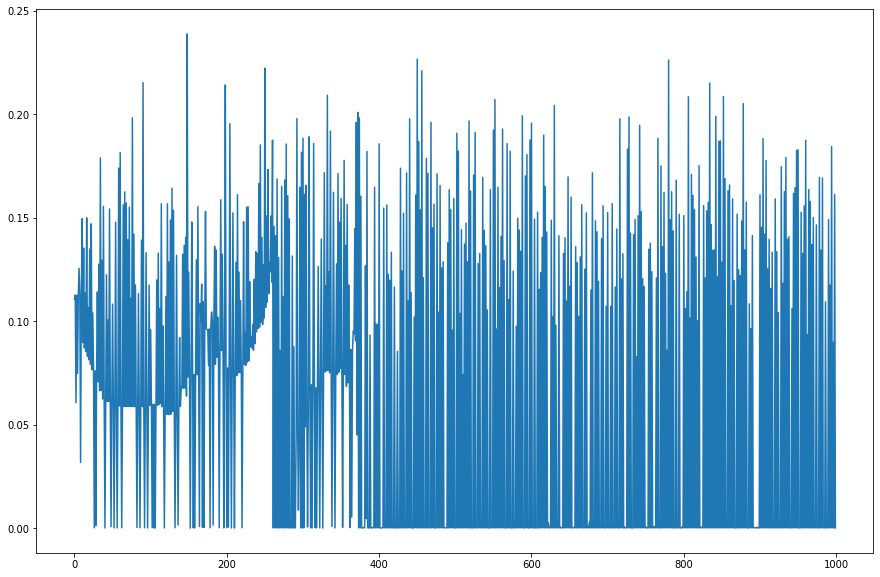

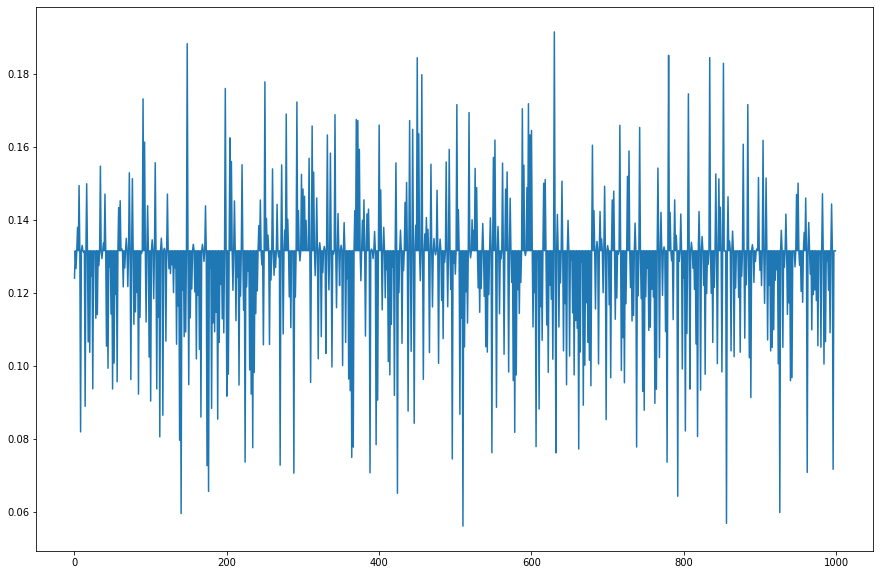

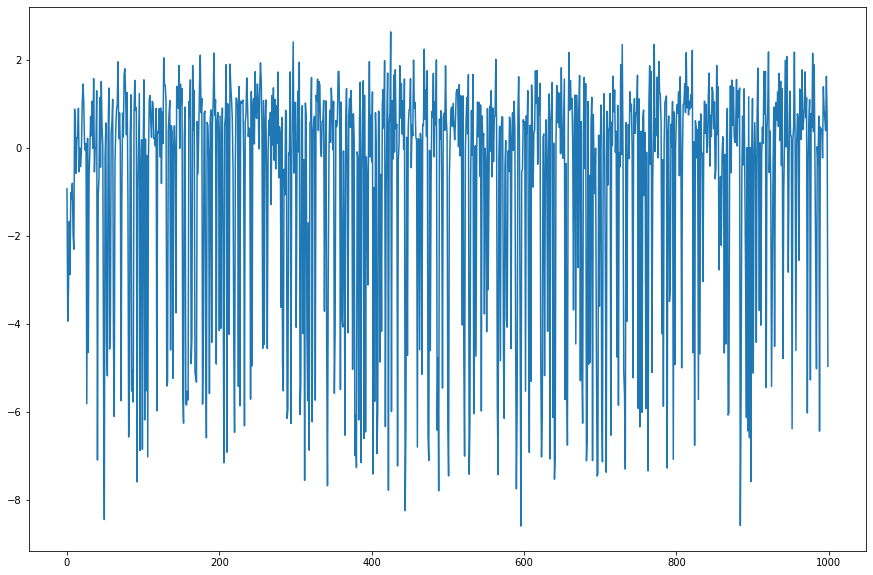

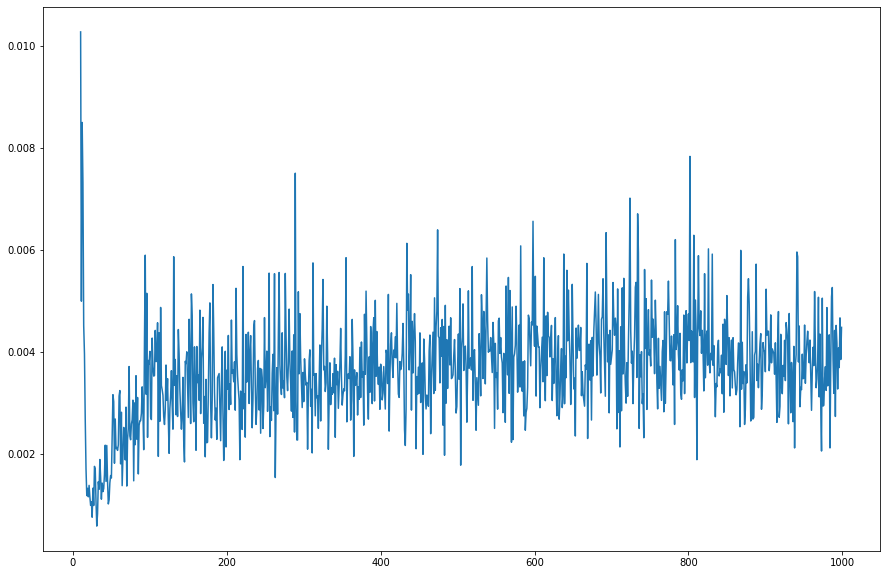

In [13]:
def preprocess_state(state):
    return np.expand_dims(state, 0)

def build_summaries():
    with tf.compat.v1.variable_scope('total_reward'):
      var = tf.Variable(0.)
      tf.summary.scalar('reward', var)
      tf.summary.histogram('histogram', var)
    return tf.summary.merge_all(scope='total_reward'), var


def restore_model(sess,saver):
    saver.restore(sess, str(restore_path)+'/model_vars.ckpt')


def save_model(sess,saver,wsee,fpa):
    saver.save(sess, str(path2)+'/model_vars_wsee_'+str(wsee)+'_'+str(fpa)+'.ckpt')

def train(sess, env, params, actor, critic, noise, state_dim, action_dim,action_min,action_max, saver):
    global ep_rewards, ep_wsee, equal_wsee, test_ep_rewards, test_ep_wsee, df_wsee, df_eqwsee, df_loss, df_reward, result, EPSILON, MIN_EPSILON, EPSILON_DECAY
    EPSILON = 0.6
    MIN_EPSILON = 0.0001
    EPSILON_DECAY = np.power(MIN_EPSILON,(1/(EPISODES)))
    result = [None, None]
    ep_rewards = [] 
    ep_wsee = []
    equal_wsee =[]
    test_ep_rewards = []
    test_ep_wsee = []
    df_wsee = pd.DataFrame(columns=['wsee'])
    df_eqwsee = pd.DataFrame(columns=['eqwsee'])
    df_reward = pd.DataFrame(columns=['reward'])
    df_loss = pd.DataFrame(columns=['loss'])
    sess.run(tf.compat.v1.initialize_all_variables())

    sess.run([actor.update_target_policy_params, critic.update_target_q_params])

    replay_buffer = ReplayBuffer(random_seed=int(params['random_seed']))

    total_steps = 0
    total_episodes = 0

    if params['restore']:
        restore_model(sess, saver)
        actor.restore_model()
        critic.restore_model()
        print('Model restored!')
        total_steps, total_episodes = sess.run([total_steps_var, total_episodes_var])

    if params['use_adaptive_parameter_noise']:
      agent = actor.perturbed_predict
    else:
      agent = actor.predict

    max_exploration_steps = params['max_exploration_steps']
    p = 1
    drop_prob = params['drop_prob']
    indicator = False
    counter = 0
    prev_wsee = 0
    for episode in tqdm(range(params['max_episodes']),ascii=True, unit="episode"):

      
      
      _distance = []
      _std_dev = []
      
      episode_reward = 0

      observation, agent_no = env.reset(episode)

      state = preprocess_state(observation)

      total_reward = 0
      _evaluate = False

      for step in range(params['max_episode_len']):

        if total_steps < max_exploration_steps:

          
          state = np.reshape(state, [1, state_dim])
          # print(f'############################################ step: {step}, state: {state} ###############################################')
          actions = agent(state, drop_prob = drop_prob)
          if not params['use_adaptive_parameter_noise']:
            actions += noise(0, 0.2, action_dim)
            p -= 1/max_exploration_steps
          
        
        else:
          print('### Training Complete ###')
          raise KeyboardInterrupt

        # action = action[0]
        action =  np.clip(actions, action_min, action_max)/action_max
        # print(f'############################################ step: {step, action_max}, action: {action} ###############################################')
        next_state, reward, terminal = env.step(action, agent_no)

        episode_reward += reward


        replay_buffer.add(
            (state, action, reward, terminal, next_state)
        )
        
        # if actor.normalize_observations:
        #   actor.obs_rms.update(state)

        current_state, agent_no = env.agent_reset()
        state = preprocess_state(current_state)
        total_reward += reward
        total_steps += 1

        if total_steps % 100 == 0:
          _evaluate = True

        if terminal:
          if _evaluate:
            test_no = 100
            # if episode > 990 or counter == 10:
            #   test_no = 800
            curr_wsee, indicator = evaluate(sess, env, params, actor, critic, state_dim, action_min, action_max, saver, test_no, prev_wsee)
            prev_wsee = curr_wsee
            # if indicator:
            #   counter += 1
            # else:
            #   counter = 0
          break

      # if counter == 11:
      #   break
      for train_step in range(params['train_step']):
        if len(replay_buffer.buffer) >= params['minibatch_size']:
          
          minibatch, importance, indices = replay_buffer.sample()
          
          current_states = np.array([np.asarray(transition)[0] for transition in minibatch])
          current_states = np.reshape(current_states, [len(minibatch), state_dim])
          
          current_actions = np.array([np.asarray(transition)[1] for transition in minibatch])
          current_actions = np.reshape(current_actions, [len(minibatch), action_dim])
          # current_actions = np.clip(current_actions, action_min, action_max)/action_max

          current_qs_list = critic.predict(current_states, np.asarray(-np.log10(env.pu*current_actions)), drop_prob)
          # current_qs_list = critic.predict(current_states, np.asarray(env.pu*current_actions), drop_prob)
          
          new_states = np.array([np.asarray(transition)[4] for transition in minibatch])
          new_states = np.reshape(new_states, [len(minibatch), state_dim])

          future_actions = actor.target_predict(new_states, drop_prob)
          future_actions = np.clip(future_actions, action_min, action_max)/action_max

          future_qs_list = critic.target_predict(new_states, np.asarray(-np.log10(env.pu*future_actions)), drop_prob)
          # future_qs_list = critic.target_predict(new_states, np.asarray(env.pu*future_actions), drop_prob)
          
          y = []
          errors = []
          for index, (current_state, action, reward, terminal, next_state) in enumerate(minibatch):
              if not terminal:
                future_q = future_qs_list[index]
                new_q = reward + critic.gamma*future_q
                new_action = future_actions[index]
              else:
                new_q = reward
                new_action = action
              current_q = current_qs_list[index]
              errors.append(new_q-current_q)
              y.append(new_q)
          
          y = np.reshape(y, [1, len(minibatch)])
          importance = np.reshape(importance, [1, len(minibatch)])
          result = critic.train(current_states, np.asarray(-np.log10(env.pu*current_actions)), drop_prob, y, importance)
          
          actor.train(current_states, drop_prob,
                      critic.compute_grads(current_states, np.asarray(-np.log10(env.pu*current_actions)), drop_prob)[0])
          
          sess.run(actor.update_target_policy_params)
          sess.run(critic.update_target_q_params)

          # errors = y - critic.predict(state_batch,
          #                             actor.predict(state_batch, drop_prob),
          #                             drop_prob)

          if params['use_adaptive_parameter_noise'] and train_step % 20 == 0:
              distance, std_dev = actor.add_param_noise(current_states)
              _distance.append(distance)
              _std_dev.append(std_dev)

          replay_buffer.set_priorities(indices, errors)
      total_episodes += 1
      # distance, std_dev = actor.add_param_noise(current_states)
      # _distance.append(distance)
      # _std_dev.append(std_dev)

      sess.run([total_steps_var.assign(total_steps), total_episodes_var.assign(episode)])
      loss = result[0]
      ep_rewards.append(episode_reward)
      equal_wsee.append(env.cal_equal_p_WSEE(0))
      ep_wsee.append(env.cal_total_WSEE(0))

      if params['use_adaptive_parameter_noise']:
            print(
                f'Loss: {loss}|| Global step: {total_steps} || Episode: {total_episodes} || Reward: {total_reward:.2f} || Distance: {np.array(_distance).mean():.4f} ||')
      else:
          print(
              f'|| Global step: {total_steps} || Episode: {total_episodes} || Reward: {total_reward:.2f} ||')
          

      if not episode % AGGREGATE_STATS_EVERY or episode == 1:
        average_wsee = sum(ep_wsee[-AGGREGATE_STATS_EVERY:])/len(ep_wsee[-AGGREGATE_STATS_EVERY:])
        average_equal_wsee = sum(equal_wsee[-AGGREGATE_STATS_EVERY:])/len(equal_wsee[-AGGREGATE_STATS_EVERY:])
        average_reward = sum(ep_rewards[-AGGREGATE_STATS_EVERY:])/len(ep_rewards[-AGGREGATE_STATS_EVERY:])
        min_reward = min(ep_rewards[-AGGREGATE_STATS_EVERY:])
        max_reward = max(ep_rewards[-AGGREGATE_STATS_EVERY:])
        #agent.tensorboard.update_stats(avg_equal_p_wsee = average_equal_wsee, reward_avg=average_reward, reward_min=min_reward, reward_max=max_reward, epsilon=epsilon, avg_wsee = average_wsee) 
        # cma_reward = (cma_reward + (average_reward-cma_reward)/(episode+1))
        # print(cma_reward)
        df_wsee = df_wsee.append({'wsee': average_wsee}, ignore_index=True)
        df_eqwsee = df_eqwsee.append({'eqwsee': average_equal_wsee}, ignore_index=True)
        df_reward = df_reward.append({'reward': average_reward}, ignore_index=True)
        df_loss = df_loss.append({'loss': loss}, ignore_index=True)
        print(f'wsee: {average_wsee}, eqwsee: {average_equal_wsee}, reward: {average_reward}')
        # agent.tensorboard.update_stats2(rval, train, episode, "loss")
        # agent.tensorboard.update_stats2(average_wsee, train, episode, "wsee")
        # agent.tensorboard.update_stats2(average_equal_wsee, train, episode, "eq_wsee")
        # agent.tensorboard.update_stats2(average_reward, train, episode, "reward")
        # Save model, but only when min reward is greater or equal a set value
        # if min_reward >= MIN_REWARD and episode%5==0:
        # #     #agent.model.save(f'./models/{MODEL_NAME}__{max_reward:_>7.2f}max_{average_reward:_>7.2f}avg_{min_reward:_>7.2f}min__{int(time.time())}.h5')
        #   actor.actions.save(filepath=path2/f'{MODEL_NAME}__{max_reward:_>7.2f}max_{average_reward:_>7.2f}avg_{min_reward:_>7.2f}min__{int(time.time())}_actor_2.h5')
        #   critic.q_value.save(filepath=path2/f'{MODEL_NAME}__{max_reward:_>7.2f}max_{average_reward:_>7.2f}avg_{min_reward:_>7.2f}min__{int(time.time())}_critic_2.h5')
        if EPSILON > MIN_EPSILON:
          EPSILON *= EPSILON_DECAY
          EPSILON = max(MIN_EPSILON, EPSILON)
      

global eval_wsee, eval_fpa, eval_reward

eval_reward = []
eval_wsee = []
eval_fpa = []

def evaluate(sess, env, params, actor, critic, state_dim, action_min, action_max, saver, test_no, prev_wsee):

    if params['restore'] and not params['train']:
        sess.run(tf.compat.v1.global_variables_initializer())
        restore_model(sess, saver)
        actor.restore_model()
        critic.restore_model()
        print('Model restored!')

    total_steps = sess.run(total_steps_var)
    err = 0.01
    _reward = []
    _test_wsee = []
    _test_fpa_wsee = []
    flag = 0
    start = 1100
    end = start+test_no
    for episode in range(start,end):
        env.reset_test(episode)
        total_reward = 0
        
        for a in range(env.K):
            agent_no = a
            observation = env.initialize_state_test(a)
            state = preprocess_state(observation)
            state = np.reshape(state, [1, state_dim])
            actions = actor.predict(state, drop_prob=0.)
            actions = np.clip(actions, action_min, action_max)/action_max
            action = actions[0]

            _, reward, _ = env.step(action, a)
            
            total_reward += reward
        if total_reward >= 0:
          flag += 1
        _reward.append(total_reward)
        _test_wsee.append(env.cal_total_WSEE(0))
        _test_fpa_wsee.append(env.cal_equal_p_WSEE(0))
        if episode % 20 ==0:
          print(f'|| Test Run No: {episode} || WSEE: {env.cal_total_WSEE(0)} || eq_WSEE: {env.cal_equal_p_WSEE(0)} || Reward: {total_reward:.2f} ||')
    wsee = np.sum(_test_wsee)/len(_test_wsee)
    fpa = np.sum(_test_fpa_wsee)/len(_test_fpa_wsee)
    eval_wsee.append(wsee)
    eval_fpa.append(fpa)
    eval_reward.append(np.sum(_reward)/len(_reward))
    print(f'wsee:{wsee}, fpa_wsee: {fpa}')
    if flag > 0.95*test_no:
        # save_model(sess,saver,wsee, fpa)
        # actor.save_model(wsee, fpa)
        # critic.save_model(wsee, fpa)
        print('Model could have been saved!')
    # total_reward = np.max(np.array(_reward))
    # summary = sess.run(merge_op, feed_dict={total_reward_var: total_reward})
    # writer.add_summary(summary, total_steps)
        if abs(prev_wsee - wsee) < err: 
          return wsee, True
        else:
          return wsee, False
    else:
      return wsee, False


def main(args, power, nrx):
    params = vars(args)
    tf.compat.v1.set_random_seed(int(params['random_seed']))
    np.random.seed(int(params['random_seed']))
    if params['train']:
      gainspath = 'testNrx/channel_K10_AP32_2k_fresh.h5'
    if params['restore']:
      gainspath = '25thJulyTestGains/channel_K10_AP32_2k.h5'

    with tf.compat.v1.Session() as sess:
        try:
            env = wirelessEnv(power, nrx, gainspath, int(params['random_seed'])) 
            # env = gym.make(args['env'])
            state_dim = env.s_dim
            action_dim = env.a_dim
            action_min = 0.000001
            action_max = power

            # assert (env.action_space.high == -env.action_space.low).all()
            # action_bound = env.action_space.high[0]

            global total_steps_var, total_episodes_var
            total_episodes_var = tf.Variable(0)
            total_steps_var = tf.Variable(0)

            # if args['use_gym_monitor']:
            #     if not args['render_env']:
            #         env = wrappers.Monitor(
            #             env, args['monitor_dir'], video_callable=False, force=True)
            #     else:
            #         env = wrappers.Monitor(env, args['monitor_dir'], force=True)

            actor = Actor(sess, state_dim, action_dim, 
                          use_param_noise=params['use_adaptive_parameter_noise'], 
                          tau=params['tau'], gamma=params['gamma'], 
                          delta=params['delta'], normalize_observations=params['normalize_obs'])
            
            critic = Critic(sess, state_dim, action_dim, tau=params['tau'], gamma=params['gamma'],
                            learning_rate=params['critic_lr'], 
                            normalize_observations=params['normalize_obs'])

            ## Noise
            noise = np.random.normal

            saver = tf.compat.v1.train.Saver()
            # writer = tf.summary.FileWriter(args['summary_dir'] + '/' + args['env'] + '/' + str(datetime.now()))

            if params['train']:
                train(sess,env,params,actor,critic,noise,state_dim,action_dim,action_min,action_max, saver)
            # evaluate(sess, env, params, actor, critic, state_dim, action_min, action_max, saver)
            # save_model(sess,saver)
            # actor.save_model()
            # critic.save_model()
            # print('Model saved!')

        except KeyboardInterrupt:
            if params['save']:
              # save_model(sess,saver)
              # actor.save_model()
              # critic.save_model()
              print('Model saved!')


    test_wsee = np.sum(test_ep_wsee)/len(test_ep_wsee)
    wsee = np.sum(ep_wsee)/len(ep_wsee)
    print(f'wsee:{wsee}, test_wsee: {test_wsee}, agent.env.pi: {env.pi[1]}')

    plt.figure(figsize=(15,10))
    # df_wsee.reset_index().plot(kind='line',x='index', y='wsee')
    plt.plot(df_wsee['wsee'])
    # plt.show()
    plt.savefig(dest/r'wsee.jpg', dpi=300)
    # df_eqwsee.reset_index().plot(kind='line',x='index', y='eqwsee')
    plt.figure(figsize=(15,10))
    plt.plot(df_eqwsee['eqwsee'])
    # nrxmean = df_eqwsee['eqwsee'].mean(axis=0)
    # print(nrxmean, nrx)
    # nrx_val.append(nrxmean*env.B)
    # plt.show()
    plt.savefig(dest/r'eqwsee.jpg', dpi=300)
    # df_reward.reset_index().plot(kind='line',x='index', y='reward')
    plt.figure(figsize=(15,10))
    plt.plot(df_reward['reward'])
    # plt.show()
    plt.savefig(dest/r'reward.jpg', dpi=300)
    # df_loss.reset_index().plot(kind='line',x='index', y='loss')
    plt.figure(figsize=(15,10))
    plt.plot(df_loss['loss'])
    # plt.show()
    plt.savefig(dest/r'loss.jpg', dpi=300)

    df_wsee.to_csv(dest/r'wsee29thJan.csv')
    df_eqwsee.to_csv(dest/r'eqwsee29thJan.csv')
    df_reward.to_csv(dest/r'reward29thJan.csv')
    df_loss.to_csv(dest/r'loss29thJan.csv')


def test(args, power, nrx):
    # tf.set_random_seed(int(args['random_seed']))
    # np.random.seed(int(args['random_seed']))
    params = vars(args)
    gainspath2 = '25thJulyTestGains/channel_K10_AP32_2k.h5'
    with tf.compat.v1.Session() as sess:
    
        env = wirelessEnv(power, nrx, gainspath2) 
        # env = gym.make(args['env'])
        # env.seed(int(args['random_seed']))
        state_dim = env.s_dim
        action_dim = env.a_dim
        action_min = 0.000001
        action_max = power

        global total_steps_var, total_episodes_var
        total_episodes_var = tf.Variable(0)
        total_steps_var = tf.Variable(0)

        saver_actor = tf.compat.v1.train.import_meta_graph(base_dir + 'Thu Jul 23 01:53:05 2020/models/actor/model_actor.ckpt.meta')
        saver_actor.restore(sess, tf.train.latest_checkpoint(base_dir + 'Thu Jul 23 01:53:05 2020/models/actor'))
        sess.run(tf.compat.v1.global_variables_initializer())
        graph = tf.compat.v1.get_default_graph()
        state_ph = graph.get_tensor_by_name("state_ph:0")
        drop_prob = graph.get_tensor_by_name("drop_prob:0")
        predict_operation = graph.get_tensor_by_name("actions:0")
        
        total_steps = sess.run(total_steps_var)
        _reward = []
        _test_wsee = []
        _test_fpa_wsee = []

        for episode in range(2000):
            env.reset_test(episode)
            total_reward = 0
            
            for a in range(env.K):
                agent_no = a
                observation = env.initialize_state_test(a)
                state = preprocess_state(observation)
                state = np.reshape(state, [1, state_dim])
                actions = sess.run(predict_operation, feed_dict = {state_ph: state, drop_prob: 0.0})
                actions = np.clip(actions, action_min, action_max)/action_max
                action = actions[0]

                _, reward, _ = env.step(action, a)
                
                total_reward += reward

            _reward.append(total_reward)
            _test_wsee.append(env.cal_total_WSEE(0))
            _test_fpa_wsee.append(env.cal_equal_p_WSEE(0))
            print(f'|| WSEE: {env.cal_total_WSEE(0)} || eq_WSEE: {env.cal_equal_p_WSEE(0)} || agent.env.pi: {env.pi[1]} || Reward: {total_reward:.2f} ||')



    wsee = np.sum(_test_wsee)/len(_test_wsee)
    fpa = np.sum(_test_fpa_wsee)/len(_test_fpa_wsee)
    print(f'wsee:{wsee}, fpa_wsee: {test_wsee}')



parser = argparse.ArgumentParser(description='provide arguments for DDPG agent')

# agent parameters
parser.add_argument('--actor-lr', help='actor network learning rate', default=0.005)
parser.add_argument('--critic-lr', help='critic network learning rate', default=0.05)
parser.add_argument('--gamma', help='discount factor for critic updates', default=0.6)
parser.add_argument('--tau', help='soft target update parameter', default=0.01)
parser.add_argument('--use-adaptive-parameter-noise', help='', default=True)
parser.add_argument('--delta', help='desired action deviation', default=.2)
parser.add_argument('--l2_reg', help='Q loss regularization strength', default=.0)
parser.add_argument('--drop-prob', help='drop out probability', default=.4)
parser.add_argument('--buffer-size', help='max size of the replay buffer', default=10000)
parser.add_argument('--minibatch-size', help='size of minibatch for minibatch-SGD', default=512)
parser.add_argument('--normalize-obs', help='normalizes observations', default=True)

# run parameters
parser.add_argument('--train', help='train the model', default=True)
parser.add_argument('--train_step', help='number of training steps', default=50)
parser.add_argument('--max-exploration-steps', help='', default=1e6)
# parser.add_argument('--env', help='choose the gym env', default='HalfCheetah-v2')
parser.add_argument('--save', help='save trained model', default=True)
parser.add_argument('--restore', help='restore prev trained model', default=False)
parser.add_argument('--random-seed', help='random seed for repeatability', default=1337)
parser.add_argument('--max-episodes', help='max num of episodes to do while training', default=1000)
parser.add_argument('--max-episode-len', help='max length of 1 episode', default=20000)
# parser.add_argument('--render-env', help='render the gym env', action='store_true')
# parser.add_argument('--use-gym-monitor', help='record gym results', action='store_true')
# parser.add_argument('--monitor-dir', help='directory for storing gym results', default='./results/gym_ddpg')
parser.add_argument('--summary-dir', help='directory for storing tensorboard info', default='./results/tf_ddpg')

parser.set_defaults()
# parser.set_defaults(use_gym_monitor=False)

args, _ = parser.parse_known_args()

# with open('./random_seeds_used', 'a+') as f:
#     f.write(f"Time: {str(datetime.now())}, random seed: {args['random_seed']}\n")


pp.pprint(args)
# merge_op, total_reward_var = build_summaries()
power = 30
nrx = 2
main(args, np.power(10,power/10 - 3), nrx)


In [14]:
episode = [int(i*100) for i in range(1,len(eval_wsee)+1)]
# episode = episode*500

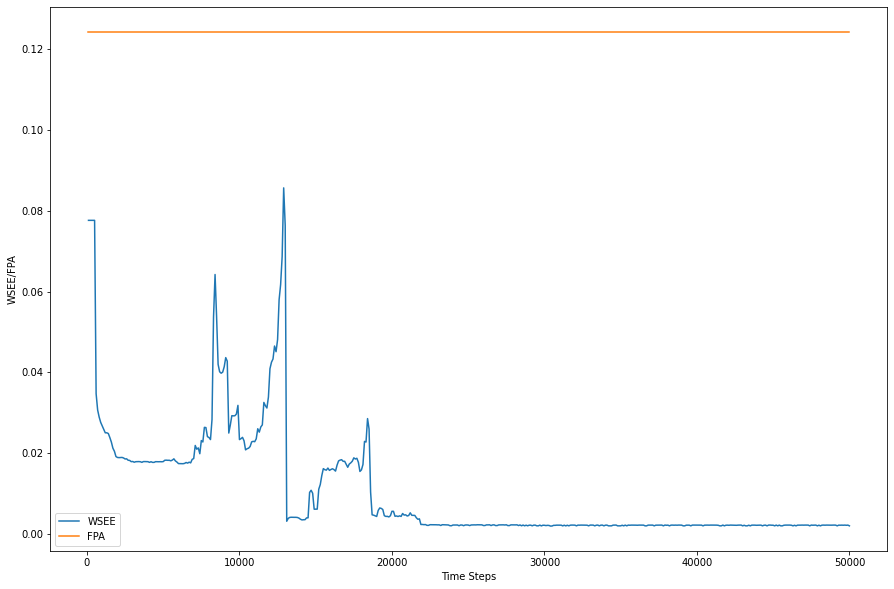

In [15]:
plt.figure(figsize=(15,10))
plt.plot(episode, eval_wsee, label='WSEE')
plt.plot(episode, eval_fpa, label='FPA')
plt.xlabel('Time Steps')
plt.ylabel('WSEE/FPA')
plt.legend()
plt.savefig(dest/r'training.jpg', dpi=300)

Text(0, 0.5, 'Reward')

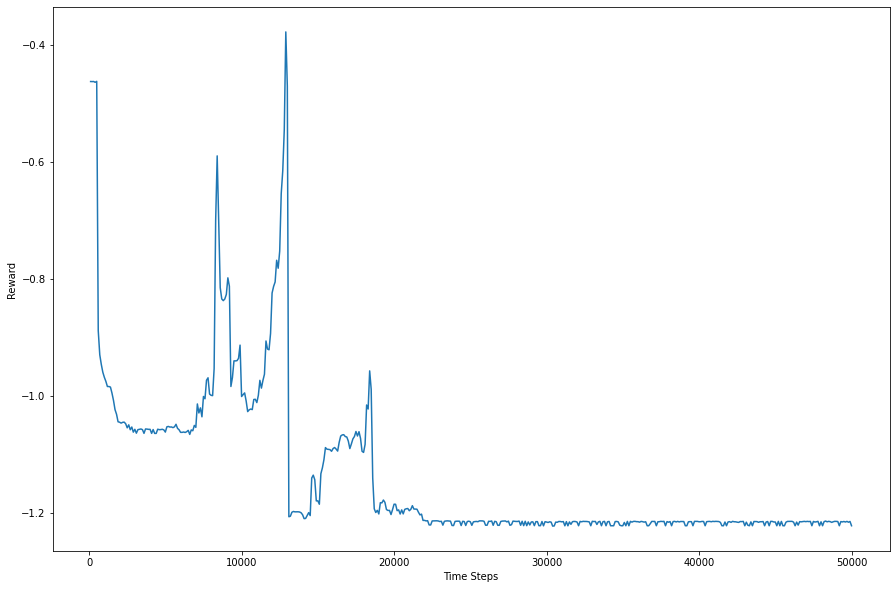

In [16]:
plt.figure(figsize=(15,10))
plt.plot(episode, eval_reward)
plt.xlabel('Time Steps')
plt.ylabel('Reward')
